In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
from glob import glob
import os
import json 
import timm
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import albumentations as A

In [2]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [3]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [4]:
# ============= add
labels = pd.read_csv('./data/train.csv')

train_label_encoder = {}
label_cnt = 0
previous_label = '0_00_0'
for i, label in enumerate(tqdm(sorted(labels['label']))) :
    crop_val = label.split('_')[0] # crop
    disease_val = label.split('_')[1] # disease
    risk_val = label.split('_')[2] # risk
    
    tmp_label = f'{crop_val}_{disease_val}_{risk_val}'
    if previous_label != tmp_label :
        train_label_encoder[tmp_label] = label_cnt
        previous_label = tmp_label
        label_cnt += 1
        
train_label_decoder = {val : key for key, val in train_label_encoder.items()}
display(train_label_decoder)
display(train_label_encoder)

100%|██████████████████████████████████████████████████████████████████████████| 5767/5767 [00:00<00:00, 961198.14it/s]


{0: '1_00_0',
 1: '2_00_0',
 2: '2_a5_2',
 3: '3_00_0',
 4: '3_a9_1',
 5: '3_a9_2',
 6: '3_a9_3',
 7: '3_b3_1',
 8: '3_b6_1',
 9: '3_b7_1',
 10: '3_b8_1',
 11: '4_00_0',
 12: '5_00_0',
 13: '5_a7_2',
 14: '5_b6_1',
 15: '5_b7_1',
 16: '5_b8_1',
 17: '6_00_0',
 18: '6_a11_1',
 19: '6_a11_2',
 20: '6_a12_1',
 21: '6_a12_2',
 22: '6_b4_1',
 23: '6_b4_3',
 24: '6_b5_1'}

{'1_00_0': 0,
 '2_00_0': 1,
 '2_a5_2': 2,
 '3_00_0': 3,
 '3_a9_1': 4,
 '3_a9_2': 5,
 '3_a9_3': 6,
 '3_b3_1': 7,
 '3_b6_1': 8,
 '3_b7_1': 9,
 '3_b8_1': 10,
 '4_00_0': 11,
 '5_00_0': 12,
 '5_a7_2': 13,
 '5_b6_1': 14,
 '5_b7_1': 15,
 '5_b8_1': 16,
 '6_00_0': 17,
 '6_a11_1': 18,
 '6_a11_2': 19,
 '6_a12_1': 20,
 '6_a12_2': 21,
 '6_b4_1': 22,
 '6_b4_3': 23,
 '6_b5_1': 24}

# Dataset 구현

In [38]:
class CustomDataset(Dataset):
    def __init__(self, files, transforms, mode='train'):
        self.mode = mode
        self.files = files
        self.label_encoder = train_label_encoder #label_encoder
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('\\')[-1]
        
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
#         img = img.astype(np.float32)/255
        img = self.transforms(image=img)["image"]
        img = img.transpose(2,0,1)
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32) / 255.0,
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32)/ 255.0
            }

# Model 선언

In [6]:
import timm

class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        self.model = timm.create_model('deit_small_patch16_224', num_classes=25, pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

# Hyperparmeter 선언

In [7]:
device = torch.device("cuda:0")#("cpu")
batch_size = 16
class_n = len(train_label_encoder)
learning_rate = 1e-4
embedding_dim = 512
epochs = 20
vision_pretrain = True
save_path = 'kfold_Deit.pt'
fold_n = 3

# Image Transform

In [8]:
train_transforms = A.Compose([
                A.Resize(224 ,224),
                A.OneOf([
                    A.Rotate(),
                    A.HorizontalFlip(),
                    A.VerticalFlip()
                ], p=1)
            ])

val_transforms = A.Compose([
    A.Resize(224,224)
])

# CutMix

In [9]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)
 
    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# Training

In [10]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    label = batch_item['label'].to(device)
    
    lam = np.random.beta(1.0, 1.0)
    
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # add - cutmix
            rand_index = torch.randperm(img.size()[0])
            target_a = label
            target_b = label[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
            img[:, :, bbx1:bbx2, bby1:bby2] = img[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
            
            output = model(img)
            loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
            
#             output = model(img, csv_feature)
#             loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

# Loss, Optim

In [11]:
model = ViT()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Label

In [12]:
json_path = glob('./data/train/*/*.json')

labels = []
for path in tqdm(json_path) :
    json_file = json.load(open(path, 'r'))
    
    crop = json_file['annotations']['crop']
    disease = json_file['annotations']['disease']
    risk = json_file['annotations']['risk']
    
    label = f'{crop}_{disease}_{risk}'
    labels.append(train_label_encoder[label])

100%|████████████████████████████████████████████████████████████████████████████| 5767/5767 [00:01<00:00, 4083.66it/s]


In [13]:
data_list = glob('./data/train/*')
label_list = labels

kfold = StratifiedKFold(n_splits=4, random_state=13, shuffle=True)

In [14]:
for k, (fold_train, fold_val) in enumerate(kfold.split(data_list, label_list), 1) :
    model = ViT()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    train_data_list = []
    val_data_list = []
    
    for k_train in fold_train :
        train_data_list.append(data_list[k_train])
    
    for k_val in fold_val :
        val_data_list.append(data_list[k_val])
    
    print(f"\n\n\n===== k_fold : {k} / 5 =====")
    train_dataset = CustomDataset(train_data_list, train_transforms)
    val_dataset = CustomDataset(val_data_list, val_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    loss_plot, val_loss_plot = [], []
    metric_plot, val_metric_plot = [], []

    for epoch in range(epochs):
        total_loss, total_val_loss = 0, 0
        total_acc, total_val_acc = 0, 0

        tqdm_dataset = tqdm(enumerate(train_dataloader))
        training = True
        for batch, batch_item in tqdm_dataset:
            batch_loss, batch_acc = train_step(batch_item, training)
            total_loss += batch_loss
            total_acc += batch_acc

            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Loss': '{:06f}'.format(batch_loss.item()),
                'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
                'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
            })
        loss_plot.append(total_loss/(batch+1))
        metric_plot.append(total_acc/(batch+1))

        tqdm_dataset = tqdm(enumerate(val_dataloader))
        training = False
        for batch, batch_item in tqdm_dataset:
            batch_loss, batch_acc = train_step(batch_item, training)
            total_val_loss += batch_loss
            total_val_acc += batch_acc

            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Val Loss': '{:06f}'.format(batch_loss.item()),
                'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
                'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
            })
        val_loss_plot.append(total_val_loss/(batch+1))
        val_metric_plot.append(total_val_acc/(batch+1))

        if np.max(val_metric_plot) == val_metric_plot[-1]:
            torch.save(model.state_dict(), f'{k}_{save_path}')




===== k_fold : 1 / 5 =====


271it [00:44,  6.03it/s, Epoch=1, Loss=0.783355, Mean Loss=1.555314, Mean F-1=0.393514]
91it [00:11,  8.03it/s, Epoch=1, Val Loss=0.990784, Mean Val Loss=0.499899, Mean Val F-1=0.685576]
271it [00:45,  6.02it/s, Epoch=2, Loss=0.882115, Mean Loss=1.026167, Mean F-1=0.546119]
91it [00:11,  7.83it/s, Epoch=2, Val Loss=0.195025, Mean Val Loss=0.306329, Mean Val F-1=0.816577]
271it [00:47,  5.69it/s, Epoch=3, Loss=1.128675, Mean Loss=0.851288, Mean F-1=0.635139]
91it [00:12,  7.34it/s, Epoch=3, Val Loss=0.141489, Mean Val Loss=0.203728, Mean Val F-1=0.834897]
271it [00:48,  5.55it/s, Epoch=4, Loss=0.248737, Mean Loss=0.788483, Mean F-1=0.643838]
91it [00:12,  7.16it/s, Epoch=4, Val Loss=0.236910, Mean Val Loss=0.182283, Mean Val F-1=0.850597]
271it [00:49,  5.45it/s, Epoch=5, Loss=0.900728, Mean Loss=0.752014, Mean F-1=0.679291]
91it [00:13,  6.81it/s, Epoch=5, Val Loss=0.181925, Mean Val Loss=0.175031, Mean Val F-1=0.853718]
271it [00:51,  5.31it/s, Epoch=6, Loss=0.407564, Mean Loss=0.7166




===== k_fold : 2 / 5 =====


271it [01:11,  3.81it/s, Epoch=1, Loss=1.014112, Mean Loss=1.489644, Mean F-1=0.432736]
91it [00:16,  5.42it/s, Epoch=1, Val Loss=0.056821, Mean Val Loss=0.453930, Mean Val F-1=0.690241]
271it [01:09,  3.92it/s, Epoch=2, Loss=1.100026, Mean Loss=0.990206, Mean F-1=0.557154]
91it [00:16,  5.41it/s, Epoch=2, Val Loss=0.038702, Mean Val Loss=0.322274, Mean Val F-1=0.751129]
271it [01:11,  3.77it/s, Epoch=3, Loss=0.709482, Mean Loss=0.862065, Mean F-1=0.605652]
91it [00:16,  5.39it/s, Epoch=3, Val Loss=0.020567, Mean Val Loss=0.228591, Mean Val F-1=0.792195]
271it [01:10,  3.84it/s, Epoch=4, Loss=0.692506, Mean Loss=0.756124, Mean F-1=0.661559]
91it [00:17,  5.19it/s, Epoch=4, Val Loss=0.014186, Mean Val Loss=0.191512, Mean Val F-1=0.826152]
271it [01:10,  3.83it/s, Epoch=5, Loss=0.735779, Mean Loss=0.755708, Mean F-1=0.665787]
91it [00:17,  5.09it/s, Epoch=5, Val Loss=0.010479, Mean Val Loss=0.176980, Mean Val F-1=0.845643]
271it [01:11,  3.79it/s, Epoch=6, Loss=0.402106, Mean Loss=0.6909




===== k_fold : 3 / 5 =====


271it [01:08,  3.94it/s, Epoch=1, Loss=0.669771, Mean Loss=1.416518, Mean F-1=0.432783]
91it [00:16,  5.52it/s, Epoch=1, Val Loss=0.018199, Mean Val Loss=0.444657, Mean Val F-1=0.688503]
271it [01:08,  3.98it/s, Epoch=2, Loss=0.330525, Mean Loss=0.963973, Mean F-1=0.595831]
91it [00:16,  5.48it/s, Epoch=2, Val Loss=0.012216, Mean Val Loss=0.306092, Mean Val F-1=0.776938]
271it [01:07,  4.03it/s, Epoch=3, Loss=0.655925, Mean Loss=0.831394, Mean F-1=0.644776]
91it [00:16,  5.59it/s, Epoch=3, Val Loss=0.011023, Mean Val Loss=0.242859, Mean Val F-1=0.800454]
271it [01:08,  3.96it/s, Epoch=4, Loss=0.098560, Mean Loss=0.754971, Mean F-1=0.656345]
91it [00:16,  5.49it/s, Epoch=4, Val Loss=0.005347, Mean Val Loss=0.193038, Mean Val F-1=0.843717]
271it [01:11,  3.81it/s, Epoch=5, Loss=0.329008, Mean Loss=0.724780, Mean F-1=0.664652]
91it [00:16,  5.53it/s, Epoch=5, Val Loss=0.008073, Mean Val Loss=0.251450, Mean Val F-1=0.800272]
271it [01:08,  3.96it/s, Epoch=6, Loss=1.074177, Mean Loss=0.7146




===== k_fold : 4 / 5 =====


271it [01:02,  4.34it/s, Epoch=1, Loss=0.451461, Mean Loss=1.417940, Mean F-1=0.439264]
91it [00:16,  5.37it/s, Epoch=1, Val Loss=0.854995, Mean Val Loss=0.416639, Mean Val F-1=0.708824]
271it [01:06,  4.08it/s, Epoch=2, Loss=0.882926, Mean Loss=0.958822, Mean F-1=0.583037]
91it [00:16,  5.52it/s, Epoch=2, Val Loss=0.537625, Mean Val Loss=0.279681, Mean Val F-1=0.784435]
271it [01:07,  4.04it/s, Epoch=3, Loss=1.005290, Mean Loss=0.838302, Mean F-1=0.630783]
91it [00:16,  5.43it/s, Epoch=3, Val Loss=0.375699, Mean Val Loss=0.201755, Mean Val F-1=0.832146]
271it [01:08,  3.98it/s, Epoch=4, Loss=0.658146, Mean Loss=0.775315, Mean F-1=0.637435]
91it [00:17,  5.27it/s, Epoch=4, Val Loss=0.074886, Mean Val Loss=0.221010, Mean Val F-1=0.819137]
271it [01:07,  3.99it/s, Epoch=5, Loss=0.352205, Mean Loss=0.734860, Mean F-1=0.670154]
91it [00:17,  5.19it/s, Epoch=5, Val Loss=0.047051, Mean Val Loss=0.227399, Mean Val F-1=0.816865]
271it [01:03,  4.24it/s, Epoch=6, Loss=0.648560, Mean Loss=0.6658

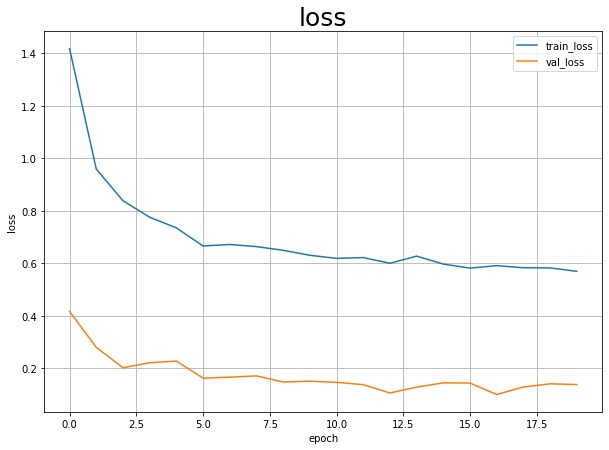

In [15]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss', fontsize=25)
plt.legend()
plt.show()

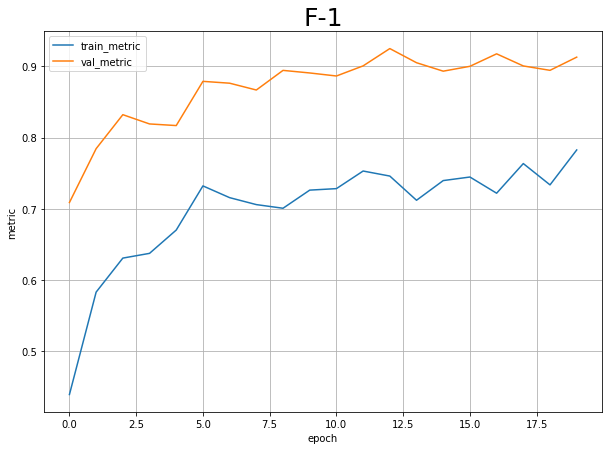

In [16]:
plt.figure(figsize=(10, 7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

In [22]:
models_path = glob('./*_kfold_vit.pt')
models = []
for model_path in models_path :
    model = ViT()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    models.append(model)

In [32]:
import torch.nn.functional as F

def softvoting(models, img, n_classes=25) :

    predicts = torch.zeros(img.size(0), n_classes)
    with torch.no_grad() :
        for model in models :
            output = model(img)
            output = F.softmax(output.cpu(), dim=1)
            predicts += output

    # 둘다 값은 똑같이 나옴.
    # pred_avg = predicts / len(models)
    # answer = pred_avg.argmax(dim=-1)
    # _, answer2 = torch.max(pred_avg, 1)

    return predicts.detach().cpu() / len(models)

val_transforms = A.Compose([
    A.Resize(224,224)
])

results = []
img = cv2.imread('./data/test\\10000\\10000.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
trans_img = val_transforms(image=img)['image']
trans_img = trans_img.transpose(2,0,1)
trans_img = (torch.tensor(trans_img, dtype=torch.float32) / 255.0).unsqueeze(0)
trans_img = trans_img.to(device)

predictions = softvoting(models, trans_img)
display(predictions)
results.append(int(torch.argmax(predictions[0])))
display(results)



#             output = model(img)
#         output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
#         results.extend(output)

    
# preds = predict(test_dataloader, models)


tensor([[2.0780e-03, 5.5500e-05, 1.4381e-04, 3.4330e-04, 9.0287e-05, 1.1064e-04,
         3.8230e-05, 1.0485e-04, 9.2478e-05, 1.0720e-04, 1.4898e-04, 2.2544e-03,
         5.9278e-05, 1.5314e-04, 9.2404e-05, 4.8539e-05, 8.7146e-05, 9.9240e-01,
         5.0061e-05, 3.1740e-05, 1.4036e-04, 7.4117e-04, 4.9854e-04, 4.9482e-05,
         8.5297e-05]])

[17]

# test Dataset 정의

In [47]:
val_transforms = A.Compose([
    A.Resize(224,224)
])

test = sorted(glob('data/test/*'))
test_dataset = CustomDataset(test, val_transforms, mode = 'test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
import torch.nn.functional as F

def softvoting(models, img, n_classes=25) :

    predicts = torch.zeros(img.size(0), n_classes)
    with torch.no_grad() :
        for model in models :
            output = model(img)
            output = F.softmax(output.cpu(), dim=1)
            predicts += output

    # 둘다 값은 똑같이 나옴.
    # pred_avg = predicts / len(models)
    # answer = pred_avg.argmax(dim=-1)
    # _, answer2 = torch.max(pred_avg, 1)

    return predicts.detach().cpu() / len(models)

In [49]:
def predict(dataset, models) :
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset :
        img = batch_item['img'].to(device)
        print(img.shape)
        predictions = softvoting(models, img)
        batch_result = [int(torch.argmax(prediction)) for prediction in predictions]
        print(batch_result)
#         for prediction in predictions :
            
#         results.append(int(torch.argmax(predictions[0])))
#             output = model(img)
#         output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(batch_result)
    return results

models_path = glob('./*_kfold_vit.pt')
models = []
for model_path in models_path :
    model = ViT()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    models.append(model)

    
preds = predict(test_dataloader, models)




1it [00:00,  3.00it/s]

torch.Size([16, 3, 224, 224])
[17, 14, 11, 3, 10, 17, 0, 15, 17, 0, 3, 1, 17, 5, 3, 2]


2it [00:00,  3.20it/s]

torch.Size([16, 3, 224, 224])
[4, 0, 17, 0, 15, 9, 17, 20, 17, 11, 3, 17, 17, 0, 17, 14]


3it [00:00,  3.44it/s]

torch.Size([16, 3, 224, 224])
[3, 5, 17, 11, 11, 16, 8, 3, 0, 3, 17, 0, 1, 7, 12, 3]


4it [00:01,  3.61it/s]

torch.Size([16, 3, 224, 224])
[13, 17, 17, 24, 11, 3, 16, 3, 17, 3, 0, 20, 11, 9, 10, 3]


5it [00:01,  3.56it/s]

torch.Size([16, 3, 224, 224])
[3, 5, 11, 13, 17, 17, 17, 11, 3, 0, 11, 3, 0, 10, 0, 21]


6it [00:01,  3.56it/s]

torch.Size([16, 3, 224, 224])
[2, 5, 8, 16, 3, 1, 11, 17, 3, 16, 21, 3, 13, 11, 7, 0]


7it [00:01,  3.60it/s]

torch.Size([16, 3, 224, 224])
[17, 8, 13, 10, 1, 17, 3, 3, 3, 11, 3, 17, 11, 17, 1, 0]


8it [00:02,  3.66it/s]

torch.Size([16, 3, 224, 224])
[11, 17, 17, 3, 0, 0, 2, 17, 10, 3, 11, 4, 1, 11, 11, 11]


9it [00:02,  3.71it/s]

torch.Size([16, 3, 224, 224])
[17, 17, 12, 13, 3, 3, 21, 11, 7, 17, 24, 11, 4, 4, 12, 0]


10it [00:02,  3.82it/s]

torch.Size([16, 3, 224, 224])
[0, 17, 3, 0, 5, 15, 10, 3, 7, 3, 3, 2, 18, 3, 9, 17]


11it [00:03,  3.77it/s]

torch.Size([16, 3, 224, 224])
[11, 3, 3, 0, 17, 17, 17, 15, 7, 2, 5, 17, 17, 20, 0, 11]


12it [00:03,  3.79it/s]

torch.Size([16, 3, 224, 224])
[11, 3, 8, 17, 7, 3, 11, 11, 0, 18, 15, 11, 11, 7, 15, 11]


13it [00:03,  3.82it/s]

torch.Size([16, 3, 224, 224])
[3, 3, 11, 17, 0, 11, 11, 3, 8, 3, 1, 3, 0, 5, 3, 10]


14it [00:03,  3.84it/s]

torch.Size([16, 3, 224, 224])
[5, 3, 4, 3, 9, 17, 0, 9, 0, 11, 3, 5, 8, 2, 3, 11]


15it [00:04,  3.79it/s]

torch.Size([16, 3, 224, 224])
[5, 9, 0, 3, 3, 9, 12, 17, 11, 3, 3, 5, 10, 3, 6, 3]


16it [00:04,  3.81it/s]

torch.Size([16, 3, 224, 224])
[11, 10, 8, 15, 5, 0, 8, 13, 17, 4, 3, 3, 17, 0, 22, 17]


17it [00:04,  3.68it/s]

torch.Size([16, 3, 224, 224])
[1, 3, 3, 5, 18, 3, 21, 3, 11, 4, 15, 0, 17, 17, 10, 3]


18it [00:04,  3.76it/s]

torch.Size([16, 3, 224, 224])
[0, 17, 3, 17, 11, 0, 0, 14, 14, 3, 16, 3, 17, 0, 3, 0]


19it [00:05,  3.76it/s]

torch.Size([16, 3, 224, 224])
[0, 11, 5, 3, 11, 3, 0, 3, 11, 0, 20, 3, 9, 11, 11, 16]


20it [00:05,  3.77it/s]

torch.Size([16, 3, 224, 224])
[0, 7, 11, 1, 13, 0, 7, 3, 11, 0, 10, 17, 3, 11, 0, 3]


21it [00:05,  3.82it/s]

torch.Size([16, 3, 224, 224])
[3, 4, 3, 3, 5, 12, 8, 0, 17, 8, 11, 0, 4, 11, 0, 3]


22it [00:05,  3.87it/s]

torch.Size([16, 3, 224, 224])
[0, 0, 0, 3, 8, 15, 17, 9, 0, 3, 11, 16, 21, 7, 10, 21]


23it [00:06,  3.84it/s]

torch.Size([16, 3, 224, 224])
[16, 10, 3, 0, 8, 11, 3, 1, 11, 3, 11, 0, 17, 17, 17, 3]


24it [00:06,  3.88it/s]

torch.Size([16, 3, 224, 224])
[3, 5, 12, 3, 9, 17, 0, 0, 0, 1, 3, 0, 0, 3, 0, 7]


25it [00:06,  3.75it/s]

torch.Size([16, 3, 224, 224])
[17, 5, 0, 17, 17, 4, 11, 11, 17, 0, 11, 3, 17, 11, 5, 15]


26it [00:06,  3.74it/s]

torch.Size([16, 3, 224, 224])
[10, 11, 2, 17, 0, 17, 14, 14, 11, 17, 7, 3, 3, 3, 10, 17]


27it [00:07,  3.69it/s]

torch.Size([16, 3, 224, 224])
[3, 8, 0, 5, 0, 11, 3, 5, 14, 8, 17, 2, 4, 0, 3, 0]


28it [00:07,  3.78it/s]

torch.Size([16, 3, 224, 224])
[17, 0, 17, 17, 24, 3, 17, 1, 17, 3, 9, 17, 0, 12, 7, 3]


29it [00:07,  3.74it/s]

torch.Size([16, 3, 224, 224])
[2, 17, 1, 11, 7, 8, 11, 0, 11, 17, 17, 11, 0, 5, 3, 17]


30it [00:08,  3.80it/s]

torch.Size([16, 3, 224, 224])
[17, 3, 0, 3, 3, 0, 8, 3, 1, 0, 14, 3, 3, 17, 0, 0]


31it [00:08,  3.81it/s]

torch.Size([16, 3, 224, 224])
[11, 8, 17, 3, 17, 3, 17, 17, 11, 11, 3, 17, 5, 3, 9, 17]


32it [00:08,  3.77it/s]

torch.Size([16, 3, 224, 224])
[3, 13, 14, 11, 0, 11, 11, 0, 8, 11, 3, 7, 17, 17, 14, 0]


33it [00:08,  3.82it/s]

torch.Size([16, 3, 224, 224])
[0, 9, 16, 4, 5, 3, 3, 11, 11, 17, 3, 11, 3, 3, 17, 0]


34it [00:09,  3.91it/s]

torch.Size([16, 3, 224, 224])
[3, 8, 14, 15, 0, 3, 11, 3, 17, 17, 4, 8, 15, 3, 17, 0]


35it [00:09,  3.75it/s]

torch.Size([16, 3, 224, 224])
[11, 11, 14, 0, 5, 10, 11, 0, 17, 11, 15, 12, 3, 3, 17, 3]


36it [00:09,  3.77it/s]

torch.Size([16, 3, 224, 224])
[11, 1, 0, 0, 17, 17, 0, 17, 11, 11, 11, 21, 3, 3, 15, 11]


37it [00:09,  3.74it/s]

torch.Size([16, 3, 224, 224])
[16, 16, 0, 11, 17, 4, 8, 18, 3, 9, 7, 0, 9, 0, 0, 0]


38it [00:10,  3.74it/s]

torch.Size([16, 3, 224, 224])
[4, 5, 11, 3, 3, 11, 2, 11, 3, 4, 8, 11, 17, 13, 15, 14]


39it [00:10,  3.63it/s]

torch.Size([16, 3, 224, 224])
[11, 3, 17, 0, 0, 11, 3, 16, 17, 2, 11, 14, 3, 10, 1, 3]


40it [00:10,  3.64it/s]

torch.Size([16, 3, 224, 224])
[11, 17, 11, 11, 11, 2, 0, 10, 0, 2, 10, 11, 11, 17, 17, 14]


41it [00:11,  3.63it/s]

torch.Size([16, 3, 224, 224])
[4, 11, 13, 3, 7, 3, 11, 5, 3, 9, 4, 11, 11, 18, 11, 17]


42it [00:11,  3.64it/s]

torch.Size([16, 3, 224, 224])
[10, 15, 3, 0, 11, 0, 0, 0, 3, 3, 17, 17, 0, 17, 11, 0]


43it [00:11,  3.62it/s]

torch.Size([16, 3, 224, 224])
[3, 3, 2, 3, 11, 8, 0, 17, 7, 11, 3, 0, 11, 5, 0, 3]


44it [00:11,  3.69it/s]

torch.Size([16, 3, 224, 224])
[2, 11, 2, 3, 3, 3, 11, 11, 17, 9, 17, 3, 0, 0, 2, 2]


45it [00:12,  3.72it/s]

torch.Size([16, 3, 224, 224])
[3, 8, 18, 9, 3, 7, 3, 11, 7, 14, 12, 13, 17, 1, 17, 17]


46it [00:12,  3.79it/s]

torch.Size([16, 3, 224, 224])
[8, 3, 16, 2, 3, 17, 3, 11, 3, 0, 3, 7, 4, 10, 14, 0]


47it [00:12,  3.80it/s]

torch.Size([16, 3, 224, 224])
[0, 3, 0, 3, 11, 11, 11, 2, 8, 11, 19, 2, 3, 11, 1, 17]


48it [00:12,  3.83it/s]

torch.Size([16, 3, 224, 224])
[17, 8, 3, 2, 2, 21, 11, 3, 17, 0, 3, 0, 0, 3, 17, 3]


49it [00:13,  3.83it/s]

torch.Size([16, 3, 224, 224])
[8, 12, 3, 3, 0, 3, 3, 11, 14, 1, 16, 18, 11, 0, 11, 10]


50it [00:13,  3.73it/s]

torch.Size([16, 3, 224, 224])
[0, 17, 3, 2, 10, 17, 11, 11, 0, 11, 12, 3, 11, 12, 11, 0]


51it [00:13,  3.75it/s]

torch.Size([16, 3, 224, 224])
[3, 0, 1, 17, 17, 17, 17, 0, 4, 2, 17, 0, 11, 21, 3, 0]


52it [00:13,  3.79it/s]

torch.Size([16, 3, 224, 224])
[0, 15, 17, 5, 11, 7, 0, 3, 3, 3, 5, 4, 0, 8, 3, 3]


53it [00:14,  3.66it/s]

torch.Size([16, 3, 224, 224])
[17, 8, 3, 14, 11, 0, 3, 17, 5, 11, 3, 11, 11, 17, 3, 11]
torch.Size([16, 3, 224, 224])


54it [00:14,  2.97it/s]

[10, 18, 3, 3, 3, 2, 11, 0, 11, 3, 5, 0, 16, 0, 17, 3]
torch.Size([16, 3, 224, 224])


55it [00:14,  3.13it/s]

[11, 3, 0, 3, 0, 11, 11, 11, 0, 9, 3, 11, 11, 10, 3, 17]
torch.Size([16, 3, 224, 224])


56it [00:15,  3.28it/s]

[11, 21, 3, 3, 17, 17, 17, 3, 3, 0, 11, 0, 9, 3, 12, 17]
torch.Size([16, 3, 224, 224])


57it [00:15,  3.39it/s]

[17, 11, 17, 16, 3, 0, 11, 11, 15, 0, 11, 11, 11, 0, 0, 0]
torch.Size([16, 3, 224, 224])


58it [00:15,  3.56it/s]

[2, 3, 9, 17, 0, 9, 11, 16, 3, 3, 14, 3, 3, 16, 11, 3]
torch.Size([16, 3, 224, 224])


59it [00:16,  3.59it/s]

[13, 5, 0, 5, 9, 3, 11, 11, 11, 11, 0, 3, 1, 17, 10, 3]
torch.Size([16, 3, 224, 224])


60it [00:16,  3.69it/s]

[17, 11, 1, 11, 9, 10, 17, 3, 0, 3, 0, 0, 3, 17, 9, 0]
torch.Size([16, 3, 224, 224])


61it [00:16,  3.44it/s]

[0, 0, 17, 3, 1, 16, 3, 5, 8, 3, 2, 11, 13, 0, 0, 11]
torch.Size([16, 3, 224, 224])


62it [00:16,  3.26it/s]

[0, 3, 21, 3, 10, 3, 11, 10, 0, 3, 17, 3, 11, 0, 0, 17]
torch.Size([16, 3, 224, 224])


63it [00:17,  3.34it/s]

[9, 5, 16, 15, 17, 11, 11, 0, 13, 3, 3, 5, 2, 11, 11, 17]
torch.Size([16, 3, 224, 224])


64it [00:17,  3.42it/s]

[3, 17, 17, 17, 8, 3, 0, 3, 3, 13, 14, 3, 0, 2, 11, 3]
torch.Size([16, 3, 224, 224])


65it [00:17,  3.53it/s]

[5, 0, 17, 13, 3, 5, 7, 0, 4, 0, 8, 10, 17, 3, 16, 0]
torch.Size([16, 3, 224, 224])


66it [00:18,  3.62it/s]

[11, 17, 11, 9, 17, 3, 11, 17, 17, 0, 0, 3, 3, 3, 16, 3]
torch.Size([16, 3, 224, 224])


67it [00:18,  3.59it/s]

[0, 17, 9, 0, 17, 0, 0, 17, 3, 11, 2, 0, 0, 11, 17, 9]
torch.Size([16, 3, 224, 224])


68it [00:18,  3.69it/s]

[2, 11, 11, 22, 9, 0, 0, 3, 11, 7, 3, 10, 8, 7, 11, 4]
torch.Size([16, 3, 224, 224])


69it [00:18,  3.67it/s]

[11, 12, 0, 17, 0, 9, 0, 3, 0, 17, 11, 3, 11, 0, 3, 2]
torch.Size([16, 3, 224, 224])


70it [00:19,  3.45it/s]

[3, 10, 2, 11, 3, 17, 2, 0, 3, 11, 11, 0, 3, 3, 11, 0]
torch.Size([16, 3, 224, 224])


71it [00:19,  3.59it/s]

[2, 3, 7, 1, 0, 17, 3, 16, 17, 0, 3, 16, 17, 10, 0, 11]
torch.Size([16, 3, 224, 224])


72it [00:19,  3.45it/s]

[0, 0, 21, 2, 11, 0, 11, 16, 0, 17, 11, 3, 11, 0, 8, 12]
torch.Size([16, 3, 224, 224])


73it [00:20,  3.47it/s]

[3, 16, 11, 8, 17, 3, 22, 1, 0, 3, 0, 3, 2, 0, 3, 17]
torch.Size([16, 3, 224, 224])


74it [00:20,  3.53it/s]

[18, 11, 8, 5, 3, 11, 9, 11, 3, 16, 11, 3, 0, 13, 11, 17]
torch.Size([16, 3, 224, 224])


75it [00:20,  3.61it/s]

[3, 0, 10, 11, 12, 0, 16, 2, 3, 11, 17, 3, 16, 5, 0, 0]
torch.Size([16, 3, 224, 224])


76it [00:20,  3.66it/s]

[17, 14, 3, 0, 11, 21, 0, 11, 16, 17, 17, 17, 2, 3, 15, 3]
torch.Size([16, 3, 224, 224])


77it [00:21,  3.75it/s]

[0, 10, 1, 11, 3, 3, 8, 9, 3, 12, 0, 11, 5, 0, 14, 0]
torch.Size([16, 3, 224, 224])


78it [00:21,  3.78it/s]

[5, 14, 3, 11, 9, 17, 9, 4, 15, 11, 3, 11, 5, 0, 4, 11]
torch.Size([16, 3, 224, 224])


79it [00:21,  3.74it/s]

[13, 11, 11, 17, 11, 19, 17, 16, 14, 13, 13, 17, 0, 14, 15, 3]
torch.Size([16, 3, 224, 224])


80it [00:21,  3.74it/s]

[11, 3, 7, 3, 9, 11, 0, 11, 0, 3, 11, 15, 15, 16, 11, 3]
torch.Size([16, 3, 224, 224])


81it [00:22,  3.71it/s]

[3, 3, 17, 8, 7, 17, 11, 0, 3, 8, 11, 13, 13, 11, 1, 8]
torch.Size([16, 3, 224, 224])


82it [00:22,  3.77it/s]

[0, 11, 11, 21, 0, 3, 10, 0, 0, 11, 0, 11, 17, 0, 3, 0]
torch.Size([16, 3, 224, 224])


83it [00:22,  3.76it/s]

[0, 11, 11, 17, 0, 0, 23, 14, 15, 5, 11, 16, 3, 0, 21, 5]
torch.Size([16, 3, 224, 224])


84it [00:22,  3.80it/s]

[15, 3, 9, 7, 24, 12, 11, 0, 17, 7, 3, 0, 11, 11, 3, 0]
torch.Size([16, 3, 224, 224])


85it [00:23,  3.82it/s]

[3, 17, 17, 13, 10, 12, 3, 0, 5, 3, 3, 15, 17, 11, 22, 3]
torch.Size([16, 3, 224, 224])


86it [00:23,  3.89it/s]

[17, 17, 1, 5, 11, 0, 17, 17, 0, 15, 20, 0, 3, 7, 7, 4]
torch.Size([16, 3, 224, 224])


87it [00:23,  3.84it/s]

[15, 11, 3, 0, 0, 3, 11, 4, 11, 7, 2, 0, 0, 13, 20, 0]
torch.Size([16, 3, 224, 224])


88it [00:24,  3.80it/s]

[0, 11, 2, 3, 15, 0, 4, 8, 18, 3, 4, 5, 16, 0, 4, 17]
torch.Size([16, 3, 224, 224])


89it [00:24,  3.77it/s]

[11, 0, 4, 18, 10, 17, 1, 17, 9, 14, 13, 10, 3, 17, 16, 17]
torch.Size([16, 3, 224, 224])


90it [00:24,  3.74it/s]

[17, 16, 11, 3, 3, 3, 0, 17, 11, 17, 8, 11, 8, 3, 11, 15]
torch.Size([16, 3, 224, 224])


91it [00:24,  3.78it/s]

[16, 0, 0, 3, 9, 7, 17, 17, 0, 11, 17, 0, 11, 0, 3, 3]
torch.Size([16, 3, 224, 224])


92it [00:25,  3.75it/s]

[3, 3, 9, 13, 3, 2, 17, 17, 2, 11, 11, 3, 17, 11, 11, 0]
torch.Size([16, 3, 224, 224])


93it [00:25,  3.77it/s]

[3, 17, 11, 8, 3, 4, 3, 13, 4, 17, 17, 0, 3, 3, 3, 11]
torch.Size([16, 3, 224, 224])


94it [00:25,  3.82it/s]

[16, 1, 0, 17, 7, 2, 15, 3, 3, 3, 12, 2, 0, 21, 11, 17]
torch.Size([16, 3, 224, 224])


95it [00:25,  3.85it/s]

[21, 17, 3, 0, 7, 17, 17, 3, 3, 4, 0, 11, 3, 17, 3, 11]
torch.Size([16, 3, 224, 224])


96it [00:26,  3.82it/s]

[4, 17, 15, 17, 17, 11, 17, 11, 13, 8, 7, 0, 0, 3, 0, 0]
torch.Size([16, 3, 224, 224])


97it [00:26,  3.84it/s]

[17, 17, 23, 10, 17, 17, 3, 11, 3, 8, 3, 10, 0, 3, 3, 14]
torch.Size([16, 3, 224, 224])


98it [00:26,  3.84it/s]

[17, 11, 4, 17, 11, 14, 17, 0, 7, 14, 0, 3, 17, 3, 13, 8]
torch.Size([16, 3, 224, 224])


99it [00:26,  3.76it/s]

[0, 3, 4, 11, 11, 4, 17, 11, 1, 16, 11, 14, 0, 3, 0, 3]
torch.Size([16, 3, 224, 224])


100it [00:27,  3.79it/s]

[11, 2, 8, 8, 3, 5, 3, 14, 17, 0, 15, 3, 0, 0, 9, 14]
torch.Size([16, 3, 224, 224])


101it [00:27,  3.79it/s]

[17, 17, 0, 11, 11, 3, 11, 3, 0, 17, 17, 11, 3, 8, 17, 17]
torch.Size([16, 3, 224, 224])


102it [00:27,  3.78it/s]

[11, 3, 17, 3, 11, 17, 3, 3, 7, 8, 11, 17, 3, 11, 7, 9]
torch.Size([16, 3, 224, 224])


103it [00:27,  3.83it/s]

[3, 15, 11, 0, 3, 0, 3, 0, 3, 3, 17, 3, 17, 3, 3, 0]
torch.Size([16, 3, 224, 224])


104it [00:28,  3.92it/s]

[17, 11, 3, 0, 1, 16, 3, 3, 1, 3, 3, 16, 15, 17, 3, 18]
torch.Size([16, 3, 224, 224])


105it [00:28,  3.95it/s]

[17, 5, 11, 14, 15, 12, 13, 1, 5, 11, 11, 7, 12, 3, 3, 3]
torch.Size([16, 3, 224, 224])


106it [00:28,  3.94it/s]

[3, 1, 17, 11, 11, 16, 17, 0, 10, 8, 3, 0, 11, 3, 17, 17]
torch.Size([16, 3, 224, 224])


107it [00:28,  3.92it/s]

[8, 5, 5, 3, 0, 15, 15, 17, 11, 11, 3, 3, 3, 3, 17, 2]
torch.Size([16, 3, 224, 224])


108it [00:29,  3.93it/s]

[16, 3, 3, 4, 17, 5, 0, 3, 11, 17, 3, 17, 3, 17, 17, 8]
torch.Size([16, 3, 224, 224])


109it [00:29,  3.91it/s]

[17, 3, 2, 3, 11, 11, 1, 0, 17, 0, 0, 3, 0, 0, 7, 17]
torch.Size([16, 3, 224, 224])


110it [00:29,  3.85it/s]

[8, 0, 10, 11, 0, 11, 11, 3, 17, 3, 0, 3, 0, 11, 15, 17]
torch.Size([16, 3, 224, 224])


111it [00:30,  3.79it/s]

[3, 3, 17, 6, 0, 0, 3, 0, 17, 11, 17, 14, 0, 5, 4, 17]
torch.Size([16, 3, 224, 224])


112it [00:30,  3.77it/s]

[3, 14, 12, 14, 3, 13, 0, 15, 11, 11, 0, 1, 16, 17, 17, 7]
torch.Size([16, 3, 224, 224])


113it [00:30,  3.81it/s]

[17, 12, 15, 11, 3, 17, 3, 11, 11, 0, 0, 17, 11, 2, 10, 3]
torch.Size([16, 3, 224, 224])


114it [00:30,  3.81it/s]

[7, 17, 17, 11, 11, 0, 0, 3, 0, 3, 17, 1, 0, 11, 17, 11]
torch.Size([16, 3, 224, 224])


115it [00:31,  3.82it/s]

[11, 14, 7, 15, 8, 10, 3, 11, 3, 17, 13, 0, 0, 15, 5, 9]
torch.Size([16, 3, 224, 224])


116it [00:31,  3.86it/s]

[11, 4, 0, 13, 0, 3, 3, 11, 2, 11, 9, 3, 11, 3, 20, 17]
torch.Size([16, 3, 224, 224])


117it [00:31,  3.86it/s]

[13, 0, 3, 9, 11, 2, 3, 7, 3, 17, 18, 11, 11, 17, 7, 11]
torch.Size([16, 3, 224, 224])


118it [00:31,  3.86it/s]

[17, 10, 17, 13, 5, 6, 4, 5, 17, 0, 9, 3, 4, 11, 13, 17]
torch.Size([16, 3, 224, 224])


119it [00:32,  3.87it/s]

[11, 11, 17, 3, 1, 11, 9, 3, 3, 11, 17, 10, 11, 15, 2, 0]
torch.Size([16, 3, 224, 224])


120it [00:32,  3.91it/s]

[7, 0, 11, 11, 15, 12, 3, 0, 3, 17, 3, 7, 3, 15, 3, 17]
torch.Size([16, 3, 224, 224])


121it [00:32,  3.88it/s]

[18, 17, 17, 17, 9, 15, 11, 11, 3, 17, 0, 17, 3, 3, 17, 3]
torch.Size([16, 3, 224, 224])


122it [00:32,  3.86it/s]

[11, 16, 1, 11, 11, 10, 11, 10, 3, 9, 3, 16, 3, 3, 3, 7]
torch.Size([16, 3, 224, 224])


123it [00:33,  3.85it/s]

[3, 16, 17, 17, 5, 14, 7, 7, 9, 11, 17, 1, 4, 11, 11, 13]
torch.Size([16, 3, 224, 224])


124it [00:33,  3.81it/s]

[3, 16, 21, 11, 17, 17, 2, 17, 7, 5, 17, 10, 3, 0, 3, 11]
torch.Size([16, 3, 224, 224])


125it [00:33,  3.84it/s]

[0, 17, 11, 17, 4, 3, 14, 8, 3, 5, 8, 3, 12, 3, 17, 17]
torch.Size([16, 3, 224, 224])


126it [00:33,  3.91it/s]

[3, 16, 17, 10, 10, 3, 12, 3, 14, 9, 15, 4, 4, 3, 17, 2]
torch.Size([16, 3, 224, 224])


127it [00:34,  3.90it/s]

[16, 11, 14, 0, 11, 4, 3, 11, 11, 11, 3, 7, 0, 0, 3, 3]
torch.Size([16, 3, 224, 224])


128it [00:34,  3.90it/s]

[12, 2, 3, 3, 11, 15, 11, 17, 0, 17, 11, 14, 0, 7, 17, 3]
torch.Size([16, 3, 224, 224])


129it [00:34,  3.89it/s]

[11, 0, 8, 11, 4, 14, 3, 13, 3, 17, 14, 1, 17, 3, 16, 10]
torch.Size([16, 3, 224, 224])


130it [00:34,  3.85it/s]

[9, 3, 11, 0, 0, 10, 17, 3, 3, 3, 11, 3, 17, 0, 5, 7]
torch.Size([16, 3, 224, 224])


131it [00:35,  3.84it/s]

[4, 3, 3, 11, 17, 11, 11, 20, 3, 0, 14, 1, 17, 17, 0, 0]
torch.Size([16, 3, 224, 224])


132it [00:35,  3.81it/s]

[14, 7, 3, 3, 13, 17, 3, 1, 3, 3, 0, 11, 2, 17, 11, 5]
torch.Size([16, 3, 224, 224])


133it [00:35,  3.83it/s]

[16, 5, 3, 15, 17, 17, 3, 3, 9, 11, 11, 0, 12, 11, 5, 3]
torch.Size([16, 3, 224, 224])


134it [00:35,  3.87it/s]

[17, 10, 8, 11, 3, 0, 3, 5, 0, 0, 14, 3, 3, 17, 16, 7]
torch.Size([16, 3, 224, 224])


135it [00:36,  3.86it/s]

[3, 21, 3, 23, 15, 11, 17, 0, 3, 2, 0, 3, 3, 3, 18, 3]
torch.Size([16, 3, 224, 224])


136it [00:36,  3.88it/s]

[2, 0, 3, 11, 17, 11, 3, 0, 17, 15, 0, 3, 8, 19, 0, 2]
torch.Size([16, 3, 224, 224])


137it [00:36,  3.87it/s]

[17, 11, 11, 17, 16, 10, 5, 11, 17, 3, 4, 11, 0, 17, 11, 16]
torch.Size([16, 3, 224, 224])


138it [00:37,  3.87it/s]

[3, 16, 5, 11, 0, 8, 17, 2, 4, 2, 22, 8, 17, 1, 3, 9]
torch.Size([16, 3, 224, 224])


139it [00:37,  3.84it/s]

[17, 3, 0, 11, 3, 3, 17, 3, 8, 12, 12, 17, 7, 4, 0, 11]
torch.Size([16, 3, 224, 224])


140it [00:37,  3.81it/s]

[3, 3, 7, 0, 17, 0, 3, 3, 0, 0, 4, 17, 14, 11, 3, 4]
torch.Size([16, 3, 224, 224])


141it [00:37,  3.81it/s]

[1, 2, 17, 0, 3, 0, 11, 17, 2, 8, 17, 0, 16, 11, 4, 17]
torch.Size([16, 3, 224, 224])


142it [00:38,  3.81it/s]

[3, 11, 11, 3, 2, 11, 17, 16, 4, 11, 3, 3, 17, 11, 17, 5]
torch.Size([16, 3, 224, 224])


143it [00:38,  3.82it/s]

[17, 18, 3, 0, 10, 0, 11, 11, 7, 3, 8, 13, 3, 0, 11, 0]
torch.Size([16, 3, 224, 224])


144it [00:38,  3.82it/s]

[3, 3, 17, 11, 2, 0, 15, 11, 4, 17, 21, 4, 1, 3, 0, 17]
torch.Size([16, 3, 224, 224])


145it [00:38,  3.79it/s]

[0, 11, 0, 17, 12, 17, 17, 3, 9, 3, 16, 5, 0, 11, 11, 5]
torch.Size([16, 3, 224, 224])


146it [00:39,  3.83it/s]

[3, 3, 14, 1, 13, 3, 3, 3, 15, 7, 3, 8, 11, 0, 0, 3]
torch.Size([16, 3, 224, 224])


147it [00:39,  3.87it/s]

[0, 3, 17, 3, 0, 10, 0, 13, 11, 5, 12, 16, 3, 5, 3, 14]
torch.Size([16, 3, 224, 224])


148it [00:39,  3.76it/s]

[17, 0, 11, 2, 9, 16, 0, 5, 3, 0, 0, 1, 3, 11, 3, 3]
torch.Size([16, 3, 224, 224])


149it [00:39,  3.76it/s]

[18, 13, 3, 17, 4, 17, 3, 17, 11, 15, 11, 16, 0, 11, 0, 3]
torch.Size([16, 3, 224, 224])


150it [00:40,  3.85it/s]

[17, 0, 0, 9, 3, 17, 3, 21, 3, 17, 16, 1, 0, 17, 0, 3]
torch.Size([16, 3, 224, 224])


151it [00:40,  3.85it/s]

[17, 11, 3, 3, 0, 16, 3, 11, 17, 5, 0, 0, 3, 3, 0, 3]
torch.Size([16, 3, 224, 224])


152it [00:40,  3.87it/s]

[3, 10, 9, 7, 17, 7, 4, 11, 3, 2, 4, 8, 11, 8, 17, 17]
torch.Size([16, 3, 224, 224])


153it [00:40,  3.90it/s]

[11, 2, 6, 3, 0, 0, 0, 21, 0, 8, 1, 11, 8, 6, 0, 16]
torch.Size([16, 3, 224, 224])


154it [00:41,  3.88it/s]

[13, 7, 5, 3, 0, 0, 0, 9, 0, 3, 2, 18, 17, 14, 0, 3]
torch.Size([16, 3, 224, 224])


155it [00:41,  3.86it/s]

[3, 11, 0, 17, 12, 8, 3, 3, 0, 4, 4, 3, 3, 11, 15, 14]
torch.Size([16, 3, 224, 224])


156it [00:41,  3.82it/s]

[3, 11, 17, 17, 11, 11, 1, 15, 9, 1, 17, 17, 15, 14, 3, 3]
torch.Size([16, 3, 224, 224])


157it [00:41,  3.81it/s]

[17, 8, 7, 7, 11, 2, 3, 11, 17, 11, 3, 14, 0, 3, 10, 10]
torch.Size([16, 3, 224, 224])


158it [00:42,  3.87it/s]

[17, 17, 4, 3, 5, 3, 22, 0, 17, 11, 0, 8, 3, 11, 10, 0]
torch.Size([16, 3, 224, 224])


159it [00:42,  3.87it/s]

[3, 9, 17, 0, 3, 0, 18, 11, 17, 21, 17, 3, 5, 3, 17, 3]
torch.Size([16, 3, 224, 224])


160it [00:42,  3.85it/s]

[16, 4, 16, 3, 2, 11, 0, 3, 17, 21, 17, 3, 17, 0, 11, 17]
torch.Size([16, 3, 224, 224])


161it [00:43,  3.88it/s]

[0, 3, 3, 11, 3, 11, 7, 0, 3, 17, 17, 11, 3, 17, 11, 5]
torch.Size([16, 3, 224, 224])


162it [00:43,  3.90it/s]

[24, 3, 3, 3, 3, 17, 17, 8, 2, 2, 2, 0, 0, 0, 2, 16]
torch.Size([16, 3, 224, 224])


163it [00:43,  3.86it/s]

[11, 17, 3, 3, 3, 1, 11, 4, 5, 11, 3, 17, 23, 3, 10, 9]
torch.Size([16, 3, 224, 224])


164it [00:43,  3.88it/s]

[3, 0, 21, 3, 3, 15, 8, 3, 3, 3, 3, 11, 6, 13, 7, 4]
torch.Size([16, 3, 224, 224])


165it [00:44,  3.86it/s]

[13, 3, 2, 16, 0, 0, 11, 3, 11, 13, 11, 3, 11, 8, 1, 0]
torch.Size([16, 3, 224, 224])


166it [00:44,  3.86it/s]

[0, 17, 5, 3, 11, 17, 14, 22, 0, 9, 1, 11, 0, 0, 17, 0]
torch.Size([16, 3, 224, 224])


167it [00:44,  3.83it/s]

[3, 8, 21, 7, 17, 2, 8, 0, 17, 2, 4, 2, 17, 11, 17, 5]
torch.Size([16, 3, 224, 224])


168it [00:44,  3.84it/s]

[17, 11, 11, 0, 14, 3, 11, 11, 7, 17, 11, 3, 3, 11, 0, 17]
torch.Size([16, 3, 224, 224])


169it [00:45,  3.82it/s]

[0, 17, 3, 17, 11, 0, 10, 3, 17, 11, 17, 3, 11, 17, 15, 3]
torch.Size([16, 3, 224, 224])


170it [00:45,  3.80it/s]

[0, 11, 11, 0, 11, 3, 0, 11, 8, 3, 0, 14, 0, 3, 22, 3]
torch.Size([16, 3, 224, 224])


171it [00:45,  3.78it/s]

[10, 2, 7, 17, 11, 17, 0, 15, 0, 11, 3, 0, 10, 0, 11, 11]
torch.Size([16, 3, 224, 224])


172it [00:45,  3.82it/s]

[0, 17, 11, 3, 0, 5, 17, 13, 21, 11, 11, 3, 7, 3, 8, 3]
torch.Size([16, 3, 224, 224])


173it [00:46,  3.82it/s]

[11, 10, 3, 3, 17, 3, 11, 2, 15, 17, 15, 3, 3, 9, 17, 15]
torch.Size([16, 3, 224, 224])


174it [00:46,  3.82it/s]

[3, 17, 14, 0, 8, 11, 17, 5, 11, 5, 2, 17, 17, 17, 10, 13]
torch.Size([16, 3, 224, 224])


175it [00:46,  3.81it/s]

[0, 14, 3, 0, 3, 11, 17, 0, 0, 3, 15, 17, 3, 12, 3, 0]
torch.Size([16, 3, 224, 224])


176it [00:46,  3.79it/s]

[11, 1, 11, 9, 11, 4, 5, 17, 15, 0, 13, 3, 2, 1, 11, 21]
torch.Size([16, 3, 224, 224])


177it [00:47,  3.80it/s]

[3, 15, 17, 3, 2, 17, 19, 17, 11, 3, 17, 15, 10, 17, 13, 3]
torch.Size([16, 3, 224, 224])


178it [00:47,  3.83it/s]

[11, 24, 3, 3, 17, 11, 3, 7, 3, 3, 14, 1, 15, 22, 3, 17]
torch.Size([16, 3, 224, 224])


179it [00:47,  3.84it/s]

[3, 0, 11, 11, 3, 6, 3, 11, 0, 3, 3, 2, 3, 5, 11, 0]
torch.Size([16, 3, 224, 224])


180it [00:47,  3.84it/s]

[17, 16, 0, 11, 2, 5, 9, 3, 17, 3, 0, 11, 8, 11, 3, 14]
torch.Size([16, 3, 224, 224])


181it [00:48,  3.89it/s]

[0, 3, 7, 15, 15, 14, 17, 11, 2, 0, 3, 8, 14, 3, 10, 12]
torch.Size([16, 3, 224, 224])


182it [00:48,  3.88it/s]

[3, 11, 2, 3, 11, 17, 21, 17, 8, 17, 24, 21, 11, 1, 17, 16]
torch.Size([16, 3, 224, 224])


183it [00:48,  3.87it/s]

[17, 20, 17, 3, 7, 11, 0, 3, 9, 11, 16, 17, 11, 9, 17, 3]
torch.Size([16, 3, 224, 224])


184it [00:48,  3.86it/s]

[3, 11, 7, 15, 3, 11, 0, 3, 19, 3, 0, 7, 21, 16, 11, 11]
torch.Size([16, 3, 224, 224])


185it [00:49,  3.86it/s]

[0, 14, 3, 16, 0, 17, 17, 0, 3, 7, 11, 17, 10, 1, 17, 9]
torch.Size([16, 3, 224, 224])


186it [00:49,  3.91it/s]

[17, 3, 7, 3, 1, 17, 11, 18, 17, 3, 0, 11, 14, 3, 16, 7]
torch.Size([16, 3, 224, 224])


187it [00:49,  3.82it/s]

[17, 17, 15, 11, 3, 17, 11, 0, 11, 3, 3, 5, 11, 11, 3, 0]
torch.Size([16, 3, 224, 224])


188it [00:50,  3.84it/s]

[10, 4, 3, 2, 3, 11, 1, 11, 24, 17, 17, 10, 11, 9, 9, 3]
torch.Size([16, 3, 224, 224])


189it [00:50,  3.80it/s]

[9, 3, 11, 0, 3, 0, 9, 16, 4, 11, 3, 3, 3, 0, 17, 2]
torch.Size([16, 3, 224, 224])


190it [00:50,  3.81it/s]

[2, 11, 3, 17, 9, 17, 17, 3, 17, 11, 3, 11, 2, 3, 17, 3]
torch.Size([16, 3, 224, 224])


191it [00:50,  3.87it/s]

[3, 10, 0, 19, 3, 3, 14, 4, 18, 3, 9, 0, 4, 9, 11, 14]
torch.Size([16, 3, 224, 224])


192it [00:51,  3.84it/s]

[10, 11, 9, 0, 0, 3, 3, 17, 3, 5, 1, 17, 0, 0, 11, 3]
torch.Size([16, 3, 224, 224])


193it [00:51,  3.81it/s]

[11, 10, 5, 17, 5, 3, 17, 17, 10, 11, 0, 11, 3, 11, 3, 11]
torch.Size([16, 3, 224, 224])


194it [00:51,  3.80it/s]

[11, 17, 3, 13, 3, 1, 0, 17, 3, 11, 17, 0, 0, 3, 0, 3]
torch.Size([16, 3, 224, 224])


195it [00:51,  3.80it/s]

[0, 0, 8, 4, 11, 21, 17, 13, 0, 0, 3, 0, 3, 5, 5, 5]
torch.Size([16, 3, 224, 224])


196it [00:52,  3.83it/s]

[3, 0, 17, 11, 11, 0, 3, 3, 7, 11, 11, 0, 3, 3, 0, 3]
torch.Size([16, 3, 224, 224])


197it [00:52,  3.85it/s]

[4, 15, 8, 14, 11, 16, 17, 3, 0, 3, 11, 12, 0, 4, 13, 16]
torch.Size([16, 3, 224, 224])


198it [00:52,  3.84it/s]

[11, 10, 7, 5, 16, 0, 17, 0, 0, 0, 5, 9, 0, 16, 24, 9]
torch.Size([16, 3, 224, 224])


199it [00:52,  3.84it/s]

[0, 3, 11, 14, 18, 17, 3, 17, 0, 0, 17, 17, 15, 5, 0, 3]
torch.Size([16, 3, 224, 224])


200it [00:53,  3.85it/s]

[11, 15, 17, 13, 3, 0, 3, 5, 11, 5, 11, 0, 9, 0, 10, 5]
torch.Size([16, 3, 224, 224])


201it [00:53,  3.77it/s]

[17, 0, 11, 23, 3, 11, 8, 0, 11, 1, 3, 0, 9, 11, 3, 17]
torch.Size([16, 3, 224, 224])


202it [00:53,  3.78it/s]

[3, 0, 5, 2, 17, 3, 1, 11, 11, 3, 11, 3, 17, 17, 0, 9]
torch.Size([16, 3, 224, 224])


203it [00:53,  3.81it/s]

[3, 20, 3, 0, 3, 14, 24, 15, 8, 11, 17, 2, 0, 3, 10, 3]
torch.Size([16, 3, 224, 224])


204it [00:54,  3.83it/s]

[3, 16, 0, 5, 9, 11, 17, 1, 12, 0, 11, 3, 17, 11, 3, 11]
torch.Size([16, 3, 224, 224])


205it [00:54,  3.82it/s]

[17, 0, 2, 14, 0, 11, 3, 16, 11, 2, 11, 3, 5, 11, 17, 3]
torch.Size([16, 3, 224, 224])


206it [00:54,  3.82it/s]

[3, 17, 21, 17, 12, 17, 3, 10, 0, 4, 2, 17, 0, 4, 3, 0]
torch.Size([16, 3, 224, 224])


207it [00:55,  3.82it/s]

[11, 0, 7, 17, 16, 3, 11, 1, 0, 3, 16, 11, 8, 11, 14, 0]
torch.Size([16, 3, 224, 224])


208it [00:55,  3.83it/s]

[3, 3, 3, 3, 11, 2, 13, 0, 7, 11, 0, 11, 3, 11, 11, 3]
torch.Size([16, 3, 224, 224])


209it [00:55,  3.76it/s]

[11, 11, 11, 7, 13, 18, 17, 4, 0, 11, 17, 18, 0, 0, 17, 2]
torch.Size([16, 3, 224, 224])


210it [00:55,  3.79it/s]

[3, 11, 0, 11, 3, 4, 3, 17, 0, 11, 0, 3, 7, 0, 8, 7]
torch.Size([16, 3, 224, 224])


211it [00:56,  3.73it/s]

[3, 3, 3, 0, 10, 0, 17, 14, 11, 3, 0, 11, 11, 11, 8, 17]
torch.Size([16, 3, 224, 224])


212it [00:56,  3.77it/s]

[0, 2, 1, 0, 9, 11, 11, 17, 11, 7, 11, 12, 19, 5, 8, 3]
torch.Size([16, 3, 224, 224])


213it [00:56,  3.72it/s]

[8, 0, 0, 0, 17, 14, 13, 0, 10, 11, 3, 17, 3, 17, 17, 9]
torch.Size([16, 3, 224, 224])


214it [00:56,  3.72it/s]

[0, 11, 11, 0, 4, 7, 17, 17, 3, 11, 13, 3, 17, 17, 2, 3]
torch.Size([16, 3, 224, 224])


215it [00:57,  3.73it/s]

[3, 13, 5, 7, 11, 3, 0, 7, 3, 0, 1, 3, 0, 17, 11, 3]
torch.Size([16, 3, 224, 224])


216it [00:57,  3.72it/s]

[11, 11, 14, 1, 3, 4, 17, 2, 14, 4, 15, 3, 11, 17, 11, 11]
torch.Size([16, 3, 224, 224])


217it [00:57,  3.68it/s]

[3, 9, 8, 0, 0, 0, 11, 11, 13, 0, 11, 11, 0, 3, 2, 3]
torch.Size([16, 3, 224, 224])


218it [00:57,  3.69it/s]

[13, 17, 17, 11, 3, 10, 0, 17, 10, 0, 0, 9, 17, 0, 0, 3]
torch.Size([16, 3, 224, 224])


219it [00:58,  3.70it/s]

[0, 8, 10, 1, 3, 5, 17, 5, 3, 7, 13, 4, 16, 0, 11, 17]
torch.Size([16, 3, 224, 224])


220it [00:58,  3.75it/s]

[17, 0, 17, 14, 3, 3, 0, 8, 0, 17, 0, 21, 11, 9, 0, 1]
torch.Size([16, 3, 224, 224])


221it [00:58,  3.79it/s]

[10, 3, 3, 0, 11, 3, 0, 11, 11, 14, 11, 3, 3, 3, 11, 11]
torch.Size([16, 3, 224, 224])


222it [00:59,  3.84it/s]

[1, 0, 3, 4, 3, 17, 3, 2, 17, 0, 17, 16, 18, 3, 14, 4]
torch.Size([16, 3, 224, 224])


223it [00:59,  3.87it/s]

[11, 0, 12, 11, 3, 3, 3, 15, 0, 7, 15, 21, 5, 3, 12, 2]
torch.Size([16, 3, 224, 224])


224it [00:59,  3.87it/s]

[3, 11, 7, 0, 11, 17, 3, 3, 9, 0, 16, 3, 1, 11, 17, 3]
torch.Size([16, 3, 224, 224])


225it [00:59,  3.92it/s]

[3, 3, 0, 10, 11, 3, 0, 3, 3, 3, 17, 0, 15, 11, 5, 3]
torch.Size([16, 3, 224, 224])


226it [01:00,  3.92it/s]

[11, 1, 12, 10, 10, 10, 16, 17, 8, 0, 7, 1, 7, 3, 11, 3]
torch.Size([16, 3, 224, 224])


227it [01:00,  3.84it/s]

[17, 5, 16, 3, 11, 17, 12, 0, 3, 13, 17, 11, 22, 17, 0, 11]
torch.Size([16, 3, 224, 224])


228it [01:00,  3.81it/s]

[0, 17, 17, 11, 17, 3, 7, 3, 3, 11, 14, 17, 0, 2, 11, 16]
torch.Size([16, 3, 224, 224])


229it [01:00,  3.83it/s]

[11, 3, 21, 8, 11, 1, 0, 0, 4, 3, 15, 3, 17, 15, 17, 8]
torch.Size([16, 3, 224, 224])


230it [01:01,  3.83it/s]

[21, 17, 3, 17, 13, 3, 11, 7, 0, 2, 11, 0, 17, 3, 3, 5]
torch.Size([16, 3, 224, 224])


231it [01:01,  3.81it/s]

[3, 15, 0, 3, 3, 16, 11, 16, 11, 2, 3, 3, 0, 0, 17, 17]
torch.Size([16, 3, 224, 224])


232it [01:01,  3.88it/s]

[5, 3, 7, 3, 8, 17, 3, 3, 3, 17, 12, 3, 0, 3, 17, 2]
torch.Size([16, 3, 224, 224])


233it [01:01,  3.87it/s]

[3, 10, 17, 11, 5, 3, 11, 3, 0, 3, 3, 2, 3, 3, 17, 11]
torch.Size([16, 3, 224, 224])


234it [01:02,  3.85it/s]

[14, 0, 3, 17, 3, 17, 1, 0, 17, 2, 9, 0, 12, 17, 16, 3]
torch.Size([16, 3, 224, 224])


235it [01:02,  3.85it/s]

[3, 16, 16, 17, 8, 3, 1, 0, 17, 14, 16, 4, 16, 22, 7, 2]
torch.Size([16, 3, 224, 224])


236it [01:02,  3.87it/s]

[9, 11, 20, 11, 5, 9, 8, 3, 3, 11, 0, 11, 17, 3, 4, 21]
torch.Size([16, 3, 224, 224])


237it [01:02,  3.86it/s]

[17, 3, 21, 3, 17, 17, 11, 9, 17, 0, 3, 3, 17, 0, 14, 3]
torch.Size([16, 3, 224, 224])


238it [01:03,  3.87it/s]

[10, 11, 3, 3, 3, 3, 11, 11, 7, 11, 7, 10, 14, 17, 3, 11]
torch.Size([16, 3, 224, 224])


239it [01:03,  3.85it/s]

[11, 15, 3, 13, 3, 0, 11, 3, 16, 2, 0, 5, 0, 0, 4, 3]
torch.Size([16, 3, 224, 224])


240it [01:03,  3.80it/s]

[3, 0, 3, 14, 3, 17, 0, 3, 10, 9, 17, 0, 14, 11, 0, 17]
torch.Size([16, 3, 224, 224])


241it [01:03,  3.79it/s]

[14, 9, 16, 3, 17, 0, 11, 3, 16, 15, 11, 14, 11, 17, 9, 0]
torch.Size([16, 3, 224, 224])


242it [01:04,  3.80it/s]

[3, 17, 3, 17, 1, 3, 3, 3, 17, 5, 13, 10, 11, 3, 9, 16]
torch.Size([16, 3, 224, 224])


243it [01:04,  3.81it/s]

[3, 13, 3, 17, 9, 4, 15, 4, 13, 17, 17, 2, 3, 0, 10, 3]
torch.Size([16, 3, 224, 224])


244it [01:04,  3.83it/s]

[10, 0, 14, 17, 3, 11, 17, 11, 0, 3, 11, 17, 14, 3, 11, 3]
torch.Size([16, 3, 224, 224])


245it [01:04,  3.84it/s]

[15, 2, 5, 17, 17, 3, 7, 14, 3, 1, 4, 0, 11, 13, 14, 5]
torch.Size([16, 3, 224, 224])


246it [01:05,  3.83it/s]

[3, 17, 4, 3, 3, 11, 11, 3, 0, 3, 17, 11, 11, 13, 3, 3]
torch.Size([16, 3, 224, 224])


247it [01:05,  3.76it/s]

[16, 11, 9, 3, 10, 15, 3, 1, 11, 0, 3, 0, 3, 3, 11, 0]
torch.Size([16, 3, 224, 224])


248it [01:05,  3.79it/s]

[10, 0, 11, 0, 5, 10, 11, 3, 2, 4, 3, 3, 1, 11, 17, 17]
torch.Size([16, 3, 224, 224])


249it [01:06,  3.80it/s]

[9, 3, 11, 0, 9, 11, 3, 11, 17, 16, 11, 4, 17, 3, 17, 11]
torch.Size([16, 3, 224, 224])


250it [01:06,  3.78it/s]

[3, 5, 11, 9, 11, 5, 11, 11, 8, 0, 17, 4, 11, 3, 13, 3]
torch.Size([16, 3, 224, 224])


251it [01:06,  3.76it/s]

[0, 9, 4, 17, 10, 17, 0, 11, 11, 12, 17, 0, 17, 3, 0, 9]
torch.Size([16, 3, 224, 224])


252it [01:06,  3.74it/s]

[0, 8, 17, 11, 3, 0, 11, 24, 5, 3, 17, 3, 3, 1, 0, 17]
torch.Size([16, 3, 224, 224])


253it [01:07,  3.76it/s]

[3, 10, 17, 14, 3, 3, 9, 0, 2, 4, 5, 17, 13, 2, 17, 21]
torch.Size([16, 3, 224, 224])


254it [01:07,  3.82it/s]

[0, 11, 6, 15, 7, 11, 14, 9, 10, 4, 3, 11, 11, 7, 2, 15]
torch.Size([16, 3, 224, 224])


255it [01:07,  3.78it/s]

[17, 3, 0, 3, 7, 5, 3, 0, 11, 3, 2, 3, 11, 3, 3, 11]
torch.Size([16, 3, 224, 224])


256it [01:07,  3.74it/s]

[3, 17, 11, 11, 14, 3, 2, 17, 11, 4, 3, 10, 0, 11, 11, 3]
torch.Size([16, 3, 224, 224])


257it [01:08,  3.74it/s]

[3, 13, 17, 3, 11, 17, 17, 11, 0, 15, 13, 8, 11, 7, 0, 0]
torch.Size([16, 3, 224, 224])


258it [01:08,  3.80it/s]

[4, 17, 4, 3, 12, 0, 3, 8, 11, 10, 7, 17, 17, 15, 5, 3]
torch.Size([16, 3, 224, 224])


259it [01:08,  3.72it/s]

[0, 4, 11, 8, 0, 11, 22, 15, 0, 17, 17, 17, 13, 9, 3, 13]
torch.Size([16, 3, 224, 224])


260it [01:08,  3.74it/s]

[17, 17, 3, 17, 11, 17, 11, 11, 3, 11, 24, 3, 17, 11, 17, 8]
torch.Size([16, 3, 224, 224])


261it [01:09,  3.79it/s]

[11, 17, 3, 2, 2, 3, 11, 0, 3, 1, 17, 14, 10, 12, 11, 0]
torch.Size([16, 3, 224, 224])


262it [01:09,  3.81it/s]

[18, 2, 18, 15, 4, 11, 5, 9, 11, 3, 8, 0, 12, 11, 0, 3]
torch.Size([16, 3, 224, 224])


263it [01:09,  3.79it/s]

[12, 15, 0, 0, 11, 11, 7, 11, 21, 18, 0, 11, 11, 3, 12, 3]
torch.Size([16, 3, 224, 224])


264it [01:10,  3.81it/s]

[14, 3, 17, 17, 3, 14, 17, 3, 0, 3, 8, 10, 16, 11, 3, 3]
torch.Size([16, 3, 224, 224])


265it [01:10,  3.82it/s]

[11, 3, 11, 3, 0, 0, 3, 3, 15, 11, 17, 9, 11, 13, 8, 14]
torch.Size([16, 3, 224, 224])


266it [01:10,  3.76it/s]

[11, 4, 6, 0, 5, 0, 15, 11, 11, 8, 17, 17, 2, 5, 3, 16]
torch.Size([16, 3, 224, 224])


267it [01:10,  3.76it/s]

[10, 16, 20, 3, 0, 15, 17, 16, 11, 12, 0, 11, 8, 17, 14, 4]
torch.Size([16, 3, 224, 224])


268it [01:11,  3.78it/s]

[16, 18, 17, 14, 3, 11, 3, 11, 3, 14, 15, 14, 13, 9, 13, 17]
torch.Size([16, 3, 224, 224])


269it [01:11,  3.80it/s]

[0, 0, 2, 3, 17, 3, 14, 3, 11, 16, 11, 11, 0, 3, 10, 14]
torch.Size([16, 3, 224, 224])


270it [01:11,  3.78it/s]

[2, 17, 5, 0, 3, 10, 13, 13, 11, 17, 8, 11, 17, 7, 0, 11]
torch.Size([16, 3, 224, 224])


271it [01:11,  3.74it/s]

[0, 3, 17, 17, 21, 11, 7, 11, 3, 2, 11, 3, 3, 0, 10, 11]
torch.Size([16, 3, 224, 224])


272it [01:12,  3.75it/s]

[17, 0, 3, 11, 0, 3, 11, 3, 3, 0, 11, 17, 11, 10, 10, 3]
torch.Size([16, 3, 224, 224])


273it [01:12,  3.76it/s]

[3, 17, 13, 17, 17, 3, 8, 3, 11, 2, 1, 11, 3, 14, 3, 11]
torch.Size([16, 3, 224, 224])


274it [01:12,  3.76it/s]

[3, 14, 17, 7, 3, 0, 12, 7, 11, 3, 3, 3, 11, 17, 0, 12]
torch.Size([16, 3, 224, 224])


275it [01:12,  3.73it/s]

[10, 0, 17, 11, 11, 10, 0, 12, 3, 15, 0, 9, 11, 3, 9, 11]
torch.Size([16, 3, 224, 224])


276it [01:13,  3.75it/s]

[14, 11, 3, 11, 0, 8, 3, 0, 10, 7, 17, 5, 3, 10, 17, 0]
torch.Size([16, 3, 224, 224])


277it [01:13,  3.78it/s]

[3, 17, 0, 2, 3, 11, 5, 0, 3, 7, 3, 17, 7, 3, 15, 17]
torch.Size([16, 3, 224, 224])


278it [01:13,  3.79it/s]

[11, 3, 17, 5, 7, 17, 2, 0, 17, 9, 11, 1, 9, 4, 3, 17]
torch.Size([16, 3, 224, 224])


279it [01:14,  3.78it/s]

[5, 17, 17, 17, 3, 7, 15, 3, 3, 11, 3, 11, 0, 0, 11, 17]
torch.Size([16, 3, 224, 224])


280it [01:14,  3.81it/s]

[3, 11, 16, 17, 3, 3, 1, 1, 8, 0, 4, 10, 17, 11, 5, 17]
torch.Size([16, 3, 224, 224])


281it [01:14,  3.80it/s]

[12, 3, 4, 3, 11, 17, 8, 0, 3, 9, 11, 11, 9, 12, 0, 12]
torch.Size([16, 3, 224, 224])


282it [01:14,  3.78it/s]

[3, 5, 0, 3, 17, 2, 17, 17, 11, 7, 3, 16, 11, 3, 1, 3]
torch.Size([16, 3, 224, 224])


283it [01:15,  3.74it/s]

[6, 11, 0, 17, 11, 3, 14, 3, 11, 3, 0, 14, 11, 7, 3, 9]
torch.Size([16, 3, 224, 224])


284it [01:15,  3.73it/s]

[3, 17, 2, 17, 17, 17, 3, 11, 1, 3, 3, 5, 17, 3, 14, 7]
torch.Size([16, 3, 224, 224])


285it [01:15,  3.68it/s]

[11, 0, 17, 10, 11, 11, 0, 0, 4, 0, 11, 13, 11, 11, 21, 3]
torch.Size([16, 3, 224, 224])


286it [01:15,  3.71it/s]

[11, 0, 3, 13, 17, 8, 9, 0, 15, 11, 17, 0, 2, 3, 3, 3]
torch.Size([16, 3, 224, 224])


287it [01:16,  3.69it/s]

[14, 17, 11, 17, 3, 3, 4, 8, 3, 3, 0, 3, 0, 11, 17, 0]
torch.Size([16, 3, 224, 224])


288it [01:16,  3.70it/s]

[3, 2, 9, 11, 2, 11, 17, 17, 0, 11, 0, 17, 17, 3, 0, 3]
torch.Size([16, 3, 224, 224])


289it [01:16,  3.69it/s]

[1, 1, 5, 17, 3, 3, 17, 11, 11, 7, 11, 3, 11, 17, 3, 11]
torch.Size([16, 3, 224, 224])


290it [01:16,  3.71it/s]

[11, 11, 11, 11, 11, 8, 0, 17, 17, 7, 3, 16, 0, 8, 3, 3]
torch.Size([16, 3, 224, 224])


291it [01:17,  3.72it/s]

[3, 11, 0, 16, 5, 11, 9, 0, 17, 5, 3, 3, 14, 0, 17, 0]
torch.Size([16, 3, 224, 224])


292it [01:17,  3.77it/s]

[3, 0, 3, 8, 3, 7, 11, 11, 11, 11, 10, 17, 16, 17, 11, 9]
torch.Size([16, 3, 224, 224])


293it [01:17,  3.79it/s]

[2, 17, 7, 4, 10, 17, 0, 3, 3, 4, 3, 17, 5, 11, 2, 7]
torch.Size([16, 3, 224, 224])


294it [01:18,  3.72it/s]

[17, 17, 17, 9, 7, 0, 0, 17, 9, 3, 3, 5, 0, 0, 3, 8]
torch.Size([16, 3, 224, 224])


295it [01:18,  3.69it/s]

[3, 14, 0, 9, 11, 11, 16, 1, 11, 0, 17, 3, 3, 3, 4, 0]
torch.Size([16, 3, 224, 224])


296it [01:18,  3.68it/s]

[17, 10, 11, 7, 7, 1, 11, 21, 3, 5, 17, 0, 7, 5, 3, 1]
torch.Size([16, 3, 224, 224])


297it [01:18,  3.59it/s]

[3, 2, 3, 3, 10, 11, 15, 17, 11, 0, 16, 17, 0, 0, 0, 17]
torch.Size([16, 3, 224, 224])


298it [01:19,  3.47it/s]

[3, 2, 2, 9, 0, 17, 14, 3, 7, 0, 10, 7, 7, 11, 13, 11]
torch.Size([16, 3, 224, 224])


299it [01:19,  3.48it/s]

[11, 10, 0, 17, 3, 5, 17, 11, 1, 10, 9, 0, 7, 17, 11, 10]
torch.Size([16, 3, 224, 224])


300it [01:19,  3.33it/s]

[3, 16, 17, 3, 17, 11, 0, 3, 7, 11, 8, 0, 3, 11, 16, 11]
torch.Size([16, 3, 224, 224])


301it [01:20,  3.36it/s]

[11, 0, 3, 0, 0, 13, 11, 0, 8, 0, 11, 11, 7, 11, 3, 10]
torch.Size([16, 3, 224, 224])


302it [01:20,  3.15it/s]

[0, 15, 3, 13, 11, 9, 11, 3, 7, 3, 2, 3, 11, 15, 5, 3]
torch.Size([16, 3, 224, 224])


303it [01:20,  3.06it/s]

[3, 17, 3, 3, 17, 0, 9, 0, 11, 11, 11, 1, 11, 3, 14, 7]
torch.Size([16, 3, 224, 224])


304it [01:21,  3.02it/s]

[3, 12, 16, 9, 3, 11, 0, 11, 0, 3, 3, 13, 2, 10, 1, 12]
torch.Size([16, 3, 224, 224])


305it [01:21,  2.95it/s]

[11, 11, 16, 0, 0, 3, 17, 17, 1, 8, 17, 7, 0, 11, 11, 0]
torch.Size([16, 3, 224, 224])


306it [01:21,  3.02it/s]

[13, 17, 16, 0, 3, 3, 3, 2, 17, 7, 16, 14, 21, 11, 12, 3]
torch.Size([16, 3, 224, 224])


307it [01:22,  3.12it/s]

[11, 17, 3, 10, 0, 17, 1, 17, 3, 3, 17, 11, 11, 3, 11, 0]
torch.Size([16, 3, 224, 224])


308it [01:22,  3.25it/s]

[10, 15, 3, 15, 3, 17, 0, 17, 3, 4, 4, 1, 5, 13, 20, 0]
torch.Size([16, 3, 224, 224])


309it [01:22,  3.31it/s]

[3, 2, 17, 11, 0, 14, 0, 17, 3, 11, 17, 0, 9, 0, 13, 11]
torch.Size([16, 3, 224, 224])


310it [01:22,  3.41it/s]

[4, 17, 3, 12, 2, 9, 0, 0, 0, 3, 19, 13, 0, 7, 17, 11]
torch.Size([16, 3, 224, 224])


311it [01:23,  3.47it/s]

[13, 3, 0, 3, 7, 3, 17, 5, 11, 2, 7, 2, 3, 11, 11, 17]
torch.Size([16, 3, 224, 224])


312it [01:23,  3.47it/s]

[9, 14, 3, 12, 17, 0, 17, 3, 0, 11, 0, 2, 9, 10, 9, 10]
torch.Size([16, 3, 224, 224])


313it [01:23,  3.59it/s]

[17, 3, 3, 10, 11, 7, 2, 3, 11, 15, 0, 3, 15, 23, 11, 16]
torch.Size([16, 3, 224, 224])


314it [01:24,  3.64it/s]

[24, 2, 17, 1, 11, 3, 5, 4, 3, 5, 17, 16, 11, 1, 1, 0]
torch.Size([16, 3, 224, 224])


315it [01:24,  3.59it/s]

[2, 3, 24, 11, 10, 16, 17, 17, 3, 3, 10, 11, 4, 0, 3, 11]
torch.Size([16, 3, 224, 224])


316it [01:24,  3.55it/s]

[14, 3, 4, 0, 0, 16, 17, 13, 11, 2, 11, 0, 3, 17, 16, 15]
torch.Size([16, 3, 224, 224])


317it [01:24,  3.40it/s]

[5, 1, 3, 0, 14, 9, 9, 3, 11, 3, 17, 11, 3, 11, 11, 11]
torch.Size([16, 3, 224, 224])


318it [01:25,  3.38it/s]

[3, 11, 5, 3, 0, 2, 3, 11, 10, 16, 14, 21, 0, 13, 7, 10]
torch.Size([16, 3, 224, 224])


319it [01:25,  3.44it/s]

[15, 3, 11, 17, 15, 7, 5, 7, 11, 1, 3, 15, 2, 2, 3, 11]
torch.Size([16, 3, 224, 224])


320it [01:25,  3.37it/s]

[5, 22, 0, 0, 0, 1, 5, 11, 0, 0, 14, 3, 3, 7, 14, 11]
torch.Size([16, 3, 224, 224])


321it [01:26,  3.40it/s]

[11, 3, 11, 10, 3, 3, 10, 7, 0, 14, 5, 3, 17, 16, 8, 0]
torch.Size([16, 3, 224, 224])


322it [01:26,  3.39it/s]

[17, 0, 4, 8, 3, 0, 3, 3, 16, 17, 3, 3, 5, 11, 17, 11]
torch.Size([16, 3, 224, 224])


323it [01:26,  3.43it/s]

[17, 11, 17, 11, 11, 0, 8, 0, 21, 15, 3, 10, 3, 4, 2, 3]
torch.Size([16, 3, 224, 224])


324it [01:26,  3.47it/s]

[3, 11, 11, 5, 3, 3, 11, 0, 9, 0, 17, 7, 3, 16, 3, 3]
torch.Size([16, 3, 224, 224])


325it [01:27,  3.51it/s]

[17, 0, 17, 8, 1, 15, 17, 21, 14, 0, 3, 3, 15, 2, 9, 5]
torch.Size([16, 3, 224, 224])


326it [01:27,  3.48it/s]

[11, 3, 0, 11, 9, 0, 1, 11, 3, 0, 10, 2, 3, 15, 3, 14]
torch.Size([16, 3, 224, 224])


327it [01:27,  3.49it/s]

[0, 11, 11, 17, 5, 3, 11, 17, 3, 0, 3, 0, 17, 11, 11, 17]
torch.Size([16, 3, 224, 224])


328it [01:28,  3.50it/s]

[3, 0, 3, 0, 0, 1, 3, 17, 0, 11, 3, 0, 10, 3, 17, 3]
torch.Size([16, 3, 224, 224])


329it [01:28,  3.26it/s]

[3, 15, 11, 17, 17, 11, 0, 17, 17, 1, 11, 9, 7, 3, 17, 21]
torch.Size([16, 3, 224, 224])


330it [01:28,  3.23it/s]

[11, 12, 17, 11, 8, 11, 5, 1, 8, 3, 8, 3, 17, 0, 11, 3]
torch.Size([16, 3, 224, 224])


331it [01:29,  3.30it/s]

[3, 11, 9, 17, 0, 2, 17, 12, 17, 11, 16, 24, 17, 0, 3, 7]
torch.Size([16, 3, 224, 224])


332it [01:29,  3.19it/s]

[1, 17, 17, 22, 16, 3, 1, 11, 3, 15, 16, 24, 3, 17, 11, 11]
torch.Size([16, 3, 224, 224])


333it [01:29,  3.17it/s]

[0, 13, 3, 3, 11, 11, 4, 11, 2, 3, 3, 17, 17, 3, 9, 5]
torch.Size([16, 3, 224, 224])


334it [01:30,  3.29it/s]

[0, 11, 11, 15, 3, 3, 17, 0, 10, 11, 10, 0, 0, 11, 3, 11]
torch.Size([16, 3, 224, 224])


335it [01:30,  3.36it/s]

[9, 11, 11, 17, 9, 4, 7, 11, 21, 20, 8, 2, 18, 0, 17, 0]
torch.Size([16, 3, 224, 224])


336it [01:30,  3.29it/s]

[18, 5, 9, 0, 17, 0, 9, 14, 3, 11, 3, 11, 0, 15, 13, 11]
torch.Size([16, 3, 224, 224])


337it [01:30,  3.35it/s]

[13, 3, 3, 3, 3, 15, 17, 16, 3, 17, 17, 17, 12, 17, 17, 11]
torch.Size([16, 3, 224, 224])


338it [01:31,  3.28it/s]

[9, 3, 9, 11, 9, 17, 3, 3, 11, 0, 2, 2, 17, 0, 4, 7]
torch.Size([16, 3, 224, 224])


339it [01:31,  3.22it/s]

[3, 0, 0, 9, 8, 3, 12, 17, 15, 3, 13, 17, 17, 9, 3, 4]
torch.Size([16, 3, 224, 224])


340it [01:31,  3.24it/s]

[0, 17, 3, 11, 3, 3, 3, 0, 15, 10, 0, 7, 3, 3, 3, 4]
torch.Size([16, 3, 224, 224])


341it [01:32,  3.20it/s]

[3, 0, 0, 4, 11, 11, 4, 3, 3, 5, 8, 11, 11, 11, 3, 3]
torch.Size([16, 3, 224, 224])


342it [01:32,  3.28it/s]

[10, 3, 2, 4, 11, 11, 11, 17, 21, 5, 11, 3, 5, 3, 3, 17]
torch.Size([16, 3, 224, 224])


343it [01:32,  3.22it/s]

[0, 11, 0, 14, 7, 16, 0, 11, 5, 3, 15, 10, 3, 9, 0, 13]
torch.Size([16, 3, 224, 224])


344it [01:33,  3.31it/s]

[2, 11, 3, 16, 18, 17, 4, 0, 0, 17, 3, 3, 11, 17, 8, 17]
torch.Size([16, 3, 224, 224])


345it [01:33,  3.43it/s]

[3, 3, 2, 11, 16, 7, 1, 3, 3, 17, 11, 3, 8, 14, 2, 3]
torch.Size([16, 3, 224, 224])


346it [01:33,  3.33it/s]

[10, 3, 4, 3, 11, 3, 0, 11, 0, 0, 7, 7, 17, 11, 0, 3]
torch.Size([16, 3, 224, 224])


347it [01:33,  3.31it/s]

[0, 3, 17, 3, 11, 11, 0, 7, 0, 16, 3, 11, 16, 11, 21, 0]
torch.Size([16, 3, 224, 224])


348it [01:34,  3.40it/s]

[13, 17, 1, 18, 3, 11, 1, 1, 3, 8, 17, 3, 2, 9, 11, 10]
torch.Size([16, 3, 224, 224])


349it [01:34,  3.39it/s]

[1, 3, 3, 9, 17, 11, 16, 3, 15, 10, 13, 4, 3, 17, 18, 13]
torch.Size([16, 3, 224, 224])


350it [01:34,  3.38it/s]

[4, 11, 11, 11, 0, 3, 17, 11, 1, 3, 0, 11, 7, 3, 0, 3]
torch.Size([16, 3, 224, 224])


351it [01:35,  3.45it/s]

[11, 0, 4, 17, 17, 7, 2, 2, 3, 14, 3, 3, 1, 1, 11, 11]
torch.Size([16, 3, 224, 224])


352it [01:35,  3.51it/s]

[3, 8, 0, 11, 5, 24, 11, 7, 10, 0, 1, 13, 3, 0, 11, 16]
torch.Size([16, 3, 224, 224])


353it [01:35,  3.51it/s]

[11, 0, 3, 3, 15, 3, 11, 17, 17, 16, 17, 11, 0, 3, 17, 17]
torch.Size([16, 3, 224, 224])


354it [01:35,  3.50it/s]

[14, 11, 17, 0, 13, 10, 16, 9, 17, 3, 3, 10, 16, 17, 1, 2]
torch.Size([16, 3, 224, 224])


355it [01:36,  3.40it/s]

[3, 3, 0, 11, 0, 21, 3, 12, 9, 3, 10, 11, 0, 16, 9, 0]
torch.Size([16, 3, 224, 224])


356it [01:36,  3.44it/s]

[3, 3, 3, 0, 3, 1, 0, 5, 17, 10, 0, 3, 3, 7, 2, 3]
torch.Size([16, 3, 224, 224])


357it [01:36,  3.41it/s]

[3, 0, 17, 15, 11, 17, 0, 11, 5, 17, 17, 7, 0, 11, 14, 18]
torch.Size([16, 3, 224, 224])


358it [01:37,  3.45it/s]

[2, 10, 1, 16, 21, 11, 11, 1, 11, 17, 3, 4, 3, 12, 16, 4]
torch.Size([16, 3, 224, 224])


359it [01:37,  3.49it/s]

[11, 3, 15, 2, 16, 17, 0, 0, 3, 2, 11, 3, 0, 17, 17, 15]
torch.Size([16, 3, 224, 224])


360it [01:37,  3.49it/s]

[7, 0, 3, 9, 3, 13, 0, 7, 11, 1, 4, 0, 3, 3, 0, 11]
torch.Size([16, 3, 224, 224])


361it [01:37,  3.50it/s]

[0, 3, 3, 11, 3, 11, 9, 13, 17, 5, 3, 7, 3, 17, 3, 15]
torch.Size([16, 3, 224, 224])


362it [01:38,  3.53it/s]

[0, 7, 16, 22, 4, 8, 1, 2, 3, 17, 11, 17, 11, 0, 17, 3]
torch.Size([16, 3, 224, 224])


363it [01:38,  3.51it/s]

[3, 15, 3, 0, 0, 22, 11, 0, 17, 11, 11, 16, 11, 3, 17, 3]
torch.Size([16, 3, 224, 224])


364it [01:38,  3.51it/s]

[3, 15, 11, 3, 10, 15, 3, 3, 0, 2, 17, 3, 17, 9, 17, 17]
torch.Size([16, 3, 224, 224])


365it [01:39,  3.52it/s]

[7, 3, 3, 17, 0, 16, 24, 17, 11, 0, 23, 3, 0, 17, 13, 11]
torch.Size([16, 3, 224, 224])


366it [01:39,  3.57it/s]

[17, 7, 3, 5, 24, 13, 3, 3, 11, 7, 11, 3, 0, 8, 11, 17]
torch.Size([16, 3, 224, 224])


367it [01:39,  3.57it/s]

[4, 0, 15, 23, 17, 17, 14, 0, 11, 0, 3, 11, 5, 9, 11, 8]
torch.Size([16, 3, 224, 224])


368it [01:39,  3.63it/s]

[11, 10, 17, 3, 11, 17, 3, 9, 2, 11, 11, 17, 17, 0, 3, 3]
torch.Size([16, 3, 224, 224])


369it [01:40,  3.59it/s]

[11, 11, 5, 0, 0, 0, 5, 0, 17, 3, 3, 3, 13, 0, 3, 21]
torch.Size([16, 3, 224, 224])


370it [01:40,  3.61it/s]

[17, 3, 7, 3, 0, 17, 3, 11, 17, 0, 0, 17, 3, 0, 7, 11]
torch.Size([16, 3, 224, 224])


371it [01:40,  3.66it/s]

[3, 3, 3, 3, 11, 11, 1, 7, 0, 17, 0, 17, 7, 3, 11, 17]
torch.Size([16, 3, 224, 224])


372it [01:41,  3.65it/s]

[13, 5, 10, 15, 13, 9, 11, 8, 17, 5, 11, 16, 5, 15, 0, 11]
torch.Size([16, 3, 224, 224])


373it [01:41,  3.55it/s]

[11, 3, 17, 23, 3, 0, 11, 3, 17, 3, 3, 3, 5, 0, 17, 8]
torch.Size([16, 3, 224, 224])


374it [01:41,  3.55it/s]

[11, 15, 9, 11, 17, 9, 19, 4, 15, 17, 0, 0, 3, 17, 3, 3]
torch.Size([16, 3, 224, 224])


375it [01:41,  3.48it/s]

[0, 4, 0, 17, 0, 1, 7, 13, 0, 17, 1, 7, 15, 13, 0, 3]
torch.Size([16, 3, 224, 224])


376it [01:42,  3.48it/s]

[11, 17, 3, 3, 17, 10, 3, 7, 16, 17, 3, 4, 11, 3, 11, 4]
torch.Size([16, 3, 224, 224])


377it [01:42,  3.38it/s]

[5, 0, 17, 17, 15, 11, 11, 0, 18, 17, 15, 17, 3, 14, 2, 11]
torch.Size([16, 3, 224, 224])


378it [01:42,  3.33it/s]

[3, 13, 0, 3, 3, 17, 12, 3, 3, 3, 3, 14, 0, 17, 0, 11]
torch.Size([16, 3, 224, 224])


379it [01:43,  3.41it/s]

[17, 3, 16, 17, 3, 4, 16, 3, 11, 3, 13, 0, 0, 11, 17, 0]
torch.Size([16, 3, 224, 224])


380it [01:43,  3.47it/s]

[0, 17, 17, 17, 17, 3, 11, 3, 17, 17, 3, 2, 3, 3, 3, 11]
torch.Size([16, 3, 224, 224])


381it [01:43,  3.51it/s]

[3, 8, 0, 14, 4, 3, 17, 8, 11, 0, 9, 3, 11, 17, 3, 16]
torch.Size([16, 3, 224, 224])


382it [01:43,  3.51it/s]

[5, 3, 2, 4, 11, 17, 3, 13, 5, 3, 6, 1, 3, 0, 3, 17]
torch.Size([16, 3, 224, 224])


383it [01:44,  3.58it/s]

[0, 15, 3, 3, 1, 11, 11, 17, 5, 3, 3, 14, 17, 0, 15, 1]
torch.Size([16, 3, 224, 224])


384it [01:44,  3.62it/s]

[0, 10, 17, 9, 14, 6, 0, 14, 3, 16, 10, 18, 0, 12, 9, 17]
torch.Size([16, 3, 224, 224])


385it [01:44,  3.67it/s]

[12, 15, 3, 13, 0, 16, 5, 3, 4, 15, 2, 0, 8, 8, 11, 2]
torch.Size([16, 3, 224, 224])


386it [01:45,  3.66it/s]

[0, 14, 8, 3, 11, 3, 0, 17, 1, 9, 10, 5, 11, 0, 0, 15]
torch.Size([16, 3, 224, 224])


387it [01:45,  3.64it/s]

[17, 11, 3, 8, 0, 5, 12, 17, 0, 17, 16, 3, 17, 15, 17, 11]
torch.Size([16, 3, 224, 224])


388it [01:45,  3.65it/s]

[17, 3, 3, 17, 17, 11, 1, 11, 2, 0, 18, 17, 3, 16, 7, 12]
torch.Size([16, 3, 224, 224])


389it [01:45,  3.56it/s]

[17, 0, 3, 11, 1, 17, 11, 11, 17, 0, 11, 11, 17, 11, 9, 17]
torch.Size([16, 3, 224, 224])


390it [01:46,  3.58it/s]

[17, 7, 17, 3, 14, 3, 11, 11, 3, 0, 3, 0, 4, 0, 3, 0]
torch.Size([16, 3, 224, 224])


391it [01:46,  3.60it/s]

[7, 5, 3, 5, 18, 11, 11, 0, 4, 11, 13, 16, 17, 0, 10, 17]
torch.Size([16, 3, 224, 224])


392it [01:46,  3.62it/s]

[14, 11, 7, 17, 5, 0, 16, 16, 3, 0, 11, 15, 3, 17, 17, 14]
torch.Size([16, 3, 224, 224])


393it [01:46,  3.60it/s]

[11, 0, 17, 11, 15, 0, 11, 5, 2, 5, 0, 11, 5, 3, 17, 9]
torch.Size([16, 3, 224, 224])


394it [01:47,  3.61it/s]

[0, 17, 5, 17, 5, 3, 13, 0, 7, 12, 2, 7, 3, 1, 17, 18]
torch.Size([16, 3, 224, 224])


395it [01:47,  3.58it/s]

[11, 3, 17, 9, 11, 0, 11, 11, 11, 12, 2, 17, 17, 0, 14, 17]
torch.Size([16, 3, 224, 224])


396it [01:47,  3.60it/s]

[0, 3, 11, 20, 3, 3, 11, 3, 0, 3, 10, 17, 4, 10, 7, 0]
torch.Size([16, 3, 224, 224])


397it [01:48,  3.65it/s]

[3, 3, 10, 3, 1, 0, 3, 17, 1, 17, 0, 3, 2, 11, 9, 11]
torch.Size([16, 3, 224, 224])


398it [01:48,  3.65it/s]

[13, 11, 0, 12, 11, 1, 11, 3, 3, 17, 0, 10, 3, 17, 9, 21]
torch.Size([16, 3, 224, 224])


399it [01:48,  3.64it/s]

[3, 11, 11, 3, 15, 11, 11, 1, 0, 14, 3, 3, 3, 0, 12, 3]
torch.Size([16, 3, 224, 224])


400it [01:48,  3.60it/s]

[11, 17, 9, 3, 0, 17, 3, 0, 5, 11, 3, 11, 15, 17, 3, 17]
torch.Size([16, 3, 224, 224])


401it [01:49,  3.56it/s]

[3, 3, 11, 11, 4, 24, 1, 17, 4, 0, 11, 1, 17, 11, 5, 11]
torch.Size([16, 3, 224, 224])


402it [01:49,  3.61it/s]

[21, 7, 11, 11, 15, 3, 0, 11, 3, 0, 3, 9, 11, 5, 17, 3]
torch.Size([16, 3, 224, 224])


403it [01:49,  3.61it/s]

[3, 7, 5, 0, 3, 3, 16, 0, 11, 16, 3, 12, 0, 5, 0, 9]
torch.Size([16, 3, 224, 224])


404it [01:49,  3.65it/s]

[4, 8, 3, 21, 0, 3, 11, 3, 7, 3, 3, 3, 0, 8, 16, 7]
torch.Size([16, 3, 224, 224])


405it [01:50,  3.66it/s]

[3, 15, 0, 16, 17, 17, 3, 0, 11, 17, 8, 11, 3, 3, 14, 16]
torch.Size([16, 3, 224, 224])


406it [01:50,  3.64it/s]

[11, 3, 15, 17, 17, 13, 1, 17, 3, 0, 3, 11, 1, 14, 0, 17]
torch.Size([16, 3, 224, 224])


407it [01:50,  3.66it/s]

[11, 11, 2, 17, 17, 3, 11, 3, 11, 11, 0, 10, 3, 17, 18, 3]
torch.Size([16, 3, 224, 224])


408it [01:51,  3.67it/s]

[11, 24, 17, 9, 3, 0, 15, 0, 7, 11, 3, 11, 2, 3, 3, 3]
torch.Size([16, 3, 224, 224])


409it [01:51,  3.63it/s]

[14, 0, 15, 17, 17, 0, 10, 24, 3, 17, 9, 9, 3, 11, 9, 17]
torch.Size([16, 3, 224, 224])


410it [01:51,  3.64it/s]

[17, 3, 11, 11, 0, 11, 13, 10, 16, 11, 11, 17, 16, 13, 2, 11]
torch.Size([16, 3, 224, 224])


411it [01:51,  3.61it/s]

[0, 3, 3, 3, 11, 9, 17, 3, 3, 3, 17, 0, 17, 3, 3, 11]
torch.Size([16, 3, 224, 224])


412it [01:52,  3.68it/s]

[14, 23, 3, 3, 11, 6, 7, 9, 11, 3, 1, 0, 5, 16, 3, 3]
torch.Size([16, 3, 224, 224])


413it [01:52,  3.69it/s]

[3, 21, 11, 17, 10, 3, 17, 21, 17, 0, 14, 8, 3, 11, 15, 8]
torch.Size([16, 3, 224, 224])


414it [01:52,  3.67it/s]

[17, 4, 8, 4, 0, 12, 15, 16, 0, 1, 9, 21, 0, 17, 11, 17]
torch.Size([16, 3, 224, 224])


415it [01:52,  3.70it/s]

[11, 0, 14, 11, 4, 18, 17, 9, 3, 10, 11, 21, 17, 0, 16, 4]
torch.Size([16, 3, 224, 224])


416it [01:53,  3.70it/s]

[2, 0, 11, 0, 15, 0, 3, 11, 17, 14, 14, 11, 11, 16, 12, 14]
torch.Size([16, 3, 224, 224])


417it [01:53,  3.66it/s]

[3, 3, 3, 3, 3, 2, 3, 17, 11, 11, 17, 17, 11, 0, 17, 0]
torch.Size([16, 3, 224, 224])


418it [01:53,  3.70it/s]

[11, 17, 3, 4, 5, 3, 0, 8, 17, 14, 10, 3, 11, 17, 15, 3]
torch.Size([16, 3, 224, 224])


419it [01:54,  3.69it/s]

[11, 3, 5, 4, 17, 2, 16, 5, 3, 11, 3, 17, 11, 9, 0, 13]
torch.Size([16, 3, 224, 224])


420it [01:54,  3.68it/s]

[3, 17, 3, 11, 2, 3, 7, 12, 17, 11, 16, 6, 0, 4, 17, 14]
torch.Size([16, 3, 224, 224])


421it [01:54,  3.66it/s]

[8, 3, 10, 11, 2, 17, 0, 7, 0, 15, 2, 17, 17, 16, 17, 3]
torch.Size([16, 3, 224, 224])


422it [01:54,  3.63it/s]

[3, 1, 3, 16, 17, 11, 3, 3, 3, 0, 11, 3, 17, 2, 15, 17]
torch.Size([16, 3, 224, 224])


423it [01:55,  3.60it/s]

[3, 15, 11, 3, 8, 0, 0, 4, 16, 0, 0, 0, 0, 17, 7, 17]
torch.Size([16, 3, 224, 224])


424it [01:55,  3.66it/s]

[23, 7, 11, 15, 0, 3, 16, 17, 3, 0, 11, 9, 24, 16, 5, 3]
torch.Size([16, 3, 224, 224])


425it [01:55,  3.69it/s]

[1, 1, 3, 0, 3, 11, 0, 3, 3, 11, 3, 17, 8, 1, 15, 3]
torch.Size([16, 3, 224, 224])


426it [01:55,  3.69it/s]

[3, 7, 3, 11, 11, 2, 17, 16, 17, 14, 3, 17, 3, 3, 11, 5]
torch.Size([16, 3, 224, 224])


427it [01:56,  3.70it/s]

[11, 15, 3, 1, 7, 11, 11, 0, 8, 0, 0, 0, 15, 10, 2, 21]
torch.Size([16, 3, 224, 224])


428it [01:56,  3.73it/s]

[17, 8, 3, 15, 14, 0, 0, 11, 17, 0, 17, 14, 3, 0, 3, 3]
torch.Size([16, 3, 224, 224])


429it [01:56,  3.71it/s]

[5, 3, 13, 17, 11, 11, 3, 3, 15, 11, 16, 0, 17, 0, 15, 3]
torch.Size([16, 3, 224, 224])


430it [01:57,  3.72it/s]

[11, 3, 1, 3, 9, 17, 11, 0, 16, 0, 14, 11, 15, 17, 6, 3]
torch.Size([16, 3, 224, 224])


431it [01:57,  3.73it/s]

[11, 11, 3, 16, 3, 2, 18, 11, 2, 17, 3, 5, 8, 11, 0, 15]
torch.Size([16, 3, 224, 224])


432it [01:57,  3.70it/s]

[17, 11, 2, 11, 16, 11, 9, 1, 3, 11, 0, 0, 0, 3, 14, 11]
torch.Size([16, 3, 224, 224])


433it [01:57,  3.69it/s]

[3, 3, 13, 0, 2, 11, 8, 8, 11, 3, 3, 11, 3, 3, 2, 19]
torch.Size([16, 3, 224, 224])


434it [01:58,  3.76it/s]

[4, 3, 3, 11, 3, 3, 15, 17, 3, 14, 3, 4, 0, 15, 5, 8]
torch.Size([16, 3, 224, 224])


435it [01:58,  3.68it/s]

[11, 3, 9, 17, 7, 17, 12, 4, 11, 1, 0, 9, 14, 11, 0, 0]
torch.Size([16, 3, 224, 224])


436it [01:58,  3.71it/s]

[11, 3, 17, 16, 8, 17, 15, 3, 5, 8, 9, 15, 17, 0, 11, 1]
torch.Size([16, 3, 224, 224])


437it [01:58,  3.71it/s]

[3, 17, 15, 11, 17, 3, 14, 2, 7, 14, 3, 17, 0, 4, 8, 15]
torch.Size([16, 3, 224, 224])


438it [01:59,  3.71it/s]

[4, 4, 3, 11, 11, 4, 3, 7, 0, 11, 17, 0, 0, 17, 0, 2]
torch.Size([16, 3, 224, 224])


439it [01:59,  3.66it/s]

[10, 17, 16, 17, 11, 11, 1, 7, 2, 8, 8, 11, 7, 4, 3, 11]
torch.Size([16, 3, 224, 224])


440it [01:59,  3.71it/s]

[3, 8, 17, 0, 5, 8, 17, 4, 3, 17, 17, 11, 0, 1, 17, 3]
torch.Size([16, 3, 224, 224])


441it [02:00,  3.60it/s]

[5, 3, 17, 3, 11, 17, 9, 5, 3, 0, 4, 11, 11, 17, 3, 17]
torch.Size([16, 3, 224, 224])


442it [02:00,  3.62it/s]

[5, 3, 10, 3, 3, 11, 3, 3, 11, 8, 3, 3, 17, 0, 14, 0]
torch.Size([16, 3, 224, 224])


443it [02:00,  3.66it/s]

[5, 4, 17, 3, 17, 17, 3, 3, 3, 14, 5, 1, 9, 11, 16, 11]
torch.Size([16, 3, 224, 224])


444it [02:00,  3.65it/s]

[9, 11, 17, 3, 22, 3, 11, 11, 7, 2, 11, 17, 17, 8, 15, 15]
torch.Size([16, 3, 224, 224])


445it [02:01,  3.60it/s]

[11, 12, 11, 17, 17, 0, 3, 14, 0, 3, 0, 15, 2, 3, 0, 13]
torch.Size([16, 3, 224, 224])


446it [02:01,  3.59it/s]

[17, 15, 17, 9, 1, 15, 0, 8, 0, 17, 15, 11, 1, 3, 17, 0]
torch.Size([16, 3, 224, 224])


447it [02:01,  3.65it/s]

[11, 3, 7, 0, 3, 0, 3, 11, 14, 17, 8, 3, 8, 3, 11, 13]
torch.Size([16, 3, 224, 224])


448it [02:01,  3.62it/s]

[17, 12, 17, 10, 11, 17, 15, 11, 3, 11, 3, 3, 11, 3, 11, 11]
torch.Size([16, 3, 224, 224])


449it [02:02,  3.60it/s]

[11, 5, 3, 0, 12, 0, 3, 8, 3, 11, 0, 17, 3, 16, 14, 16]
torch.Size([16, 3, 224, 224])


450it [02:02,  3.57it/s]

[10, 11, 17, 11, 8, 17, 17, 11, 17, 4, 3, 22, 0, 17, 17, 17]
torch.Size([16, 3, 224, 224])


451it [02:02,  3.64it/s]

[9, 3, 2, 17, 7, 16, 3, 3, 4, 11, 7, 8, 17, 18, 3, 0]
torch.Size([16, 3, 224, 224])


452it [02:03,  3.65it/s]

[1, 11, 11, 4, 12, 11, 3, 11, 2, 3, 3, 11, 10, 0, 10, 17]
torch.Size([16, 3, 224, 224])


453it [02:03,  3.67it/s]

[17, 3, 3, 10, 12, 3, 0, 3, 0, 4, 3, 11, 0, 0, 0, 9]
torch.Size([16, 3, 224, 224])


454it [02:03,  3.63it/s]

[3, 8, 13, 3, 0, 1, 17, 2, 11, 0, 11, 3, 20, 3, 5, 3]
torch.Size([16, 3, 224, 224])


455it [02:03,  3.59it/s]

[16, 8, 17, 15, 11, 17, 5, 3, 5, 10, 17, 16, 11, 0, 11, 4]
torch.Size([16, 3, 224, 224])


456it [02:04,  3.53it/s]

[3, 11, 11, 11, 3, 17, 0, 15, 8, 17, 14, 12, 11, 13, 18, 11]
torch.Size([16, 3, 224, 224])


457it [02:04,  3.53it/s]

[17, 11, 3, 17, 17, 17, 17, 24, 15, 15, 5, 11, 10, 11, 5, 3]
torch.Size([16, 3, 224, 224])


458it [02:04,  3.49it/s]

[0, 2, 4, 3, 0, 5, 3, 7, 11, 11, 3, 2, 17, 17, 17, 3]
torch.Size([16, 3, 224, 224])


459it [02:05,  3.54it/s]

[17, 21, 3, 17, 0, 3, 3, 17, 17, 5, 3, 5, 3, 3, 11, 3]
torch.Size([16, 3, 224, 224])


460it [02:05,  3.58it/s]

[7, 3, 11, 1, 16, 3, 17, 14, 0, 10, 8, 3, 3, 17, 0, 7]
torch.Size([16, 3, 224, 224])


461it [02:05,  3.52it/s]

[1, 0, 17, 17, 11, 0, 3, 0, 11, 3, 0, 11, 17, 17, 10, 17]
torch.Size([16, 3, 224, 224])


462it [02:05,  3.44it/s]

[0, 11, 17, 17, 3, 3, 11, 0, 17, 0, 3, 15, 13, 3, 0, 3]
torch.Size([16, 3, 224, 224])


463it [02:06,  3.47it/s]

[0, 9, 16, 7, 17, 2, 11, 11, 17, 0, 17, 17, 0, 24, 14, 9]
torch.Size([16, 3, 224, 224])


464it [02:06,  3.53it/s]

[4, 11, 11, 2, 11, 8, 10, 9, 3, 17, 5, 0, 2, 11, 8, 17]
torch.Size([16, 3, 224, 224])


465it [02:06,  3.51it/s]

[0, 3, 3, 3, 3, 10, 17, 11, 16, 3, 3, 0, 2, 3, 15, 8]
torch.Size([16, 3, 224, 224])


466it [02:07,  3.56it/s]

[17, 17, 0, 10, 17, 8, 5, 14, 16, 11, 16, 17, 3, 24, 2, 17]
torch.Size([16, 3, 224, 224])


467it [02:07,  3.60it/s]

[17, 21, 17, 0, 21, 3, 5, 0, 0, 1, 0, 11, 0, 5, 7, 17]
torch.Size([16, 3, 224, 224])


468it [02:07,  3.61it/s]

[11, 0, 11, 17, 4, 0, 17, 9, 3, 7, 9, 3, 17, 3, 0, 3]
torch.Size([16, 3, 224, 224])


469it [02:07,  3.49it/s]

[17, 3, 17, 1, 11, 17, 11, 3, 3, 3, 3, 10, 11, 3, 15, 7]
torch.Size([16, 3, 224, 224])


470it [02:08,  3.39it/s]

[0, 1, 3, 11, 0, 11, 11, 5, 17, 3, 13, 0, 17, 11, 11, 11]
torch.Size([16, 3, 224, 224])


471it [02:08,  2.82it/s]

[13, 11, 13, 11, 3, 17, 5, 17, 17, 2, 11, 11, 3, 1, 15, 3]
torch.Size([16, 3, 224, 224])


472it [02:09,  3.02it/s]

[7, 3, 24, 7, 2, 16, 17, 9, 16, 3, 17, 12, 11, 5, 3, 13]
torch.Size([16, 3, 224, 224])


473it [02:09,  3.19it/s]

[17, 14, 14, 3, 16, 17, 3, 13, 0, 9, 15, 3, 4, 11, 18, 16]
torch.Size([16, 3, 224, 224])


474it [02:09,  3.32it/s]

[17, 0, 9, 24, 8, 0, 11, 17, 1, 3, 0, 7, 21, 3, 17, 4]
torch.Size([16, 3, 224, 224])


475it [02:09,  3.34it/s]

[0, 3, 0, 2, 3, 15, 13, 0, 3, 4, 0, 17, 11, 11, 0, 0]
torch.Size([16, 3, 224, 224])


476it [02:10,  3.45it/s]

[3, 15, 3, 4, 17, 14, 24, 0, 15, 1, 13, 17, 3, 3, 1, 10]
torch.Size([16, 3, 224, 224])


477it [02:10,  3.49it/s]

[0, 5, 11, 0, 11, 0, 8, 15, 8, 3, 3, 3, 11, 17, 3, 14]
torch.Size([16, 3, 224, 224])


478it [02:10,  3.50it/s]

[3, 11, 17, 5, 11, 9, 15, 18, 3, 3, 11, 4, 13, 10, 9, 10]
torch.Size([16, 3, 224, 224])


479it [02:10,  3.38it/s]

[11, 11, 11, 11, 0, 10, 15, 8, 0, 3, 17, 5, 11, 0, 11, 17]
torch.Size([16, 3, 224, 224])


480it [02:11,  3.46it/s]

[3, 11, 3, 24, 17, 17, 0, 17, 3, 5, 2, 5, 3, 0, 3, 0]
torch.Size([16, 3, 224, 224])


481it [02:11,  3.53it/s]

[11, 0, 17, 4, 8, 3, 17, 5, 5, 7, 5, 16, 7, 3, 11, 1]
torch.Size([16, 3, 224, 224])


482it [02:11,  3.50it/s]

[0, 0, 17, 0, 1, 3, 3, 7, 7, 11, 11, 0, 17, 3, 17, 2]
torch.Size([16, 3, 224, 224])


483it [02:12,  3.41it/s]

[17, 3, 15, 4, 4, 13, 19, 0, 17, 3, 0, 11, 15, 9, 10, 11]
torch.Size([16, 3, 224, 224])


484it [02:12,  3.33it/s]

[11, 3, 0, 0, 1, 3, 0, 17, 11, 3, 17, 17, 0, 0, 0, 17]
torch.Size([16, 3, 224, 224])


485it [02:12,  3.25it/s]

[11, 16, 3, 3, 11, 7, 3, 16, 0, 3, 3, 11, 17, 3, 21, 11]


486it [02:13,  3.07it/s]

torch.Size([16, 3, 224, 224])
[14, 2, 3, 17, 11, 1, 14, 11, 20, 22, 21, 17, 1, 0, 11, 0]


487it [02:13,  3.05it/s]

torch.Size([16, 3, 224, 224])
[3, 17, 5, 2, 11, 21, 17, 0, 17, 4, 2, 4, 0, 15, 3, 3]


488it [02:13,  3.05it/s]

torch.Size([16, 3, 224, 224])
[11, 11, 3, 0, 15, 3, 17, 17, 14, 1, 11, 17, 3, 17, 17, 22]


489it [02:14,  3.08it/s]

torch.Size([16, 3, 224, 224])
[17, 3, 14, 14, 3, 3, 18, 11, 17, 0, 3, 3, 3, 11, 2, 18]


490it [02:14,  3.05it/s]

torch.Size([16, 3, 224, 224])
[3, 11, 0, 0, 3, 4, 17, 21, 11, 0, 15, 11, 9, 11, 10, 3]


491it [02:14,  3.15it/s]

torch.Size([16, 3, 224, 224])
[10, 3, 0, 3, 4, 15, 17, 6, 10, 14, 1, 7, 17, 7, 11, 8]


492it [02:15,  3.14it/s]

torch.Size([16, 3, 224, 224])
[3, 9, 17, 5, 0, 3, 17, 11, 5, 11, 17, 2, 3, 3, 3, 17]


493it [02:15,  3.06it/s]

torch.Size([16, 3, 224, 224])
[13, 0, 11, 18, 11, 11, 1, 2, 2, 3, 11, 16, 17, 17, 3, 3]


494it [02:15,  3.04it/s]

torch.Size([16, 3, 224, 224])
[0, 11, 13, 10, 3, 3, 1, 3, 14, 3, 3, 21, 3, 1, 0, 11]
torch.Size([16, 3, 224, 224])


495it [02:16,  2.88it/s]

[3, 11, 0, 3, 17, 3, 3, 3, 17, 2, 11, 3, 3, 11, 3, 9]
torch.Size([16, 3, 224, 224])


496it [02:16,  2.72it/s]

[3, 13, 13, 11, 17, 4, 11, 12, 10, 12, 3, 11, 3, 3, 17, 15]
torch.Size([16, 3, 224, 224])


497it [02:16,  2.62it/s]

[3, 0, 16, 11, 5, 3, 4, 3, 12, 17, 17, 0, 3, 0, 10, 17]
torch.Size([16, 3, 224, 224])


498it [02:17,  2.49it/s]

[11, 0, 15, 7, 0, 3, 17, 11, 17, 3, 0, 11, 5, 11, 2, 0]
torch.Size([16, 3, 224, 224])


499it [02:17,  2.44it/s]

[15, 14, 11, 3, 3, 15, 3, 17, 2, 5, 3, 10, 4, 5, 4, 3]
torch.Size([16, 3, 224, 224])


500it [02:18,  2.37it/s]

[2, 1, 3, 0, 11, 11, 15, 3, 0, 3, 11, 17, 0, 11, 3, 0]
torch.Size([16, 3, 224, 224])


501it [02:18,  2.32it/s]

[3, 3, 17, 17, 15, 7, 3, 11, 0, 0, 17, 9, 17, 0, 14, 3]
torch.Size([16, 3, 224, 224])


502it [02:19,  2.40it/s]

[1, 3, 3, 3, 3, 0, 3, 17, 13, 5, 15, 11, 13, 3, 3, 3]
torch.Size([16, 3, 224, 224])


503it [02:19,  2.50it/s]

[9, 3, 11, 0, 7, 13, 3, 3, 3, 9, 11, 11, 0, 1, 3, 3]
torch.Size([16, 3, 224, 224])


504it [02:19,  2.64it/s]

[11, 16, 2, 17, 15, 3, 10, 3, 2, 4, 4, 3, 16, 16, 5, 3]
torch.Size([16, 3, 224, 224])


505it [02:20,  2.68it/s]

[7, 1, 4, 11, 1, 11, 17, 3, 3, 1, 17, 2, 3, 9, 5, 3]
torch.Size([16, 3, 224, 224])


506it [02:20,  2.62it/s]

[11, 11, 11, 10, 11, 11, 0, 11, 3, 8, 14, 11, 17, 0, 11, 1]
torch.Size([16, 3, 224, 224])


507it [02:20,  2.58it/s]

[3, 2, 0, 8, 17, 0, 11, 3, 11, 0, 6, 3, 11, 11, 6, 5]
torch.Size([16, 3, 224, 224])


508it [02:21,  2.54it/s]

[0, 3, 5, 1, 11, 5, 3, 8, 17, 3, 17, 16, 5, 17, 2, 11]
torch.Size([16, 3, 224, 224])


509it [02:21,  2.48it/s]

[11, 5, 3, 10, 0, 0, 17, 9, 7, 8, 12, 11, 15, 3, 11, 15]
torch.Size([16, 3, 224, 224])


510it [02:22,  2.42it/s]

[0, 5, 5, 0, 15, 17, 16, 14, 15, 12, 0, 0, 17, 3, 17, 0]
torch.Size([16, 3, 224, 224])


511it [02:22,  2.44it/s]

[17, 3, 15, 3, 2, 17, 12, 11, 2, 11, 11, 11, 11, 11, 3, 24]
torch.Size([16, 3, 224, 224])


512it [02:23,  2.54it/s]

[11, 3, 11, 21, 0, 11, 15, 17, 3, 3, 14, 0, 7, 5, 3, 17]
torch.Size([16, 3, 224, 224])


513it [02:23,  2.63it/s]

[0, 11, 0, 3, 11, 4, 17, 4, 5, 5, 7, 8, 3, 21, 7, 14]
torch.Size([16, 3, 224, 224])


514it [02:23,  2.65it/s]

[23, 17, 17, 15, 3, 3, 9, 3, 17, 0, 11, 0, 1, 5, 17, 8]
torch.Size([16, 3, 224, 224])


515it [02:24,  2.72it/s]

[0, 14, 3, 0, 10, 3, 3, 4, 3, 17, 3, 3, 3, 9, 16, 0]
torch.Size([16, 3, 224, 224])


516it [02:24,  2.67it/s]

[12, 3, 0, 11, 11, 0, 2, 17, 11, 3, 3, 15, 0, 12, 10, 17]
torch.Size([16, 3, 224, 224])


517it [02:24,  2.68it/s]

[11, 0, 3, 17, 17, 17, 18, 3, 3, 3, 3, 3, 17, 3, 11, 17]
torch.Size([16, 3, 224, 224])


518it [02:25,  2.57it/s]

[18, 11, 11, 14, 0, 8, 3, 4, 7, 16, 17, 0, 17, 3, 12, 3]
torch.Size([16, 3, 224, 224])


519it [02:25,  2.46it/s]

[14, 1, 17, 0, 11, 17, 17, 11, 0, 3, 3, 0, 15, 11, 11, 11]
torch.Size([16, 3, 224, 224])


520it [02:26,  2.40it/s]

[5, 3, 11, 13, 0, 10, 11, 3, 7, 3, 17, 3, 17, 3, 2, 4]
torch.Size([16, 3, 224, 224])


521it [02:26,  2.44it/s]

[1, 15, 11, 7, 17, 8, 3, 17, 17, 14, 3, 3, 17, 15, 11, 7]
torch.Size([16, 3, 224, 224])


522it [02:26,  2.52it/s]

[7, 10, 3, 11, 0, 2, 3, 3, 11, 3, 3, 3, 2, 0, 3, 17]
torch.Size([16, 3, 224, 224])


523it [02:27,  2.57it/s]

[14, 8, 15, 16, 11, 17, 18, 0, 17, 2, 3, 0, 11, 17, 3, 0]
torch.Size([16, 3, 224, 224])


524it [02:27,  2.63it/s]

[3, 17, 8, 9, 3, 3, 4, 10, 11, 11, 3, 11, 2, 2, 0, 1]
torch.Size([16, 3, 224, 224])


525it [02:28,  2.68it/s]

[1, 12, 15, 0, 3, 1, 11, 3, 2, 8, 11, 3, 11, 4, 3, 17]
torch.Size([16, 3, 224, 224])


526it [02:28,  2.61it/s]

[9, 3, 3, 1, 11, 3, 14, 22, 3, 12, 3, 11, 10, 11, 7, 11]
torch.Size([16, 3, 224, 224])


527it [02:28,  2.50it/s]

[11, 3, 10, 11, 15, 3, 11, 17, 7, 3, 3, 0, 17, 7, 3, 3]
torch.Size([16, 3, 224, 224])


528it [02:29,  2.42it/s]

[2, 5, 11, 3, 11, 10, 12, 0, 11, 3, 11, 13, 11, 4, 7, 0]
torch.Size([16, 3, 224, 224])


529it [02:29,  2.38it/s]

[3, 0, 9, 3, 23, 1, 11, 11, 14, 3, 17, 17, 0, 17, 3, 17]
torch.Size([16, 3, 224, 224])


530it [02:30,  2.34it/s]

[9, 0, 13, 3, 11, 14, 11, 17, 3, 4, 7, 17, 10, 0, 0, 16]
torch.Size([16, 3, 224, 224])


531it [02:30,  2.34it/s]

[3, 4, 11, 11, 13, 13, 15, 9, 22, 3, 17, 8, 10, 5, 5, 17]
torch.Size([16, 3, 224, 224])


532it [02:30,  2.41it/s]

[17, 17, 9, 4, 1, 0, 0, 12, 21, 0, 21, 3, 22, 14, 11, 11]
torch.Size([16, 3, 224, 224])


533it [02:31,  2.43it/s]

[21, 17, 17, 0, 11, 0, 3, 4, 3, 16, 3, 4, 0, 17, 1, 3]
torch.Size([16, 3, 224, 224])


534it [02:31,  2.52it/s]

[11, 11, 3, 11, 3, 4, 2, 12, 15, 0, 0, 17, 17, 17, 0, 3]
torch.Size([16, 3, 224, 224])


535it [02:32,  2.52it/s]

[7, 3, 17, 0, 7, 12, 9, 14, 11, 17, 3, 3, 5, 0, 13, 15]
torch.Size([16, 3, 224, 224])


536it [02:32,  2.52it/s]

[10, 0, 0, 2, 0, 0, 11, 17, 3, 3, 11, 17, 0, 3, 3, 11]
torch.Size([16, 3, 224, 224])


537it [02:32,  2.51it/s]

[0, 10, 3, 3, 3, 0, 3, 10, 0, 17, 17, 15, 1, 3, 11, 16]
torch.Size([16, 3, 224, 224])


538it [02:33,  2.49it/s]

[3, 3, 13, 17, 3, 11, 0, 3, 14, 0, 14, 3, 3, 17, 0, 0]
torch.Size([16, 3, 224, 224])


539it [02:33,  2.40it/s]

[0, 5, 9, 10, 9, 20, 0, 3, 17, 0, 3, 3, 3, 11, 11, 7]
torch.Size([16, 3, 224, 224])


540it [02:34,  2.31it/s]

[21, 4, 24, 11, 11, 3, 3, 4, 11, 21, 10, 7, 3, 0, 2, 3]
torch.Size([16, 3, 224, 224])


541it [02:34,  2.36it/s]

[16, 11, 4, 5, 3, 10, 21, 0, 0, 7, 3, 11, 0, 7, 0, 11]
torch.Size([16, 3, 224, 224])


542it [02:35,  2.51it/s]

[12, 0, 11, 0, 17, 0, 16, 3, 0, 2, 11, 0, 0, 17, 3, 3]
torch.Size([16, 3, 224, 224])


543it [02:35,  2.59it/s]

[3, 11, 7, 1, 3, 17, 0, 3, 17, 3, 0, 3, 11, 2, 17, 5]
torch.Size([16, 3, 224, 224])


544it [02:35,  2.66it/s]

[14, 4, 5, 3, 3, 15, 23, 0, 3, 3, 3, 1, 17, 17, 3, 17]
torch.Size([16, 3, 224, 224])


545it [02:36,  2.60it/s]

[11, 8, 11, 0, 17, 10, 0, 17, 0, 3, 0, 17, 1, 11, 15, 11]
torch.Size([16, 3, 224, 224])


546it [02:36,  2.60it/s]

[9, 3, 11, 0, 18, 16, 3, 0, 17, 12, 5, 0, 2, 5, 14, 14]
torch.Size([16, 3, 224, 224])


547it [02:36,  2.46it/s]

[10, 2, 11, 17, 3, 14, 11, 10, 0, 11, 11, 17, 8, 3, 21, 1]
torch.Size([16, 3, 224, 224])


548it [02:37,  2.38it/s]

[20, 3, 15, 17, 3, 11, 17, 3, 3, 3, 9, 0, 17, 11, 9, 11]
torch.Size([16, 3, 224, 224])


549it [02:37,  2.35it/s]

[10, 14, 2, 3, 3, 16, 0, 17, 3, 17, 2, 0, 11, 7, 16, 17]
torch.Size([16, 3, 224, 224])


550it [02:38,  2.43it/s]

[9, 9, 0, 3, 11, 3, 0, 17, 2, 5, 17, 17, 3, 12, 17, 11]
torch.Size([16, 3, 224, 224])


551it [02:38,  2.45it/s]

[7, 2, 11, 0, 3, 3, 3, 0, 13, 17, 3, 5, 9, 3, 14, 14]
torch.Size([16, 3, 224, 224])


552it [02:38,  2.55it/s]

[0, 0, 17, 12, 11, 2, 3, 3, 10, 0, 24, 0, 18, 0, 3, 1]
torch.Size([16, 3, 224, 224])


553it [02:39,  2.64it/s]

[18, 11, 0, 15, 3, 10, 3, 16, 11, 7, 0, 13, 7, 3, 18, 3]
torch.Size([16, 3, 224, 224])


554it [02:39,  2.70it/s]

[0, 3, 16, 9, 17, 3, 18, 3, 12, 16, 12, 3, 17, 2, 7, 17]
torch.Size([16, 3, 224, 224])


555it [02:40,  2.69it/s]

[0, 17, 0, 16, 3, 10, 11, 17, 0, 3, 17, 3, 11, 17, 17, 21]
torch.Size([16, 3, 224, 224])


556it [02:40,  2.63it/s]

[0, 3, 5, 7, 11, 11, 16, 17, 13, 17, 4, 3, 0, 3, 17, 3]
torch.Size([16, 3, 224, 224])


557it [02:40,  2.59it/s]

[17, 4, 17, 22, 9, 8, 17, 7, 12, 2, 3, 3, 17, 3, 17, 1]
torch.Size([16, 3, 224, 224])


558it [02:41,  2.63it/s]

[3, 3, 2, 11, 5, 7, 11, 3, 24, 0, 14, 0, 0, 17, 10, 4]
torch.Size([16, 3, 224, 224])


559it [02:41,  2.48it/s]

[15, 11, 4, 11, 11, 21, 11, 17, 17, 17, 8, 15, 2, 3, 11, 3]
torch.Size([16, 3, 224, 224])


560it [02:42,  2.38it/s]

[3, 7, 11, 17, 1, 14, 3, 21, 9, 17, 5, 17, 0, 11, 11, 5]
torch.Size([16, 3, 224, 224])


561it [02:42,  2.37it/s]

[11, 8, 11, 11, 17, 0, 5, 0, 0, 11, 0, 17, 17, 0, 11, 17]
torch.Size([16, 3, 224, 224])


562it [02:42,  2.51it/s]

[3, 3, 3, 0, 15, 13, 13, 3, 12, 0, 10, 3, 3, 0, 2, 11]
torch.Size([16, 3, 224, 224])


563it [02:43,  2.57it/s]

[0, 17, 0, 5, 12, 13, 4, 3, 2, 11, 8, 3, 2, 17, 7, 5]
torch.Size([16, 3, 224, 224])


564it [02:43,  2.60it/s]

[11, 18, 3, 18, 16, 3, 3, 0, 11, 0, 11, 3, 3, 17, 3, 3]
torch.Size([16, 3, 224, 224])


565it [02:44,  2.64it/s]

[3, 3, 12, 0, 0, 3, 3, 15, 3, 11, 11, 17, 11, 21, 0, 8]
torch.Size([16, 3, 224, 224])


566it [02:44,  2.61it/s]

[13, 17, 3, 3, 17, 3, 4, 11, 17, 24, 17, 11, 11, 17, 3, 17]
torch.Size([16, 3, 224, 224])


567it [02:44,  2.66it/s]

[3, 22, 0, 0, 10, 0, 3, 3, 0, 3, 17, 5, 0, 1, 2, 3]
torch.Size([16, 3, 224, 224])


568it [02:45,  2.59it/s]

[17, 12, 17, 8, 0, 8, 1, 3, 9, 17, 10, 17, 2, 7, 0, 3]
torch.Size([16, 3, 224, 224])


569it [02:45,  2.49it/s]

[8, 11, 3, 11, 24, 3, 10, 11, 8, 0, 17, 3, 3, 14, 17, 0]
torch.Size([16, 3, 224, 224])


570it [02:46,  2.42it/s]

[3, 3, 3, 15, 11, 10, 8, 3, 0, 5, 11, 0, 0, 0, 11, 17]
torch.Size([16, 3, 224, 224])


571it [02:46,  2.33it/s]

[3, 3, 3, 5, 12, 17, 3, 17, 0, 11, 8, 2, 17, 15, 17, 5]
torch.Size([16, 3, 224, 224])


572it [02:46,  2.35it/s]

[2, 17, 1, 3, 11, 17, 0, 0, 5, 11, 17, 17, 11, 3, 18, 17]
torch.Size([16, 3, 224, 224])


573it [02:47,  2.49it/s]

[3, 13, 23, 3, 11, 13, 0, 17, 9, 5, 0, 9, 7, 11, 3, 3]
torch.Size([16, 3, 224, 224])


574it [02:47,  2.56it/s]

[11, 11, 11, 0, 11, 3, 11, 8, 17, 0, 3, 14, 17, 1, 11, 17]
torch.Size([16, 3, 224, 224])


575it [02:48,  2.46it/s]

[16, 11, 0, 3, 16, 0, 0, 0, 1, 11, 11, 0, 17, 15, 0, 0]
torch.Size([16, 3, 224, 224])


576it [02:48,  2.34it/s]

[3, 10, 17, 10, 0, 11, 16, 11, 0, 3, 11, 11, 13, 3, 19, 2]
torch.Size([16, 3, 224, 224])


577it [02:49,  2.26it/s]

[0, 0, 17, 4, 11, 8, 7, 14, 17, 3, 11, 4, 0, 3, 4, 0]
torch.Size([16, 3, 224, 224])


578it [02:49,  2.23it/s]

[11, 0, 17, 3, 11, 3, 17, 0, 15, 0, 11, 3, 9, 3, 15, 17]
torch.Size([16, 3, 224, 224])


579it [02:49,  2.31it/s]

[17, 16, 15, 17, 11, 17, 0, 3, 0, 3, 17, 17, 0, 11, 13, 0]
torch.Size([16, 3, 224, 224])


580it [02:50,  2.30it/s]

[3, 13, 3, 11, 0, 17, 0, 17, 11, 11, 14, 3, 14, 17, 0, 11]
torch.Size([16, 3, 224, 224])


581it [02:50,  2.43it/s]

[3, 3, 0, 8, 0, 11, 17, 9, 0, 3, 8, 3, 11, 0, 0, 11]
torch.Size([16, 3, 224, 224])


582it [02:51,  2.52it/s]

[17, 4, 17, 17, 0, 0, 0, 16, 3, 2, 3, 13, 3, 14, 11, 0]
torch.Size([16, 3, 224, 224])


583it [02:51,  2.48it/s]

[11, 5, 9, 4, 11, 17, 8, 11, 17, 3, 0, 16, 11, 3, 8, 11]
torch.Size([16, 3, 224, 224])


584it [02:51,  2.52it/s]

[16, 3, 0, 15, 13, 11, 17, 0, 11, 0, 3, 7, 3, 3, 11, 3]
torch.Size([16, 3, 224, 224])


585it [02:52,  2.50it/s]

[17, 0, 17, 11, 4, 24, 14, 15, 15, 3, 1, 3, 17, 11, 1, 3]
torch.Size([16, 3, 224, 224])


586it [02:52,  2.43it/s]

[17, 18, 2, 11, 2, 3, 16, 0, 11, 5, 3, 3, 0, 9, 11, 0]
torch.Size([16, 3, 224, 224])


587it [02:53,  2.37it/s]

[0, 11, 1, 0, 3, 3, 11, 17, 1, 3, 0, 9, 5, 12, 4, 9]
torch.Size([16, 3, 224, 224])


588it [02:53,  2.33it/s]

[0, 0, 17, 2, 3, 3, 15, 11, 5, 8, 11, 0, 3, 3, 11, 0]
torch.Size([16, 3, 224, 224])


589it [02:54,  2.37it/s]

[17, 11, 8, 17, 18, 0, 3, 17, 1, 11, 11, 8, 7, 14, 15, 0]
torch.Size([16, 3, 224, 224])


590it [02:54,  2.41it/s]

[0, 11, 3, 17, 17, 7, 3, 5, 0, 17, 11, 0, 11, 11, 7, 3]
torch.Size([16, 3, 224, 224])


591it [02:54,  2.52it/s]

[10, 0, 11, 3, 3, 0, 11, 11, 7, 10, 5, 0, 0, 17, 11, 0]
torch.Size([16, 3, 224, 224])


592it [02:55,  2.64it/s]

[17, 0, 3, 14, 3, 22, 3, 0, 3, 17, 3, 18, 9, 11, 3, 23]
torch.Size([16, 3, 224, 224])


593it [02:55,  2.70it/s]

[8, 3, 11, 4, 1, 3, 2, 3, 9, 12, 3, 3, 9, 9, 3, 1]
torch.Size([16, 3, 224, 224])


594it [02:55,  2.67it/s]

[8, 3, 0, 5, 8, 17, 11, 7, 11, 11, 11, 11, 0, 3, 3, 3]
torch.Size([16, 3, 224, 224])


595it [02:56,  2.67it/s]

[0, 11, 0, 17, 17, 8, 16, 0, 18, 14, 0, 4, 17, 3, 7, 3]
torch.Size([16, 3, 224, 224])


596it [02:56,  2.68it/s]

[13, 4, 0, 7, 3, 17, 0, 11, 2, 7, 5, 0, 11, 17, 0, 3]
torch.Size([16, 3, 224, 224])


597it [02:56,  2.66it/s]

[3, 17, 0, 17, 3, 0, 3, 15, 3, 17, 14, 17, 3, 3, 9, 0]
torch.Size([16, 3, 224, 224])


598it [02:57,  2.50it/s]

[17, 11, 0, 11, 17, 10, 11, 0, 3, 3, 17, 11, 3, 16, 5, 17]
torch.Size([16, 3, 224, 224])


599it [02:57,  2.43it/s]

[13, 17, 10, 0, 3, 3, 0, 14, 20, 17, 0, 17, 11, 7, 0, 3]
torch.Size([16, 3, 224, 224])


600it [02:58,  2.26it/s]

[3, 8, 11, 3, 4, 7, 11, 11, 17, 7, 3, 3, 11, 5, 3, 11]
torch.Size([16, 3, 224, 224])


601it [02:58,  2.22it/s]

[13, 3, 17, 0, 11, 11, 2, 3, 3, 0, 17, 17, 3, 16, 17, 16]
torch.Size([16, 3, 224, 224])


602it [02:59,  2.30it/s]

[11, 15, 17, 9, 11, 0, 3, 3, 3, 11, 3, 17, 3, 17, 14, 0]
torch.Size([16, 3, 224, 224])


603it [02:59,  2.38it/s]

[7, 11, 3, 7, 17, 17, 5, 17, 3, 0, 11, 11, 11, 11, 11, 11]
torch.Size([16, 3, 224, 224])


604it [02:59,  2.49it/s]

[0, 1, 3, 1, 0, 11, 11, 11, 3, 16, 17, 3, 18, 3, 15, 10]
torch.Size([16, 3, 224, 224])


605it [03:00,  2.54it/s]

[11, 10, 3, 0, 10, 3, 2, 2, 11, 17, 17, 5, 14, 3, 3, 0]
torch.Size([16, 3, 224, 224])


606it [03:00,  2.56it/s]

[3, 0, 0, 17, 17, 10, 17, 3, 17, 17, 7, 8, 10, 17, 0, 15]
torch.Size([16, 3, 224, 224])


607it [03:01,  2.49it/s]

[9, 9, 17, 11, 1, 11, 16, 16, 7, 17, 0, 3, 17, 3, 3, 8]
torch.Size([16, 3, 224, 224])


608it [03:01,  2.46it/s]

[17, 3, 11, 3, 17, 16, 3, 9, 4, 3, 3, 17, 17, 3, 11, 16]
torch.Size([16, 3, 224, 224])


609it [03:02,  2.45it/s]

[11, 0, 0, 9, 23, 0, 3, 21, 3, 11, 3, 0, 3, 0, 17, 3]
torch.Size([16, 3, 224, 224])


610it [03:02,  2.23it/s]

[0, 1, 17, 11, 0, 3, 11, 0, 17, 2, 3, 10, 7, 11, 17, 15]
torch.Size([16, 3, 224, 224])


611it [03:03,  2.16it/s]

[1, 3, 11, 24, 20, 3, 14, 3, 3, 0, 15, 11, 0, 11, 11, 4]
torch.Size([16, 3, 224, 224])


612it [03:03,  2.21it/s]

[17, 15, 15, 3, 3, 8, 11, 17, 15, 17, 8, 8, 17, 11, 10, 11]
torch.Size([16, 3, 224, 224])


613it [03:03,  2.34it/s]

[17, 3, 0, 17, 0, 14, 11, 11, 17, 0, 17, 11, 10, 0, 11, 8]
torch.Size([16, 3, 224, 224])


614it [03:04,  2.37it/s]

[3, 11, 3, 11, 0, 11, 11, 11, 0, 3, 3, 0, 11, 7, 8, 2]
torch.Size([16, 3, 224, 224])


615it [03:04,  2.41it/s]

[4, 8, 3, 3, 9, 0, 3, 8, 3, 0, 17, 11, 3, 24, 16, 3]
torch.Size([16, 3, 224, 224])


616it [03:05,  2.44it/s]

[11, 16, 2, 9, 11, 11, 17, 17, 8, 15, 15, 3, 14, 1, 1, 2]
torch.Size([16, 3, 224, 224])


617it [03:05,  2.44it/s]

[17, 8, 11, 2, 13, 3, 3, 4, 0, 2, 17, 14, 17, 7, 8, 3]
torch.Size([16, 3, 224, 224])


618it [03:05,  2.46it/s]

[3, 11, 8, 11, 3, 0, 16, 3, 17, 3, 8, 16, 5, 17, 17, 11]
torch.Size([16, 3, 224, 224])


619it [03:06,  2.41it/s]

[1, 8, 17, 9, 5, 0, 11, 0, 12, 17, 17, 17, 17, 0, 3, 16]
torch.Size([16, 3, 224, 224])


620it [03:06,  2.38it/s]

[0, 11, 7, 3, 14, 17, 0, 17, 0, 14, 11, 10, 3, 0, 11, 0]
torch.Size([16, 3, 224, 224])


621it [03:07,  2.34it/s]

[11, 3, 9, 15, 17, 17, 3, 17, 17, 4, 16, 0, 5, 0, 17, 16]
torch.Size([16, 3, 224, 224])


622it [03:07,  2.35it/s]

[11, 17, 15, 3, 17, 3, 3, 3, 3, 9, 11, 11, 13, 9, 18, 11]
torch.Size([16, 3, 224, 224])


623it [03:08,  2.24it/s]

[17, 4, 2, 17, 1, 3, 0, 20, 3, 0, 0, 11, 17, 11, 3, 17]
torch.Size([16, 3, 224, 224])


624it [03:08,  2.25it/s]

[3, 18, 3, 3, 1, 3, 10, 11, 17, 3, 9, 10, 11, 8, 1, 7]
torch.Size([16, 3, 224, 224])


625it [03:08,  2.31it/s]

[11, 17, 3, 13, 11, 17, 17, 4, 0, 17, 4, 0, 0, 5, 3, 14]
torch.Size([16, 3, 224, 224])


626it [03:09,  2.38it/s]

[2, 17, 1, 7, 17, 12, 3, 2, 17, 0, 0, 11, 3, 3, 3, 15]
torch.Size([16, 3, 224, 224])


627it [03:09,  2.42it/s]

[0, 0, 3, 5, 17, 17, 8, 3, 0, 3, 17, 11, 0, 11, 2, 7]
torch.Size([16, 3, 224, 224])


628it [03:10,  2.40it/s]

[0, 2, 3, 1, 15, 15, 14, 0, 4, 3, 3, 3, 3, 13, 3, 13]
torch.Size([16, 3, 224, 224])


629it [03:10,  2.36it/s]

[10, 15, 15, 16, 10, 3, 17, 0, 4, 14, 17, 3, 10, 17, 3, 3]
torch.Size([16, 3, 224, 224])


630it [03:11,  2.34it/s]

[11, 9, 7, 3, 11, 7, 21, 3, 3, 3, 10, 11, 3, 0, 2, 0]
torch.Size([16, 3, 224, 224])


631it [03:11,  2.27it/s]

[4, 0, 5, 11, 9, 11, 3, 17, 16, 11, 17, 8, 17, 15, 0, 3]
torch.Size([16, 3, 224, 224])


632it [03:11,  2.21it/s]

[0, 3, 11, 3, 11, 13, 17, 1, 8, 15, 11, 0, 1, 16, 11, 16]
torch.Size([16, 3, 224, 224])


633it [03:12,  2.25it/s]

[8, 8, 17, 13, 2, 0, 0, 3, 7, 11, 11, 0, 9, 9, 3, 11]
torch.Size([16, 3, 224, 224])


634it [03:12,  2.38it/s]

[17, 11, 17, 11, 3, 7, 2, 17, 11, 4, 11, 17, 3, 3, 11, 8]
torch.Size([16, 3, 224, 224])


635it [03:13,  2.52it/s]

[3, 16, 5, 11, 1, 9, 3, 13, 0, 0, 3, 3, 11, 2, 11, 6]
torch.Size([16, 3, 224, 224])


636it [03:13,  2.60it/s]

[7, 3, 4, 8, 0, 11, 11, 0, 17, 7, 0, 3, 3, 2, 17, 3]
torch.Size([16, 3, 224, 224])


637it [03:13,  2.62it/s]

[0, 11, 16, 11, 3, 9, 16, 17, 17, 5, 17, 17, 3, 0, 0, 2]
torch.Size([16, 3, 224, 224])


638it [03:14,  2.55it/s]

[10, 13, 9, 3, 0, 13, 3, 3, 17, 11, 17, 9, 21, 11, 14, 7]
torch.Size([16, 3, 224, 224])


639it [03:14,  2.46it/s]

[3, 3, 17, 0, 2, 9, 4, 7, 10, 3, 0, 14, 3, 17, 0, 11]
torch.Size([16, 3, 224, 224])


640it [03:15,  2.31it/s]

[17, 13, 0, 14, 3, 10, 3, 11, 0, 11, 11, 11, 4, 11, 0, 0]
torch.Size([16, 3, 224, 224])


641it [03:15,  2.23it/s]

[3, 3, 17, 3, 11, 0, 17, 21, 0, 11, 0, 7, 9, 0, 0, 13]
torch.Size([16, 3, 224, 224])


642it [03:16,  2.20it/s]

[0, 16, 10, 3, 11, 17, 8, 3, 17, 3, 0, 3, 11, 17, 3, 11]
torch.Size([16, 3, 224, 224])


643it [03:16,  2.31it/s]

[11, 21, 1, 14, 6, 0, 0, 5, 13, 3, 15, 0, 1, 11, 17, 4]
torch.Size([16, 3, 224, 224])


644it [03:16,  2.43it/s]

[11, 9, 3, 0, 0, 0, 17, 15, 0, 3, 3, 17, 4, 21, 2, 7]
torch.Size([16, 3, 224, 224])


645it [03:17,  2.53it/s]

[15, 11, 0, 17, 0, 14, 0, 17, 3, 0, 11, 4, 3, 14, 3, 3]
torch.Size([16, 3, 224, 224])


646it [03:17,  2.59it/s]

[12, 10, 11, 11, 3, 1, 0, 11, 18, 11, 3, 5, 17, 3, 9, 17]
torch.Size([16, 3, 224, 224])


647it [03:17,  2.61it/s]

[12, 11, 0, 4, 11, 0, 0, 11, 4, 3, 17, 3, 3, 4, 17, 9]
torch.Size([16, 3, 224, 224])


648it [03:18,  2.69it/s]

[11, 3, 16, 9, 9, 1, 0, 2, 11, 1, 17, 3, 17, 9, 3, 3]
torch.Size([16, 3, 224, 224])


649it [03:18,  2.64it/s]

[0, 3, 3, 0, 0, 11, 17, 5, 14, 22, 0, 17, 3, 0, 3, 6]
torch.Size([16, 3, 224, 224])


650it [03:19,  2.60it/s]

[3, 2, 5, 13, 17, 0, 11, 17, 3, 18, 5, 17, 17, 3, 14, 1]
torch.Size([16, 3, 224, 224])


651it [03:19,  2.53it/s]

[11, 0, 4, 0, 1, 17, 0, 3, 17, 0, 1, 14, 17, 2, 11, 17]
torch.Size([16, 3, 224, 224])


652it [03:19,  2.49it/s]

[11, 17, 15, 9, 11, 11, 17, 0, 12, 0, 3, 0, 0, 11, 11, 3]
torch.Size([16, 3, 224, 224])


653it [03:20,  2.40it/s]

[0, 11, 7, 15, 0, 12, 17, 2, 2, 17, 2, 15, 17, 3, 17, 0]
torch.Size([16, 3, 224, 224])


654it [03:20,  2.31it/s]

[8, 17, 0, 11, 11, 3, 0, 13, 17, 0, 17, 17, 11, 17, 17, 0]
torch.Size([16, 3, 224, 224])


655it [03:21,  2.28it/s]

[0, 15, 17, 4, 3, 9, 3, 3, 9, 13, 11, 16, 17, 3, 3, 9]
torch.Size([16, 3, 224, 224])


656it [03:21,  2.39it/s]

[11, 14, 11, 11, 3, 17, 0, 10, 3, 0, 0, 15, 14, 14, 0, 0]
torch.Size([16, 3, 224, 224])


657it [03:22,  2.33it/s]

[17, 0, 0, 8, 0, 0, 7, 0, 11, 18, 7, 17, 3, 17, 11, 3]
torch.Size([16, 3, 224, 224])


658it [03:22,  2.35it/s]

[0, 11, 4, 1, 11, 3, 17, 7, 1, 17, 3, 0, 0, 13, 7, 0]
torch.Size([16, 3, 224, 224])


659it [03:22,  2.45it/s]

[7, 0, 3, 8, 3, 4, 5, 3, 17, 7, 3, 15, 17, 3, 0, 3]
torch.Size([16, 3, 224, 224])


660it [03:23,  2.43it/s]

[9, 3, 3, 11, 16, 3, 0, 3, 17, 17, 3, 11, 11, 11, 9, 16]
torch.Size([16, 3, 224, 224])


661it [03:23,  2.45it/s]

[11, 11, 0, 0, 0, 9, 15, 17, 17, 11, 16, 0, 1, 11, 16, 12]
torch.Size([16, 3, 224, 224])


662it [03:24,  2.44it/s]

[0, 14, 7, 17, 0, 14, 3, 12, 17, 17, 3, 15, 11, 17, 17, 4]
torch.Size([16, 3, 224, 224])


663it [03:24,  2.44it/s]

[1, 16, 17, 17, 9, 3, 3, 5, 11, 9, 11, 11, 3, 11, 3, 4]
torch.Size([16, 3, 224, 224])


664it [03:25,  2.29it/s]

[4, 4, 0, 3, 3, 16, 11, 11, 15, 17, 0, 11, 11, 17, 3, 14]
torch.Size([16, 3, 224, 224])


665it [03:25,  2.08it/s]

[3, 13, 16, 0, 11, 0, 0, 10, 11, 15, 3, 16, 8, 3, 7, 0]
torch.Size([16, 3, 224, 224])


666it [03:26,  1.79it/s]

[12, 17, 17, 3, 3, 4, 17, 11, 11, 11, 0, 17, 15, 17, 24, 11]
torch.Size([16, 3, 224, 224])


667it [03:26,  1.86it/s]

[0, 3, 17, 11, 11, 17, 14, 4, 3, 15, 11, 3, 11, 2, 3, 0]
torch.Size([16, 3, 224, 224])


668it [03:27,  1.82it/s]

[12, 3, 3, 12, 17, 16, 1, 0, 21, 3, 16, 3, 17, 3, 6, 3]
torch.Size([16, 3, 224, 224])


669it [03:28,  1.84it/s]

[9, 3, 3, 11, 2, 17, 15, 3, 7, 3, 10, 17, 0, 0, 0, 3]
torch.Size([16, 3, 224, 224])


670it [03:28,  1.87it/s]

[4, 10, 17, 0, 11, 3, 17, 1, 17, 17, 3, 7, 17, 8, 11, 0]
torch.Size([16, 3, 224, 224])


671it [03:29,  1.88it/s]

[3, 11, 0, 11, 11, 3, 3, 11, 0, 0, 17, 2, 11, 3, 3, 5]
torch.Size([16, 3, 224, 224])


672it [03:29,  2.05it/s]

[2, 11, 17, 2, 17, 17, 3, 13, 1, 11, 8, 17, 1, 7, 10, 0]
torch.Size([16, 3, 224, 224])


673it [03:29,  2.15it/s]

[11, 0, 0, 11, 3, 17, 0, 3, 3, 17, 0, 9, 4, 16, 5, 11]
torch.Size([16, 3, 224, 224])


674it [03:30,  2.26it/s]

[7, 9, 5, 14, 0, 3, 17, 0, 24, 4, 2, 0, 17, 8, 3, 3]
torch.Size([16, 3, 224, 224])


675it [03:30,  2.34it/s]

[15, 7, 3, 11, 17, 3, 3, 11, 3, 19, 3, 11, 14, 0, 17, 17]
torch.Size([16, 3, 224, 224])


676it [03:31,  2.21it/s]

[16, 11, 17, 0, 3, 3, 1, 17, 17, 4, 7, 17, 17, 1, 17, 17]
torch.Size([16, 3, 224, 224])


677it [03:31,  2.04it/s]

[3, 16, 11, 15, 16, 0, 0, 17, 11, 0, 3, 0, 13, 0, 3, 7]
torch.Size([16, 3, 224, 224])


678it [03:32,  2.02it/s]

[11, 9, 17, 17, 8, 0, 17, 9, 10, 17, 3, 3, 0, 10, 9, 2]
torch.Size([16, 3, 224, 224])


679it [03:32,  1.96it/s]

[3, 3, 22, 3, 1, 3, 3, 3, 0, 17, 11, 0, 11, 3, 17, 23]
torch.Size([16, 3, 224, 224])


680it [03:33,  1.96it/s]

[5, 11, 0, 1, 10, 11, 2, 7, 17, 0, 11, 0, 2, 1, 2, 4]
torch.Size([16, 3, 224, 224])


681it [03:33,  2.03it/s]

[10, 17, 17, 16, 3, 7, 0, 11, 11, 17, 3, 11, 3, 8, 11, 3]
torch.Size([16, 3, 224, 224])


682it [03:34,  2.16it/s]

[3, 5, 3, 11, 17, 3, 24, 3, 0, 11, 8, 8, 14, 9, 7, 0]
torch.Size([16, 3, 224, 224])


683it [03:34,  2.15it/s]

[5, 1, 11, 11, 3, 9, 3, 8, 3, 0, 10, 3, 1, 9, 3, 3]
torch.Size([16, 3, 224, 224])


684it [03:34,  2.32it/s]

[11, 11, 10, 3, 4, 0, 17, 0, 11, 11, 10, 0, 11, 17, 14, 4]
torch.Size([16, 3, 224, 224])


685it [03:35,  2.42it/s]

[23, 2, 17, 11, 14, 3, 11, 10, 8, 11, 9, 3, 0, 3, 0, 3]
torch.Size([16, 3, 224, 224])


686it [03:35,  2.47it/s]

[17, 17, 17, 12, 0, 3, 0, 1, 3, 16, 0, 17, 16, 8, 11, 3]
torch.Size([16, 3, 224, 224])


687it [03:36,  2.53it/s]

[17, 14, 11, 9, 3, 3, 15, 3, 10, 17, 0, 11, 0, 16, 3, 12]
torch.Size([16, 3, 224, 224])


688it [03:36,  2.58it/s]

[15, 3, 3, 13, 1, 3, 0, 11, 0, 11, 3, 2, 17, 3, 17, 3]
torch.Size([16, 3, 224, 224])


689it [03:36,  2.50it/s]

[5, 3, 7, 3, 5, 11, 24, 17, 10, 2, 0, 10, 7, 3, 3, 17]
torch.Size([16, 3, 224, 224])


690it [03:37,  2.55it/s]

[11, 14, 10, 1, 0, 10, 17, 0, 17, 0, 17, 7, 16, 1, 3, 22]
torch.Size([16, 3, 224, 224])


691it [03:37,  2.54it/s]

[18, 3, 0, 1, 11, 11, 3, 0, 11, 7, 3, 7, 7, 17, 3, 3]
torch.Size([16, 3, 224, 224])


692it [03:38,  2.54it/s]

[11, 6, 17, 1, 15, 9, 3, 17, 23, 11, 5, 3, 0, 3, 11, 11]
torch.Size([16, 3, 224, 224])


693it [03:38,  2.43it/s]

[16, 17, 13, 11, 5, 17, 9, 9, 7, 3, 8, 11, 11, 17, 17, 17]
torch.Size([16, 3, 224, 224])


694it [03:38,  2.32it/s]

[14, 0, 11, 3, 18, 11, 17, 21, 17, 0, 3, 11, 0, 17, 11, 4]
torch.Size([16, 3, 224, 224])


695it [03:39,  2.23it/s]

[8, 0, 0, 5, 4, 3, 3, 2, 11, 11, 1, 17, 3, 17, 16, 0]
torch.Size([16, 3, 224, 224])


696it [03:39,  2.20it/s]

[17, 1, 2, 11, 7, 11, 8, 17, 0, 16, 15, 2, 16, 11, 3, 9]
torch.Size([16, 3, 224, 224])


697it [03:40,  2.25it/s]

[11, 17, 7, 11, 8, 3, 11, 13, 3, 12, 8, 4, 2, 11, 8, 3]
torch.Size([16, 3, 224, 224])


698it [03:40,  2.19it/s]

[11, 0, 5, 11, 17, 17, 16, 5, 0, 3, 15, 0, 0, 16, 5, 17]
torch.Size([16, 3, 224, 224])


699it [03:41,  2.04it/s]

[17, 14, 5, 17, 17, 3, 11, 3, 1, 15, 11, 16, 17, 17, 4, 3]
torch.Size([16, 3, 224, 224])


700it [03:41,  1.97it/s]

[11, 7, 3, 11, 1, 3, 0, 0, 0, 3, 24, 3, 10, 1, 3, 11]
torch.Size([16, 3, 224, 224])


701it [03:42,  1.94it/s]

[14, 20, 17, 2, 4, 3, 18, 11, 11, 11, 3, 3, 2, 0, 13, 18]
torch.Size([16, 3, 224, 224])


702it [03:42,  2.00it/s]

[4, 13, 11, 11, 11, 12, 3, 3, 3, 14, 11, 3, 3, 17, 0, 0]
torch.Size([16, 3, 224, 224])


703it [03:43,  2.07it/s]

[17, 3, 1, 8, 5, 17, 1, 0, 17, 11, 0, 3, 14, 2, 11, 3]
torch.Size([16, 3, 224, 224])


704it [03:43,  2.13it/s]

[3, 10, 3, 0, 1, 7, 3, 17, 9, 9, 0, 17, 3, 3, 0, 1]
torch.Size([16, 3, 224, 224])


705it [03:44,  2.09it/s]

[5, 0, 11, 11, 16, 11, 0, 9, 11, 11, 4, 0, 1, 0, 17, 17]
torch.Size([16, 3, 224, 224])


706it [03:44,  2.21it/s]

[13, 2, 5, 10, 17, 3, 3, 0, 3, 10, 0, 3, 6, 11, 1, 13]
torch.Size([16, 3, 224, 224])


707it [03:45,  2.27it/s]

[17, 17, 5, 11, 17, 4, 16, 11, 11, 16, 0, 8, 9, 0, 3, 11]
torch.Size([16, 3, 224, 224])


708it [03:45,  2.24it/s]

[5, 7, 0, 3, 3, 13, 1, 3, 9, 11, 16, 13, 11, 0, 11, 8]
torch.Size([16, 3, 224, 224])


709it [03:46,  2.16it/s]

[3, 0, 3, 11, 17, 8, 17, 0, 16, 3, 4, 8, 7, 11, 11, 17]
torch.Size([16, 3, 224, 224])


710it [03:46,  2.10it/s]

[0, 4, 11, 14, 2, 16, 7, 0, 11, 17, 11, 16, 0, 16, 0, 14]
torch.Size([16, 3, 224, 224])


711it [03:47,  2.10it/s]

[9, 3, 16, 3, 0, 15, 11, 9, 0, 0, 17, 11, 17, 3, 12, 3]
torch.Size([16, 3, 224, 224])


712it [03:47,  2.23it/s]

[11, 11, 4, 11, 3, 3, 11, 3, 17, 9, 3, 17, 17, 0, 10, 4]
torch.Size([16, 3, 224, 224])


713it [03:47,  2.14it/s]

[11, 17, 17, 5, 16, 0, 0, 17, 2, 16, 11, 18, 16, 3, 3, 3]
torch.Size([16, 3, 224, 224])


714it [03:48,  2.17it/s]

[16, 6, 11, 5, 0, 2, 3, 7, 17, 3, 8, 16, 2, 7, 5, 3]
torch.Size([16, 3, 224, 224])


715it [03:48,  2.23it/s]

[18, 11, 7, 7, 17, 11, 3, 0, 0, 0, 16, 5, 17, 19, 17, 3]
torch.Size([16, 3, 224, 224])


716it [03:49,  2.28it/s]

[17, 16, 11, 3, 3, 3, 17, 3, 11, 3, 5, 0, 10, 3, 17, 5]
torch.Size([16, 3, 224, 224])


717it [03:49,  2.30it/s]

[3, 1, 11, 3, 11, 3, 17, 11, 0, 9, 11, 0, 9, 17, 17, 0]
torch.Size([16, 3, 224, 224])


718it [03:50,  2.30it/s]

[2, 8, 3, 3, 0, 3, 3, 0, 15, 3, 3, 7, 3, 1, 17, 17]
torch.Size([16, 3, 224, 224])


719it [03:50,  2.24it/s]

[17, 3, 0, 11, 3, 3, 14, 11, 15, 17, 3, 17, 11, 0, 17, 17]
torch.Size([16, 3, 224, 224])


720it [03:51,  2.27it/s]

[11, 0, 3, 17, 11, 11, 0, 0, 3, 8, 17, 18, 1, 0, 3, 4]
torch.Size([16, 3, 224, 224])


721it [03:51,  2.28it/s]

[11, 7, 17, 3, 9, 11, 16, 11, 3, 3, 11, 6, 0, 7, 3, 4]
torch.Size([16, 3, 224, 224])


722it [03:51,  2.34it/s]

[3, 18, 8, 9, 14, 0, 17, 21, 3, 3, 3, 11, 0, 15, 3, 3]
torch.Size([16, 3, 224, 224])


723it [03:52,  2.34it/s]

[1, 11, 8, 16, 14, 0, 0, 3, 11, 11, 1, 9, 12, 3, 0, 3]
torch.Size([16, 3, 224, 224])


724it [03:52,  2.29it/s]

[0, 2, 11, 10, 17, 3, 11, 9, 3, 3, 11, 2, 8, 17, 7, 0]
torch.Size([16, 3, 224, 224])


725it [03:53,  2.35it/s]

[15, 11, 14, 0, 7, 17, 2, 17, 17, 3, 15, 2, 0, 17, 0, 0]
torch.Size([16, 3, 224, 224])


726it [03:53,  2.35it/s]

[3, 9, 15, 3, 3, 3, 0, 17, 17, 7, 17, 0, 17, 17, 7, 11]
torch.Size([16, 3, 224, 224])


727it [03:53,  2.35it/s]

[17, 7, 18, 0, 3, 11, 17, 0, 13, 11, 14, 0, 3, 10, 3, 0]
torch.Size([16, 3, 224, 224])


728it [03:54,  2.38it/s]

[11, 17, 0, 11, 3, 10, 10, 2, 17, 11, 3, 11, 3, 17, 3, 5]
torch.Size([16, 3, 224, 224])


729it [03:54,  2.37it/s]

[3, 8, 0, 3, 17, 11, 3, 3, 3, 3, 8, 17, 17, 2, 3, 5]
torch.Size([16, 3, 224, 224])


730it [03:55,  2.36it/s]

[17, 9, 17, 3, 0, 11, 17, 17, 11, 8, 3, 16, 3, 3, 11, 1]
torch.Size([16, 3, 224, 224])


731it [03:55,  2.15it/s]

[0, 0, 15, 16, 0, 0, 0, 1, 5, 14, 15, 14, 3, 17, 0, 3]
torch.Size([16, 3, 224, 224])


732it [03:56,  2.02it/s]

[11, 3, 17, 17, 0, 5, 10, 3, 11, 0, 24, 3, 9, 3, 15, 5]
torch.Size([16, 3, 224, 224])


733it [03:56,  2.03it/s]

[0, 3, 10, 3, 11, 3, 3, 3, 12, 11, 17, 17, 17, 15, 3, 17]
torch.Size([16, 3, 224, 224])


734it [03:57,  1.97it/s]

[3, 17, 3, 21, 11, 17, 3, 0, 14, 2, 0, 7, 8, 17, 3, 21]
torch.Size([16, 3, 224, 224])


735it [03:57,  1.92it/s]

[0, 0, 0, 5, 4, 3, 3, 1, 17, 11, 3, 3, 11, 16, 0, 17]
torch.Size([16, 3, 224, 224])


736it [03:58,  1.90it/s]

[17, 17, 11, 6, 21, 3, 5, 0, 17, 4, 3, 17, 0, 0, 0, 3]
torch.Size([16, 3, 224, 224])


737it [03:58,  1.94it/s]

[16, 11, 17, 15, 4, 11, 17, 17, 5, 0, 10, 3, 0, 11, 3, 3]
torch.Size([16, 3, 224, 224])


738it [03:59,  1.94it/s]

[0, 11, 3, 11, 8, 7, 3, 15, 3, 3, 15, 8, 7, 3, 22, 7]
torch.Size([16, 3, 224, 224])


739it [03:59,  2.00it/s]

[17, 0, 11, 3, 11, 7, 16, 15, 0, 4, 4, 17, 0, 2, 17, 5]
torch.Size([16, 3, 224, 224])


740it [04:00,  2.07it/s]

[3, 17, 16, 11, 7, 7, 11, 0, 5, 8, 0, 3, 17, 17, 11, 16]
torch.Size([16, 3, 224, 224])


741it [04:00,  2.12it/s]

[11, 3, 17, 24, 17, 0, 0, 7, 17, 10, 3, 17, 0, 2, 5, 0]
torch.Size([16, 3, 224, 224])


742it [04:01,  2.09it/s]

[4, 16, 17, 17, 9, 0, 11, 0, 11, 0, 0, 11, 17, 3, 3, 11]
torch.Size([16, 3, 224, 224])


743it [04:01,  2.11it/s]

[16, 12, 3, 9, 3, 11, 3, 11, 17, 0, 17, 11, 0, 14, 0, 10]
torch.Size([16, 3, 224, 224])


744it [04:02,  2.13it/s]

[8, 11, 0, 0, 17, 11, 3, 8, 9, 17, 17, 3, 17, 3, 0, 17]
torch.Size([16, 3, 224, 224])


745it [04:02,  2.28it/s]

[11, 3, 17, 17, 5, 11, 3, 3, 8, 17, 18, 0, 1, 17, 16, 17]
torch.Size([16, 3, 224, 224])


746it [04:02,  2.41it/s]

[21, 17, 7, 12, 3, 11, 3, 3, 2, 3, 0, 3, 8, 1, 3, 3]
torch.Size([16, 3, 224, 224])


747it [04:03,  2.44it/s]

[3, 3, 3, 3, 4, 11, 13, 0, 3, 17, 11, 3, 11, 17, 3, 20]
torch.Size([16, 3, 224, 224])


748it [04:03,  2.51it/s]

[3, 13, 3, 0, 5, 17, 11, 17, 3, 0, 11, 8, 23, 3, 11, 3]
torch.Size([16, 3, 224, 224])


749it [04:04,  2.48it/s]

[2, 17, 8, 11, 17, 17, 17, 17, 15, 17, 22, 3, 3, 17, 0, 12]
torch.Size([16, 3, 224, 224])


750it [04:04,  2.51it/s]

[0, 1, 4, 10, 2, 3, 0, 3, 0, 0, 15, 0, 14, 5, 9, 12]
torch.Size([16, 3, 224, 224])


751it [04:04,  2.45it/s]

[11, 17, 0, 3, 10, 3, 16, 17, 0, 16, 14, 11, 5, 3, 0, 9]
torch.Size([16, 3, 224, 224])


752it [04:05,  2.47it/s]

[17, 3, 3, 3, 0, 16, 3, 10, 11, 17, 16, 1, 17, 0, 19, 9]
torch.Size([16, 3, 224, 224])


753it [04:05,  2.50it/s]

[3, 3, 15, 3, 0, 17, 11, 8, 0, 11, 0, 2, 5, 3, 1, 17]
torch.Size([16, 3, 224, 224])


754it [04:06,  2.54it/s]

[15, 10, 2, 11, 1, 3, 3, 2, 0, 7, 3, 3, 3, 4, 3, 18]
torch.Size([16, 3, 224, 224])


755it [04:06,  2.49it/s]

[11, 3, 0, 14, 17, 3, 2, 7, 17, 0, 17, 3, 11, 11, 11, 17]
torch.Size([16, 3, 224, 224])


756it [04:06,  2.50it/s]

[1, 7, 16, 0, 3, 3, 17, 3, 7, 17, 14, 4, 2, 9, 4, 15]
torch.Size([16, 3, 224, 224])


757it [04:07,  2.54it/s]

[17, 10, 11, 18, 3, 17, 22, 0, 8, 4, 4, 3, 1, 2, 17, 3]
torch.Size([16, 3, 224, 224])


758it [04:07,  2.45it/s]

[11, 17, 9, 1, 11, 14, 7, 5, 3, 11, 3, 3, 16, 10, 3, 17]
torch.Size([16, 3, 224, 224])


759it [04:08,  2.36it/s]

[0, 0, 13, 15, 23, 10, 0, 8, 0, 0, 17, 3, 3, 11, 5, 13]
torch.Size([16, 3, 224, 224])


760it [04:08,  2.38it/s]

[6, 14, 3, 3, 17, 0, 0, 3, 4, 3, 2, 17, 11, 14, 1, 17]
torch.Size([16, 3, 224, 224])


761it [04:09,  2.30it/s]

[1, 17, 0, 0, 3, 16, 17, 0, 0, 17, 3, 8, 12, 0, 4, 3]
torch.Size([16, 3, 224, 224])


762it [04:09,  2.19it/s]

[17, 0, 3, 11, 0, 0, 3, 17, 17, 1, 0, 21, 1, 11, 12, 11]
torch.Size([16, 3, 224, 224])


763it [04:10,  2.19it/s]

[17, 11, 16, 12, 7, 12, 3, 2, 3, 9, 4, 3, 3, 0, 0, 0]
torch.Size([16, 3, 224, 224])


764it [04:10,  2.33it/s]

[17, 17, 15, 11, 3, 3, 5, 11, 0, 3, 7, 0, 4, 3, 3, 3]
torch.Size([16, 3, 224, 224])


765it [04:10,  2.48it/s]

[17, 17, 0, 0, 0, 9, 8, 11, 17, 11, 8, 0, 3, 17, 5, 17]
torch.Size([16, 3, 224, 224])


766it [04:11,  2.57it/s]

[11, 0, 3, 4, 3, 13, 1, 11, 7, 3, 7, 11, 3, 17, 5, 3]
torch.Size([16, 3, 224, 224])


767it [04:11,  2.62it/s]

[3, 11, 9, 2, 0, 9, 0, 11, 24, 16, 8, 11, 17, 10, 14, 3]
torch.Size([16, 3, 224, 224])


768it [04:11,  2.63it/s]

[11, 0, 15, 17, 17, 3, 17, 10, 11, 3, 17, 11, 17, 7, 0, 11]
torch.Size([16, 3, 224, 224])


769it [04:12,  2.61it/s]

[16, 17, 17, 3, 0, 5, 11, 17, 4, 3, 20, 14, 16, 14, 20, 4]
torch.Size([16, 3, 224, 224])


770it [04:12,  2.58it/s]

[0, 5, 3, 14, 17, 0, 8, 17, 10, 5, 0, 13, 11, 5, 3, 2]
torch.Size([16, 3, 224, 224])


771it [04:13,  2.48it/s]

[2, 4, 3, 0, 11, 0, 11, 17, 3, 3, 0, 14, 2, 0, 11, 11]
torch.Size([16, 3, 224, 224])


772it [04:13,  2.47it/s]

[10, 3, 3, 17, 3, 12, 11, 3, 0, 11, 2, 11, 1, 0, 8, 15]
torch.Size([16, 3, 224, 224])


773it [04:13,  2.41it/s]

[11, 11, 1, 7, 15, 8, 8, 5, 11, 7, 3, 0, 17, 0, 8, 3]
torch.Size([16, 3, 224, 224])


774it [04:14,  2.42it/s]

[3, 16, 0, 8, 0, 3, 17, 17, 17, 0, 17, 11, 3, 3, 10, 17]
torch.Size([16, 3, 224, 224])


775it [04:14,  2.43it/s]

[3, 3, 17, 2, 3, 9, 9, 0, 3, 0, 15, 3, 5, 3, 14, 14]
torch.Size([16, 3, 224, 224])


776it [04:15,  2.41it/s]

[15, 0, 0, 17, 0, 3, 3, 3, 2, 3, 3, 3, 0, 11, 11, 3]
torch.Size([16, 3, 224, 224])


777it [04:15,  2.43it/s]

[3, 11, 17, 17, 0, 11, 7, 14, 0, 7, 2, 11, 0, 11, 3, 17]
torch.Size([16, 3, 224, 224])


778it [04:16,  2.39it/s]

[8, 13, 17, 10, 17, 17, 2, 17, 24, 3, 12, 17, 15, 3, 11, 0]
torch.Size([16, 3, 224, 224])


779it [04:16,  2.43it/s]

[2, 2, 11, 0, 8, 3, 17, 3, 9, 9, 3, 15, 3, 16, 9, 11]
torch.Size([16, 3, 224, 224])


780it [04:16,  2.49it/s]

[3, 8, 3, 3, 0, 11, 17, 7, 4, 24, 9, 3, 18, 14, 3, 10]
torch.Size([16, 3, 224, 224])


781it [04:17,  2.47it/s]

[9, 3, 1, 1, 3, 0, 3, 11, 17, 3, 16, 11, 17, 17, 15, 0]
torch.Size([16, 3, 224, 224])


782it [04:17,  2.37it/s]

[24, 11, 3, 0, 11, 14, 7, 11, 15, 3, 0, 3, 11, 3, 3, 17]
torch.Size([16, 3, 224, 224])


783it [04:18,  2.30it/s]

[0, 11, 3, 15, 3, 3, 17, 0, 11, 11, 0, 3, 7, 1, 11, 14]
torch.Size([16, 3, 224, 224])


784it [04:18,  2.45it/s]

[17, 11, 3, 17, 0, 10, 0, 4, 3, 9, 0, 10, 1, 3, 1, 0]
torch.Size([16, 3, 224, 224])


785it [04:18,  2.33it/s]

[12, 3, 11, 3, 3, 10, 3, 16, 17, 8, 11, 3, 14, 0, 2, 15]
torch.Size([16, 3, 224, 224])


786it [04:19,  2.25it/s]

[11, 12, 11, 3, 15, 11, 0, 3, 3, 11, 11, 15, 1, 0, 17, 3]
torch.Size([16, 3, 224, 224])


787it [04:19,  2.17it/s]

[11, 3, 17, 13, 12, 17, 0, 16, 0, 9, 17, 17, 17, 7, 11, 0]
torch.Size([16, 3, 224, 224])


788it [04:20,  2.00it/s]

[3, 13, 3, 0, 11, 3, 11, 11, 8, 11, 8, 2, 11, 17, 0, 17]
torch.Size([16, 3, 224, 224])


789it [04:20,  2.08it/s]

[8, 1, 17, 0, 17, 0, 3, 11, 11, 17, 16, 3, 11, 16, 2, 3]
torch.Size([16, 3, 224, 224])


790it [04:21,  2.26it/s]

[5, 0, 11, 17, 0, 0, 17, 8, 3, 0, 3, 16, 17, 11, 17, 0]
torch.Size([16, 3, 224, 224])


791it [04:21,  2.41it/s]

[0, 3, 17, 17, 4, 11, 11, 16, 3, 14, 3, 13, 9, 3, 11, 3]
torch.Size([16, 3, 224, 224])


792it [04:22,  2.48it/s]

[11, 2, 20, 16, 1, 11, 1, 11, 3, 2, 17, 3, 11, 3, 17, 6]
torch.Size([16, 3, 224, 224])


793it [04:22,  2.26it/s]

[17, 3, 17, 3, 3, 2, 11, 0, 0, 0, 11, 3, 3, 17, 18, 17]
torch.Size([16, 3, 224, 224])


794it [04:23,  2.25it/s]

[3, 4, 3, 17, 14, 11, 3, 10, 15, 17, 3, 4, 0, 17, 15, 3]
torch.Size([16, 3, 224, 224])


795it [04:23,  2.26it/s]

[17, 11, 9, 0, 3, 14, 24, 0, 11, 17, 0, 17, 11, 13, 3, 11]
torch.Size([16, 3, 224, 224])


796it [04:23,  2.34it/s]

[13, 11, 7, 11, 3, 4, 3, 3, 12, 3, 18, 24, 17, 2, 0, 11]
torch.Size([16, 3, 224, 224])


797it [04:24,  2.35it/s]

[16, 18, 9, 11, 7, 17, 3, 3, 11, 17, 17, 3, 11, 0, 11, 11]
torch.Size([16, 3, 224, 224])


798it [04:24,  2.35it/s]

[11, 0, 3, 16, 9, 3, 11, 7, 0, 0, 2, 11, 5, 5, 5, 3]
torch.Size([16, 3, 224, 224])


799it [04:25,  2.35it/s]

[2, 5, 11, 3, 18, 7, 3, 16, 5, 0, 14, 0, 15, 17, 3, 17]
torch.Size([16, 3, 224, 224])


800it [04:25,  2.23it/s]

[11, 11, 11, 17, 2, 3, 17, 17, 0, 11, 0, 9, 5, 17, 3, 5]
torch.Size([16, 3, 224, 224])


801it [04:26,  2.16it/s]

[3, 17, 0, 11, 17, 17, 3, 5, 17, 20, 3, 2, 2, 2, 11, 7]
torch.Size([16, 3, 224, 224])


802it [04:26,  2.22it/s]

[11, 4, 0, 16, 14, 3, 7, 3, 3, 3, 3, 3, 11, 0, 11, 3]
torch.Size([16, 3, 224, 224])


803it [04:27,  2.09it/s]

[1, 3, 0, 11, 13, 4, 17, 11, 5, 4, 0, 8, 11, 9, 15, 4]
torch.Size([16, 3, 224, 224])


804it [04:27,  2.14it/s]

[11, 18, 4, 3, 12, 3, 17, 13, 9, 15, 3, 10, 4, 9, 0, 17]
torch.Size([16, 3, 224, 224])


805it [04:27,  2.26it/s]

[17, 17, 0, 5, 3, 3, 12, 17, 8, 9, 9, 3, 1, 3, 23, 0]
torch.Size([16, 3, 224, 224])


806it [04:28,  2.33it/s]

[2, 2, 11, 2, 0, 17, 11, 0, 11, 13, 17, 17, 11, 3, 7, 1]
torch.Size([16, 3, 224, 224])


807it [04:28,  2.26it/s]

[8, 2, 9, 17, 17, 3, 13, 11, 11, 3, 11, 18, 22, 17, 9, 11]
torch.Size([16, 3, 224, 224])


808it [04:29,  2.29it/s]

[17, 3, 11, 13, 17, 3, 24, 3, 2, 0, 3, 4, 3, 10, 0, 0]
torch.Size([16, 3, 224, 224])


809it [04:29,  2.31it/s]

[17, 22, 17, 15, 15, 8, 17, 9, 3, 11, 2, 17, 14, 17, 11, 2]
torch.Size([16, 3, 224, 224])


810it [04:30,  2.28it/s]

[1, 11, 7, 0, 17, 8, 11, 0, 0, 16, 11, 3, 1, 15, 3, 17]
torch.Size([16, 3, 224, 224])


811it [04:30,  2.18it/s]

[11, 7, 2, 16, 17, 3, 3, 17, 17, 3, 3, 11, 3, 3, 1, 3]
torch.Size([16, 3, 224, 224])


812it [04:31,  2.11it/s]

[4, 1, 0, 11, 17, 9, 11, 3, 17, 7, 14, 17, 2, 10, 11, 8]
torch.Size([16, 3, 224, 224])


813it [04:31,  2.13it/s]

[22, 11, 24, 3, 17, 2, 17, 17, 0, 2, 3, 14, 3, 17, 16, 11]
torch.Size([16, 3, 224, 224])


814it [04:31,  2.23it/s]

[1, 11, 9, 11, 1, 5, 5, 3, 2, 14, 11, 12, 11, 11, 11, 17]
torch.Size([16, 3, 224, 224])


815it [04:32,  2.09it/s]

[11, 0, 16, 3, 17, 11, 8, 3, 0, 3, 17, 3, 5, 3, 11, 11]
torch.Size([16, 3, 224, 224])


816it [04:32,  2.20it/s]

[1, 5, 17, 15, 8, 0, 17, 11, 11, 11, 17, 0, 2, 0, 3, 14]
torch.Size([16, 3, 224, 224])


817it [04:33,  2.26it/s]

[0, 11, 11, 3, 7, 17, 11, 17, 2, 5, 17, 11, 3, 20, 11, 11]
torch.Size([16, 3, 224, 224])


818it [04:33,  2.28it/s]

[3, 0, 17, 11, 7, 4, 0, 1, 3, 0, 17, 17, 0, 11, 0, 11]
torch.Size([16, 3, 224, 224])


819it [04:34,  2.33it/s]

[3, 7, 3, 3, 0, 6, 2, 6, 3, 3, 7, 0, 0, 11, 11, 15]
torch.Size([16, 3, 224, 224])


820it [04:34,  2.04it/s]

[11, 13, 17, 11, 3, 3, 3, 11, 3, 8, 11, 21, 3, 9, 13, 11]
torch.Size([16, 3, 224, 224])


821it [04:35,  2.01it/s]

[11, 7, 3, 3, 5, 3, 5, 0, 11, 3, 12, 0, 2, 3, 11, 17]
torch.Size([16, 3, 224, 224])


822it [04:35,  2.06it/s]

[2, 0, 12, 17, 3, 4, 8, 10, 16, 17, 17, 0, 7, 0, 11, 9]
torch.Size([16, 3, 224, 224])


823it [04:36,  2.15it/s]

[8, 17, 17, 17, 17, 0, 9, 0, 13, 8, 11, 3, 3, 0, 11, 11]
torch.Size([16, 3, 224, 224])


824it [04:36,  2.08it/s]

[18, 3, 3, 3, 0, 7, 11, 8, 17, 3, 0, 0, 16, 12, 0, 0]
torch.Size([16, 3, 224, 224])


825it [04:37,  2.12it/s]

[15, 11, 8, 4, 3, 17, 11, 21, 3, 15, 3, 3, 3, 11, 3, 3]
torch.Size([16, 3, 224, 224])


826it [04:37,  2.24it/s]

[2, 17, 15, 11, 17, 0, 11, 15, 24, 3, 11, 3, 0, 0, 11, 17]
torch.Size([16, 3, 224, 224])


827it [04:37,  2.34it/s]

[7, 10, 3, 3, 3, 3, 11, 3, 17, 11, 11, 0, 11, 3, 2, 8]
torch.Size([16, 3, 224, 224])


828it [04:38,  2.46it/s]

[17, 16, 7, 10, 0, 1, 15, 16, 3, 11, 17, 15, 14, 22, 10, 11]
torch.Size([16, 3, 224, 224])


829it [04:38,  2.49it/s]

[3, 3, 17, 0, 17, 1, 3, 12, 11, 5, 12, 18, 14, 11, 11, 10]
torch.Size([16, 3, 224, 224])


830it [04:39,  2.53it/s]

[7, 7, 11, 11, 12, 3, 0, 0, 8, 13, 10, 10, 3, 10, 9, 3]
torch.Size([16, 3, 224, 224])


831it [04:39,  2.52it/s]

[10, 0, 5, 17, 11, 3, 10, 11, 21, 16, 3, 11, 17, 3, 17, 0]
torch.Size([16, 3, 224, 224])


832it [04:39,  2.43it/s]

[10, 11, 11, 7, 15, 14, 0, 17, 0, 2, 17, 9, 17, 18, 3, 16]
torch.Size([16, 3, 224, 224])


833it [04:40,  2.30it/s]

[3, 17, 11, 11, 17, 10, 3, 5, 3, 3, 11, 11, 7, 16, 7, 5]
torch.Size([16, 3, 224, 224])


834it [04:40,  2.21it/s]

[11, 3, 17, 11, 17, 17, 3, 17, 4, 11, 2, 0, 17, 17, 17, 3]
torch.Size([16, 3, 224, 224])


835it [04:41,  2.18it/s]

[3, 3, 3, 17, 0, 17, 3, 17, 3, 11, 0, 11, 17, 7, 17, 17]
torch.Size([16, 3, 224, 224])


836it [04:41,  2.27it/s]

[11, 17, 12, 3, 7, 1, 11, 7, 15, 0, 0, 11, 3, 11, 0, 7]
torch.Size([16, 3, 224, 224])


837it [04:42,  2.42it/s]

[16, 11, 0, 3, 3, 11, 17, 10, 3, 0, 11, 17, 17, 11, 10, 17]
torch.Size([16, 3, 224, 224])


838it [04:42,  2.51it/s]

[0, 7, 16, 0, 0, 10, 14, 3, 14, 3, 9, 17, 0, 3, 8, 16]
torch.Size([16, 3, 224, 224])


839it [04:42,  2.59it/s]

[0, 0, 17, 15, 17, 0, 10, 11, 11, 3, 2, 3, 0, 11, 17, 11]
torch.Size([16, 3, 224, 224])


840it [04:43,  2.62it/s]

[3, 1, 5, 17, 3, 3, 11, 11, 21, 2, 17, 10, 9, 24, 12, 3]
torch.Size([16, 3, 224, 224])


841it [04:43,  2.60it/s]

[17, 13, 8, 17, 1, 3, 3, 11, 14, 4, 11, 17, 4, 3, 3, 8]
torch.Size([16, 3, 224, 224])


842it [04:44,  2.60it/s]

[11, 0, 17, 11, 3, 9, 11, 16, 9, 16, 9, 17, 10, 3, 11, 3]
torch.Size([16, 3, 224, 224])


843it [04:44,  2.61it/s]

[1, 7, 4, 10, 7, 3, 0, 3, 17, 0, 11, 5, 17, 14, 2, 3]
torch.Size([16, 3, 224, 224])


844it [04:44,  2.55it/s]

[0, 17, 0, 15, 3, 7, 3, 1, 14, 3, 0, 17, 17, 0, 11, 15]
torch.Size([16, 3, 224, 224])


845it [04:45,  2.62it/s]

[3, 11, 3, 3, 11, 0, 8, 17, 5, 11, 7, 11, 2, 11, 15, 16]
torch.Size([16, 3, 224, 224])


846it [04:45,  2.58it/s]

[0, 3, 13, 3, 5, 0, 17, 17, 1, 0, 11, 0, 6, 15, 14, 17]
torch.Size([16, 3, 224, 224])


847it [04:45,  2.49it/s]

[11, 11, 17, 9, 17, 17, 3, 3, 17, 3, 12, 8, 17, 13, 9, 1]
torch.Size([16, 3, 224, 224])


848it [04:46,  2.43it/s]

[11, 12, 3, 4, 17, 16, 9, 17, 3, 4, 11, 3, 11, 3, 17, 0]
torch.Size([16, 3, 224, 224])


849it [04:46,  2.44it/s]

[3, 3, 11, 17, 13, 11, 10, 10, 17, 3, 17, 7, 0, 17, 11, 13]
torch.Size([16, 3, 224, 224])


850it [04:47,  2.45it/s]

[14, 11, 17, 17, 11, 11, 2, 17, 23, 9, 17, 0, 14, 11, 1, 11]
torch.Size([16, 3, 224, 224])


851it [04:47,  2.51it/s]

[3, 10, 14, 3, 11, 11, 2, 2, 2, 14, 11, 11, 16, 3, 17, 23]
torch.Size([16, 3, 224, 224])


852it [04:48,  2.52it/s]

[17, 15, 15, 2, 0, 3, 7, 8, 17, 3, 3, 3, 6, 11, 11, 11]
torch.Size([16, 3, 224, 224])


853it [04:48,  2.52it/s]

[11, 11, 1, 11, 0, 0, 8, 13, 11, 3, 11, 1, 17, 10, 13, 17]
torch.Size([16, 3, 224, 224])


854it [04:48,  2.56it/s]

[17, 10, 7, 4, 11, 11, 2, 16, 5, 11, 17, 9, 18, 3, 0, 0]
torch.Size([16, 3, 224, 224])


855it [04:49,  2.55it/s]

[7, 11, 11, 11, 17, 7, 0, 17, 0, 0, 11, 21, 17, 11, 14, 5]
torch.Size([16, 3, 224, 224])


856it [04:49,  2.62it/s]

[0, 8, 3, 4, 16, 13, 3, 3, 17, 11, 3, 0, 17, 0, 12, 3]
torch.Size([16, 3, 224, 224])


857it [04:49,  2.58it/s]

[15, 7, 7, 2, 11, 17, 11, 17, 0, 5, 11, 11, 3, 11, 0, 11]
torch.Size([16, 3, 224, 224])


858it [04:50,  2.59it/s]

[2, 3, 17, 0, 3, 3, 8, 10, 11, 11, 9, 11, 0, 5, 3, 11]
torch.Size([16, 3, 224, 224])


859it [04:50,  2.60it/s]

[3, 0, 17, 13, 11, 2, 3, 16, 16, 3, 3, 3, 3, 17, 2, 3]
torch.Size([16, 3, 224, 224])


860it [04:51,  2.58it/s]

[0, 0, 17, 6, 11, 3, 11, 0, 8, 9, 3, 1, 18, 18, 11, 11]
torch.Size([16, 3, 224, 224])


861it [04:51,  2.57it/s]

[3, 22, 3, 11, 3, 17, 11, 11, 3, 3, 11, 8, 21, 17, 11, 0]
torch.Size([16, 3, 224, 224])


862it [04:51,  2.54it/s]

[11, 3, 15, 17, 3, 11, 3, 10, 16, 2, 3, 17, 8, 0, 3, 7]
torch.Size([16, 3, 224, 224])


863it [04:52,  2.52it/s]

[17, 15, 18, 9, 2, 9, 3, 16, 3, 3, 15, 0, 8, 17, 11, 3]
torch.Size([16, 3, 224, 224])


864it [04:52,  2.52it/s]

[17, 0, 15, 3, 3, 0, 11, 17, 2, 0, 17, 3, 17, 1, 15, 6]
torch.Size([16, 3, 224, 224])


865it [04:53,  2.41it/s]

[10, 17, 9, 0, 5, 17, 17, 1, 3, 11, 17, 22, 11, 9, 4, 5]
torch.Size([16, 3, 224, 224])


866it [04:53,  2.34it/s]

[3, 3, 11, 15, 11, 5, 11, 8, 0, 16, 4, 3, 17, 3, 0, 11]
torch.Size([16, 3, 224, 224])


867it [04:54,  2.24it/s]

[7, 17, 3, 0, 11, 0, 10, 17, 0, 3, 12, 3, 11, 17, 5, 20]
torch.Size([16, 3, 224, 224])


868it [04:54,  2.19it/s]

[0, 10, 20, 11, 3, 11, 3, 3, 12, 11, 17, 10, 3, 0, 17, 17]
torch.Size([16, 3, 224, 224])


869it [04:55,  2.22it/s]

[5, 16, 11, 17, 0, 3, 17, 3, 3, 12, 17, 13, 0, 14, 11, 0]
torch.Size([16, 3, 224, 224])


870it [04:55,  2.31it/s]

[17, 10, 11, 17, 3, 3, 0, 7, 11, 15, 11, 8, 17, 17, 17, 17]
torch.Size([16, 3, 224, 224])


871it [04:55,  2.38it/s]

[14, 0, 17, 15, 0, 11, 11, 17, 3, 3, 11, 17, 8, 1, 3, 10]
torch.Size([16, 3, 224, 224])


872it [04:56,  2.45it/s]

[3, 17, 0, 16, 17, 3, 0, 0, 3, 3, 9, 11, 13, 17, 13, 0]
torch.Size([16, 3, 224, 224])


873it [04:56,  2.46it/s]

[3, 2, 11, 17, 0, 1, 20, 15, 3, 0, 16, 9, 0, 2, 5, 3]
torch.Size([16, 3, 224, 224])


874it [04:56,  2.54it/s]

[3, 11, 8, 17, 11, 9, 8, 17, 10, 3, 11, 16, 17, 10, 24, 0]
torch.Size([16, 3, 224, 224])


875it [04:57,  2.51it/s]

[3, 3, 4, 11, 11, 11, 11, 11, 11, 3, 16, 3, 17, 3, 11, 13]
torch.Size([16, 3, 224, 224])


876it [04:57,  2.48it/s]

[0, 0, 3, 0, 3, 3, 11, 17, 3, 10, 11, 4, 3, 11, 0, 17]
torch.Size([16, 3, 224, 224])


877it [04:58,  2.40it/s]

[15, 11, 4, 17, 17, 5, 3, 11, 17, 0, 0, 3, 0, 17, 17, 17]
torch.Size([16, 3, 224, 224])


878it [04:58,  2.29it/s]

[9, 3, 7, 2, 3, 3, 5, 4, 11, 7, 11, 0, 3, 11, 11, 17]
torch.Size([16, 3, 224, 224])


879it [04:59,  2.29it/s]

[21, 3, 2, 5, 0, 8, 17, 1, 9, 3, 3, 8, 0, 16, 5, 3]
torch.Size([16, 3, 224, 224])


880it [04:59,  2.35it/s]

[1, 0, 14, 17, 0, 14, 2, 17, 11, 0, 0, 6, 3, 3, 3, 8]
torch.Size([16, 3, 224, 224])


881it [04:59,  2.37it/s]

[3, 0, 16, 3, 8, 17, 12, 0, 13, 10, 17, 3, 4, 17, 8, 3]
torch.Size([16, 3, 224, 224])


882it [05:00,  2.46it/s]

[11, 3, 3, 2, 21, 4, 3, 0, 3, 17, 5, 11, 7, 17, 11, 11]
torch.Size([16, 3, 224, 224])


883it [05:00,  2.45it/s]

[5, 3, 17, 0, 3, 17, 11, 17, 3, 3, 3, 11, 17, 3, 8, 10]
torch.Size([16, 3, 224, 224])


884it [05:01,  2.46it/s]

[18, 8, 17, 3, 11, 14, 3, 1, 17, 17, 9, 11, 17, 3, 9, 17]
torch.Size([16, 3, 224, 224])


885it [05:01,  2.39it/s]

[12, 18, 14, 7, 1, 14, 1, 0, 13, 17, 3, 21, 11, 15, 17, 3]
torch.Size([16, 3, 224, 224])


886it [05:02,  2.32it/s]

[3, 9, 16, 1, 0, 17, 17, 16, 3, 11, 8, 7, 15, 7, 17, 17]
torch.Size([16, 3, 224, 224])


887it [05:02,  2.30it/s]

[3, 17, 0, 8, 17, 3, 3, 0, 0, 2, 3, 3, 19, 13, 0, 11]
torch.Size([16, 3, 224, 224])


888it [05:02,  2.31it/s]

[16, 4, 17, 11, 11, 3, 12, 17, 2, 0, 11, 1, 11, 7, 0, 11]
torch.Size([16, 3, 224, 224])


889it [05:03,  2.21it/s]

[0, 10, 0, 7, 23, 3, 13, 11, 3, 17, 3, 3, 17, 11, 3, 17]
torch.Size([16, 3, 224, 224])


890it [05:03,  2.19it/s]

[2, 8, 15, 17, 9, 2, 17, 17, 10, 11, 7, 0, 3, 17, 2, 0]
torch.Size([16, 3, 224, 224])


891it [05:04,  2.25it/s]

[11, 7, 4, 0, 14, 2, 18, 8, 17, 7, 11, 9, 8, 4, 3, 3]
torch.Size([16, 3, 224, 224])


892it [05:04,  2.33it/s]

[2, 10, 0, 3, 4, 10, 3, 0, 3, 2, 0, 17, 2, 14, 8, 11]
torch.Size([16, 3, 224, 224])


893it [05:05,  2.34it/s]

[11, 14, 3, 17, 11, 11, 11, 11, 11, 12, 3, 11, 17, 3, 0, 11]
torch.Size([16, 3, 224, 224])


894it [05:05,  2.38it/s]

[0, 10, 17, 15, 11, 4, 15, 11, 3, 1, 3, 3, 3, 16, 11, 1]
torch.Size([16, 3, 224, 224])


895it [05:05,  2.39it/s]

[1, 3, 7, 17, 1, 10, 3, 10, 11, 3, 11, 14, 10, 3, 0, 0]
torch.Size([16, 3, 224, 224])


896it [05:06,  2.49it/s]

[3, 3, 9, 3, 0, 1, 4, 14, 11, 0, 11, 3, 3, 7, 3, 4]
torch.Size([16, 3, 224, 224])


897it [05:06,  2.47it/s]

[10, 11, 11, 10, 8, 16, 3, 0, 17, 3, 3, 0, 12, 3, 0, 11]
torch.Size([16, 3, 224, 224])


898it [05:07,  2.46it/s]

[3, 17, 8, 3, 0, 11, 3, 11, 11, 3, 7, 5, 8, 11, 3, 5]
torch.Size([16, 3, 224, 224])


899it [05:07,  2.49it/s]

[11, 3, 1, 16, 8, 11, 11, 14, 10, 14, 17, 11, 11, 0, 7, 4]
torch.Size([16, 3, 224, 224])


900it [05:07,  2.43it/s]

[3, 11, 17, 4, 12, 3, 11, 0, 5, 17, 3, 11, 1, 17, 17, 0]
torch.Size([16, 3, 224, 224])


901it [05:08,  2.44it/s]

[0, 3, 3, 16, 1, 0, 17, 3, 0, 9, 10, 3, 0, 4, 9, 12]
torch.Size([16, 3, 224, 224])


902it [05:08,  2.40it/s]

[0, 3, 0, 7, 17, 11, 4, 0, 9, 3, 0, 4, 3, 14, 3, 11]
torch.Size([16, 3, 224, 224])


903it [05:09,  2.42it/s]

[17, 7, 17, 4, 3, 0, 0, 0, 3, 17, 3, 16, 0, 3, 11, 13]
torch.Size([16, 3, 224, 224])


904it [05:09,  2.46it/s]

[0, 3, 17, 11, 0, 2, 0, 12, 1, 3, 3, 15, 11, 1, 22, 0]
torch.Size([16, 3, 224, 224])


905it [05:09,  2.49it/s]

[1, 17, 3, 11, 17, 0, 3, 17, 3, 0, 3, 3, 0, 17, 0, 3]
torch.Size([16, 3, 224, 224])


906it [05:10,  2.51it/s]

[11, 8, 0, 11, 0, 17, 0, 3, 0, 3, 11, 0, 1, 11, 3, 11]
torch.Size([16, 3, 224, 224])


907it [05:10,  2.53it/s]

[17, 11, 11, 0, 11, 16, 3, 0, 17, 11, 0, 3, 5, 4, 11, 0]
torch.Size([16, 3, 224, 224])


908it [05:11,  2.52it/s]

[17, 4, 3, 11, 9, 17, 9, 0, 13, 16, 3, 3, 17, 17, 17, 3]
torch.Size([16, 3, 224, 224])


909it [05:11,  2.41it/s]

[11, 3, 3, 11, 11, 11, 7, 11, 11, 0, 11, 3, 0, 2, 16, 11]
torch.Size([16, 3, 224, 224])


910it [05:12,  2.38it/s]

[0, 11, 0, 17, 5, 11, 4, 11, 0, 3, 3, 11, 3, 0, 10, 17]
torch.Size([16, 3, 224, 224])


911it [05:12,  2.35it/s]

[3, 17, 0, 5, 11, 11, 11, 4, 17, 3, 15, 2, 0, 0, 3, 15]
torch.Size([16, 3, 224, 224])


912it [05:12,  2.41it/s]

[0, 5, 0, 9, 17, 14, 1, 9, 3, 17, 1, 14, 3, 8, 9, 0]
torch.Size([16, 3, 224, 224])


913it [05:13,  2.43it/s]

[11, 6, 4, 13, 11, 1, 4, 11, 9, 3, 17, 0, 2, 7, 11, 0]
torch.Size([16, 3, 224, 224])


914it [05:13,  2.48it/s]

[7, 13, 17, 9, 4, 11, 17, 3, 8, 17, 16, 11, 2, 0, 2, 7]
torch.Size([16, 3, 224, 224])


915it [05:14,  2.55it/s]

[5, 11, 4, 17, 15, 3, 3, 3, 0, 3, 2, 8, 17, 3, 5, 0]
torch.Size([16, 3, 224, 224])


916it [05:14,  2.55it/s]

[11, 5, 13, 3, 17, 17, 11, 11, 3, 3, 11, 8, 11, 17, 3, 10]
torch.Size([16, 3, 224, 224])


917it [05:14,  2.56it/s]

[3, 3, 0, 1, 11, 3, 3, 11, 11, 11, 0, 3, 19, 16, 16, 0]
torch.Size([16, 3, 224, 224])


918it [05:15,  2.58it/s]

[3, 16, 18, 0, 17, 9, 9, 3, 3, 17, 15, 13, 0, 3, 11, 13]
torch.Size([16, 3, 224, 224])


919it [05:15,  2.53it/s]

[17, 0, 3, 3, 15, 7, 13, 11, 12, 9, 11, 11, 3, 11, 3, 17]
torch.Size([16, 3, 224, 224])


920it [05:16,  2.47it/s]

[13, 0, 0, 14, 8, 3, 7, 0, 0, 3, 11, 17, 13, 4, 14, 3]
torch.Size([16, 3, 224, 224])


921it [05:16,  2.42it/s]

[16, 8, 11, 11, 11, 11, 19, 17, 0, 11, 17, 0, 9, 3, 0, 14]
torch.Size([16, 3, 224, 224])


922it [05:16,  2.42it/s]

[2, 14, 14, 0, 11, 16, 17, 10, 5, 9, 0, 0, 11, 11, 0, 3]
torch.Size([16, 3, 224, 224])


923it [05:17,  2.42it/s]

[3, 7, 17, 6, 0, 0, 17, 2, 0, 11, 1, 4, 15, 11, 15, 14]
torch.Size([16, 3, 224, 224])


924it [05:17,  2.40it/s]

[1, 15, 7, 7, 8, 10, 17, 4, 17, 23, 17, 15, 17, 3, 3, 17]
torch.Size([16, 3, 224, 224])


925it [05:18,  2.19it/s]

[3, 0, 11, 11, 17, 16, 3, 11, 11, 9, 0, 9, 2, 14, 14, 17]
torch.Size([16, 3, 224, 224])


926it [05:18,  2.15it/s]

[8, 16, 11, 3, 12, 0, 17, 17, 14, 3, 11, 4, 11, 3, 3, 11]
torch.Size([16, 3, 224, 224])


927it [05:19,  2.14it/s]

[3, 0, 17, 3, 10, 0, 11, 3, 15, 14, 8, 10, 15, 2, 3, 0]
torch.Size([16, 3, 224, 224])


928it [05:19,  2.21it/s]

[3, 17, 0, 17, 3, 18, 2, 11, 8, 11, 11, 17, 17, 0, 3, 3]
torch.Size([16, 3, 224, 224])


929it [05:20,  2.32it/s]

[3, 11, 10, 12, 3, 14, 2, 11, 0, 11, 11, 0, 5, 11, 17, 16]
torch.Size([16, 3, 224, 224])


930it [05:20,  2.37it/s]

[5, 9, 17, 18, 13, 2, 0, 3, 21, 0, 2, 11, 2, 17, 3, 2]
torch.Size([16, 3, 224, 224])


931it [05:20,  2.31it/s]

[0, 3, 12, 9, 0, 3, 0, 12, 3, 0, 0, 17, 3, 3, 0, 6]
torch.Size([16, 3, 224, 224])


932it [05:21,  2.17it/s]

[3, 17, 3, 3, 11, 17, 0, 3, 11, 18, 2, 10, 3, 3, 3, 11]
torch.Size([16, 3, 224, 224])


933it [05:21,  2.14it/s]

[2, 17, 11, 0, 3, 2, 10, 2, 3, 16, 4, 15, 0, 2, 0, 5]
torch.Size([16, 3, 224, 224])


934it [05:22,  2.15it/s]

[4, 9, 0, 21, 3, 4, 3, 6, 16, 4, 0, 3, 11, 0, 3, 3]
torch.Size([16, 3, 224, 224])


935it [05:22,  2.14it/s]

[21, 8, 23, 7, 0, 0, 10, 15, 11, 9, 11, 14, 0, 3, 3, 3]
torch.Size([16, 3, 224, 224])


936it [05:23,  2.07it/s]

[17, 0, 0, 3, 0, 13, 3, 0, 17, 17, 0, 5, 11, 11, 17, 17]
torch.Size([16, 3, 224, 224])


937it [05:23,  2.17it/s]

[17, 3, 11, 3, 11, 3, 3, 0, 17, 7, 10, 11, 3, 12, 3, 0]
torch.Size([16, 3, 224, 224])


938it [05:24,  2.30it/s]

[11, 2, 17, 11, 3, 0, 3, 0, 10, 3, 3, 15, 15, 11, 11, 24]
torch.Size([16, 3, 224, 224])


939it [05:24,  2.33it/s]

[11, 15, 2, 19, 0, 2, 11, 11, 0, 17, 21, 11, 0, 4, 0, 4]
torch.Size([16, 3, 224, 224])


940it [05:24,  2.33it/s]

[15, 0, 0, 3, 7, 3, 0, 17, 13, 11, 7, 0, 10, 2, 17, 11]
torch.Size([16, 3, 224, 224])


941it [05:25,  2.25it/s]

[6, 17, 17, 0, 3, 2, 0, 10, 2, 9, 17, 8, 11, 11, 0, 8]
torch.Size([16, 3, 224, 224])


942it [05:26,  2.00it/s]

[10, 0, 9, 17, 4, 17, 17, 3, 4, 0, 17, 0, 2, 17, 11, 3]
torch.Size([16, 3, 224, 224])


943it [05:26,  2.15it/s]

[20, 17, 0, 14, 3, 3, 3, 17, 16, 15, 3, 11, 3, 3, 15, 0]
torch.Size([16, 3, 224, 224])


944it [05:26,  2.24it/s]

[11, 5, 5, 17, 11, 3, 10, 0, 15, 12, 17, 3, 3, 13, 0, 14]
torch.Size([16, 3, 224, 224])


945it [05:27,  2.28it/s]

[12, 14, 17, 17, 0, 17, 9, 17, 11, 24, 3, 3, 0, 11, 0, 11]
torch.Size([16, 3, 224, 224])


946it [05:27,  2.34it/s]

[14, 11, 14, 7, 17, 3, 11, 13, 3, 3, 17, 4, 18, 2, 16, 10]
torch.Size([16, 3, 224, 224])


947it [05:28,  2.36it/s]

[7, 11, 16, 10, 17, 15, 3, 3, 0, 3, 10, 11, 2, 17, 3, 11]
torch.Size([16, 3, 224, 224])


948it [05:28,  2.42it/s]

[0, 11, 0, 11, 11, 11, 14, 9, 11, 3, 15, 3, 3, 0, 0, 12]
torch.Size([16, 3, 224, 224])


949it [05:28,  2.39it/s]

[3, 11, 3, 14, 10, 0, 8, 17, 15, 17, 14, 2, 3, 2, 3, 16]
torch.Size([16, 3, 224, 224])


950it [05:29,  2.25it/s]

[19, 11, 17, 13, 0, 11, 8, 11, 3, 3, 4, 14, 5, 16, 3, 2]
torch.Size([16, 3, 224, 224])


951it [05:29,  2.23it/s]

[3, 0, 9, 17, 11, 9, 0, 11, 0, 2, 0, 17, 2, 15, 10, 4]
torch.Size([16, 3, 224, 224])


952it [05:30,  2.30it/s]

[3, 4, 3, 17, 22, 11, 0, 8, 10, 3, 3, 9, 11, 17, 3, 11]
torch.Size([16, 3, 224, 224])


953it [05:30,  2.31it/s]

[3, 3, 3, 11, 11, 0, 0, 3, 17, 3, 3, 10, 3, 11, 0, 9]
torch.Size([16, 3, 224, 224])


954it [05:31,  2.40it/s]

[8, 7, 8, 3, 0, 13, 5, 11, 17, 3, 24, 14, 14, 2, 11, 4]
torch.Size([16, 3, 224, 224])


955it [05:31,  2.49it/s]

[2, 1, 3, 18, 2, 4, 1, 3, 3, 17, 2, 10, 8, 17, 17, 8]
torch.Size([16, 3, 224, 224])


956it [05:31,  2.55it/s]

[11, 14, 0, 3, 3, 24, 3, 0, 0, 17, 0, 11, 3, 0, 15, 3]
torch.Size([16, 3, 224, 224])


957it [05:32,  2.51it/s]

[17, 17, 11, 11, 0, 3, 16, 14, 3, 0, 5, 3, 0, 17, 4, 3]
torch.Size([16, 3, 224, 224])


958it [05:32,  2.35it/s]

[1, 3, 3, 3, 11, 17, 12, 10, 21, 11, 0, 17, 17, 0, 3, 17]
torch.Size([16, 3, 224, 224])


959it [05:33,  2.24it/s]

[11, 17, 0, 4, 11, 3, 11, 17, 3, 3, 0, 15, 0, 3, 17, 0]
torch.Size([16, 3, 224, 224])


960it [05:33,  2.24it/s]

[0, 17, 11, 11, 0, 7, 0, 3, 13, 17, 3, 2, 7, 2, 17, 17]
torch.Size([16, 3, 224, 224])


961it [05:34,  2.34it/s]

[3, 10, 1, 3, 9, 0, 11, 0, 11, 11, 0, 0, 11, 14, 17, 3]
torch.Size([16, 3, 224, 224])


962it [05:34,  2.41it/s]

[16, 11, 7, 3, 11, 14, 15, 3, 0, 17, 0, 11, 5, 0, 17, 3]
torch.Size([16, 3, 224, 224])


963it [05:34,  2.46it/s]

[10, 3, 10, 21, 12, 0, 5, 9, 0, 11, 3, 3, 3, 3, 0, 17]
torch.Size([16, 3, 224, 224])


964it [05:35,  2.50it/s]

[3, 9, 15, 11, 11, 11, 3, 4, 11, 3, 3, 11, 11, 9, 16, 8]
torch.Size([16, 3, 224, 224])


965it [05:35,  2.41it/s]

[4, 3, 0, 3, 8, 13, 3, 17, 11, 3, 11, 10, 15, 3, 17, 3]
torch.Size([16, 3, 224, 224])


966it [05:36,  2.39it/s]

[0, 11, 16, 17, 0, 7, 13, 8, 16, 7, 0, 2, 15, 17, 0, 16]
torch.Size([16, 3, 224, 224])


967it [05:36,  2.36it/s]

[17, 3, 3, 8, 3, 3, 7, 14, 0, 3, 13, 0, 17, 3, 9, 4]
torch.Size([16, 3, 224, 224])


968it [05:36,  2.26it/s]

[12, 0, 11, 3, 3, 0, 0, 3, 8, 3, 11, 17, 3, 3, 11, 8]
torch.Size([16, 3, 224, 224])


969it [05:37,  2.20it/s]

[3, 17, 4, 3, 7, 0, 2, 3, 11, 0, 3, 3, 0, 13, 11, 11]
torch.Size([16, 3, 224, 224])


970it [05:37,  2.22it/s]

[11, 3, 7, 15, 3, 14, 4, 17, 3, 8, 11, 16, 11, 17, 8, 13]
torch.Size([16, 3, 224, 224])


971it [05:38,  2.38it/s]

[11, 15, 3, 16, 1, 0, 3, 10, 0, 4, 3, 5, 11, 13, 17, 8]
torch.Size([16, 3, 224, 224])


972it [05:38,  2.50it/s]

[3, 11, 0, 6, 4, 11, 7, 10, 10, 9, 3, 11, 11, 11, 17, 9]
torch.Size([16, 3, 224, 224])


973it [05:39,  2.49it/s]

[9, 8, 0, 18, 4, 12, 11, 17, 0, 2, 3, 17, 11, 1, 0, 17]
torch.Size([16, 3, 224, 224])


974it [05:39,  2.51it/s]

[3, 0, 3, 3, 3, 0, 0, 17, 4, 21, 16, 11, 3, 17, 4, 3]
torch.Size([16, 3, 224, 224])


975it [05:39,  2.42it/s]

[16, 12, 7, 0, 10, 0, 17, 3, 15, 13, 17, 13, 11, 3, 11, 0]
torch.Size([16, 3, 224, 224])


976it [05:40,  2.45it/s]

[14, 3, 17, 3, 5, 17, 2, 17, 16, 21, 15, 3, 11, 3, 0, 11]
torch.Size([16, 3, 224, 224])


977it [05:40,  2.44it/s]

[0, 7, 9, 17, 3, 17, 16, 8, 11, 9, 11, 17, 3, 3, 3, 1]
torch.Size([16, 3, 224, 224])


978it [05:41,  2.32it/s]

[3, 17, 0, 17, 4, 3, 0, 10, 11, 0, 11, 17, 11, 17, 21, 11]
torch.Size([16, 3, 224, 224])


979it [05:41,  2.31it/s]

[17, 0, 3, 11, 0, 9, 17, 17, 11, 11, 2, 3, 0, 13, 3, 17]
torch.Size([16, 3, 224, 224])


980it [05:42,  2.29it/s]

[13, 3, 3, 2, 0, 2, 24, 0, 0, 11, 9, 0, 0, 3, 3, 3]
torch.Size([16, 3, 224, 224])


981it [05:42,  2.20it/s]

[0, 17, 11, 0, 17, 16, 11, 11, 3, 0, 18, 17, 21, 17, 8, 0]
torch.Size([16, 3, 224, 224])


982it [05:42,  2.26it/s]

[12, 11, 12, 1, 17, 3, 2, 3, 9, 3, 11, 17, 15, 3, 17, 11]
torch.Size([16, 3, 224, 224])


983it [05:43,  2.18it/s]

[10, 3, 17, 3, 14, 3, 10, 6, 17, 0, 3, 17, 0, 3, 3, 16]
torch.Size([16, 3, 224, 224])


984it [05:43,  2.23it/s]

[0, 10, 17, 17, 8, 3, 7, 3, 3, 11, 17, 11, 3, 3, 0, 8]
torch.Size([16, 3, 224, 224])


985it [05:44,  2.35it/s]

[11, 14, 22, 15, 17, 9, 17, 0, 3, 17, 3, 0, 11, 17, 3, 11]
torch.Size([16, 3, 224, 224])


986it [05:44,  2.43it/s]

[3, 17, 0, 1, 11, 3, 11, 17, 3, 0, 17, 0, 9, 0, 17, 17]
torch.Size([16, 3, 224, 224])


987it [05:44,  2.49it/s]

[11, 0, 17, 11, 17, 0, 3, 3, 17, 10, 13, 3, 11, 14, 3, 0]
torch.Size([16, 3, 224, 224])


988it [05:45,  2.43it/s]

[3, 3, 5, 0, 0, 11, 11, 11, 17, 3, 0, 1, 3, 3, 2, 14]
torch.Size([16, 3, 224, 224])


989it [05:45,  2.43it/s]

[3, 14, 16, 11, 3, 1, 11, 0, 11, 0, 17, 0, 0, 14, 0, 11]
torch.Size([16, 3, 224, 224])


990it [05:46,  2.45it/s]

[4, 11, 2, 3, 16, 0, 3, 3, 21, 2, 3, 17, 10, 15, 7, 15]
torch.Size([16, 3, 224, 224])


991it [05:46,  2.41it/s]

[2, 7, 0, 17, 16, 13, 0, 3, 0, 8, 10, 10, 0, 17, 10, 0]
torch.Size([16, 3, 224, 224])


992it [05:47,  2.37it/s]

[3, 3, 17, 12, 0, 11, 14, 11, 3, 11, 17, 13, 10, 1, 4, 17]
torch.Size([16, 3, 224, 224])


993it [05:47,  2.30it/s]

[12, 17, 20, 11, 0, 0, 11, 7, 3, 16, 3, 17, 9, 17, 3, 3]
torch.Size([16, 3, 224, 224])


994it [05:48,  2.25it/s]

[21, 15, 4, 3, 13, 11, 11, 3, 0, 10, 21, 15, 0, 3, 2, 14]
torch.Size([16, 3, 224, 224])


995it [05:48,  2.27it/s]

[11, 0, 1, 3, 11, 0, 3, 3, 17, 17, 17, 17, 3, 3, 0, 0]
torch.Size([16, 3, 224, 224])


996it [05:48,  2.27it/s]

[8, 18, 0, 4, 7, 16, 11, 3, 3, 15, 0, 17, 0, 5, 3, 2]
torch.Size([16, 3, 224, 224])


997it [05:49,  2.32it/s]

[0, 5, 3, 17, 0, 16, 17, 3, 3, 16, 0, 1, 17, 11, 2, 3]
torch.Size([16, 3, 224, 224])


998it [05:49,  2.22it/s]

[6, 3, 3, 11, 3, 11, 0, 3, 14, 5, 0, 11, 11, 0, 18, 17]
torch.Size([16, 3, 224, 224])


999it [05:50,  2.29it/s]

[11, 11, 9, 11, 0, 17, 17, 5, 17, 11, 0, 11, 9, 3, 11, 3]
torch.Size([16, 3, 224, 224])


1000it [05:50,  2.27it/s]

[10, 11, 3, 0, 17, 7, 17, 9, 11, 5, 17, 3, 11, 11, 17, 11]
torch.Size([16, 3, 224, 224])


1001it [05:51,  2.29it/s]

[0, 3, 11, 4, 16, 13, 11, 0, 13, 17, 3, 3, 3, 17, 3, 8]
torch.Size([16, 3, 224, 224])


1002it [05:51,  2.28it/s]

[0, 3, 17, 3, 17, 11, 2, 0, 3, 14, 7, 11, 1, 5, 3, 17]
torch.Size([16, 3, 224, 224])


1003it [05:52,  2.20it/s]

[11, 3, 11, 11, 3, 17, 11, 8, 3, 14, 11, 11, 11, 1, 14, 5]
torch.Size([16, 3, 224, 224])


1004it [05:52,  2.30it/s]

[17, 10, 13, 11, 3, 11, 17, 3, 3, 3, 0, 11, 10, 3, 0, 17]
torch.Size([16, 3, 224, 224])


1005it [05:52,  2.44it/s]

[11, 3, 8, 2, 17, 1, 2, 0, 24, 0, 10, 0, 17, 14, 10, 24]
torch.Size([16, 3, 224, 224])


1006it [05:53,  2.46it/s]

[0, 16, 8, 0, 17, 3, 11, 4, 7, 10, 17, 9, 3, 0, 17, 3]
torch.Size([16, 3, 224, 224])


1007it [05:53,  2.44it/s]

[0, 11, 11, 11, 11, 3, 17, 17, 17, 17, 22, 5, 11, 11, 3, 0]
torch.Size([16, 3, 224, 224])


1008it [05:54,  2.36it/s]

[0, 3, 17, 17, 11, 11, 3, 17, 0, 11, 21, 3, 16, 0, 11, 11]
torch.Size([16, 3, 224, 224])


1009it [05:54,  2.42it/s]

[3, 3, 15, 3, 3, 3, 13, 3, 11, 17, 14, 3, 11, 3, 3, 0]
torch.Size([16, 3, 224, 224])


1010it [05:54,  2.42it/s]

[8, 11, 17, 11, 0, 15, 15, 0, 0, 11, 11, 11, 8, 17, 21, 6]
torch.Size([16, 3, 224, 224])


1011it [05:55,  2.40it/s]

[9, 0, 9, 3, 10, 0, 0, 3, 11, 17, 17, 3, 22, 11, 13, 3]
torch.Size([16, 3, 224, 224])


1012it [05:55,  2.33it/s]

[0, 18, 11, 0, 17, 7, 11, 11, 11, 0, 3, 3, 3, 3, 0, 0]
torch.Size([16, 3, 224, 224])


1013it [05:56,  2.27it/s]

[20, 14, 3, 17, 14, 2, 3, 11, 2, 3, 17, 16, 6, 11, 3, 23]
torch.Size([16, 3, 224, 224])


1014it [05:56,  2.30it/s]

[17, 18, 3, 14, 3, 0, 14, 5, 17, 17, 6, 16, 17, 18, 14, 8]
torch.Size([16, 3, 224, 224])


1015it [05:57,  2.29it/s]

[14, 11, 2, 3, 0, 11, 0, 3, 17, 7, 5, 0, 11, 17, 0, 7]
torch.Size([16, 3, 224, 224])


1016it [05:57,  2.30it/s]

[0, 3, 5, 3, 3, 9, 11, 3, 17, 11, 3, 3, 3, 17, 17, 3]
torch.Size([16, 3, 224, 224])


1017it [05:57,  2.23it/s]

[0, 17, 16, 3, 15, 7, 2, 2, 11, 7, 21, 12, 3, 2, 11, 11]
torch.Size([16, 3, 224, 224])


1018it [05:58,  2.14it/s]

[8, 11, 1, 9, 11, 9, 7, 17, 11, 3, 5, 9, 17, 15, 7, 4]
torch.Size([16, 3, 224, 224])


1019it [05:58,  2.15it/s]

[11, 0, 17, 14, 4, 18, 3, 3, 0, 3, 11, 0, 13, 9, 3, 15]
torch.Size([16, 3, 224, 224])


1020it [05:59,  2.28it/s]

[13, 11, 17, 13, 3, 10, 3, 4, 0, 17, 17, 17, 3, 5, 0, 3]
torch.Size([16, 3, 224, 224])


1021it [05:59,  2.34it/s]

[16, 3, 3, 3, 3, 3, 11, 11, 0, 0, 8, 10, 18, 1, 10, 8]
torch.Size([16, 3, 224, 224])


1022it [06:00,  2.43it/s]

[7, 20, 16, 12, 3, 10, 11, 11, 17, 0, 17, 3, 5, 17, 17, 0]
torch.Size([16, 3, 224, 224])


1023it [06:00,  2.50it/s]

[10, 2, 17, 12, 3, 3, 0, 11, 15, 12, 0, 0, 16, 0, 17, 3]
torch.Size([16, 3, 224, 224])


1024it [06:00,  2.44it/s]

[2, 17, 11, 0, 3, 3, 11, 3, 3, 0, 3, 3, 11, 12, 11, 17]
torch.Size([16, 3, 224, 224])


1025it [06:01,  2.46it/s]

[0, 17, 10, 3, 3, 3, 7, 3, 13, 2, 3, 8, 7, 11, 0, 15]
torch.Size([16, 3, 224, 224])


1026it [06:01,  2.44it/s]

[17, 11, 17, 0, 7, 0, 11, 9, 11, 5, 3, 10, 5, 3, 11, 17]
torch.Size([16, 3, 224, 224])


1027it [06:02,  2.45it/s]

[17, 17, 1, 11, 17, 0, 1, 4, 3, 0, 2, 11, 3, 11, 3, 0]
torch.Size([16, 3, 224, 224])


1028it [06:02,  2.33it/s]

[17, 11, 3, 2, 3, 5, 17, 2, 21, 11, 16, 13, 17, 3, 20, 11]
torch.Size([16, 3, 224, 224])


1029it [06:03,  2.32it/s]

[17, 0, 3, 11, 17, 11, 0, 13, 5, 17, 0, 3, 11, 18, 12, 17]
torch.Size([16, 3, 224, 224])


1030it [06:03,  2.31it/s]

[0, 17, 9, 1, 13, 3, 11, 3, 4, 17, 11, 12, 2, 13, 0, 5]
torch.Size([16, 3, 224, 224])


1031it [06:03,  2.33it/s]

[17, 3, 10, 11, 0, 3, 16, 0, 17, 3, 11, 11, 9, 10, 11, 11]
torch.Size([16, 3, 224, 224])


1032it [06:04,  2.38it/s]

[13, 21, 3, 16, 11, 8, 2, 11, 11, 14, 10, 8, 3, 0, 11, 3]
torch.Size([16, 3, 224, 224])


1033it [06:04,  2.25it/s]

[0, 11, 17, 4, 2, 0, 3, 7, 11, 1, 17, 17, 3, 15, 16, 5]
torch.Size([16, 3, 224, 224])


1034it [06:05,  2.22it/s]

[0, 17, 0, 3, 3, 17, 3, 0, 4, 13, 1, 3, 17, 8, 7, 11]
torch.Size([16, 3, 224, 224])


1035it [06:05,  2.19it/s]

[0, 0, 9, 0, 1, 5, 17, 3, 0, 7, 7, 11, 0, 21, 10, 3]
torch.Size([16, 3, 224, 224])


1036it [06:06,  2.15it/s]

[3, 0, 11, 14, 1, 3, 11, 7, 5, 21, 17, 17, 7, 17, 8, 10]
torch.Size([16, 3, 224, 224])


1037it [06:06,  2.15it/s]

[11, 11, 0, 11, 11, 0, 0, 16, 3, 11, 17, 15, 3, 4, 3, 3]
torch.Size([16, 3, 224, 224])


1038it [06:07,  2.25it/s]

[11, 17, 11, 3, 0, 0, 7, 17, 3, 3, 3, 17, 10, 17, 0, 0]
torch.Size([16, 3, 224, 224])


1039it [06:07,  2.38it/s]

[3, 17, 3, 3, 3, 9, 3, 11, 0, 11, 0, 5, 11, 0, 17, 0]
torch.Size([16, 3, 224, 224])


1040it [06:07,  2.50it/s]

[0, 3, 9, 15, 17, 9, 7, 10, 3, 4, 11, 0, 8, 3, 3, 11]
torch.Size([16, 3, 224, 224])


1041it [06:08,  2.48it/s]

[14, 1, 0, 3, 5, 3, 5, 14, 11, 14, 2, 0, 17, 1, 17, 3]
torch.Size([16, 3, 224, 224])


1042it [06:08,  2.49it/s]

[11, 0, 0, 3, 11, 0, 3, 11, 9, 16, 11, 3, 13, 4, 2, 2]
torch.Size([16, 3, 224, 224])


1043it [06:09,  2.37it/s]

[11, 17, 3, 3, 3, 3, 0, 17, 2, 17, 11, 1, 11, 0, 0, 3]
torch.Size([16, 3, 224, 224])


1044it [06:09,  2.32it/s]

[2, 3, 1, 3, 11, 11, 17, 11, 17, 11, 4, 17, 11, 3, 13, 11]
torch.Size([16, 3, 224, 224])


1045it [06:10,  2.24it/s]

[21, 11, 11, 7, 3, 0, 4, 11, 2, 0, 3, 14, 0, 11, 3, 2]
torch.Size([16, 3, 224, 224])


1046it [06:10,  2.21it/s]

[0, 3, 10, 3, 17, 3, 11, 11, 17, 0, 0, 0, 7, 15, 3, 0]
torch.Size([16, 3, 224, 224])


1047it [06:10,  2.25it/s]

[4, 16, 17, 3, 3, 17, 9, 15, 16, 2, 17, 3, 3, 2, 3, 11]
torch.Size([16, 3, 224, 224])


1048it [06:11,  2.34it/s]

[17, 0, 2, 17, 0, 11, 17, 3, 3, 11, 11, 3, 10, 3, 1, 17]
torch.Size([16, 3, 224, 224])


1049it [06:11,  2.37it/s]

[8, 11, 16, 0, 16, 11, 3, 9, 11, 5, 11, 4, 17, 3, 11, 11]
torch.Size([16, 3, 224, 224])


1050it [06:12,  2.35it/s]

[16, 7, 3, 17, 7, 3, 17, 1, 9, 17, 3, 0, 11, 3, 5, 3]
torch.Size([16, 3, 224, 224])


1051it [06:12,  2.16it/s]

[9, 11, 17, 8, 17, 3, 21, 17, 11, 11, 3, 5, 3, 14, 0, 11]
torch.Size([16, 3, 224, 224])


1052it [06:13,  2.16it/s]

[17, 1, 3, 0, 3, 0, 0, 10, 3, 11, 16, 3, 11, 1, 3, 0]
torch.Size([16, 3, 224, 224])


1053it [06:13,  2.15it/s]

[3, 11, 9, 17, 17, 3, 11, 17, 2, 4, 11, 3, 17, 14, 16, 3]
torch.Size([16, 3, 224, 224])


1054it [06:14,  1.92it/s]

[3, 17, 3, 11, 11, 1, 15, 11, 3, 17, 3, 7, 17, 11, 12, 3]
torch.Size([16, 3, 224, 224])


1055it [06:14,  2.03it/s]

[3, 8, 0, 11, 14, 0, 14, 7, 0, 17, 4, 9, 15, 7, 17, 17]
torch.Size([16, 3, 224, 224])


1056it [06:15,  2.15it/s]

[0, 0, 2, 3, 0, 0, 3, 17, 14, 12, 0, 3, 11, 3, 17, 18]
torch.Size([16, 3, 224, 224])


1057it [06:15,  2.26it/s]

[17, 11, 11, 11, 12, 11, 3, 3, 0, 2, 9, 17, 11, 2, 7, 17]
torch.Size([16, 3, 224, 224])


1058it [06:15,  2.37it/s]

[17, 3, 1, 16, 7, 11, 0, 0, 3, 11, 11, 11, 17, 4, 0, 1]
torch.Size([16, 3, 224, 224])


1059it [06:16,  2.18it/s]

[3, 13, 17, 3, 11, 4, 9, 3, 17, 0, 0, 17, 17, 11, 0, 3]
torch.Size([16, 3, 224, 224])


1060it [06:17,  1.87it/s]

[17, 3, 5, 10, 17, 0, 11, 3, 3, 12, 11, 12, 17, 7, 17, 17]
torch.Size([16, 3, 224, 224])


1061it [06:17,  1.96it/s]

[12, 3, 3, 11, 16, 3, 17, 17, 3, 3, 11, 11, 0, 7, 0, 0]
torch.Size([16, 3, 224, 224])


1062it [06:17,  2.09it/s]

[3, 17, 11, 8, 0, 4, 17, 5, 11, 0, 17, 3, 3, 2, 11, 7]
torch.Size([16, 3, 224, 224])


1063it [06:18,  2.18it/s]

[17, 11, 17, 3, 17, 11, 3, 3, 11, 13, 4, 3, 24, 3, 3, 10]
torch.Size([16, 3, 224, 224])


1064it [06:18,  2.28it/s]

[17, 3, 9, 3, 3, 3, 2, 17, 0, 17, 7, 8, 3, 3, 0, 17]
torch.Size([16, 3, 224, 224])


1065it [06:19,  2.36it/s]

[0, 0, 17, 5, 16, 17, 17, 17, 3, 11, 17, 3, 17, 3, 2, 3]
torch.Size([16, 3, 224, 224])


1066it [06:19,  2.48it/s]

[3, 2, 3, 17, 10, 9, 17, 11, 0, 10, 3, 0, 3, 5, 15, 3]
torch.Size([16, 3, 224, 224])


1067it [06:19,  2.43it/s]

[4, 0, 17, 6, 3, 11, 24, 7, 11, 17, 7, 17, 17, 11, 17, 0]
torch.Size([16, 3, 224, 224])


1068it [06:20,  2.33it/s]

[11, 22, 3, 11, 15, 11, 23, 0, 3, 7, 2, 17, 0, 21, 11, 3]
torch.Size([16, 3, 224, 224])


1069it [06:20,  2.24it/s]

[10, 17, 0, 7, 3, 10, 17, 4, 0, 11, 10, 3, 15, 0, 16, 17]
torch.Size([16, 3, 224, 224])


1070it [06:21,  2.24it/s]

[17, 3, 17, 0, 3, 4, 14, 3, 14, 0, 1, 17, 9, 9, 11, 3]
torch.Size([16, 3, 224, 224])


1071it [06:21,  2.27it/s]

[7, 11, 3, 0, 17, 0, 4, 16, 17, 2, 8, 11, 3, 12, 0, 11]
torch.Size([16, 3, 224, 224])


1072it [06:22,  2.34it/s]

[0, 3, 10, 3, 3, 9, 12, 7, 21, 3, 0, 17, 11, 3, 3, 3]
torch.Size([16, 3, 224, 224])


1073it [06:22,  2.39it/s]

[5, 23, 14, 0, 11, 3, 12, 0, 0, 0, 3, 17, 4, 17, 7, 17]
torch.Size([16, 3, 224, 224])


1074it [06:22,  2.40it/s]

[0, 17, 17, 11, 17, 3, 16, 0, 16, 0, 5, 17, 8, 17, 6, 2]
torch.Size([16, 3, 224, 224])


1075it [06:23,  2.43it/s]

[3, 16, 3, 9, 10, 7, 0, 3, 12, 14, 1, 3, 17, 3, 0, 12]
torch.Size([16, 3, 224, 224])


1076it [06:23,  2.43it/s]

[0, 11, 11, 2, 3, 8, 0, 0, 0, 3, 2, 17, 0, 11, 18, 11]
torch.Size([16, 3, 224, 224])


1077it [06:24,  2.39it/s]

[17, 0, 3, 3, 17, 0, 17, 0, 9, 3, 17, 21, 3, 11, 8, 9]
torch.Size([16, 3, 224, 224])


1078it [06:24,  2.43it/s]

[4, 17, 16, 1, 3, 3, 18, 10, 7, 14, 3, 9, 14, 16, 17, 15]
torch.Size([16, 3, 224, 224])


1079it [06:25,  2.42it/s]

[3, 16, 2, 9, 3, 3, 8, 3, 17, 3, 3, 10, 0, 0, 13, 12]
torch.Size([16, 3, 224, 224])


1080it [06:25,  2.45it/s]

[15, 16, 11, 3, 0, 18, 3, 11, 19, 7, 3, 11, 3, 11, 3, 5]
torch.Size([16, 3, 224, 224])


1081it [06:25,  2.44it/s]

[0, 18, 9, 11, 11, 3, 3, 11, 16, 3, 3, 0, 3, 0, 0, 0]
torch.Size([16, 3, 224, 224])


1082it [06:26,  2.42it/s]

[11, 9, 3, 17, 0, 0, 3, 3, 8, 4, 13, 17, 3, 2, 3, 11]
torch.Size([16, 3, 224, 224])


1083it [06:26,  2.37it/s]

[11, 7, 4, 13, 3, 0, 3, 3, 16, 11, 3, 11, 0, 0, 3, 0]
torch.Size([16, 3, 224, 224])


1084it [06:27,  2.35it/s]

[3, 3, 3, 0, 3, 21, 9, 13, 3, 0, 15, 0, 0, 17, 9, 17]
torch.Size([16, 3, 224, 224])


1085it [06:27,  2.37it/s]

[17, 0, 7, 15, 5, 11, 9, 16, 11, 11, 7, 0, 11, 17, 3, 2]
torch.Size([16, 3, 224, 224])


1086it [06:28,  2.33it/s]

[8, 0, 11, 11, 3, 0, 11, 17, 14, 11, 17, 15, 11, 11, 3, 0]
torch.Size([16, 3, 224, 224])


1087it [06:28,  2.25it/s]

[11, 6, 17, 11, 3, 8, 0, 20, 11, 11, 3, 2, 18, 9, 17, 3]
torch.Size([16, 3, 224, 224])


1088it [06:28,  2.28it/s]

[17, 17, 8, 17, 9, 17, 5, 0, 17, 11, 11, 10, 24, 1, 11, 14]
torch.Size([16, 3, 224, 224])


1089it [06:29,  2.31it/s]

[4, 3, 10, 17, 3, 4, 11, 11, 3, 10, 3, 17, 3, 8, 4, 8]
torch.Size([16, 3, 224, 224])


1090it [06:29,  2.37it/s]

[10, 0, 15, 17, 3, 11, 4, 10, 17, 15, 17, 11, 4, 3, 18, 21]
torch.Size([16, 3, 224, 224])


1091it [06:30,  2.40it/s]

[11, 3, 2, 17, 3, 17, 0, 0, 3, 8, 10, 0, 3, 7, 17, 18]
torch.Size([16, 3, 224, 224])


1092it [06:30,  2.43it/s]

[3, 3, 7, 2, 13, 10, 0, 2, 3, 11, 13, 16, 8, 2, 3, 2]
torch.Size([16, 3, 224, 224])


1093it [06:30,  2.45it/s]

[8, 17, 1, 3, 11, 3, 7, 21, 0, 11, 17, 20, 0, 11, 0, 10]
torch.Size([16, 3, 224, 224])


1094it [06:31,  2.51it/s]

[3, 7, 11, 11, 11, 3, 14, 7, 11, 15, 17, 4, 3, 4, 3, 7]
torch.Size([16, 3, 224, 224])


1095it [06:31,  2.58it/s]

[3, 17, 10, 14, 0, 9, 7, 17, 17, 0, 17, 9, 0, 7, 0, 3]
torch.Size([16, 3, 224, 224])


1096it [06:32,  2.54it/s]

[0, 9, 15, 1, 3, 11, 3, 0, 0, 0, 3, 3, 17, 17, 8, 17]
torch.Size([16, 3, 224, 224])


1097it [06:32,  2.50it/s]

[11, 11, 11, 10, 3, 3, 17, 14, 14, 5, 8, 1, 0, 13, 11, 17]
torch.Size([16, 3, 224, 224])


1098it [06:32,  2.46it/s]

[10, 3, 0, 11, 5, 4, 0, 3, 0, 2, 11, 3, 11, 17, 0, 11]
torch.Size([16, 3, 224, 224])


1099it [06:33,  2.44it/s]

[11, 11, 7, 2, 0, 3, 0, 10, 3, 0, 3, 2, 17, 17, 17, 0]
torch.Size([16, 3, 224, 224])


1100it [06:33,  2.41it/s]

[11, 11, 15, 3, 17, 11, 1, 17, 3, 5, 0, 17, 3, 17, 0, 17]
torch.Size([16, 3, 224, 224])


1101it [06:34,  2.37it/s]

[3, 7, 11, 16, 1, 11, 3, 12, 3, 11, 3, 11, 17, 3, 17, 11]
torch.Size([16, 3, 224, 224])


1102it [06:34,  2.32it/s]

[3, 3, 11, 3, 8, 11, 4, 7, 17, 0, 14, 11, 8, 11, 5, 10]
torch.Size([16, 3, 224, 224])


1103it [06:35,  2.20it/s]

[11, 4, 3, 0, 3, 3, 0, 0, 11, 11, 8, 11, 3, 17, 17, 3]
torch.Size([16, 3, 224, 224])


1104it [06:35,  1.99it/s]

[7, 3, 3, 0, 15, 17, 3, 17, 17, 3, 3, 11, 3, 3, 3, 1]
torch.Size([16, 3, 224, 224])


1105it [06:36,  2.05it/s]

[11, 7, 11, 3, 8, 10, 5, 0, 11, 16, 0, 17, 0, 0, 0, 11]
torch.Size([16, 3, 224, 224])


1106it [06:36,  2.15it/s]

[0, 4, 17, 17, 0, 5, 1, 2, 10, 17, 17, 10, 17, 15, 0, 0]
torch.Size([16, 3, 224, 224])


1107it [06:37,  1.96it/s]

[0, 16, 16, 17, 0, 0, 3, 16, 17, 16, 11, 18, 17, 3, 8, 9]
torch.Size([16, 3, 224, 224])


1108it [06:37,  1.98it/s]

[3, 17, 0, 4, 11, 7, 2, 0, 23, 18, 9, 3, 0, 4, 15, 3]
torch.Size([16, 3, 224, 224])


1109it [06:38,  2.08it/s]

[3, 3, 0, 16, 3, 11, 3, 9, 0, 0, 11, 17, 0, 3, 0, 0]
torch.Size([16, 3, 224, 224])


1110it [06:38,  2.20it/s]

[3, 11, 8, 15, 0, 11, 3, 10, 0, 15, 10, 3, 16, 4, 3, 3]
torch.Size([16, 3, 224, 224])


1111it [06:38,  2.31it/s]

[11, 17, 17, 17, 8, 3, 11, 17, 14, 2, 17, 11, 4, 5, 17, 3]
torch.Size([16, 3, 224, 224])


1112it [06:39,  2.30it/s]

[16, 15, 5, 11, 11, 14, 11, 1, 17, 3, 3, 7, 9, 0, 0, 11]
torch.Size([16, 3, 224, 224])


1113it [06:39,  2.40it/s]

[17, 17, 0, 18, 5, 17, 2, 11, 3, 17, 0, 2, 20, 20, 14, 0]
torch.Size([16, 3, 224, 224])


1114it [06:40,  2.40it/s]

[3, 3, 3, 15, 9, 5, 16, 3, 17, 13, 11, 3, 11, 11, 11, 11]
torch.Size([16, 3, 224, 224])


1115it [06:40,  2.38it/s]

[3, 11, 7, 14, 0, 3, 11, 11, 11, 11, 0, 11, 3, 7, 11, 17]
torch.Size([16, 3, 224, 224])


1116it [06:41,  2.34it/s]

[15, 3, 11, 7, 3, 17, 8, 17, 0, 3, 2, 11, 7, 11, 17, 17]
torch.Size([16, 3, 224, 224])


1117it [06:41,  2.35it/s]

[17, 5, 17, 3, 0, 2, 20, 3, 16, 11, 3, 14, 3, 10, 10, 0]
torch.Size([16, 3, 224, 224])


1118it [06:41,  2.31it/s]

[0, 4, 11, 1, 0, 11, 9, 2, 3, 11, 0, 11, 11, 11, 0, 17]
torch.Size([16, 3, 224, 224])


1119it [06:42,  2.15it/s]

[4, 0, 8, 0, 17, 3, 8, 0, 4, 3, 3, 9, 3, 3, 17, 0]
torch.Size([16, 3, 224, 224])


1120it [06:42,  2.15it/s]

[16, 17, 15, 17, 11, 10, 14, 9, 3, 17, 9, 17, 5, 9, 4, 1]
torch.Size([16, 3, 224, 224])


1121it [06:43,  2.21it/s]

[17, 3, 0, 0, 3, 0, 0, 0, 1, 1, 17, 3, 11, 10, 3, 0]
torch.Size([16, 3, 224, 224])


1122it [06:43,  2.31it/s]

[3, 0, 3, 3, 2, 0, 3, 16, 3, 23, 17, 17, 11, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1123it [06:44,  2.44it/s]

[7, 11, 21, 9, 20, 0, 14, 3, 11, 0, 16, 2, 17, 15, 3, 3]
torch.Size([16, 3, 224, 224])


1124it [06:44,  2.50it/s]

[13, 3, 3, 0, 3, 16, 0, 3, 1, 7, 0, 1, 0, 3, 17, 0]
torch.Size([16, 3, 224, 224])


1125it [06:44,  2.53it/s]

[3, 0, 3, 9, 4, 17, 5, 14, 3, 11, 0, 0, 3, 1, 2, 11]
torch.Size([16, 3, 224, 224])


1126it [06:45,  2.53it/s]

[17, 17, 3, 0, 11, 17, 5, 3, 11, 0, 3, 4, 3, 3, 11, 6]
torch.Size([16, 3, 224, 224])


1127it [06:45,  2.49it/s]

[23, 11, 11, 17, 11, 3, 17, 8, 3, 11, 13, 11, 3, 5, 1, 7]
torch.Size([16, 3, 224, 224])


1128it [06:46,  2.40it/s]

[11, 12, 10, 17, 16, 3, 11, 11, 3, 17, 21, 2, 17, 16, 4, 0]
torch.Size([16, 3, 224, 224])


1129it [06:46,  2.42it/s]

[14, 0, 6, 14, 17, 11, 3, 3, 1, 14, 0, 14, 3, 12, 11, 11]
torch.Size([16, 3, 224, 224])


1130it [06:46,  2.43it/s]

[13, 5, 3, 3, 15, 17, 17, 17, 4, 11, 11, 3, 0, 9, 11, 3]
torch.Size([16, 3, 224, 224])


1131it [06:47,  2.45it/s]

[5, 15, 3, 0, 14, 11, 11, 2, 3, 3, 11, 17, 11, 3, 3, 0]
torch.Size([16, 3, 224, 224])


1132it [06:47,  2.42it/s]

[11, 2, 10, 8, 10, 11, 3, 14, 17, 17, 3, 23, 1, 3, 11, 0]
torch.Size([16, 3, 224, 224])


1133it [06:48,  2.42it/s]

[0, 3, 0, 0, 11, 0, 0, 0, 17, 1, 3, 1, 0, 3, 21, 14]
torch.Size([16, 3, 224, 224])


1134it [06:48,  2.46it/s]

[14, 17, 11, 20, 3, 3, 14, 16, 17, 15, 19, 3, 17, 13, 17, 0]
torch.Size([16, 3, 224, 224])


1135it [06:48,  2.44it/s]

[3, 11, 21, 11, 0, 11, 3, 11, 1, 17, 3, 2, 17, 11, 0, 17]
torch.Size([16, 3, 224, 224])


1136it [06:49,  2.42it/s]

[4, 3, 11, 4, 0, 4, 17, 1, 11, 10, 3, 3, 10, 15, 0, 22]
torch.Size([16, 3, 224, 224])


1137it [06:49,  2.40it/s]

[3, 1, 17, 17, 16, 15, 10, 3, 11, 3, 3, 9, 0, 17, 17, 17]
torch.Size([16, 3, 224, 224])


1138it [06:50,  2.33it/s]

[3, 11, 14, 0, 17, 3, 14, 10, 15, 14, 17, 3, 18, 2, 17, 0]
torch.Size([16, 3, 224, 224])


1139it [06:50,  2.34it/s]

[3, 11, 7, 3, 4, 0, 11, 17, 5, 3, 3, 14, 9, 17, 3, 4]
torch.Size([16, 3, 224, 224])


1140it [06:51,  2.24it/s]

[15, 17, 14, 22, 18, 11, 3, 3, 3, 0, 0, 11, 17, 8, 0, 16]
torch.Size([16, 3, 224, 224])


1141it [06:51,  2.19it/s]

[11, 0, 3, 17, 3, 11, 10, 10, 11, 17, 17, 3, 17, 9, 17, 8]
torch.Size([16, 3, 224, 224])


1142it [06:52,  2.15it/s]

[11, 3, 3, 17, 0, 11, 13, 0, 20, 2, 5, 2, 11, 11, 7, 0]
torch.Size([16, 3, 224, 224])


1143it [06:52,  2.16it/s]

[11, 0, 2, 0, 6, 3, 0, 3, 3, 3, 11, 0, 5, 17, 11, 11]
torch.Size([16, 3, 224, 224])


1144it [06:53,  2.26it/s]

[3, 3, 21, 11, 9, 0, 3, 17, 17, 17, 0, 0, 0, 11, 11, 14]
torch.Size([16, 3, 224, 224])


1145it [06:53,  2.27it/s]

[0, 17, 11, 2, 1, 2, 0, 0, 3, 3, 0, 11, 7, 18, 17, 3]
torch.Size([16, 3, 224, 224])


1146it [06:53,  2.35it/s]

[17, 15, 3, 3, 3, 0, 3, 3, 3, 11, 0, 15, 16, 11, 17, 17]
torch.Size([16, 3, 224, 224])


1147it [06:54,  2.40it/s]

[3, 9, 3, 3, 3, 0, 11, 11, 17, 9, 3, 0, 11, 0, 3, 3]
torch.Size([16, 3, 224, 224])


1148it [06:54,  2.43it/s]

[3, 9, 0, 0, 0, 17, 9, 3, 10, 12, 0, 5, 3, 11, 17, 3]
torch.Size([16, 3, 224, 224])


1149it [06:55,  2.33it/s]

[17, 15, 1, 17, 11, 3, 17, 3, 3, 10, 11, 3, 13, 11, 7, 0]
torch.Size([16, 3, 224, 224])


1150it [06:55,  2.17it/s]

[13, 3, 0, 15, 3, 16, 17, 11, 11, 18, 2, 7, 16, 2, 3, 7]
torch.Size([16, 3, 224, 224])


1151it [06:56,  2.04it/s]

[0, 21, 9, 11, 13, 3, 3, 11, 11, 22, 0, 17, 12, 0, 3, 3]
torch.Size([16, 3, 224, 224])


1152it [06:56,  2.01it/s]

[0, 17, 17, 17, 17, 8, 10, 15, 9, 2, 4, 17, 11, 1, 4, 3]
torch.Size([16, 3, 224, 224])


1153it [06:57,  2.19it/s]

[23, 3, 7, 16, 3, 16, 3, 7, 17, 1, 11, 16, 11, 10, 0, 17]
torch.Size([16, 3, 224, 224])


1154it [06:57,  2.22it/s]

[17, 0, 0, 3, 12, 0, 1, 17, 17, 3, 15, 7, 12, 11, 3, 11]
torch.Size([16, 3, 224, 224])


1155it [06:57,  2.31it/s]

[8, 17, 0, 0, 17, 11, 0, 3, 3, 17, 11, 0, 17, 10, 17, 3]
torch.Size([16, 3, 224, 224])


1156it [06:58,  2.38it/s]

[9, 7, 15, 0, 18, 11, 11, 4, 14, 10, 2, 9, 11, 8, 0, 11]
torch.Size([16, 3, 224, 224])


1157it [06:58,  2.37it/s]

[11, 2, 17, 3, 11, 17, 16, 5, 11, 0, 11, 6, 3, 11, 20, 3]
torch.Size([16, 3, 224, 224])


1158it [06:59,  2.42it/s]

[3, 0, 0, 11, 3, 3, 17, 12, 5, 3, 23, 3, 11, 3, 11, 0]
torch.Size([16, 3, 224, 224])


1159it [06:59,  2.44it/s]

[8, 3, 11, 17, 3, 12, 3, 17, 3, 11, 4, 11, 3, 14, 14, 0]
torch.Size([16, 3, 224, 224])


1160it [06:59,  2.48it/s]

[3, 9, 3, 11, 5, 11, 9, 0, 0, 3, 5, 17, 11, 7, 11, 0]
torch.Size([16, 3, 224, 224])


1161it [07:00,  2.46it/s]

[11, 0, 11, 16, 0, 1, 1, 17, 11, 17, 0, 14, 4, 17, 16, 3]
torch.Size([16, 3, 224, 224])


1162it [07:00,  2.38it/s]

[21, 17, 2, 2, 17, 3, 3, 3, 3, 11, 17, 11, 10, 16, 3, 3]
torch.Size([16, 3, 224, 224])


1163it [07:01,  2.30it/s]

[5, 2, 3, 11, 3, 11, 11, 3, 17, 17, 16, 17, 17, 17, 9, 17]
torch.Size([16, 3, 224, 224])


1164it [07:01,  2.25it/s]

[11, 11, 0, 1, 0, 7, 1, 11, 17, 17, 3, 5, 6, 8, 14, 1]
torch.Size([16, 3, 224, 224])


1165it [07:02,  2.17it/s]

[4, 0, 4, 17, 3, 3, 3, 10, 10, 16, 3, 10, 11, 3, 11, 7]
torch.Size([16, 3, 224, 224])


1166it [07:02,  2.25it/s]

[0, 3, 3, 0, 3, 16, 17, 12, 0, 11, 3, 2, 12, 0, 0, 2]
torch.Size([16, 3, 224, 224])


1167it [07:03,  2.30it/s]

[0, 7, 11, 3, 24, 5, 2, 0, 3, 10, 3, 3, 0, 8, 3, 3]
torch.Size([16, 3, 224, 224])


1168it [07:03,  2.37it/s]

[11, 11, 7, 0, 4, 17, 11, 0, 0, 3, 0, 17, 17, 11, 2, 11]
torch.Size([16, 3, 224, 224])


1169it [07:03,  2.28it/s]

[17, 5, 3, 17, 5, 11, 3, 0, 3, 3, 3, 17, 0, 11, 15, 17]
torch.Size([16, 3, 224, 224])


1170it [07:04,  2.29it/s]

[5, 3, 2, 13, 10, 3, 3, 9, 2, 9, 8, 3, 2, 3, 13, 11]
torch.Size([16, 3, 224, 224])


1171it [07:04,  2.17it/s]

[17, 15, 11, 10, 0, 0, 11, 11, 3, 17, 17, 0, 11, 11, 0, 3]
torch.Size([16, 3, 224, 224])


1172it [07:05,  2.00it/s]

[7, 3, 13, 5, 16, 17, 11, 17, 4, 0, 3, 4, 0, 16, 21, 2]
torch.Size([16, 3, 224, 224])


1173it [07:05,  2.03it/s]

[3, 21, 17, 17, 8, 17, 12, 0, 17, 3, 15, 17, 22, 11, 0, 3]
torch.Size([16, 3, 224, 224])


1174it [07:06,  1.96it/s]

[17, 11, 0, 3, 0, 13, 0, 3, 2, 4, 5, 3, 11, 17, 0, 11]
torch.Size([16, 3, 224, 224])


1175it [07:06,  1.99it/s]

[13, 11, 11, 3, 0, 4, 2, 1, 3, 17, 1, 3, 5, 11, 11, 17]
torch.Size([16, 3, 224, 224])


1176it [07:07,  2.12it/s]

[3, 11, 13, 2, 3, 1, 7, 3, 11, 11, 17, 17, 11, 2, 5, 16]
torch.Size([16, 3, 224, 224])


1177it [07:07,  2.25it/s]

[8, 3, 0, 17, 0, 11, 9, 0, 11, 4, 0, 11, 17, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1178it [07:08,  2.36it/s]

[1, 14, 5, 3, 4, 17, 3, 11, 9, 0, 0, 0, 17, 3, 16, 2]
torch.Size([16, 3, 224, 224])


1179it [07:08,  2.41it/s]

[8, 11, 0, 7, 17, 3, 21, 5, 14, 14, 0, 3, 0, 2, 4, 5]
torch.Size([16, 3, 224, 224])


1180it [07:08,  2.42it/s]

[1, 21, 5, 17, 17, 11, 5, 3, 2, 17, 24, 3, 17, 11, 0, 0]
torch.Size([16, 3, 224, 224])


1181it [07:09,  2.43it/s]

[3, 3, 3, 3, 0, 9, 3, 7, 3, 17, 0, 11, 3, 11, 0, 17]
torch.Size([16, 3, 224, 224])


1182it [07:09,  2.45it/s]

[17, 5, 14, 17, 11, 0, 3, 9, 3, 3, 3, 8, 0, 11, 1, 6]
torch.Size([16, 3, 224, 224])


1183it [07:10,  2.46it/s]

[3, 3, 17, 5, 17, 11, 17, 3, 11, 11, 0, 11, 3, 0, 17, 10]
torch.Size([16, 3, 224, 224])


1184it [07:10,  2.44it/s]

[17, 17, 11, 5, 11, 16, 3, 20, 13, 14, 11, 9, 3, 11, 8, 2]
torch.Size([16, 3, 224, 224])


1185it [07:10,  2.48it/s]

[11, 17, 3, 19, 10, 17, 5, 7, 0, 2, 3, 10, 3, 3, 3, 8]
torch.Size([16, 3, 224, 224])


1186it [07:11,  2.35it/s]

[15, 0, 0, 11, 3, 0, 5, 4, 3, 0, 8, 17, 10, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1187it [07:11,  2.36it/s]

[17, 14, 1, 17, 0, 4, 17, 17, 11, 11, 16, 17, 0, 3, 17, 15]
torch.Size([16, 3, 224, 224])


1188it [07:12,  2.26it/s]

[3, 17, 11, 0, 17, 0, 3, 3, 3, 17, 13, 0, 3, 3, 17, 11]
torch.Size([16, 3, 224, 224])


1189it [07:12,  2.15it/s]

[24, 10, 1, 4, 0, 10, 10, 15, 3, 11, 5, 10, 3, 17, 16, 0]
torch.Size([16, 3, 224, 224])


1190it [07:13,  2.23it/s]

[17, 10, 2, 3, 14, 17, 11, 11, 5, 3, 14, 11, 0, 0, 15, 17]
torch.Size([16, 3, 224, 224])


1191it [07:13,  2.36it/s]

[0, 3, 3, 14, 3, 7, 7, 5, 3, 3, 11, 11, 3, 4, 3, 11]
torch.Size([16, 3, 224, 224])


1192it [07:13,  2.43it/s]

[0, 11, 3, 11, 11, 11, 0, 3, 0, 16, 11, 11, 0, 7, 11, 3]
torch.Size([16, 3, 224, 224])


1193it [07:14,  2.37it/s]

[11, 5, 5, 11, 5, 11, 17, 0, 3, 12, 11, 11, 23, 3, 0, 17]
torch.Size([16, 3, 224, 224])


1194it [07:14,  2.39it/s]

[8, 11, 17, 17, 17, 3, 2, 22, 8, 11, 17, 0, 3, 10, 11, 4]
torch.Size([16, 3, 224, 224])


1195it [07:15,  2.44it/s]

[2, 3, 0, 6, 13, 0, 3, 11, 17, 11, 0, 0, 3, 1, 2, 11]
torch.Size([16, 3, 224, 224])


1196it [07:15,  2.46it/s]

[17, 16, 8, 7, 17, 2, 0, 1, 7, 0, 17, 5, 17, 15, 14, 15]
torch.Size([16, 3, 224, 224])


1197it [07:16,  2.47it/s]

[17, 3, 11, 8, 7, 17, 8, 11, 0, 17, 0, 3, 3, 5, 0, 11]
torch.Size([16, 3, 224, 224])


1198it [07:16,  2.48it/s]

[9, 17, 0, 3, 11, 11, 3, 2, 0, 14, 8, 21, 3, 1, 11, 17]
torch.Size([16, 3, 224, 224])


1199it [07:16,  2.43it/s]

[0, 14, 17, 23, 17, 3, 3, 17, 11, 17, 3, 3, 2, 11, 3, 0]
torch.Size([16, 3, 224, 224])


1200it [07:17,  2.45it/s]

[17, 3, 3, 11, 7, 3, 16, 3, 18, 11, 4, 3, 3, 8, 3, 17]
torch.Size([16, 3, 224, 224])


1201it [07:17,  2.45it/s]

[0, 3, 3, 9, 3, 0, 17, 10, 14, 11, 21, 17, 11, 17, 3, 1]
torch.Size([16, 3, 224, 224])


1202it [07:18,  2.42it/s]

[11, 14, 1, 2, 11, 11, 13, 0, 11, 19, 11, 13, 3, 0, 3, 11]
torch.Size([16, 3, 224, 224])


1203it [07:18,  2.35it/s]

[0, 11, 3, 8, 3, 4, 3, 11, 3, 0, 15, 11, 2, 3, 3, 11]
torch.Size([16, 3, 224, 224])


1204it [07:19,  2.24it/s]

[13, 17, 17, 15, 5, 8, 3, 21, 0, 11, 17, 15, 3, 8, 0, 3]
torch.Size([16, 3, 224, 224])


1205it [07:19,  2.23it/s]

[5, 1, 2, 0, 3, 5, 2, 11, 10, 3, 11, 3, 0, 3, 11, 15]
torch.Size([16, 3, 224, 224])


1206it [07:19,  2.31it/s]

[11, 0, 10, 11, 8, 17, 17, 14, 2, 17, 11, 9, 3, 3, 8, 10]
torch.Size([16, 3, 224, 224])


1207it [07:20,  2.35it/s]

[11, 17, 3, 3, 0, 5, 4, 5, 11, 13, 16, 13, 11, 3, 11, 3]
torch.Size([16, 3, 224, 224])


1208it [07:20,  2.38it/s]

[3, 3, 3, 17, 11, 3, 17, 0, 2, 11, 17, 4, 4, 13, 0, 11]
torch.Size([16, 3, 224, 224])


1209it [07:21,  2.37it/s]

[11, 10, 0, 5, 3, 3, 8, 17, 3, 17, 0, 3, 7, 0, 1, 8]
torch.Size([16, 3, 224, 224])


1210it [07:21,  2.39it/s]

[0, 22, 18, 3, 11, 5, 11, 23, 3, 11, 3, 3, 3, 3, 11, 0]
torch.Size([16, 3, 224, 224])


1211it [07:21,  2.40it/s]

[0, 11, 9, 3, 5, 1, 17, 7, 4, 0, 17, 21, 3, 17, 13, 16]
torch.Size([16, 3, 224, 224])


1212it [07:22,  2.35it/s]

[9, 5, 11, 0, 17, 11, 15, 3, 11, 17, 3, 16, 0, 3, 12, 11]
torch.Size([16, 3, 224, 224])


1213it [07:22,  2.23it/s]

[1, 17, 0, 17, 11, 1, 11, 17, 2, 11, 17, 17, 0, 8, 0, 17]
torch.Size([16, 3, 224, 224])


1214it [07:23,  2.18it/s]

[10, 0, 15, 7, 16, 17, 0, 3, 11, 8, 5, 7, 11, 3, 11, 2]
torch.Size([16, 3, 224, 224])


1215it [07:23,  2.20it/s]

[9, 18, 3, 9, 18, 7, 11, 5, 17, 17, 0, 12, 15, 16, 0, 11]
torch.Size([16, 3, 224, 224])


1216it [07:24,  2.14it/s]

[3, 0, 21, 17, 11, 14, 3, 17, 17, 20, 2, 11, 3, 3, 7, 16]
torch.Size([16, 3, 224, 224])


1217it [07:24,  2.25it/s]

[3, 2, 14, 14, 5, 24, 11, 3, 11, 2, 3, 11, 3, 11, 14, 8]
torch.Size([16, 3, 224, 224])


1218it [07:25,  2.30it/s]

[0, 17, 11, 5, 3, 11, 1, 3, 8, 5, 3, 17, 0, 11, 11, 3]
torch.Size([16, 3, 224, 224])


1219it [07:25,  2.35it/s]

[16, 4, 3, 3, 9, 2, 13, 0, 17, 3, 22, 1, 13, 16, 17, 17]
torch.Size([16, 3, 224, 224])


1220it [07:25,  2.41it/s]

[16, 3, 3, 11, 7, 11, 3, 9, 5, 3, 11, 17, 8, 10, 17, 17]
torch.Size([16, 3, 224, 224])


1221it [07:26,  2.38it/s]

[11, 5, 0, 14, 0, 3, 3, 3, 0, 17, 5, 17, 17, 7, 9, 3]
torch.Size([16, 3, 224, 224])


1222it [07:26,  2.31it/s]

[17, 0, 4, 16, 2, 16, 15, 11, 11, 0, 17, 13, 11, 11, 4, 3]
torch.Size([16, 3, 224, 224])


1223it [07:27,  2.31it/s]

[17, 0, 17, 3, 17, 1, 11, 10, 0, 3, 0, 0, 7, 0, 14, 3]
torch.Size([16, 3, 224, 224])


1224it [07:27,  2.38it/s]

[17, 3, 3, 16, 17, 23, 9, 0, 3, 0, 2, 11, 11, 9, 3, 3]
torch.Size([16, 3, 224, 224])


1225it [07:28,  2.41it/s]

[3, 7, 4, 11, 3, 14, 0, 3, 11, 11, 10, 12, 17, 5, 2, 3]
torch.Size([16, 3, 224, 224])


1226it [07:28,  2.35it/s]

[11, 17, 11, 11, 8, 14, 17, 0, 11, 14, 17, 17, 12, 17, 3, 3]
torch.Size([16, 3, 224, 224])


1227it [07:28,  2.29it/s]

[12, 11, 1, 8, 11, 0, 3, 11, 9, 11, 3, 3, 11, 0, 21, 3]
torch.Size([16, 3, 224, 224])


1228it [07:29,  2.33it/s]

[17, 10, 17, 15, 11, 3, 2, 11, 5, 0, 11, 17, 3, 3, 11, 4]
torch.Size([16, 3, 224, 224])


1229it [07:29,  2.24it/s]

[3, 11, 18, 9, 17, 0, 3, 3, 8, 0, 9, 3, 0, 1, 17, 0]
torch.Size([16, 3, 224, 224])


1230it [07:30,  2.26it/s]

[0, 3, 3, 17, 9, 17, 3, 3, 5, 11, 7, 0, 2, 0, 15, 3]
torch.Size([16, 3, 224, 224])


1231it [07:30,  2.29it/s]

[17, 17, 9, 0, 17, 11, 0, 11, 2, 3, 3, 11, 9, 11, 5, 3]
torch.Size([16, 3, 224, 224])


1232it [07:31,  2.33it/s]

[3, 3, 17, 21, 3, 0, 11, 0, 17, 3, 4, 17, 16, 17, 11, 0]
torch.Size([16, 3, 224, 224])


1233it [07:31,  2.34it/s]

[3, 1, 3, 0, 9, 5, 5, 7, 14, 1, 17, 12, 10, 3, 14, 11]
torch.Size([16, 3, 224, 224])


1234it [07:32,  2.30it/s]

[5, 3, 0, 2, 11, 13, 0, 0, 14, 3, 14, 11, 11, 17, 3, 8]
torch.Size([16, 3, 224, 224])


1235it [07:32,  2.30it/s]

[3, 3, 11, 3, 3, 3, 17, 16, 14, 18, 1, 0, 3, 3, 11, 17]
torch.Size([16, 3, 224, 224])


1236it [07:32,  2.27it/s]

[17, 3, 0, 1, 15, 3, 21, 11, 1, 15, 11, 3, 17, 17, 11, 0]
torch.Size([16, 3, 224, 224])


1237it [07:33,  2.31it/s]

[11, 17, 16, 16, 11, 3, 17, 16, 11, 11, 7, 3, 10, 1, 17, 11]
torch.Size([16, 3, 224, 224])


1238it [07:33,  2.31it/s]

[3, 17, 3, 1, 11, 0, 7, 3, 11, 11, 7, 14, 11, 11, 14, 5]
torch.Size([16, 3, 224, 224])


1239it [07:34,  2.36it/s]

[17, 10, 10, 0, 9, 14, 11, 17, 9, 2, 0, 3, 8, 1, 17, 0]
torch.Size([16, 3, 224, 224])


1240it [07:34,  2.43it/s]

[0, 17, 5, 3, 17, 0, 3, 11, 17, 3, 3, 11, 3, 12, 16, 17]
torch.Size([16, 3, 224, 224])


1241it [07:34,  2.33it/s]

[3, 11, 11, 11, 17, 0, 17, 3, 0, 1, 4, 3, 11, 17, 5, 11]
torch.Size([16, 3, 224, 224])


1242it [07:35,  2.13it/s]

[3, 17, 17, 11, 0, 17, 13, 5, 0, 11, 2, 11, 11, 17, 0, 3]
torch.Size([16, 3, 224, 224])


1243it [07:36,  2.07it/s]

[5, 0, 16, 3, 12, 0, 11, 3, 13, 0, 11, 14, 15, 3, 17, 0]
torch.Size([16, 3, 224, 224])


1244it [07:36,  2.12it/s]

[9, 3, 11, 11, 17, 9, 11, 21, 11, 16, 0, 3, 17, 5, 3, 11]
torch.Size([16, 3, 224, 224])


1245it [07:36,  2.24it/s]

[0, 3, 24, 17, 4, 17, 3, 5, 2, 5, 11, 17, 3, 0, 18, 0]
torch.Size([16, 3, 224, 224])


1246it [07:37,  2.37it/s]

[9, 10, 3, 17, 11, 0, 5, 3, 16, 10, 3, 5, 3, 14, 0, 0]
torch.Size([16, 3, 224, 224])


1247it [07:37,  2.45it/s]

[5, 11, 5, 3, 11, 0, 3, 11, 8, 17, 17, 3, 3, 3, 5, 11]
torch.Size([16, 3, 224, 224])


1248it [07:38,  2.50it/s]

[9, 18, 17, 11, 3, 17, 3, 0, 9, 0, 16, 5, 3, 3, 10, 0]
torch.Size([16, 3, 224, 224])


1249it [07:38,  2.39it/s]

[17, 17, 17, 17, 17, 5, 3, 3, 5, 3, 7, 3, 9, 17, 2, 5]
torch.Size([16, 3, 224, 224])


1250it [07:38,  2.32it/s]

[13, 17, 3, 17, 3, 3, 0, 11, 3, 3, 3, 1, 17, 0, 4, 0]
torch.Size([16, 3, 224, 224])


1251it [07:39,  2.38it/s]

[11, 17, 11, 11, 17, 15, 3, 11, 0, 17, 3, 11, 3, 0, 0, 17]
torch.Size([16, 3, 224, 224])


1252it [07:39,  2.36it/s]

[0, 10, 18, 8, 0, 18, 5, 11, 0, 4, 0, 3, 4, 0, 9, 11]
torch.Size([16, 3, 224, 224])


1253it [07:40,  2.38it/s]

[3, 3, 11, 14, 0, 7, 3, 18, 14, 0, 3, 15, 21, 17, 11, 3]
torch.Size([16, 3, 224, 224])


1254it [07:40,  2.35it/s]

[17, 11, 17, 17, 3, 10, 11, 11, 0, 3, 11, 0, 3, 0, 11, 0]
torch.Size([16, 3, 224, 224])


1255it [07:41,  2.31it/s]

[17, 11, 1, 11, 0, 3, 17, 3, 17, 11, 3, 0, 3, 17, 2, 11]
torch.Size([16, 3, 224, 224])


1256it [07:41,  2.34it/s]

[17, 3, 0, 0, 11, 14, 3, 3, 14, 3, 0, 0, 0, 8, 0, 15]
torch.Size([16, 3, 224, 224])


1257it [07:41,  2.40it/s]

[2, 11, 0, 11, 3, 1, 3, 0, 11, 17, 11, 0, 3, 13, 3, 1]
torch.Size([16, 3, 224, 224])


1258it [07:42,  2.35it/s]

[0, 3, 9, 4, 3, 2, 5, 11, 17, 9, 10, 2, 17, 17, 1, 0]
torch.Size([16, 3, 224, 224])


1259it [07:42,  2.32it/s]

[3, 3, 17, 16, 15, 0, 3, 3, 8, 14, 3, 11, 4, 12, 3, 17]
torch.Size([16, 3, 224, 224])


1260it [07:43,  2.35it/s]

[0, 11, 23, 0, 0, 14, 3, 0, 3, 17, 17, 3, 3, 3, 3, 10]
torch.Size([16, 3, 224, 224])


1261it [07:43,  2.38it/s]

[3, 3, 8, 3, 3, 0, 17, 17, 3, 17, 17, 3, 17, 3, 3, 3]
torch.Size([16, 3, 224, 224])


1262it [07:43,  2.43it/s]

[4, 3, 7, 17, 3, 2, 10, 3, 0, 0, 14, 14, 11, 3, 17, 11]
torch.Size([16, 3, 224, 224])


1263it [07:44,  2.42it/s]

[8, 17, 0, 3, 3, 4, 11, 3, 16, 7, 11, 3, 4, 3, 17, 7]
torch.Size([16, 3, 224, 224])


1264it [07:44,  2.41it/s]

[0, 3, 7, 9, 0, 11, 17, 3, 5, 14, 3, 3, 3, 3, 0, 2]
torch.Size([16, 3, 224, 224])


1265it [07:45,  2.17it/s]

[11, 3, 2, 2, 17, 15, 0, 11, 3, 17, 0, 8, 11, 4, 11, 17]
torch.Size([16, 3, 224, 224])


1266it [07:46,  1.84it/s]

[11, 2, 7, 12, 13, 3, 5, 9, 2, 0, 0, 3, 9, 0, 17, 14]
torch.Size([16, 3, 224, 224])


1267it [07:46,  1.83it/s]

[17, 11, 19, 17, 13, 12, 13, 17, 16, 17, 11, 5, 0, 12, 17, 13]
torch.Size([16, 3, 224, 224])


1268it [07:47,  1.91it/s]

[3, 14, 14, 15, 11, 17, 11, 17, 11, 15, 0, 0, 0, 4, 17, 10]
torch.Size([16, 3, 224, 224])


1269it [07:47,  2.04it/s]

[17, 10, 0, 11, 17, 15, 11, 3, 4, 0, 17, 4, 3, 9, 15, 3]
torch.Size([16, 3, 224, 224])


1270it [07:47,  2.17it/s]

[5, 15, 3, 8, 0, 3, 17, 17, 14, 0, 11, 7, 3, 11, 0, 11]
torch.Size([16, 3, 224, 224])


1271it [07:48,  2.28it/s]

[17, 1, 3, 3, 3, 11, 17, 10, 11, 11, 11, 4, 3, 0, 10, 3]
torch.Size([16, 3, 224, 224])


1272it [07:48,  2.36it/s]

[11, 4, 0, 13, 15, 0, 3, 3, 15, 3, 11, 12, 0, 15, 0, 13]
torch.Size([16, 3, 224, 224])


1273it [07:49,  2.37it/s]

[17, 2, 3, 0, 23, 0, 2, 11, 11, 3, 3, 3, 11, 11, 0, 12]
torch.Size([16, 3, 224, 224])


1274it [07:49,  2.43it/s]

[2, 0, 5, 3, 0, 3, 3, 17, 2, 11, 3, 3, 10, 15, 17, 3]
torch.Size([16, 3, 224, 224])


1275it [07:49,  2.40it/s]

[11, 2, 0, 13, 2, 3, 9, 12, 11, 0, 17, 17, 17, 10, 5, 3]
torch.Size([16, 3, 224, 224])


1276it [07:50,  2.38it/s]

[17, 11, 3, 11, 9, 13, 1, 8, 17, 9, 2, 9, 3, 0, 15, 3]
torch.Size([16, 3, 224, 224])


1277it [07:50,  2.37it/s]

[17, 1, 3, 7, 11, 7, 11, 11, 11, 3, 11, 0, 11, 3, 3, 2]
torch.Size([16, 3, 224, 224])


1278it [07:51,  2.29it/s]

[3, 11, 3, 11, 17, 11, 17, 0, 3, 4, 3, 17, 3, 7, 5, 3]
torch.Size([16, 3, 224, 224])


1279it [07:51,  2.23it/s]

[3, 0, 13, 3, 3, 11, 11, 3, 17, 17, 3, 3, 0, 0, 3, 3]
torch.Size([16, 3, 224, 224])


1280it [07:52,  2.17it/s]

[17, 17, 11, 2, 11, 3, 17, 3, 3, 1, 3, 11, 0, 2, 17, 10]
torch.Size([16, 3, 224, 224])


1281it [07:52,  2.18it/s]

[13, 17, 5, 14, 11, 15, 11, 15, 3, 3, 17, 17, 0, 17, 17, 11]
torch.Size([16, 3, 224, 224])


1282it [07:53,  2.27it/s]

[0, 3, 17, 7, 7, 17, 17, 3, 16, 1, 9, 0, 4, 15, 10, 14]
torch.Size([16, 3, 224, 224])


1283it [07:53,  2.38it/s]

[3, 16, 9, 11, 1, 3, 16, 16, 11, 18, 15, 3, 10, 0, 17, 0]
torch.Size([16, 3, 224, 224])


1284it [07:53,  2.43it/s]

[11, 3, 15, 3, 9, 16, 11, 3, 2, 14, 5, 0, 11, 17, 14, 3]
torch.Size([16, 3, 224, 224])


1285it [07:54,  2.44it/s]

[17, 0, 11, 15, 11, 13, 10, 3, 17, 0, 15, 0, 3, 4, 5, 3]
torch.Size([16, 3, 224, 224])


1286it [07:54,  2.49it/s]

[0, 0, 17, 9, 16, 3, 17, 3, 3, 7, 16, 16, 17, 0, 2, 9]
torch.Size([16, 3, 224, 224])


1287it [07:55,  2.52it/s]

[0, 11, 3, 11, 3, 17, 17, 15, 11, 17, 11, 17, 17, 3, 3, 0]
torch.Size([16, 3, 224, 224])


1288it [07:55,  2.51it/s]

[21, 11, 11, 17, 16, 3, 4, 11, 7, 11, 5, 3, 1, 3, 7, 11]
torch.Size([16, 3, 224, 224])


1289it [07:55,  2.55it/s]

[0, 0, 0, 4, 11, 3, 11, 0, 17, 3, 3, 3, 3, 3, 11, 0]
torch.Size([16, 3, 224, 224])


1290it [07:56,  2.56it/s]

[11, 11, 3, 0, 10, 3, 0, 0, 9, 17, 3, 17, 11, 17, 0, 3]
torch.Size([16, 3, 224, 224])


1291it [07:56,  2.52it/s]

[3, 16, 11, 3, 0, 7, 3, 1, 21, 0, 3, 17, 17, 17, 0, 3]
torch.Size([16, 3, 224, 224])


1292it [07:57,  2.50it/s]

[17, 14, 15, 20, 0, 3, 17, 0, 10, 15, 11, 3, 3, 1, 0, 5]
torch.Size([16, 3, 224, 224])


1293it [07:57,  2.51it/s]

[3, 3, 17, 11, 0, 17, 11, 0, 3, 2, 3, 17, 8, 9, 7, 3]
torch.Size([16, 3, 224, 224])


1294it [07:57,  2.50it/s]

[18, 17, 2, 0, 5, 11, 3, 11, 14, 17, 3, 17, 11, 3, 3, 8]
torch.Size([16, 3, 224, 224])


1295it [07:58,  2.47it/s]

[1, 9, 3, 11, 17, 11, 3, 1, 0, 2, 16, 13, 10, 0, 17, 17]
torch.Size([16, 3, 224, 224])


1296it [07:58,  2.40it/s]

[0, 5, 3, 17, 11, 2, 17, 4, 0, 11, 11, 0, 10, 11, 11, 17]
torch.Size([16, 3, 224, 224])


1297it [07:59,  2.41it/s]

[17, 7, 3, 11, 0, 3, 11, 0, 3, 11, 15, 0, 7, 17, 3, 9]
torch.Size([16, 3, 224, 224])


1298it [07:59,  2.38it/s]

[17, 15, 3, 11, 1, 3, 11, 3, 11, 17, 16, 17, 3, 17, 10, 3]
torch.Size([16, 3, 224, 224])


1299it [07:59,  2.33it/s]

[3, 8, 0, 17, 24, 11, 11, 17, 3, 0, 16, 2, 3, 17, 17, 11]
torch.Size([16, 3, 224, 224])


1300it [08:00,  2.26it/s]

[3, 17, 0, 0, 3, 9, 0, 15, 11, 0, 1, 3, 17, 9, 2, 17]
torch.Size([16, 3, 224, 224])


1301it [08:00,  2.25it/s]

[0, 17, 3, 10, 9, 11, 14, 2, 11, 3, 0, 17, 11, 3, 0, 0]
torch.Size([16, 3, 224, 224])


1302it [08:01,  2.29it/s]

[2, 3, 11, 3, 9, 4, 3, 0, 3, 10, 3, 8, 5, 11, 0, 0]
torch.Size([16, 3, 224, 224])


1303it [08:01,  2.36it/s]

[0, 8, 7, 3, 17, 3, 2, 11, 0, 1, 19, 7, 17, 11, 11, 3]
torch.Size([16, 3, 224, 224])


1304it [08:02,  2.42it/s]

[11, 24, 0, 17, 2, 13, 3, 3, 11, 17, 10, 17, 3, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1305it [08:02,  2.50it/s]

[3, 3, 5, 17, 0, 13, 14, 11, 10, 3, 17, 11, 8, 4, 3, 12]
torch.Size([16, 3, 224, 224])


1306it [08:02,  2.48it/s]

[10, 11, 11, 11, 10, 1, 2, 17, 11, 17, 17, 0, 2, 4, 18, 17]
torch.Size([16, 3, 224, 224])


1307it [08:03,  2.43it/s]

[3, 17, 11, 17, 11, 16, 11, 14, 17, 0, 17, 4, 17, 18, 16, 5]
torch.Size([16, 3, 224, 224])


1308it [08:03,  2.36it/s]

[11, 7, 21, 0, 11, 1, 3, 15, 17, 3, 0, 0, 1, 17, 11, 0]
torch.Size([16, 3, 224, 224])


1309it [08:04,  2.35it/s]

[22, 12, 16, 3, 17, 3, 17, 14, 11, 7, 16, 17, 10, 18, 0, 17]
torch.Size([16, 3, 224, 224])


1310it [08:04,  2.34it/s]

[0, 11, 3, 0, 11, 4, 17, 3, 3, 17, 17, 1, 3, 11, 10, 11]
torch.Size([16, 3, 224, 224])


1311it [08:05,  2.36it/s]

[5, 0, 4, 11, 11, 7, 3, 17, 3, 11, 1, 3, 0, 5, 7, 11]
torch.Size([16, 3, 224, 224])


1312it [08:05,  2.39it/s]

[0, 3, 5, 11, 3, 3, 11, 17, 3, 1, 17, 17, 11, 17, 2, 0]
torch.Size([16, 3, 224, 224])


1313it [08:05,  2.34it/s]

[0, 0, 2, 8, 16, 0, 8, 4, 3, 11, 3, 17, 0, 11, 5, 5]
torch.Size([16, 3, 224, 224])


1314it [08:06,  2.22it/s]

[17, 16, 11, 17, 4, 3, 11, 17, 17, 1, 11, 3, 0, 14, 1, 17]
torch.Size([16, 3, 224, 224])


1315it [08:06,  2.18it/s]

[8, 1, 16, 11, 16, 1, 0, 3, 0, 17, 8, 0, 17, 0, 14, 0]
torch.Size([16, 3, 224, 224])


1316it [08:07,  2.23it/s]

[0, 3, 11, 11, 11, 0, 11, 1, 10, 3, 3, 3, 10, 17, 0, 9]
torch.Size([16, 3, 224, 224])


1317it [08:07,  2.29it/s]

[17, 17, 17, 4, 1, 8, 17, 16, 3, 0, 0, 0, 3, 17, 1, 3]
torch.Size([16, 3, 224, 224])


1318it [08:08,  2.37it/s]

[11, 11, 0, 17, 0, 3, 5, 7, 3, 2, 3, 2, 0, 11, 5, 17]
torch.Size([16, 3, 224, 224])


1319it [08:08,  2.51it/s]

[3, 11, 10, 17, 3, 3, 1, 17, 2, 14, 2, 0, 0, 0, 0, 10]
torch.Size([16, 3, 224, 224])


1320it [08:08,  2.53it/s]

[3, 17, 3, 3, 3, 23, 15, 22, 17, 7, 3, 10, 3, 17, 17, 3]
torch.Size([16, 3, 224, 224])


1321it [08:09,  2.53it/s]

[17, 3, 0, 0, 4, 17, 7, 12, 3, 17, 3, 10, 0, 3, 11, 11]
torch.Size([16, 3, 224, 224])


1322it [08:09,  2.49it/s]

[17, 0, 12, 13, 3, 3, 11, 0, 3, 0, 9, 5, 12, 8, 11, 18]
torch.Size([16, 3, 224, 224])


1323it [08:10,  2.44it/s]

[0, 11, 3, 2, 15, 2, 8, 7, 3, 17, 11, 3, 17, 3, 17, 11]
torch.Size([16, 3, 224, 224])


1324it [08:10,  2.36it/s]

[17, 3, 20, 17, 14, 0, 16, 16, 11, 3, 17, 0, 2, 3, 3, 18]
torch.Size([16, 3, 224, 224])


1325it [08:11,  2.26it/s]

[17, 3, 11, 3, 4, 11, 15, 11, 8, 3, 14, 7, 3, 0, 0, 14]
torch.Size([16, 3, 224, 224])


1326it [08:11,  2.13it/s]

[17, 17, 3, 0, 17, 3, 3, 3, 3, 17, 3, 0, 12, 17, 7, 0]
torch.Size([16, 3, 224, 224])


1327it [08:12,  2.14it/s]

[3, 3, 11, 3, 5, 2, 17, 8, 3, 11, 11, 18, 17, 21, 4, 11]
torch.Size([16, 3, 224, 224])


1328it [08:12,  2.23it/s]

[11, 0, 17, 3, 11, 11, 2, 12, 11, 0, 0, 17, 2, 3, 0, 1]
torch.Size([16, 3, 224, 224])


1329it [08:12,  2.23it/s]

[0, 3, 2, 11, 17, 3, 0, 3, 11, 14, 0, 3, 17, 11, 16, 0]
torch.Size([16, 3, 224, 224])


1330it [08:13,  2.24it/s]

[11, 0, 21, 11, 17, 0, 12, 8, 11, 5, 3, 15, 17, 3, 3, 11]
torch.Size([16, 3, 224, 224])


1331it [08:13,  2.28it/s]

[11, 7, 3, 0, 3, 11, 17, 11, 5, 11, 11, 0, 3, 3, 16, 17]
torch.Size([16, 3, 224, 224])


1332it [08:14,  2.17it/s]

[13, 0, 5, 14, 17, 3, 16, 8, 16, 11, 3, 0, 3, 1, 14, 11]
torch.Size([16, 3, 224, 224])


1333it [08:14,  2.11it/s]

[0, 0, 3, 15, 3, 3, 0, 11, 1, 12, 15, 3, 9, 0, 0, 11]
torch.Size([16, 3, 224, 224])


1334it [08:15,  1.90it/s]

[0, 0, 16, 11, 0, 3, 16, 3, 3, 3, 16, 3, 13, 3, 11, 0]
torch.Size([16, 3, 224, 224])


1335it [08:15,  1.93it/s]

[7, 10, 11, 5, 17, 17, 9, 17, 17, 2, 0, 17, 3, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1336it [08:16,  2.03it/s]

[7, 11, 9, 3, 21, 17, 7, 3, 0, 17, 17, 15, 17, 3, 3, 0]
torch.Size([16, 3, 224, 224])


1337it [08:16,  2.18it/s]

[22, 0, 17, 7, 0, 3, 0, 8, 18, 10, 17, 3, 1, 3, 17, 17]
torch.Size([16, 3, 224, 224])


1338it [08:17,  1.95it/s]

[11, 0, 10, 3, 8, 5, 15, 0, 7, 15, 7, 11, 2, 17, 3, 17]
torch.Size([16, 3, 224, 224])


1339it [08:17,  2.05it/s]

[11, 9, 11, 17, 11, 8, 17, 3, 17, 11, 8, 0, 8, 11, 8, 6]
torch.Size([16, 3, 224, 224])


1340it [08:18,  2.19it/s]

[17, 3, 17, 3, 2, 3, 10, 0, 3, 0, 14, 0, 3, 0, 0, 3]
torch.Size([16, 3, 224, 224])


1341it [08:18,  2.30it/s]

[10, 11, 0, 8, 17, 7, 3, 4, 23, 0, 16, 4, 24, 4, 0, 9]
torch.Size([16, 3, 224, 224])


1342it [08:18,  2.35it/s]

[16, 11, 3, 17, 11, 5, 0, 3, 11, 0, 5, 2, 11, 11, 11, 12]
torch.Size([16, 3, 224, 224])


1343it [08:19,  2.43it/s]

[3, 3, 3, 5, 11, 3, 0, 7, 17, 10, 5, 3, 17, 11, 17, 11]
torch.Size([16, 3, 224, 224])


1344it [08:19,  2.41it/s]

[15, 11, 2, 17, 3, 11, 3, 11, 7, 3, 11, 17, 0, 11, 10, 7]
torch.Size([16, 3, 224, 224])


1345it [08:20,  2.45it/s]

[1, 11, 11, 14, 17, 4, 3, 10, 11, 3, 18, 24, 8, 10, 0, 0]
torch.Size([16, 3, 224, 224])


1346it [08:20,  2.38it/s]

[17, 14, 8, 17, 17, 11, 3, 0, 3, 3, 11, 15, 17, 0, 17, 17]
torch.Size([16, 3, 224, 224])


1347it [08:20,  2.43it/s]

[3, 1, 0, 0, 3, 3, 3, 11, 10, 8, 11, 11, 4, 12, 14, 3]
torch.Size([16, 3, 224, 224])


1348it [08:21,  2.49it/s]

[3, 8, 11, 3, 17, 3, 9, 15, 17, 2, 0, 15, 3, 1, 11, 2]
torch.Size([16, 3, 224, 224])


1349it [08:21,  2.50it/s]

[16, 11, 17, 11, 15, 9, 3, 13, 15, 14, 17, 16, 14, 0, 3, 0]
torch.Size([16, 3, 224, 224])


1350it [08:22,  2.29it/s]

[0, 14, 3, 0, 17, 3, 8, 0, 7, 1, 11, 0, 17, 17, 11, 11]
torch.Size([16, 3, 224, 224])


1351it [08:22,  2.31it/s]

[7, 3, 17, 3, 15, 20, 3, 18, 17, 4, 0, 0, 2, 7, 11, 16]
torch.Size([16, 3, 224, 224])


1352it [08:23,  2.34it/s]

[3, 0, 17, 22, 4, 0, 21, 0, 11, 17, 4, 12, 3, 17, 9, 1]
torch.Size([16, 3, 224, 224])


1353it [08:23,  2.35it/s]

[1, 9, 3, 9, 17, 3, 11, 13, 0, 3, 0, 0, 9, 15, 11, 4]
torch.Size([16, 3, 224, 224])


1354it [08:23,  2.32it/s]

[12, 3, 2, 3, 17, 3, 17, 24, 3, 16, 5, 17, 0, 11, 11, 17]
torch.Size([16, 3, 224, 224])


1355it [08:24,  2.25it/s]

[13, 3, 11, 9, 11, 11, 5, 17, 15, 3, 13, 3, 0, 3, 16, 3]
torch.Size([16, 3, 224, 224])


1356it [08:24,  2.14it/s]

[0, 4, 11, 0, 0, 3, 0, 17, 3, 4, 0, 15, 3, 3, 11, 14]
torch.Size([16, 3, 224, 224])


1357it [08:25,  2.00it/s]

[11, 21, 3, 0, 14, 3, 11, 11, 0, 17, 9, 0, 3, 11, 0, 14]
torch.Size([16, 3, 224, 224])


1358it [08:26,  2.05it/s]

[11, 3, 3, 2, 11, 3, 3, 8, 3, 17, 11, 11, 15, 0, 0, 17]
torch.Size([16, 3, 224, 224])


1359it [08:26,  2.03it/s]

[0, 17, 0, 0, 17, 15, 11, 0, 17, 17, 11, 3, 13, 0, 17, 0]
torch.Size([16, 3, 224, 224])


1360it [08:26,  2.12it/s]

[3, 5, 17, 5, 11, 17, 5, 17, 3, 11, 18, 11, 17, 0, 3, 16]
torch.Size([16, 3, 224, 224])


1361it [08:27,  2.11it/s]

[5, 13, 9, 3, 5, 3, 3, 3, 11, 11, 5, 11, 11, 2, 0, 17]
torch.Size([16, 3, 224, 224])


1362it [08:27,  2.06it/s]

[10, 20, 3, 4, 16, 3, 17, 17, 12, 0, 16, 15, 3, 3, 11, 3]
torch.Size([16, 3, 224, 224])


1363it [08:28,  2.05it/s]

[11, 17, 0, 4, 3, 7, 0, 5, 10, 3, 3, 15, 0, 17, 13, 17]
torch.Size([16, 3, 224, 224])


1364it [08:28,  2.00it/s]

[0, 3, 3, 11, 21, 16, 8, 5, 3, 0, 11, 17, 11, 17, 11, 3]
torch.Size([16, 3, 224, 224])


1365it [08:29,  2.07it/s]

[14, 3, 15, 24, 5, 11, 9, 11, 3, 0, 11, 17, 21, 3, 17, 10]
torch.Size([16, 3, 224, 224])


1366it [08:29,  2.12it/s]

[11, 3, 4, 3, 10, 0, 1, 1, 17, 14, 11, 21, 3, 3, 8, 8]
torch.Size([16, 3, 224, 224])


1367it [08:30,  2.04it/s]

[0, 8, 11, 7, 0, 0, 10, 3, 0, 11, 3, 17, 0, 3, 24, 11]
torch.Size([16, 3, 224, 224])


1368it [08:30,  2.10it/s]

[17, 2, 0, 16, 11, 17, 17, 11, 12, 0, 4, 5, 0, 11, 3, 5]
torch.Size([16, 3, 224, 224])


1369it [08:31,  2.17it/s]

[5, 11, 3, 14, 0, 14, 0, 17, 3, 3, 0, 11, 17, 11, 0, 3]
torch.Size([16, 3, 224, 224])


1370it [08:31,  2.18it/s]

[17, 11, 15, 17, 9, 4, 17, 11, 3, 3, 11, 3, 5, 9, 1, 0]
torch.Size([16, 3, 224, 224])


1371it [08:32,  2.10it/s]

[17, 2, 5, 17, 17, 11, 4, 17, 14, 22, 10, 8, 3, 3, 11, 11]
torch.Size([16, 3, 224, 224])


1372it [08:32,  2.07it/s]

[2, 5, 3, 3, 0, 17, 3, 17, 9, 0, 1, 11, 11, 15, 17, 11]
torch.Size([16, 3, 224, 224])


1373it [08:33,  2.17it/s]

[17, 3, 0, 0, 1, 11, 11, 3, 0, 7, 11, 5, 3, 11, 0, 17]
torch.Size([16, 3, 224, 224])


1374it [08:33,  2.26it/s]

[7, 15, 17, 17, 14, 3, 3, 17, 11, 10, 11, 11, 0, 11, 17, 11]
torch.Size([16, 3, 224, 224])


1375it [08:33,  2.24it/s]

[17, 17, 22, 17, 3, 3, 3, 17, 17, 0, 7, 0, 17, 17, 17, 0]
torch.Size([16, 3, 224, 224])


1376it [08:34,  2.24it/s]

[17, 5, 10, 3, 17, 9, 3, 17, 0, 11, 0, 11, 17, 0, 11, 15]
torch.Size([16, 3, 224, 224])


1377it [08:34,  2.21it/s]

[11, 3, 11, 17, 7, 10, 18, 15, 11, 11, 0, 0, 16, 17, 11, 10]
torch.Size([16, 3, 224, 224])


1378it [08:35,  2.15it/s]

[11, 0, 0, 3, 0, 21, 2, 10, 17, 3, 3, 11, 3, 12, 4, 13]
torch.Size([16, 3, 224, 224])


1379it [08:35,  2.17it/s]

[11, 17, 14, 17, 0, 11, 4, 3, 17, 17, 11, 0, 16, 11, 14, 17]
torch.Size([16, 3, 224, 224])


1380it [08:36,  2.29it/s]

[3, 15, 17, 11, 17, 11, 3, 3, 15, 14, 15, 3, 3, 11, 11, 17]
torch.Size([16, 3, 224, 224])


1381it [08:36,  2.38it/s]

[0, 11, 3, 3, 11, 3, 17, 17, 0, 3, 11, 17, 3, 9, 11, 11]
torch.Size([16, 3, 224, 224])


1382it [08:36,  2.43it/s]

[11, 4, 4, 0, 11, 4, 3, 14, 3, 0, 16, 8, 23, 11, 0, 0]
torch.Size([16, 3, 224, 224])


1383it [08:37,  2.49it/s]

[0, 10, 0, 3, 11, 18, 17, 0, 21, 2, 1, 3, 1, 0, 11, 11]
torch.Size([16, 3, 224, 224])


1384it [08:37,  2.50it/s]

[3, 3, 7, 7, 23, 17, 11, 9, 7, 3, 3, 0, 0, 3, 7, 17]
torch.Size([16, 3, 224, 224])


1385it [08:38,  2.45it/s]

[3, 11, 11, 17, 3, 11, 11, 3, 9, 5, 17, 11, 3, 3, 11, 0]
torch.Size([16, 3, 224, 224])


1386it [08:38,  2.43it/s]

[17, 13, 13, 14, 11, 14, 11, 3, 0, 16, 9, 0, 11, 17, 5, 21]
torch.Size([16, 3, 224, 224])


1387it [08:39,  2.41it/s]

[0, 10, 13, 22, 17, 17, 0, 0, 3, 2, 3, 24, 15, 3, 0, 0]
torch.Size([16, 3, 224, 224])


1388it [08:39,  2.34it/s]

[11, 17, 0, 17, 3, 3, 16, 10, 3, 10, 3, 3, 17, 17, 0, 17]
torch.Size([16, 3, 224, 224])


1389it [08:39,  2.27it/s]

[17, 3, 17, 17, 17, 14, 3, 3, 14, 0, 13, 1, 10, 13, 7, 9]
torch.Size([16, 3, 224, 224])


1390it [08:40,  2.25it/s]

[3, 2, 10, 17, 17, 18, 3, 11, 15, 11, 0, 0, 11, 0, 3, 0]
torch.Size([16, 3, 224, 224])


1391it [08:40,  2.33it/s]

[4, 7, 11, 16, 16, 15, 3, 7, 15, 15, 15, 17, 0, 0, 3, 17]
torch.Size([16, 3, 224, 224])


1392it [08:41,  2.36it/s]

[3, 2, 24, 11, 0, 0, 2, 17, 11, 11, 11, 14, 3, 15, 11, 11]
torch.Size([16, 3, 224, 224])


1393it [08:41,  2.32it/s]

[17, 14, 3, 4, 11, 11, 17, 11, 2, 17, 18, 11, 0, 3, 10, 17]
torch.Size([16, 3, 224, 224])


1394it [08:42,  2.25it/s]

[5, 4, 16, 3, 17, 3, 0, 17, 9, 17, 11, 14, 11, 8, 11, 17]
torch.Size([16, 3, 224, 224])


1395it [08:42,  2.25it/s]

[3, 17, 0, 9, 9, 17, 11, 17, 9, 16, 16, 0, 0, 10, 20, 0]
torch.Size([16, 3, 224, 224])


1396it [08:43,  2.20it/s]

[9, 11, 11, 11, 2, 15, 11, 11, 3, 3, 17, 17, 3, 3, 3, 3]
torch.Size([16, 3, 224, 224])


1397it [08:43,  2.14it/s]

[11, 3, 9, 17, 11, 11, 3, 3, 0, 0, 16, 3, 3, 10, 11, 17]
torch.Size([16, 3, 224, 224])


1398it [08:44,  2.02it/s]

[11, 12, 9, 8, 3, 4, 3, 17, 8, 17, 2, 11, 11, 0, 8, 17]
torch.Size([16, 3, 224, 224])


1399it [08:44,  2.00it/s]

[3, 2, 17, 3, 18, 14, 5, 0, 2, 2, 17, 22, 5, 3, 3, 11]
torch.Size([16, 3, 224, 224])


1400it [08:45,  2.00it/s]

[3, 3, 7, 17, 10, 9, 11, 16, 11, 3, 9, 15, 8, 3, 0, 17]
torch.Size([16, 3, 224, 224])


1401it [08:45,  1.95it/s]

[11, 11, 0, 3, 11, 3, 0, 1, 11, 16, 16, 15, 17, 0, 3, 14]
torch.Size([16, 3, 224, 224])


1402it [08:46,  1.88it/s]

[13, 14, 15, 11, 0, 7, 3, 10, 0, 11, 0, 8, 0, 11, 16, 0]
torch.Size([16, 3, 224, 224])


1403it [08:46,  1.89it/s]

[15, 3, 9, 10, 5, 2, 3, 0, 5, 16, 0, 3, 17, 11, 13, 11]
torch.Size([16, 3, 224, 224])


1404it [08:47,  1.92it/s]

[7, 8, 11, 5, 24, 12, 9, 0, 11, 17, 5, 23, 0, 0, 17, 17]
torch.Size([16, 3, 224, 224])


1405it [08:47,  1.97it/s]

[3, 16, 3, 17, 15, 17, 7, 14, 17, 3, 3, 5, 17, 2, 4, 3]
torch.Size([16, 3, 224, 224])


1406it [08:48,  2.07it/s]

[2, 10, 13, 15, 3, 6, 3, 3, 17, 0, 17, 3, 3, 17, 3, 17]
torch.Size([16, 3, 224, 224])


1407it [08:48,  2.07it/s]

[16, 2, 0, 0, 7, 0, 3, 17, 17, 7, 3, 0, 3, 9, 11, 14]
torch.Size([16, 3, 224, 224])


1408it [08:49,  2.12it/s]

[21, 14, 0, 3, 11, 7, 11, 11, 16, 7, 0, 3, 12, 9, 4, 0]
torch.Size([16, 3, 224, 224])


1409it [08:49,  2.07it/s]

[7, 16, 14, 13, 0, 14, 3, 11, 0, 9, 0, 17, 17, 17, 0, 3]
torch.Size([16, 3, 224, 224])


1410it [08:50,  2.16it/s]

[0, 14, 3, 0, 11, 5, 17, 3, 4, 11, 11, 3, 1, 14, 7, 12]
torch.Size([16, 3, 224, 224])


1411it [08:50,  2.22it/s]

[8, 9, 17, 8, 7, 0, 5, 3, 3, 3, 3, 11, 17, 2, 0, 17]
torch.Size([16, 3, 224, 224])


1412it [08:50,  2.30it/s]

[17, 3, 11, 17, 11, 0, 7, 10, 16, 3, 11, 3, 0, 13, 3, 3]
torch.Size([16, 3, 224, 224])


1413it [08:51,  2.36it/s]

[5, 0, 17, 11, 3, 13, 11, 17, 14, 3, 0, 18, 3, 3, 21, 3]
torch.Size([16, 3, 224, 224])


1414it [08:51,  2.42it/s]

[4, 0, 17, 24, 3, 17, 0, 5, 5, 3, 8, 14, 17, 10, 9, 0]
torch.Size([16, 3, 224, 224])


1415it [08:52,  2.39it/s]

[7, 12, 3, 0, 14, 3, 5, 3, 7, 11, 17, 11, 3, 17, 3, 3]
torch.Size([16, 3, 224, 224])


1416it [08:52,  2.40it/s]

[17, 2, 15, 9, 0, 14, 17, 17, 13, 5, 0, 0, 0, 9, 17, 7]
torch.Size([16, 3, 224, 224])


1417it [08:52,  2.38it/s]

[3, 9, 3, 11, 15, 17, 3, 17, 17, 17, 14, 17, 14, 0, 11, 3]
torch.Size([16, 3, 224, 224])


1418it [08:53,  2.40it/s]

[14, 9, 3, 2, 0, 0, 14, 11, 17, 4, 4, 0, 17, 8, 4, 14]
torch.Size([16, 3, 224, 224])


1419it [08:53,  2.39it/s]

[3, 21, 11, 17, 3, 17, 11, 2, 17, 11, 3, 17, 11, 1, 15, 13]
torch.Size([16, 3, 224, 224])


1420it [08:54,  2.41it/s]

[17, 16, 3, 17, 17, 3, 3, 15, 7, 0, 7, 14, 3, 8, 0, 8]
torch.Size([16, 3, 224, 224])


1421it [08:54,  2.41it/s]

[7, 11, 7, 17, 3, 17, 11, 5, 17, 17, 3, 11, 2, 5, 15, 0]
torch.Size([16, 3, 224, 224])


1422it [08:54,  2.48it/s]

[4, 3, 3, 3, 11, 5, 18, 0, 7, 3, 9, 1, 17, 5, 11, 9]
torch.Size([16, 3, 224, 224])


1423it [08:55,  2.49it/s]

[14, 5, 14, 11, 11, 14, 14, 10, 7, 15, 1, 17, 17, 17, 3, 3]
torch.Size([16, 3, 224, 224])


1424it [08:55,  2.45it/s]

[2, 17, 0, 17, 11, 1, 11, 4, 1, 1, 2, 0, 11, 17, 14, 0]
torch.Size([16, 3, 224, 224])


1425it [08:56,  2.37it/s]

[7, 8, 0, 11, 3, 13, 0, 2, 17, 5, 2, 17, 8, 9, 17, 3]
torch.Size([16, 3, 224, 224])


1426it [08:56,  2.32it/s]

[11, 17, 1, 11, 8, 17, 3, 5, 7, 3, 0, 12, 8, 16, 0, 0]
torch.Size([16, 3, 224, 224])


1427it [08:57,  2.30it/s]

[3, 0, 7, 9, 0, 4, 3, 11, 0, 1, 11, 0, 2, 3, 11, 12]
torch.Size([16, 3, 224, 224])


1428it [08:57,  2.22it/s]

[16, 3, 17, 17, 3, 16, 17, 17, 3, 17, 11, 17, 0, 3, 11, 1]
torch.Size([16, 3, 224, 224])


1429it [08:58,  2.17it/s]

[3, 1, 2, 11, 12, 0, 7, 4, 17, 3, 11, 3, 12, 17, 7, 3]
torch.Size([16, 3, 224, 224])


1430it [08:58,  2.16it/s]

[3, 21, 17, 3, 6, 0, 11, 3, 3, 11, 0, 15, 3, 3, 5, 8]
torch.Size([16, 3, 224, 224])


1431it [08:58,  2.22it/s]

[3, 17, 11, 3, 11, 3, 8, 11, 17, 11, 2, 17, 17, 3, 23, 3]
torch.Size([16, 3, 224, 224])


1432it [08:59,  2.31it/s]

[3, 14, 11, 0, 17, 17, 17, 21, 11, 11, 7, 0, 3, 3, 3, 12]
torch.Size([16, 3, 224, 224])


1433it [08:59,  2.40it/s]

[15, 0, 3, 11, 0, 4, 3, 3, 17, 17, 3, 8, 2, 9, 0, 11]
torch.Size([16, 3, 224, 224])


1434it [09:00,  2.27it/s]

[0, 0, 5, 3, 24, 18, 3, 3, 11, 11, 17, 1, 4, 0, 14, 0]
torch.Size([16, 3, 224, 224])


1435it [09:00,  2.20it/s]

[3, 0, 17, 4, 11, 1, 11, 9, 10, 3, 17, 13, 3, 17, 15, 3]
torch.Size([16, 3, 224, 224])


1436it [09:01,  2.10it/s]

[18, 7, 17, 10, 9, 17, 5, 17, 7, 5, 3, 11, 11, 2, 5, 11]
torch.Size([16, 3, 224, 224])


1437it [09:01,  2.10it/s]

[11, 11, 15, 11, 24, 11, 4, 4, 11, 11, 8, 7, 17, 14, 5, 1]
torch.Size([16, 3, 224, 224])


1438it [09:02,  2.00it/s]

[3, 14, 5, 11, 3, 0, 3, 3, 11, 3, 10, 7, 3, 3, 11, 11]
torch.Size([16, 3, 224, 224])


1439it [09:02,  1.95it/s]

[11, 13, 11, 11, 11, 10, 4, 11, 10, 7, 17, 3, 7, 0, 14, 5]
torch.Size([16, 3, 224, 224])


1440it [09:03,  2.02it/s]

[11, 3, 11, 3, 3, 0, 4, 15, 7, 3, 1, 0, 11, 3, 3, 17]
torch.Size([16, 3, 224, 224])


1441it [09:03,  2.17it/s]

[13, 17, 3, 0, 2, 3, 15, 5, 2, 3, 0, 0, 8, 0, 17, 11]
torch.Size([16, 3, 224, 224])


1442it [09:04,  2.22it/s]

[3, 1, 0, 5, 0, 17, 11, 0, 11, 17, 17, 3, 17, 0, 11, 12]
torch.Size([16, 3, 224, 224])


1443it [09:04,  2.36it/s]

[0, 17, 2, 0, 5, 11, 1, 0, 1, 9, 3, 3, 3, 3, 3, 11]
torch.Size([16, 3, 224, 224])


1444it [09:04,  2.43it/s]

[0, 15, 17, 0, 3, 10, 7, 17, 0, 1, 3, 7, 11, 11, 7, 4]
torch.Size([16, 3, 224, 224])


1445it [09:05,  2.41it/s]

[0, 3, 0, 11, 17, 11, 3, 0, 17, 20, 18, 17, 17, 0, 16, 16]
torch.Size([16, 3, 224, 224])


1446it [09:05,  2.32it/s]

[0, 17, 0, 11, 24, 11, 11, 11, 0, 8, 17, 0, 3, 17, 11, 18]
torch.Size([16, 3, 224, 224])


1447it [09:06,  2.31it/s]

[11, 0, 0, 11, 17, 17, 1, 3, 17, 16, 11, 3, 17, 0, 0, 22]
torch.Size([16, 3, 224, 224])


1448it [09:06,  2.34it/s]

[0, 11, 11, 7, 17, 0, 1, 17, 14, 7, 7, 11, 17, 17, 0, 3]
torch.Size([16, 3, 224, 224])


1449it [09:07,  2.27it/s]

[11, 3, 9, 13, 17, 9, 3, 16, 3, 3, 11, 3, 0, 9, 17, 17]
torch.Size([16, 3, 224, 224])


1450it [09:07,  2.22it/s]

[0, 17, 0, 12, 11, 3, 11, 3, 14, 11, 7, 5, 14, 9, 3, 3]
torch.Size([16, 3, 224, 224])


1451it [09:08,  2.15it/s]

[3, 2, 1, 3, 17, 13, 17, 15, 17, 17, 17, 16, 5, 11, 0, 2]
torch.Size([16, 3, 224, 224])


1452it [09:08,  2.05it/s]

[0, 11, 3, 11, 17, 0, 11, 11, 3, 13, 17, 3, 3, 0, 3, 5]
torch.Size([16, 3, 224, 224])


1453it [09:08,  2.12it/s]

[3, 15, 11, 4, 8, 16, 1, 12, 7, 11, 3, 11, 3, 11, 2, 5]
torch.Size([16, 3, 224, 224])


1454it [09:09,  2.20it/s]

[3, 21, 7, 17, 0, 3, 17, 1, 11, 17, 9, 10, 18, 3, 0, 3]
torch.Size([16, 3, 224, 224])


1455it [09:09,  2.29it/s]

[10, 3, 0, 17, 3, 14, 0, 3, 7, 0, 10, 3, 1, 11, 12, 11]
torch.Size([16, 3, 224, 224])


1456it [09:10,  2.33it/s]

[9, 1, 17, 9, 14, 11, 3, 11, 0, 13, 0, 17, 11, 11, 17, 21]
torch.Size([16, 3, 224, 224])


1457it [09:10,  2.40it/s]

[5, 11, 3, 1, 17, 16, 4, 11, 3, 0, 17, 5, 9, 10, 10, 3]
torch.Size([16, 3, 224, 224])


1458it [09:11,  2.44it/s]

[16, 14, 11, 11, 11, 0, 3, 18, 11, 4, 17, 2, 11, 17, 11, 18]
torch.Size([16, 3, 224, 224])


1459it [09:11,  2.50it/s]

[1, 11, 1, 0, 17, 5, 3, 3, 3, 5, 5, 17, 11, 5, 2, 3]
torch.Size([16, 3, 224, 224])


1460it [09:11,  2.58it/s]

[17, 11, 0, 17, 15, 3, 9, 3, 9, 13, 5, 15, 24, 7, 3, 17]
torch.Size([16, 3, 224, 224])


1461it [09:12,  2.54it/s]

[5, 11, 0, 17, 14, 0, 17, 3, 0, 17, 3, 17, 3, 3, 17, 9]
torch.Size([16, 3, 224, 224])


1462it [09:12,  2.46it/s]

[5, 5, 2, 0, 11, 3, 17, 3, 17, 17, 16, 0, 17, 17, 3, 7]
torch.Size([16, 3, 224, 224])


1463it [09:13,  2.34it/s]

[1, 1, 17, 0, 0, 1, 9, 0, 2, 14, 17, 11, 3, 9, 17, 3]
torch.Size([16, 3, 224, 224])


1464it [09:13,  2.28it/s]

[3, 10, 17, 3, 12, 0, 7, 11, 11, 0, 11, 1, 3, 14, 3, 3]
torch.Size([16, 3, 224, 224])


1465it [09:14,  2.05it/s]

[17, 3, 9, 0, 10, 7, 4, 10, 11, 0, 11, 11, 15, 0, 17, 16]
torch.Size([16, 3, 224, 224])


1466it [09:14,  2.06it/s]

[11, 3, 16, 4, 5, 9, 15, 15, 11, 15, 3, 2, 0, 15, 12, 3]
torch.Size([16, 3, 224, 224])


1467it [09:15,  2.11it/s]

[23, 16, 4, 10, 5, 0, 17, 4, 3, 9, 0, 3, 14, 5, 0, 21]
torch.Size([16, 3, 224, 224])


1468it [09:15,  2.24it/s]

[4, 11, 10, 11, 0, 3, 3, 2, 16, 14, 17, 17, 9, 2, 3, 11]
torch.Size([16, 3, 224, 224])


1469it [09:15,  2.34it/s]

[17, 15, 11, 3, 3, 11, 17, 3, 9, 11, 5, 17, 17, 3, 19, 3]
torch.Size([16, 3, 224, 224])


1470it [09:16,  2.32it/s]

[3, 11, 11, 11, 3, 3, 17, 2, 3, 11, 24, 3, 11, 3, 11, 10]
torch.Size([16, 3, 224, 224])


1471it [09:16,  2.34it/s]

[16, 17, 11, 1, 17, 5, 0, 3, 11, 3, 17, 3, 4, 18, 17, 11]
torch.Size([16, 3, 224, 224])


1472it [09:17,  2.38it/s]

[3, 3, 11, 11, 14, 2, 17, 0, 12, 15, 3, 17, 17, 5, 3, 11]
torch.Size([16, 3, 224, 224])


1473it [09:17,  2.41it/s]

[7, 11, 10, 1, 22, 3, 0, 7, 1, 3, 3, 14, 4, 0, 17, 4]
torch.Size([16, 3, 224, 224])


1474it [09:17,  2.47it/s]

[0, 17, 0, 0, 3, 17, 0, 3, 0, 3, 3, 12, 3, 3, 2, 0]
torch.Size([16, 3, 224, 224])


1475it [09:18,  2.48it/s]

[11, 16, 9, 14, 3, 3, 5, 0, 13, 3, 17, 17, 9, 3, 9, 23]
torch.Size([16, 3, 224, 224])


1476it [09:18,  2.47it/s]

[17, 11, 17, 0, 15, 18, 8, 16, 17, 3, 0, 17, 2, 17, 2, 11]
torch.Size([16, 3, 224, 224])


1477it [09:19,  2.48it/s]

[3, 11, 3, 11, 17, 11, 3, 4, 16, 0, 4, 3, 18, 9, 10, 11]
torch.Size([16, 3, 224, 224])


1478it [09:19,  2.47it/s]

[17, 9, 17, 17, 4, 1, 3, 0, 9, 9, 22, 13, 3, 1, 18, 15]
torch.Size([16, 3, 224, 224])


1479it [09:19,  2.33it/s]

[8, 11, 3, 17, 2, 3, 3, 17, 11, 3, 0, 3, 13, 17, 11, 3]
torch.Size([16, 3, 224, 224])


1480it [09:20,  2.24it/s]

[16, 7, 11, 15, 0, 17, 17, 14, 17, 11, 11, 3, 13, 17, 3, 0]
torch.Size([16, 3, 224, 224])


1481it [09:20,  2.18it/s]

[3, 3, 0, 17, 12, 7, 0, 0, 11, 18, 12, 11, 0, 1, 3, 0]
torch.Size([16, 3, 224, 224])


1482it [09:21,  2.17it/s]

[3, 11, 0, 14, 3, 3, 17, 11, 13, 7, 3, 8, 10, 0, 3, 11]
torch.Size([16, 3, 224, 224])


1483it [09:21,  2.23it/s]

[3, 0, 11, 0, 17, 3, 10, 24, 0, 5, 13, 17, 11, 3, 3, 17]
torch.Size([16, 3, 224, 224])


1484it [09:22,  2.33it/s]

[7, 9, 15, 3, 10, 17, 3, 8, 3, 6, 3, 21, 11, 11, 11, 5]
torch.Size([16, 3, 224, 224])


1485it [09:22,  2.44it/s]

[3, 9, 15, 16, 5, 10, 5, 2, 17, 3, 20, 1, 3, 3, 3, 17]
torch.Size([16, 3, 224, 224])


1486it [09:22,  2.46it/s]

[8, 3, 11, 0, 3, 3, 17, 11, 0, 11, 3, 13, 7, 11, 17, 3]
torch.Size([16, 3, 224, 224])


1487it [09:23,  2.49it/s]

[15, 0, 3, 17, 3, 11, 3, 9, 3, 3, 0, 3, 13, 17, 10, 11]
torch.Size([16, 3, 224, 224])


1488it [09:23,  2.47it/s]

[22, 4, 15, 17, 17, 10, 17, 2, 11, 17, 3, 15, 17, 17, 7, 3]
torch.Size([16, 3, 224, 224])


1489it [09:24,  2.47it/s]

[11, 9, 17, 14, 0, 0, 11, 17, 3, 9, 8, 11, 11, 0, 11, 5]
torch.Size([16, 3, 224, 224])


1490it [09:24,  2.47it/s]

[1, 0, 17, 0, 9, 9, 14, 3, 14, 7, 11, 17, 1, 0, 17, 3]
torch.Size([16, 3, 224, 224])


1491it [09:24,  2.50it/s]

[1, 7, 4, 0, 0, 7, 0, 11, 16, 2, 11, 22, 0, 3, 15, 17]
torch.Size([16, 3, 224, 224])


1492it [09:25,  2.39it/s]

[2, 11, 21, 14, 17, 11, 11, 13, 17, 11, 11, 4, 17, 11, 16, 0]
torch.Size([16, 3, 224, 224])


1493it [09:25,  2.32it/s]

[16, 17, 3, 0, 11, 9, 17, 0, 17, 17, 11, 7, 9, 17, 11, 11]
torch.Size([16, 3, 224, 224])


1494it [09:26,  2.23it/s]

[3, 17, 3, 3, 8, 10, 18, 2, 17, 0, 7, 0, 17, 8, 17, 0]
torch.Size([16, 3, 224, 224])


1495it [09:26,  2.17it/s]

[11, 0, 11, 0, 0, 17, 0, 13, 16, 11, 11, 3, 9, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1496it [09:27,  2.20it/s]

[6, 11, 15, 11, 11, 3, 15, 15, 15, 9, 9, 11, 3, 17, 3, 0]
torch.Size([16, 3, 224, 224])


1497it [09:27,  2.28it/s]

[17, 11, 17, 11, 3, 3, 17, 21, 15, 10, 3, 10, 0, 0, 9, 8]
torch.Size([16, 3, 224, 224])


1498it [09:28,  2.40it/s]

[4, 5, 0, 5, 8, 9, 3, 3, 14, 11, 17, 16, 4, 17, 11, 3]
torch.Size([16, 3, 224, 224])


1499it [09:28,  2.46it/s]

[11, 17, 11, 5, 22, 4, 3, 17, 11, 11, 14, 3, 17, 0, 1, 3]
torch.Size([16, 3, 224, 224])


1500it [09:28,  2.52it/s]

[17, 11, 7, 2, 3, 13, 17, 11, 8, 3, 16, 10, 1, 5, 10, 0]
torch.Size([16, 3, 224, 224])


1501it [09:29,  2.56it/s]

[3, 4, 14, 11, 1, 8, 9, 0, 17, 17, 0, 3, 3, 3, 3, 0]
torch.Size([16, 3, 224, 224])


1502it [09:29,  2.43it/s]

[3, 17, 3, 17, 3, 3, 11, 0, 3, 11, 17, 3, 11, 17, 11, 17]
torch.Size([16, 3, 224, 224])


1503it [09:30,  2.45it/s]

[24, 11, 0, 11, 7, 17, 0, 0, 11, 10, 3, 21, 14, 11, 3, 11]
torch.Size([16, 3, 224, 224])


1504it [09:30,  2.46it/s]

[3, 5, 3, 17, 0, 15, 0, 9, 0, 8, 11, 7, 17, 3, 16, 17]
torch.Size([16, 3, 224, 224])


1505it [09:30,  2.39it/s]

[3, 4, 16, 10, 17, 7, 4, 0, 17, 0, 17, 11, 5, 11, 3, 17]
torch.Size([16, 3, 224, 224])


1506it [09:31,  2.39it/s]

[3, 11, 11, 4, 0, 5, 3, 0, 17, 4, 3, 9, 11, 3, 0, 17]
torch.Size([16, 3, 224, 224])


1507it [09:31,  2.38it/s]

[17, 3, 1, 17, 14, 3, 16, 8, 16, 11, 0, 17, 11, 11, 17, 5]
torch.Size([16, 3, 224, 224])


1508it [09:32,  2.37it/s]

[0, 1, 11, 14, 13, 11, 17, 0, 8, 0, 13, 15, 14, 13, 3, 2]
torch.Size([16, 3, 224, 224])


1509it [09:32,  2.33it/s]

[14, 11, 3, 0, 11, 11, 0, 14, 7, 17, 11, 2, 17, 3, 0, 14]
torch.Size([16, 3, 224, 224])


1510it [09:33,  2.39it/s]

[3, 4, 2, 22, 3, 17, 17, 16, 11, 0, 11, 0, 3, 10, 11, 0]
torch.Size([16, 3, 224, 224])


1511it [09:33,  2.44it/s]

[3, 0, 13, 15, 24, 11, 3, 3, 9, 0, 11, 0, 11, 3, 10, 3]
torch.Size([16, 3, 224, 224])


1512it [09:33,  2.43it/s]

[11, 11, 0, 11, 17, 5, 17, 11, 0, 0, 3, 11, 0, 1, 17, 3]
torch.Size([16, 3, 224, 224])


1513it [09:34,  2.47it/s]

[10, 0, 19, 0, 1, 14, 0, 15, 11, 21, 3, 11, 11, 14, 3, 5]
torch.Size([16, 3, 224, 224])


1514it [09:34,  2.49it/s]

[21, 3, 11, 14, 3, 11, 4, 10, 10, 11, 3, 3, 12, 17, 7, 11]
torch.Size([16, 3, 224, 224])


1515it [09:35,  2.47it/s]

[23, 0, 2, 11, 17, 15, 0, 14, 1, 3, 0, 11, 11, 11, 17, 0]
torch.Size([16, 3, 224, 224])


1516it [09:35,  2.52it/s]

[11, 3, 1, 11, 3, 0, 10, 11, 0, 14, 9, 3, 17, 11, 5, 13]
torch.Size([16, 3, 224, 224])


1517it [09:35,  2.50it/s]

[7, 11, 11, 17, 2, 0, 18, 0, 3, 0, 16, 11, 17, 4, 24, 0]
torch.Size([16, 3, 224, 224])


1518it [09:36,  2.47it/s]

[17, 15, 5, 16, 15, 0, 2, 3, 11, 1, 3, 1, 16, 3, 11, 0]
torch.Size([16, 3, 224, 224])


1519it [09:36,  2.43it/s]

[17, 17, 1, 3, 0, 0, 3, 3, 3, 3, 11, 17, 11, 11, 2, 3]
torch.Size([16, 3, 224, 224])


1520it [09:37,  2.44it/s]

[11, 0, 8, 16, 3, 7, 11, 2, 21, 3, 10, 3, 11, 17, 0, 10]
torch.Size([16, 3, 224, 224])


1521it [09:37,  2.40it/s]

[17, 4, 0, 11, 17, 0, 3, 3, 17, 12, 3, 4, 5, 3, 7, 7]
torch.Size([16, 3, 224, 224])


1522it [09:37,  2.39it/s]

[16, 3, 11, 11, 11, 11, 10, 17, 2, 23, 5, 2, 3, 0, 4, 1]
torch.Size([16, 3, 224, 224])


1523it [09:38,  2.36it/s]

[17, 3, 3, 5, 15, 3, 16, 3, 2, 3, 17, 5, 11, 14, 11, 9]
torch.Size([16, 3, 224, 224])


1524it [09:38,  2.35it/s]

[7, 17, 17, 10, 17, 14, 11, 16, 11, 17, 0, 10, 0, 13, 0, 17]
torch.Size([16, 3, 224, 224])


1525it [09:39,  2.31it/s]

[17, 11, 17, 17, 0, 3, 3, 0, 17, 11, 0, 0, 4, 17, 1, 3]
torch.Size([16, 3, 224, 224])


1526it [09:39,  2.36it/s]

[11, 15, 4, 0, 15, 11, 3, 0, 9, 0, 0, 17, 17, 3, 2, 3]
torch.Size([16, 3, 224, 224])


1527it [09:40,  2.37it/s]

[11, 0, 5, 3, 3, 3, 1, 16, 7, 3, 11, 17, 0, 0, 4, 21]
torch.Size([16, 3, 224, 224])


1528it [09:40,  2.34it/s]

[3, 17, 0, 9, 9, 3, 0, 0, 8, 11, 14, 17, 3, 3, 5, 3]
torch.Size([16, 3, 224, 224])


1529it [09:40,  2.24it/s]

[0, 0, 17, 0, 0, 15, 13, 11, 3, 11, 16, 0, 14, 8, 11, 16]
torch.Size([16, 3, 224, 224])


1530it [09:41,  2.20it/s]

[1, 0, 3, 0, 17, 0, 0, 11, 2, 9, 10, 11, 11, 11, 0, 2]
torch.Size([16, 3, 224, 224])


1531it [09:41,  2.13it/s]

[3, 9, 0, 17, 11, 8, 14, 7, 10, 0, 17, 8, 3, 0, 17, 11]
torch.Size([16, 3, 224, 224])


1532it [09:42,  2.07it/s]

[12, 0, 11, 11, 11, 11, 14, 6, 11, 3, 17, 17, 11, 1, 3, 3]
torch.Size([16, 3, 224, 224])


1533it [09:42,  2.13it/s]

[5, 13, 17, 3, 8, 1, 15, 8, 17, 0, 10, 5, 11, 3, 16, 3]
torch.Size([16, 3, 224, 224])


1534it [09:43,  2.27it/s]

[11, 7, 3, 0, 0, 15, 16, 3, 17, 3, 17, 0, 9, 0, 2, 3]
torch.Size([16, 3, 224, 224])


1535it [09:43,  2.34it/s]

[9, 3, 8, 3, 3, 16, 0, 17, 3, 11, 0, 9, 5, 17, 15, 17]
torch.Size([16, 3, 224, 224])


1536it [09:44,  2.36it/s]

[11, 5, 11, 14, 11, 0, 3, 0, 3, 17, 3, 4, 3, 3, 17, 17]
torch.Size([16, 3, 224, 224])


1537it [09:44,  2.40it/s]

[10, 17, 5, 17, 3, 5, 0, 3, 11, 3, 18, 7, 17, 3, 17, 3]
torch.Size([16, 3, 224, 224])


1538it [09:44,  2.38it/s]

[24, 15, 8, 17, 11, 3, 11, 0, 5, 17, 1, 2, 17, 0, 14, 3]
torch.Size([16, 3, 224, 224])


1539it [09:45,  2.40it/s]

[0, 3, 1, 0, 2, 1, 0, 13, 4, 11, 14, 1, 11, 11, 3, 8]
torch.Size([16, 3, 224, 224])


1540it [09:45,  2.43it/s]

[3, 17, 3, 3, 5, 7, 22, 9, 17, 17, 17, 0, 17, 3, 5, 11]
torch.Size([16, 3, 224, 224])


1541it [09:46,  2.40it/s]

[5, 11, 3, 0, 13, 0, 7, 7, 15, 0, 12, 11, 14, 1, 11, 8]
torch.Size([16, 3, 224, 224])


1542it [09:46,  2.48it/s]

[0, 11, 10, 9, 3, 11, 9, 17, 8, 8, 8, 0, 17, 0, 15, 3]
torch.Size([16, 3, 224, 224])


1543it [09:46,  2.52it/s]

[15, 9, 11, 3, 7, 5, 4, 3, 11, 15, 5, 0, 0, 17, 15, 16]
torch.Size([16, 3, 224, 224])


1544it [09:47,  2.49it/s]

[11, 0, 2, 0, 3, 1, 0, 8, 17, 17, 11, 0, 3, 11, 0, 4]
torch.Size([16, 3, 224, 224])


1545it [09:47,  2.53it/s]

[3, 3, 1, 17, 17, 2, 0, 3, 17, 3, 9, 15, 3, 7, 17, 1]
torch.Size([16, 3, 224, 224])


1546it [09:48,  2.49it/s]

[3, 11, 17, 11, 17, 11, 11, 8, 17, 17, 11, 14, 8, 3, 1, 11]
torch.Size([16, 3, 224, 224])


1547it [09:48,  2.43it/s]

[0, 3, 0, 11, 17, 3, 5, 11, 0, 3, 10, 0, 3, 3, 17, 14]
torch.Size([16, 3, 224, 224])


1548it [09:49,  2.39it/s]

[0, 11, 17, 14, 10, 16, 17, 19, 11, 7, 1, 16, 14, 16, 10, 24]
torch.Size([16, 3, 224, 224])


1549it [09:49,  2.23it/s]

[0, 16, 0, 0, 11, 0, 17, 17, 11, 17, 17, 3, 17, 22, 15, 13]
torch.Size([16, 3, 224, 224])


1550it [09:49,  2.21it/s]

[9, 11, 10, 11, 3, 3, 3, 14, 3, 10, 13, 3, 13, 2, 3, 17]
torch.Size([16, 3, 224, 224])


1551it [09:50,  2.10it/s]

[24, 7, 2, 14, 8, 17, 3, 0, 21, 17, 3, 14, 3, 0, 0, 8]
torch.Size([16, 3, 224, 224])


1552it [09:51,  2.04it/s]

[15, 3, 3, 3, 17, 0, 3, 17, 17, 0, 11, 15, 10, 5, 0, 17]
torch.Size([16, 3, 224, 224])


1553it [09:51,  2.00it/s]

[8, 17, 0, 3, 11, 11, 0, 3, 1, 17, 9, 3, 14, 17, 17, 15]
torch.Size([16, 3, 224, 224])


1554it [09:52,  2.03it/s]

[3, 9, 17, 0, 9, 14, 17, 7, 6, 17, 11, 0, 15, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1555it [09:52,  2.05it/s]

[3, 3, 3, 4, 17, 18, 16, 12, 1, 12, 11, 11, 1, 0, 10, 17]
torch.Size([16, 3, 224, 224])


1556it [09:52,  2.12it/s]

[3, 3, 0, 0, 0, 3, 11, 0, 3, 3, 17, 10, 17, 11, 9, 11]
torch.Size([16, 3, 224, 224])


1557it [09:53,  2.18it/s]

[3, 3, 3, 17, 10, 3, 11, 3, 2, 14, 3, 17, 24, 11, 3, 17]
torch.Size([16, 3, 224, 224])


1558it [09:53,  2.26it/s]

[3, 3, 10, 3, 0, 11, 17, 8, 5, 11, 17, 17, 17, 7, 0, 11]
torch.Size([16, 3, 224, 224])


1559it [09:54,  2.31it/s]

[17, 17, 0, 0, 1, 2, 0, 0, 17, 17, 11, 0, 15, 11, 16, 11]
torch.Size([16, 3, 224, 224])


1560it [09:54,  2.30it/s]

[0, 3, 0, 17, 0, 5, 11, 7, 0, 0, 8, 0, 2, 11, 7, 3]
torch.Size([16, 3, 224, 224])


1561it [09:55,  2.29it/s]

[11, 17, 14, 4, 7, 17, 3, 2, 17, 17, 9, 12, 11, 9, 3, 11]
torch.Size([16, 3, 224, 224])


1562it [09:55,  2.23it/s]

[3, 14, 3, 11, 3, 3, 17, 11, 11, 3, 3, 3, 0, 1, 17, 1]
torch.Size([16, 3, 224, 224])


1563it [09:56,  2.15it/s]

[3, 0, 17, 17, 16, 8, 1, 2, 8, 0, 0, 17, 1, 17, 3, 21]
torch.Size([16, 3, 224, 224])


1564it [09:56,  2.15it/s]

[0, 11, 7, 17, 17, 3, 17, 3, 18, 16, 7, 11, 17, 2, 11, 0]
torch.Size([16, 3, 224, 224])


1565it [09:56,  2.26it/s]

[11, 8, 17, 1, 3, 7, 11, 3, 5, 9, 17, 0, 1, 0, 11, 3]
torch.Size([16, 3, 224, 224])


1566it [09:57,  2.30it/s]

[13, 9, 2, 17, 0, 3, 0, 3, 2, 15, 8, 3, 10, 11, 0, 3]
torch.Size([16, 3, 224, 224])


1567it [09:57,  2.25it/s]

[1, 4, 11, 4, 17, 2, 0, 0, 11, 12, 4, 2, 12, 2, 10, 0]
torch.Size([16, 3, 224, 224])


1568it [09:58,  2.28it/s]

[16, 0, 2, 8, 3, 11, 0, 0, 0, 8, 5, 15, 0, 11, 3, 0]
torch.Size([16, 3, 224, 224])


1569it [09:58,  2.31it/s]

[3, 17, 3, 3, 3, 11, 3, 11, 0, 11, 10, 2, 3, 17, 17, 1]
torch.Size([16, 3, 224, 224])


1570it [09:59,  2.34it/s]

[17, 11, 17, 14, 7, 11, 12, 17, 13, 17, 0, 3, 0, 17, 4, 17]
torch.Size([16, 3, 224, 224])


1571it [09:59,  2.27it/s]

[22, 17, 17, 17, 11, 16, 17, 11, 0, 7, 15, 4, 17, 3, 0, 13]
torch.Size([16, 3, 224, 224])


1572it [09:59,  2.30it/s]

[2, 11, 3, 15, 17, 11, 9, 11, 16, 17, 0, 12, 2, 3, 3, 3]
torch.Size([16, 3, 224, 224])


1573it [10:00,  2.28it/s]

[3, 11, 15, 12, 11, 8, 0, 14, 4, 17, 17, 3, 1, 17, 11, 17]
torch.Size([16, 3, 224, 224])


1574it [10:00,  2.28it/s]

[3, 11, 3, 14, 1, 0, 3, 5, 17, 2, 0, 3, 3, 16, 11, 17]
torch.Size([16, 3, 224, 224])


1575it [10:01,  2.34it/s]

[3, 8, 11, 11, 3, 13, 11, 12, 3, 8, 17, 17, 11, 1, 2, 17]
torch.Size([16, 3, 224, 224])


1576it [10:01,  2.36it/s]

[10, 13, 11, 3, 17, 8, 17, 11, 0, 0, 3, 0, 15, 17, 17, 9]
torch.Size([16, 3, 224, 224])


1577it [10:02,  2.46it/s]

[20, 0, 9, 0, 0, 17, 17, 0, 11, 3, 8, 0, 3, 17, 15, 3]
torch.Size([16, 3, 224, 224])


1578it [10:02,  2.51it/s]

[17, 11, 1, 0, 3, 24, 3, 17, 2, 3, 0, 5, 11, 3, 3, 21]
torch.Size([16, 3, 224, 224])


1579it [10:02,  2.35it/s]

[11, 0, 0, 11, 17, 0, 3, 11, 17, 17, 3, 1, 3, 4, 3, 16]
torch.Size([16, 3, 224, 224])


1580it [10:03,  2.35it/s]

[5, 8, 21, 9, 3, 0, 11, 0, 10, 11, 16, 3, 11, 11, 3, 3]
torch.Size([16, 3, 224, 224])


1581it [10:03,  2.35it/s]

[11, 0, 14, 15, 11, 3, 10, 11, 21, 0, 8, 3, 19, 11, 11, 1]
torch.Size([16, 3, 224, 224])


1582it [10:04,  2.43it/s]

[13, 14, 11, 3, 17, 1, 11, 17, 5, 5, 3, 14, 8, 3, 4, 11]
torch.Size([16, 3, 224, 224])


1583it [10:04,  2.47it/s]

[17, 15, 11, 3, 9, 3, 17, 22, 15, 0, 0, 11, 0, 17, 11, 8]
torch.Size([16, 3, 224, 224])


1584it [10:04,  2.47it/s]

[14, 12, 3, 18, 7, 2, 0, 7, 3, 9, 3, 3, 17, 17, 10, 17]
torch.Size([16, 3, 224, 224])


1585it [10:05,  2.48it/s]

[16, 3, 1, 14, 0, 10, 11, 17, 14, 11, 5, 0, 11, 0, 3, 17]
torch.Size([16, 3, 224, 224])


1586it [10:05,  2.41it/s]

[2, 16, 17, 13, 3, 9, 3, 11, 1, 3, 0, 11, 17, 3, 10, 16]
torch.Size([16, 3, 224, 224])


1587it [10:06,  2.39it/s]

[16, 0, 17, 0, 11, 11, 3, 0, 16, 17, 7, 15, 3, 14, 3, 3]
torch.Size([16, 3, 224, 224])


1588it [10:06,  2.41it/s]

[3, 9, 17, 14, 0, 1, 3, 0, 0, 3, 0, 0, 3, 14, 7, 5]
torch.Size([16, 3, 224, 224])


1589it [10:07,  2.39it/s]

[5, 15, 3, 0, 10, 14, 2, 11, 7, 17, 5, 7, 2, 17, 2, 9]
torch.Size([16, 3, 224, 224])


1590it [10:07,  2.29it/s]

[17, 14, 5, 8, 10, 16, 11, 11, 3, 0, 11, 16, 1, 11, 17, 11]
torch.Size([16, 3, 224, 224])


1591it [10:08,  2.11it/s]

[7, 17, 3, 15, 0, 10, 8, 3, 17, 2, 17, 3, 0, 5, 2, 8]
torch.Size([16, 3, 224, 224])


1592it [10:08,  2.13it/s]

[17, 0, 2, 3, 4, 13, 16, 17, 3, 15, 15, 11, 0, 3, 11, 3]
torch.Size([16, 3, 224, 224])


1593it [10:08,  2.22it/s]

[0, 16, 0, 3, 13, 5, 17, 2, 0, 17, 3, 1, 3, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1594it [10:09,  2.30it/s]

[10, 17, 8, 1, 3, 0, 17, 11, 9, 11, 8, 3, 3, 17, 3, 3]
torch.Size([16, 3, 224, 224])


1595it [10:09,  2.46it/s]

[11, 6, 3, 2, 11, 10, 3, 17, 4, 0, 17, 3, 2, 0, 11, 8]
torch.Size([16, 3, 224, 224])


1596it [10:10,  2.55it/s]

[14, 10, 11, 3, 3, 16, 3, 0, 8, 3, 11, 7, 3, 17, 3, 0]
torch.Size([16, 3, 224, 224])


1597it [10:10,  2.56it/s]

[9, 7, 17, 9, 16, 3, 11, 11, 11, 17, 3, 1, 3, 13, 0, 11]
torch.Size([16, 3, 224, 224])


1598it [10:10,  2.58it/s]

[17, 11, 11, 11, 17, 11, 8, 0, 17, 3, 11, 3, 1, 1, 11, 11]
torch.Size([16, 3, 224, 224])


1599it [10:11,  2.55it/s]

[0, 1, 11, 11, 11, 3, 0, 14, 17, 15, 11, 3, 0, 0, 7, 3]
torch.Size([16, 3, 224, 224])


1600it [10:11,  2.53it/s]

[8, 4, 18, 3, 12, 14, 4, 3, 1, 13, 0, 15, 18, 11, 3, 21]
torch.Size([16, 3, 224, 224])


1601it [10:11,  2.60it/s]

[13, 15, 0, 1, 13, 17, 4, 9, 0, 16, 0, 5, 11, 14, 0, 24]
torch.Size([16, 3, 224, 224])


1602it [10:12,  2.57it/s]

[9, 3, 3, 0, 17, 5, 15, 7, 0, 9, 3, 5, 17, 16, 9, 0]
torch.Size([16, 3, 224, 224])


1603it [10:12,  2.54it/s]

[12, 13, 2, 17, 11, 3, 3, 11, 17, 17, 17, 3, 17, 3, 8, 1]
torch.Size([16, 3, 224, 224])


1604it [10:13,  2.58it/s]

[13, 3, 15, 1, 7, 3, 0, 0, 3, 12, 10, 17, 3, 15, 3, 13]
torch.Size([16, 3, 224, 224])


1605it [10:13,  2.49it/s]

[0, 11, 17, 11, 17, 14, 11, 3, 0, 11, 3, 18, 11, 16, 9, 1]
torch.Size([16, 3, 224, 224])


1606it [10:13,  2.52it/s]

[10, 11, 0, 1, 8, 1, 3, 8, 11, 11, 18, 13, 18, 0, 16, 16]
torch.Size([16, 3, 224, 224])


1607it [10:14,  2.49it/s]

[3, 17, 3, 8, 0, 14, 17, 17, 3, 17, 3, 11, 7, 3, 3, 13]
torch.Size([16, 3, 224, 224])


1608it [10:14,  2.41it/s]

[10, 16, 17, 3, 11, 3, 0, 7, 11, 3, 8, 16, 15, 4, 5, 0]
torch.Size([16, 3, 224, 224])


1609it [10:15,  2.37it/s]

[11, 0, 3, 11, 1, 3, 11, 17, 17, 11, 0, 17, 0, 0, 17, 11]
torch.Size([16, 3, 224, 224])


1610it [10:15,  2.40it/s]

[0, 8, 3, 11, 11, 16, 17, 3, 3, 12, 11, 3, 3, 2, 11, 3]
torch.Size([16, 3, 224, 224])


1611it [10:16,  2.38it/s]

[10, 8, 24, 3, 17, 23, 9, 0, 16, 17, 11, 17, 0, 3, 1, 11]
torch.Size([16, 3, 224, 224])


1612it [10:16,  2.30it/s]

[0, 1, 0, 11, 17, 3, 0, 3, 3, 11, 17, 17, 17, 7, 16, 3]
torch.Size([16, 3, 224, 224])


1613it [10:16,  2.30it/s]

[1, 1, 17, 21, 11, 2, 3, 15, 11, 17, 3, 3, 3, 17, 3, 20]
torch.Size([16, 3, 224, 224])


1614it [10:17,  2.31it/s]

[9, 17, 11, 0, 0, 3, 3, 17, 17, 9, 0, 14, 11, 4, 17, 14]
torch.Size([16, 3, 224, 224])


1615it [10:17,  2.25it/s]

[0, 0, 11, 3, 0, 3, 0, 5, 3, 7, 0, 17, 5, 2, 11, 11]
torch.Size([16, 3, 224, 224])


1616it [10:18,  2.15it/s]

[0, 8, 0, 0, 11, 0, 24, 3, 0, 11, 13, 16, 12, 3, 3, 11]
torch.Size([16, 3, 224, 224])


1617it [10:18,  2.17it/s]

[3, 11, 0, 0, 17, 0, 9, 10, 11, 3, 10, 11, 11, 17, 5, 2]
torch.Size([16, 3, 224, 224])


1618it [10:19,  2.24it/s]

[15, 0, 11, 17, 5, 0, 2, 11, 7, 8, 16, 3, 17, 3, 11, 7]
torch.Size([16, 3, 224, 224])


1619it [10:19,  2.33it/s]

[4, 7, 1, 5, 4, 13, 17, 23, 22, 15, 11, 11, 17, 3, 3, 2]
torch.Size([16, 3, 224, 224])


1620it [10:20,  2.40it/s]

[11, 11, 3, 17, 0, 16, 8, 11, 0, 0, 7, 0, 17, 17, 8, 0]
torch.Size([16, 3, 224, 224])


1621it [10:20,  2.46it/s]

[10, 16, 3, 15, 17, 3, 17, 11, 7, 2, 17, 3, 1, 9, 3, 11]
torch.Size([16, 3, 224, 224])


1622it [10:20,  2.50it/s]

[2, 16, 3, 11, 3, 5, 17, 15, 16, 11, 17, 3, 11, 12, 2, 9]
torch.Size([16, 3, 224, 224])


1623it [10:21,  2.52it/s]

[13, 3, 17, 11, 17, 3, 5, 0, 16, 3, 11, 17, 11, 11, 7, 3]
torch.Size([16, 3, 224, 224])


1624it [10:21,  2.41it/s]

[0, 3, 16, 17, 4, 11, 3, 3, 7, 17, 10, 0, 23, 12, 17, 3]
torch.Size([16, 3, 224, 224])


1625it [10:22,  2.42it/s]

[0, 11, 17, 0, 3, 3, 3, 0, 15, 17, 14, 17, 0, 10, 10, 15]
torch.Size([16, 3, 224, 224])


1626it [10:22,  2.27it/s]

[2, 11, 17, 16, 20, 16, 14, 11, 17, 7, 11, 11, 18, 12, 3, 3]
torch.Size([16, 3, 224, 224])


1627it [10:23,  2.14it/s]

[9, 0, 0, 17, 3, 17, 11, 3, 0, 14, 3, 15, 4, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1628it [10:23,  1.87it/s]

[9, 17, 3, 11, 7, 17, 4, 14, 10, 2, 3, 3, 0, 17, 11, 2]
torch.Size([16, 3, 224, 224])


1629it [10:24,  2.04it/s]

[13, 5, 17, 3, 22, 5, 3, 1, 12, 8, 3, 9, 11, 0, 16, 3]
torch.Size([16, 3, 224, 224])


1630it [10:24,  1.99it/s]

[17, 3, 11, 16, 0, 13, 3, 18, 7, 11, 11, 11, 10, 11, 3, 11]
torch.Size([16, 3, 224, 224])


1631it [10:25,  2.05it/s]

[1, 12, 5, 3, 3, 17, 0, 0, 0, 3, 11, 3, 0, 7, 8, 3]
torch.Size([16, 3, 224, 224])


1632it [10:25,  2.05it/s]

[15, 7, 14, 18, 11, 13, 3, 4, 9, 11, 4, 17, 3, 3, 11, 11]
torch.Size([16, 3, 224, 224])


1633it [10:26,  2.14it/s]

[17, 14, 17, 11, 0, 9, 0, 12, 17, 11, 11, 7, 16, 3, 3, 0]
torch.Size([16, 3, 224, 224])


1634it [10:26,  2.19it/s]

[11, 3, 3, 11, 11, 17, 14, 3, 5, 3, 14, 11, 3, 16, 17, 0]
torch.Size([16, 3, 224, 224])


1635it [10:26,  2.13it/s]

[11, 0, 3, 17, 11, 9, 3, 0, 0, 11, 7, 7, 3, 12, 3, 14]
torch.Size([16, 3, 224, 224])


1636it [10:27,  2.14it/s]

[0, 8, 17, 17, 1, 0, 3, 4, 0, 12, 3, 11, 11, 0, 17, 11]
torch.Size([16, 3, 224, 224])


1637it [10:27,  2.14it/s]

[10, 11, 3, 24, 11, 0, 7, 16, 3, 5, 3, 3, 11, 0, 0, 4]
torch.Size([16, 3, 224, 224])


1638it [10:28,  2.22it/s]

[2, 0, 17, 17, 0, 0, 14, 11, 17, 0, 17, 3, 19, 5, 3, 11]
torch.Size([16, 3, 224, 224])


1639it [10:28,  2.31it/s]

[0, 11, 3, 11, 11, 0, 17, 15, 8, 17, 11, 1, 11, 16, 3, 9]
torch.Size([16, 3, 224, 224])


1640it [10:29,  2.40it/s]

[3, 11, 11, 3, 0, 17, 11, 14, 11, 11, 17, 3, 14, 11, 11, 14]
torch.Size([16, 3, 224, 224])


1641it [10:29,  2.45it/s]

[3, 17, 3, 3, 12, 15, 7, 15, 2, 7, 0, 13, 0, 16, 20, 11]
torch.Size([16, 3, 224, 224])


1642it [10:29,  2.42it/s]

[11, 3, 17, 9, 0, 3, 2, 1, 17, 1, 0, 3, 21, 2, 17, 3]
torch.Size([16, 3, 224, 224])


1643it [10:30,  2.49it/s]

[2, 17, 11, 1, 0, 5, 9, 2, 3, 17, 11, 14, 5, 17, 16, 16]
torch.Size([16, 3, 224, 224])


1644it [10:30,  2.54it/s]

[1, 14, 10, 21, 7, 3, 0, 1, 3, 20, 17, 4, 17, 0, 5, 0]
torch.Size([16, 3, 224, 224])


1645it [10:31,  2.56it/s]

[9, 11, 17, 8, 0, 17, 10, 11, 3, 15, 16, 5, 4, 17, 3, 17]
torch.Size([16, 3, 224, 224])


1646it [10:31,  2.58it/s]

[17, 3, 17, 0, 15, 10, 17, 3, 11, 3, 4, 17, 23, 0, 4, 0]
torch.Size([16, 3, 224, 224])


1647it [10:31,  2.54it/s]

[1, 17, 11, 0, 3, 3, 17, 2, 14, 17, 1, 3, 3, 17, 17, 0]
torch.Size([16, 3, 224, 224])


1648it [10:32,  2.49it/s]

[17, 17, 17, 3, 3, 0, 17, 17, 3, 5, 12, 17, 8, 0, 11, 3]
torch.Size([16, 3, 224, 224])


1649it [10:32,  2.36it/s]

[17, 10, 2, 3, 0, 11, 3, 7, 0, 11, 3, 11, 13, 17, 11, 0]
torch.Size([16, 3, 224, 224])


1650it [10:33,  2.42it/s]

[2, 11, 17, 14, 0, 7, 3, 3, 3, 0, 3, 11, 12, 3, 1, 0]
torch.Size([16, 3, 224, 224])


1651it [10:33,  2.37it/s]

[0, 3, 11, 0, 2, 3, 0, 3, 11, 16, 17, 3, 15, 5, 3, 16]
torch.Size([16, 3, 224, 224])


1652it [10:34,  2.21it/s]

[2, 11, 13, 0, 3, 0, 11, 17, 11, 0, 1, 17, 9, 0, 17, 11]
torch.Size([16, 3, 224, 224])


1653it [10:34,  2.22it/s]

[3, 3, 3, 11, 11, 6, 3, 17, 16, 21, 11, 0, 17, 3, 17, 0]
torch.Size([16, 3, 224, 224])


1654it [10:34,  2.23it/s]

[17, 17, 11, 17, 9, 17, 3, 15, 5, 4, 3, 0, 11, 17, 17, 9]
torch.Size([16, 3, 224, 224])


1655it [10:35,  2.28it/s]

[11, 11, 3, 3, 5, 14, 17, 11, 0, 0, 0, 9, 5, 11, 3, 14]
torch.Size([16, 3, 224, 224])


1656it [10:35,  2.33it/s]

[8, 7, 3, 4, 11, 7, 17, 11, 11, 0, 1, 2, 15, 1, 0, 11]
torch.Size([16, 3, 224, 224])


1657it [10:36,  2.38it/s]

[11, 17, 11, 11, 11, 11, 0, 9, 11, 3, 3, 8, 17, 3, 3, 11]
torch.Size([16, 3, 224, 224])


1658it [10:36,  2.36it/s]

[8, 0, 11, 11, 0, 24, 4, 3, 1, 1, 0, 3, 1, 11, 17, 11]
torch.Size([16, 3, 224, 224])


1659it [10:37,  2.28it/s]

[0, 3, 11, 16, 11, 7, 11, 3, 21, 8, 17, 0, 7, 4, 4, 11]
torch.Size([16, 3, 224, 224])


1660it [10:37,  2.25it/s]

[9, 11, 0, 17, 10, 17, 9, 3, 13, 3, 17, 0, 5, 9, 3, 5]
torch.Size([16, 3, 224, 224])


1661it [10:38,  2.13it/s]

[17, 10, 3, 12, 0, 15, 0, 8, 0, 17, 0, 3, 11, 17, 11, 3]
torch.Size([16, 3, 224, 224])


1662it [10:38,  2.09it/s]

[3, 3, 3, 0, 17, 3, 3, 14, 3, 10, 3, 18, 3, 5, 4, 4]
torch.Size([16, 3, 224, 224])


1663it [10:39,  2.03it/s]

[8, 21, 3, 17, 3, 3, 2, 18, 17, 3, 17, 8, 15, 3, 11, 11]
torch.Size([16, 3, 224, 224])


1664it [10:39,  2.07it/s]

[3, 13, 16, 17, 0, 3, 3, 5, 7, 7, 11, 5, 0, 4, 3, 0]
torch.Size([16, 3, 224, 224])


1665it [10:40,  2.06it/s]

[14, 3, 10, 4, 3, 0, 0, 11, 8, 9, 17, 17, 3, 0, 11, 3]
torch.Size([16, 3, 224, 224])


1666it [10:40,  2.17it/s]

[3, 13, 17, 17, 21, 0, 0, 3, 3, 10, 1, 3, 0, 0, 10, 17]
torch.Size([16, 3, 224, 224])


1667it [10:40,  2.24it/s]

[0, 16, 11, 0, 0, 3, 17, 17, 0, 3, 14, 3, 15, 0, 17, 11]
torch.Size([16, 3, 224, 224])


1668it [10:41,  2.32it/s]

[11, 13, 3, 11, 15, 11, 0, 17, 3, 10, 17, 13, 11, 3, 17, 15]
torch.Size([16, 3, 224, 224])


1669it [10:41,  2.36it/s]

[8, 4, 0, 3, 4, 17, 0, 11, 5, 11, 3, 11, 4, 17, 3, 10]
torch.Size([16, 3, 224, 224])


1670it [10:42,  2.45it/s]

[17, 10, 0, 17, 17, 14, 3, 3, 17, 10, 12, 0, 11, 11, 3, 3]
torch.Size([16, 3, 224, 224])


1671it [10:42,  2.51it/s]

[15, 11, 3, 8, 17, 3, 2, 0, 3, 3, 0, 21, 4, 3, 15, 11]
torch.Size([16, 3, 224, 224])


1672it [10:42,  2.53it/s]

[0, 1, 3, 17, 0, 23, 11, 3, 13, 3, 3, 3, 3, 11, 12, 3]
torch.Size([16, 3, 224, 224])


1673it [10:43,  2.49it/s]

[3, 17, 7, 2, 0, 0, 8, 17, 5, 0, 10, 11, 9, 11, 10, 0]
torch.Size([16, 3, 224, 224])


1674it [10:43,  2.51it/s]

[0, 17, 4, 17, 5, 3, 2, 1, 8, 0, 9, 3, 17, 3, 11, 11]
torch.Size([16, 3, 224, 224])


1675it [10:43,  2.54it/s]

[17, 2, 11, 3, 11, 3, 17, 11, 0, 17, 0, 16, 2, 17, 17, 3]
torch.Size([16, 3, 224, 224])


1676it [10:44,  2.58it/s]

[0, 0, 16, 3, 5, 2, 10, 11, 17, 3, 3, 11, 7, 2, 11, 1]
torch.Size([16, 3, 224, 224])


1677it [10:44,  2.56it/s]

[11, 22, 17, 3, 11, 5, 3, 17, 13, 0, 16, 2, 3, 14, 15, 14]
torch.Size([16, 3, 224, 224])


1678it [10:45,  2.54it/s]

[3, 0, 0, 0, 17, 17, 13, 11, 15, 0, 17, 0, 11, 1, 0, 1]
torch.Size([16, 3, 224, 224])


1679it [10:45,  2.50it/s]

[11, 11, 0, 3, 13, 0, 0, 21, 14, 11, 11, 3, 9, 17, 3, 3]
torch.Size([16, 3, 224, 224])


1680it [10:45,  2.48it/s]

[11, 14, 17, 11, 0, 12, 17, 17, 1, 8, 3, 14, 14, 0, 3, 0]
torch.Size([16, 3, 224, 224])


1681it [10:46,  2.45it/s]

[10, 17, 15, 4, 16, 3, 15, 3, 4, 10, 17, 7, 11, 5, 3, 3]
torch.Size([16, 3, 224, 224])


1682it [10:46,  2.40it/s]

[13, 0, 17, 11, 13, 8, 16, 9, 17, 3, 8, 3, 11, 3, 11, 17]
torch.Size([16, 3, 224, 224])


1683it [10:47,  2.47it/s]

[10, 3, 0, 11, 22, 11, 11, 17, 17, 16, 7, 8, 3, 0, 4, 11]
torch.Size([16, 3, 224, 224])


1684it [10:47,  2.47it/s]

[11, 8, 0, 17, 11, 7, 15, 0, 4, 11, 0, 11, 17, 11, 3, 3]
torch.Size([16, 3, 224, 224])


1685it [10:48,  2.41it/s]

[11, 8, 17, 11, 3, 3, 15, 15, 18, 11, 5, 11, 11, 11, 11, 1]
torch.Size([16, 3, 224, 224])


1686it [10:48,  2.39it/s]

[11, 17, 10, 11, 11, 18, 13, 3, 11, 3, 0, 11, 3, 17, 11, 17]
torch.Size([16, 3, 224, 224])


1687it [10:49,  2.24it/s]

[11, 3, 1, 0, 16, 17, 9, 16, 17, 17, 0, 11, 17, 17, 0, 5]
torch.Size([16, 3, 224, 224])


1688it [10:49,  2.17it/s]

[1, 0, 11, 17, 2, 3, 3, 17, 3, 3, 5, 11, 3, 17, 3, 13]
torch.Size([16, 3, 224, 224])


1689it [10:49,  2.19it/s]

[17, 15, 0, 13, 11, 23, 11, 3, 3, 9, 3, 3, 15, 13, 8, 3]
torch.Size([16, 3, 224, 224])


1690it [10:50,  2.27it/s]

[11, 0, 9, 3, 17, 0, 2, 3, 0, 3, 17, 16, 0, 15, 5, 11]
torch.Size([16, 3, 224, 224])


1691it [10:50,  2.36it/s]

[0, 17, 15, 17, 3, 24, 2, 9, 3, 3, 3, 9, 3, 11, 17, 3]
torch.Size([16, 3, 224, 224])


1692it [10:51,  2.45it/s]

[18, 11, 8, 0, 16, 0, 21, 0, 4, 5, 3, 3, 2, 3, 1, 1]
torch.Size([16, 3, 224, 224])


1693it [10:51,  2.51it/s]

[15, 2, 0, 3, 11, 13, 0, 5, 17, 11, 0, 0, 14, 13, 11, 7]
torch.Size([16, 3, 224, 224])


1694it [10:51,  2.50it/s]

[11, 11, 3, 0, 3, 5, 11, 3, 13, 0, 7, 16, 11, 3, 10, 11]
torch.Size([16, 3, 224, 224])


1695it [10:52,  2.49it/s]

[2, 0, 16, 0, 3, 0, 3, 3, 11, 13, 5, 0, 0, 17, 7, 9]
torch.Size([16, 3, 224, 224])


1696it [10:52,  2.48it/s]

[16, 11, 1, 3, 17, 11, 3, 0, 17, 18, 0, 8, 4, 11, 0, 0]
torch.Size([16, 3, 224, 224])


1697it [10:53,  2.46it/s]

[4, 3, 17, 10, 0, 2, 0, 0, 0, 3, 17, 0, 11, 17, 3, 0]
torch.Size([16, 3, 224, 224])


1698it [10:53,  2.47it/s]

[17, 3, 3, 0, 0, 0, 17, 1, 7, 1, 1, 17, 17, 14, 3, 1]
torch.Size([16, 3, 224, 224])


1699it [10:53,  2.41it/s]

[7, 17, 11, 3, 11, 3, 11, 11, 17, 4, 13, 17, 11, 3, 4, 11]
torch.Size([16, 3, 224, 224])


1700it [10:54,  2.38it/s]

[3, 1, 11, 1, 3, 17, 11, 11, 17, 5, 17, 0, 3, 0, 3, 2]
torch.Size([16, 3, 224, 224])


1701it [10:54,  2.34it/s]

[7, 3, 11, 14, 17, 3, 11, 0, 17, 16, 1, 0, 16, 0, 11, 15]
torch.Size([16, 3, 224, 224])


1702it [10:55,  2.31it/s]

[13, 11, 2, 15, 5, 0, 0, 0, 15, 3, 11, 15, 11, 1, 17, 17]
torch.Size([16, 3, 224, 224])


1703it [10:55,  2.26it/s]

[17, 17, 8, 0, 17, 7, 3, 0, 6, 11, 3, 17, 1, 3, 14, 11]
torch.Size([16, 3, 224, 224])


1704it [10:56,  2.21it/s]

[0, 17, 17, 11, 3, 5, 3, 11, 3, 16, 3, 17, 11, 0, 7, 3]
torch.Size([16, 3, 224, 224])


1705it [10:56,  2.23it/s]

[3, 3, 18, 1, 17, 9, 17, 17, 0, 11, 0, 3, 11, 1, 17, 17]
torch.Size([16, 3, 224, 224])


1706it [10:57,  2.30it/s]

[3, 3, 2, 11, 7, 13, 4, 7, 0, 9, 18, 17, 11, 15, 3, 3]
torch.Size([16, 3, 224, 224])


1707it [10:57,  2.34it/s]

[17, 3, 3, 11, 11, 4, 3, 17, 13, 8, 17, 11, 0, 17, 17, 17]
torch.Size([16, 3, 224, 224])


1708it [10:57,  2.42it/s]

[0, 4, 16, 11, 13, 16, 4, 7, 21, 3, 11, 17, 3, 3, 3, 14]
torch.Size([16, 3, 224, 224])


1709it [10:58,  2.25it/s]

[17, 17, 10, 0, 3, 17, 11, 17, 17, 21, 3, 3, 0, 17, 3, 3]
torch.Size([16, 3, 224, 224])


1710it [10:58,  2.32it/s]

[16, 0, 3, 3, 7, 15, 0, 17, 15, 17, 9, 17, 0, 17, 0, 2]
torch.Size([16, 3, 224, 224])


1711it [10:59,  2.38it/s]

[2, 10, 3, 6, 15, 11, 0, 3, 0, 0, 3, 3, 24, 0, 3, 11]
torch.Size([16, 3, 224, 224])


1712it [10:59,  2.39it/s]

[10, 11, 5, 8, 9, 17, 0, 9, 7, 11, 11, 0, 5, 9, 17, 3]
torch.Size([16, 3, 224, 224])


1713it [11:00,  2.37it/s]

[11, 0, 14, 3, 3, 17, 16, 5, 11, 1, 3, 11, 17, 17, 13, 3]
torch.Size([16, 3, 224, 224])


1714it [11:00,  2.33it/s]

[1, 5, 0, 4, 11, 11, 11, 17, 11, 4, 21, 2, 3, 11, 2, 0]
torch.Size([16, 3, 224, 224])


1715it [11:00,  2.26it/s]

[9, 3, 4, 11, 17, 15, 17, 2, 11, 24, 0, 8, 18, 17, 7, 11]
torch.Size([16, 3, 224, 224])


1716it [11:01,  2.21it/s]

[3, 11, 16, 15, 22, 0, 0, 16, 1, 11, 7, 16, 17, 17, 4, 3]
torch.Size([16, 3, 224, 224])


1717it [11:01,  2.23it/s]

[11, 1, 11, 11, 5, 7, 4, 11, 3, 17, 3, 17, 17, 20, 7, 0]
torch.Size([16, 3, 224, 224])


1718it [11:02,  2.15it/s]

[7, 8, 7, 13, 3, 15, 2, 0, 17, 17, 17, 0, 0, 17, 12, 17]
torch.Size([16, 3, 224, 224])


1719it [11:02,  2.16it/s]

[5, 3, 0, 5, 3, 11, 14, 3, 2, 17, 3, 11, 17, 16, 3, 17]
torch.Size([16, 3, 224, 224])


1720it [11:03,  2.26it/s]

[16, 0, 11, 5, 17, 2, 11, 2, 3, 14, 5, 0, 11, 17, 11, 11]
torch.Size([16, 3, 224, 224])


1721it [11:03,  2.29it/s]

[7, 0, 3, 2, 13, 0, 11, 9, 3, 16, 1, 0, 17, 17, 7, 3]
torch.Size([16, 3, 224, 224])


1722it [11:04,  2.37it/s]

[0, 14, 14, 24, 3, 4, 11, 17, 0, 0, 11, 17, 3, 16, 17, 17]
torch.Size([16, 3, 224, 224])


1723it [11:04,  2.41it/s]

[15, 11, 11, 3, 17, 17, 3, 11, 17, 11, 0, 17, 14, 3, 0, 2]
torch.Size([16, 3, 224, 224])


1724it [11:04,  2.47it/s]

[0, 16, 0, 17, 9, 17, 3, 8, 7, 15, 17, 17, 0, 5, 9, 5]
torch.Size([16, 3, 224, 224])


1725it [11:05,  2.49it/s]

[4, 15, 8, 0, 17, 1, 3, 3, 10, 0, 7, 0, 9, 0, 3, 3]
torch.Size([16, 3, 224, 224])


1726it [11:05,  2.51it/s]

[0, 23, 15, 10, 3, 3, 17, 3, 0, 17, 3, 5, 21, 3, 9, 3]
torch.Size([16, 3, 224, 224])


1727it [11:05,  2.47it/s]

[3, 15, 11, 13, 15, 0, 3, 17, 16, 17, 11, 4, 17, 0, 3, 11]
torch.Size([16, 3, 224, 224])


1728it [11:06,  2.52it/s]

[11, 17, 11, 3, 3, 17, 16, 0, 3, 9, 16, 11, 3, 0, 14, 1]
torch.Size([16, 3, 224, 224])


1729it [11:06,  2.53it/s]

[2, 11, 15, 11, 3, 14, 0, 8, 4, 2, 0, 17, 5, 16, 14, 3]
torch.Size([16, 3, 224, 224])


1730it [11:07,  2.45it/s]

[0, 1, 13, 11, 8, 17, 11, 16, 4, 7, 11, 11, 17, 17, 11, 3]
torch.Size([16, 3, 224, 224])


1731it [11:07,  2.49it/s]

[3, 2, 14, 22, 13, 17, 3, 15, 2, 17, 17, 11, 11, 9, 0, 1]
torch.Size([16, 3, 224, 224])


1732it [11:08,  2.45it/s]

[3, 5, 11, 3, 17, 17, 3, 0, 17, 5, 21, 17, 1, 11, 11, 11]
torch.Size([16, 3, 224, 224])


1733it [11:08,  2.46it/s]

[3, 11, 2, 16, 0, 3, 3, 10, 17, 0, 3, 11, 3, 15, 2, 3]
torch.Size([16, 3, 224, 224])


1734it [11:08,  2.47it/s]

[9, 3, 2, 7, 3, 4, 0, 0, 9, 3, 11, 3, 3, 3, 4, 3]
torch.Size([16, 3, 224, 224])


1735it [11:09,  2.45it/s]

[3, 17, 17, 10, 0, 3, 17, 3, 3, 11, 11, 11, 17, 21, 11, 3]
torch.Size([16, 3, 224, 224])


1736it [11:09,  2.45it/s]

[4, 3, 3, 17, 0, 3, 17, 0, 3, 0, 5, 11, 1, 0, 0, 0]
torch.Size([16, 3, 224, 224])


1737it [11:10,  2.43it/s]

[3, 0, 17, 11, 17, 16, 10, 3, 0, 3, 3, 0, 2, 9, 17, 17]
torch.Size([16, 3, 224, 224])


1738it [11:10,  2.41it/s]

[10, 3, 15, 2, 3, 11, 9, 11, 9, 3, 17, 17, 11, 0, 15, 3]
torch.Size([16, 3, 224, 224])


1739it [11:10,  2.36it/s]

[0, 3, 17, 2, 11, 1, 17, 11, 3, 0, 13, 21, 2, 11, 17, 10]
torch.Size([16, 3, 224, 224])


1740it [11:11,  2.35it/s]

[17, 3, 9, 3, 10, 11, 8, 5, 3, 3, 7, 3, 0, 7, 17, 3]
torch.Size([16, 3, 224, 224])


1741it [11:11,  2.25it/s]

[17, 8, 3, 11, 17, 11, 3, 0, 9, 0, 13, 11, 11, 7, 17, 0]
torch.Size([16, 3, 224, 224])


1742it [11:12,  2.26it/s]

[3, 0, 15, 3, 11, 2, 9, 0, 3, 4, 8, 3, 17, 7, 0, 9]
torch.Size([16, 3, 224, 224])


1743it [11:12,  2.19it/s]

[3, 11, 0, 16, 4, 5, 17, 0, 17, 16, 16, 0, 6, 1, 3, 7]
torch.Size([16, 3, 224, 224])


1744it [11:13,  2.20it/s]

[17, 17, 0, 16, 3, 3, 11, 7, 3, 3, 2, 0, 3, 13, 5, 0]
torch.Size([16, 3, 224, 224])


1745it [11:13,  2.25it/s]

[0, 18, 11, 0, 17, 11, 15, 0, 1, 17, 3, 16, 11, 21, 17, 2]
torch.Size([16, 3, 224, 224])


1746it [11:14,  2.30it/s]

[3, 9, 3, 11, 1, 11, 9, 2, 17, 10, 3, 9, 17, 9, 3, 3]
torch.Size([16, 3, 224, 224])


1747it [11:14,  2.38it/s]

[18, 13, 0, 5, 0, 11, 3, 0, 22, 3, 17, 9, 5, 16, 3, 2]
torch.Size([16, 3, 224, 224])


1748it [11:14,  2.47it/s]

[1, 1, 3, 0, 3, 0, 3, 20, 17, 11, 11, 0, 15, 3, 16, 5]
torch.Size([16, 3, 224, 224])


1749it [11:15,  2.50it/s]

[3, 21, 0, 3, 10, 3, 3, 16, 9, 0, 9, 4, 9, 18, 8, 17]
torch.Size([16, 3, 224, 224])


1750it [11:15,  2.47it/s]

[17, 13, 4, 17, 0, 3, 0, 0, 3, 3, 0, 11, 17, 2, 10, 9]
torch.Size([16, 3, 224, 224])


1751it [11:16,  2.43it/s]

[8, 17, 1, 11, 9, 7, 11, 17, 11, 11, 17, 3, 1, 7, 10, 11]
torch.Size([16, 3, 224, 224])


1752it [11:16,  2.43it/s]

[17, 11, 3, 3, 17, 3, 3, 17, 0, 3, 0, 17, 5, 17, 7, 17]
torch.Size([16, 3, 224, 224])


1753it [11:16,  2.44it/s]

[17, 0, 4, 3, 11, 11, 0, 17, 11, 4, 0, 0, 5, 10, 3, 3]
torch.Size([16, 3, 224, 224])


1754it [11:17,  2.44it/s]

[17, 3, 8, 3, 0, 7, 11, 0, 6, 3, 11, 17, 15, 5, 10, 9]
torch.Size([16, 3, 224, 224])


1755it [11:17,  2.45it/s]

[8, 18, 0, 17, 0, 17, 2, 22, 9, 17, 2, 11, 17, 0, 0, 3]
torch.Size([16, 3, 224, 224])


1756it [11:18,  2.46it/s]

[3, 2, 3, 21, 11, 17, 17, 7, 9, 14, 9, 6, 7, 14, 17, 11]
torch.Size([16, 3, 224, 224])


1757it [11:18,  2.51it/s]

[3, 8, 3, 5, 17, 17, 4, 0, 17, 17, 0, 0, 1, 11, 8, 10]
torch.Size([16, 3, 224, 224])


1758it [11:18,  2.56it/s]

[11, 3, 3, 2, 9, 11, 14, 17, 0, 3, 1, 14, 14, 11, 17, 3]
torch.Size([16, 3, 224, 224])


1759it [11:19,  2.56it/s]

[0, 3, 17, 11, 11, 3, 3, 3, 11, 0, 11, 3, 3, 8, 3, 12]
torch.Size([16, 3, 224, 224])


1760it [11:19,  2.58it/s]

[11, 3, 3, 11, 11, 17, 11, 5, 11, 11, 3, 3, 11, 14, 7, 3]
torch.Size([16, 3, 224, 224])


1761it [11:20,  2.54it/s]

[17, 17, 17, 11, 15, 3, 12, 10, 0, 17, 15, 11, 11, 10, 4, 0]
torch.Size([16, 3, 224, 224])


1762it [11:20,  2.50it/s]

[6, 21, 9, 2, 16, 17, 11, 7, 11, 17, 0, 2, 17, 17, 17, 5]
torch.Size([16, 3, 224, 224])


1763it [11:20,  2.49it/s]

[7, 0, 0, 3, 9, 17, 17, 3, 0, 0, 2, 0, 5, 17, 0, 11]
torch.Size([16, 3, 224, 224])


1764it [11:21,  2.31it/s]

[0, 3, 9, 4, 17, 3, 17, 11, 15, 17, 11, 17, 3, 17, 0, 11]
torch.Size([16, 3, 224, 224])


1765it [11:21,  2.04it/s]

[3, 11, 13, 11, 12, 11, 11, 0, 4, 4, 17, 3, 3, 0, 0, 3]
torch.Size([16, 3, 224, 224])


1766it [11:22,  2.04it/s]

[17, 0, 3, 17, 3, 2, 1, 5, 7, 14, 13, 17, 4, 3, 3, 0]
torch.Size([16, 3, 224, 224])


1767it [11:22,  2.00it/s]

[11, 1, 16, 11, 3, 17, 12, 16, 0, 3, 2, 14, 10, 11, 1, 17]
torch.Size([16, 3, 224, 224])


1768it [11:23,  1.97it/s]

[0, 17, 3, 3, 0, 3, 16, 2, 0, 3, 12, 11, 17, 11, 1, 11]
torch.Size([16, 3, 224, 224])


1769it [11:23,  2.07it/s]

[11, 3, 0, 0, 0, 13, 17, 0, 17, 0, 17, 2, 17, 3, 7, 3]
torch.Size([16, 3, 224, 224])


1770it [11:24,  2.14it/s]

[1, 11, 2, 10, 0, 3, 16, 3, 7, 3, 11, 2, 17, 3, 8, 2]
torch.Size([16, 3, 224, 224])


1771it [11:24,  2.22it/s]

[3, 0, 1, 7, 3, 0, 0, 11, 11, 17, 7, 17, 3, 17, 3, 0]
torch.Size([16, 3, 224, 224])


1772it [11:25,  2.22it/s]

[7, 8, 17, 17, 13, 0, 13, 3, 9, 0, 15, 14, 7, 8, 11, 24]
torch.Size([16, 3, 224, 224])


1773it [11:25,  2.14it/s]

[3, 0, 9, 5, 10, 0, 0, 11, 4, 3, 3, 17, 14, 14, 11, 11]
torch.Size([16, 3, 224, 224])


1774it [11:26,  2.19it/s]

[17, 17, 11, 17, 0, 11, 15, 5, 3, 17, 8, 3, 3, 17, 0, 3]
torch.Size([16, 3, 224, 224])


1775it [11:26,  2.32it/s]

[3, 16, 0, 11, 3, 3, 0, 11, 4, 2, 0, 16, 11, 11, 17, 0]
torch.Size([16, 3, 224, 224])


1776it [11:26,  2.35it/s]

[20, 14, 0, 10, 11, 11, 5, 3, 11, 14, 3, 3, 17, 11, 3, 2]
torch.Size([16, 3, 224, 224])


1777it [11:27,  2.33it/s]

[17, 11, 1, 10, 17, 11, 0, 0, 3, 0, 7, 17, 17, 11, 13, 11]
torch.Size([16, 3, 224, 224])


1778it [11:27,  2.28it/s]

[11, 3, 23, 15, 17, 17, 0, 0, 17, 3, 11, 11, 3, 11, 0, 17]
torch.Size([16, 3, 224, 224])


1779it [11:28,  2.18it/s]

[17, 1, 0, 3, 11, 17, 14, 16, 5, 17, 11, 10, 11, 8, 0, 10]
torch.Size([16, 3, 224, 224])


1780it [11:28,  2.02it/s]

[18, 17, 3, 3, 0, 2, 5, 3, 3, 11, 3, 1, 17, 3, 11, 0]
torch.Size([16, 3, 224, 224])


1781it [11:29,  1.89it/s]

[2, 3, 11, 11, 14, 3, 3, 11, 1, 17, 5, 17, 9, 17, 17, 3]
torch.Size([16, 3, 224, 224])


1782it [11:29,  2.03it/s]

[4, 0, 2, 11, 2, 16, 8, 4, 1, 3, 3, 10, 17, 3, 17, 15]
torch.Size([16, 3, 224, 224])


1783it [11:30,  1.94it/s]

[3, 3, 3, 3, 11, 11, 11, 3, 3, 17, 4, 3, 11, 17, 0, 16]
torch.Size([16, 3, 224, 224])


1784it [11:30,  2.03it/s]

[11, 0, 3, 0, 11, 5, 0, 3, 16, 3, 17, 11, 2, 0, 0, 3]
torch.Size([16, 3, 224, 224])


1785it [11:31,  2.01it/s]

[3, 3, 0, 15, 0, 3, 7, 0, 0, 3, 10, 5, 8, 0, 2, 11]
torch.Size([16, 3, 224, 224])


1786it [11:31,  2.01it/s]

[14, 17, 0, 8, 17, 0, 13, 18, 13, 17, 11, 11, 16, 11, 0, 4]
torch.Size([16, 3, 224, 224])


1787it [11:32,  2.00it/s]

[17, 0, 1, 17, 2, 13, 7, 17, 9, 17, 3, 3, 0, 15, 3, 8]
torch.Size([16, 3, 224, 224])


1788it [11:32,  1.98it/s]

[9, 11, 3, 0, 5, 16, 2, 0, 16, 17, 11, 14, 11, 11, 1, 17]
torch.Size([16, 3, 224, 224])


1789it [11:33,  1.94it/s]

[3, 11, 3, 7, 7, 3, 0, 3, 21, 0, 17, 11, 3, 15, 11, 1]
torch.Size([16, 3, 224, 224])


1790it [11:34,  1.94it/s]

[0, 3, 3, 17, 3, 3, 11, 11, 0, 17, 0, 11, 1, 0, 15, 11]
torch.Size([16, 3, 224, 224])


1791it [11:34,  1.95it/s]

[17, 14, 8, 0, 15, 11, 3, 22, 17, 17, 3, 0, 0, 8, 17, 9]
torch.Size([16, 3, 224, 224])


1792it [11:34,  2.02it/s]

[3, 0, 9, 9, 3, 3, 0, 0, 11, 7, 11, 4, 24, 11, 0, 4]
torch.Size([16, 3, 224, 224])


1793it [11:35,  2.13it/s]

[3, 3, 9, 5, 3, 0, 11, 3, 3, 17, 3, 0, 0, 11, 3, 11]
torch.Size([16, 3, 224, 224])


1794it [11:35,  2.10it/s]

[2, 8, 17, 3, 13, 0, 15, 17, 17, 2, 1, 3, 0, 11, 16, 17]
torch.Size([16, 3, 224, 224])


1795it [11:36,  2.07it/s]

[3, 0, 3, 2, 11, 17, 11, 11, 3, 17, 21, 3, 0, 12, 9, 3]
torch.Size([16, 3, 224, 224])


1796it [11:36,  2.08it/s]

[11, 18, 3, 11, 3, 3, 3, 2, 0, 3, 15, 5, 11, 14, 0, 11]
torch.Size([16, 3, 224, 224])


1797it [11:37,  2.13it/s]

[22, 2, 17, 9, 5, 0, 11, 0, 0, 5, 14, 5, 17, 3, 9, 17]
torch.Size([16, 3, 224, 224])


1798it [11:37,  2.24it/s]

[11, 10, 3, 15, 0, 16, 7, 0, 3, 16, 7, 11, 3, 3, 0, 7]
torch.Size([16, 3, 224, 224])


1799it [11:38,  2.27it/s]

[11, 0, 0, 11, 2, 17, 8, 4, 11, 0, 0, 3, 8, 14, 1, 11]
torch.Size([16, 3, 224, 224])


1800it [11:38,  2.30it/s]

[13, 12, 17, 17, 0, 3, 0, 9, 17, 3, 0, 17, 17, 3, 11, 11]
torch.Size([16, 3, 224, 224])


1801it [11:38,  2.29it/s]

[17, 13, 17, 4, 17, 21, 0, 4, 16, 0, 3, 3, 11, 16, 8, 0]
torch.Size([16, 3, 224, 224])


1802it [11:39,  2.32it/s]

[11, 0, 2, 3, 8, 0, 1, 3, 17, 10, 14, 15, 2, 3, 5, 17]
torch.Size([16, 3, 224, 224])


1803it [11:39,  2.26it/s]

[5, 3, 11, 8, 3, 3, 0, 4, 17, 17, 11, 3, 10, 17, 9, 17]
torch.Size([16, 3, 224, 224])


1804it [11:40,  2.26it/s]

[11, 7, 0, 11, 0, 17, 11, 4, 0, 11, 2, 3, 11, 5, 3, 21]
torch.Size([16, 3, 224, 224])


1805it [11:40,  2.16it/s]

[10, 17, 0, 17, 7, 3, 15, 11, 14, 11, 5, 4, 15, 11, 17, 3]
torch.Size([16, 3, 224, 224])


1806it [11:41,  2.18it/s]

[7, 3, 13, 3, 15, 3, 0, 11, 3, 11, 0, 3, 11, 7, 3, 11]
torch.Size([16, 3, 224, 224])


1807it [11:41,  2.26it/s]

[3, 3, 17, 0, 0, 14, 11, 0, 2, 11, 3, 4, 17, 3, 17, 10]
torch.Size([16, 3, 224, 224])


1808it [11:42,  2.34it/s]

[17, 3, 17, 11, 17, 5, 3, 17, 4, 11, 11, 11, 0, 24, 18, 12]
torch.Size([16, 3, 224, 224])


1809it [11:42,  2.43it/s]

[0, 4, 11, 4, 15, 11, 0, 17, 17, 0, 3, 16, 3, 4, 0, 3]
torch.Size([16, 3, 224, 224])


1810it [11:42,  2.48it/s]

[0, 3, 3, 15, 1, 3, 11, 4, 3, 17, 11, 17, 5, 0, 0, 17]
torch.Size([16, 3, 224, 224])


1811it [11:43,  2.49it/s]

[14, 17, 17, 3, 4, 7, 11, 0, 0, 11, 20, 23, 21, 0, 7, 0]
torch.Size([16, 3, 224, 224])


1812it [11:43,  2.50it/s]

[3, 2, 2, 17, 15, 11, 3, 11, 11, 9, 2, 5, 23, 11, 17, 17]
torch.Size([16, 3, 224, 224])


1813it [11:44,  2.53it/s]

[0, 11, 3, 3, 17, 0, 17, 3, 3, 15, 10, 3, 13, 4, 0, 15]
torch.Size([16, 3, 224, 224])


1814it [11:44,  2.58it/s]

[5, 11, 1, 0, 0, 11, 17, 17, 0, 8, 11, 11, 3, 11, 8, 3]
torch.Size([16, 3, 224, 224])


1815it [11:44,  2.51it/s]

[3, 13, 20, 16, 11, 11, 3, 17, 3, 14, 11, 11, 17, 1, 17, 9]
torch.Size([16, 3, 224, 224])


1816it [11:45,  2.55it/s]

[16, 14, 7, 3, 11, 10, 11, 0, 3, 11, 0, 15, 17, 11, 11, 17]
torch.Size([16, 3, 224, 224])


1817it [11:45,  2.53it/s]

[17, 0, 0, 5, 0, 3, 2, 2, 16, 7, 5, 17, 20, 11, 10, 3]
torch.Size([16, 3, 224, 224])


1818it [11:46,  2.48it/s]

[1, 17, 13, 3, 10, 11, 18, 11, 0, 3, 0, 10, 22, 14, 3, 0]
torch.Size([16, 3, 224, 224])


1819it [11:46,  2.46it/s]

[3, 0, 3, 10, 16, 17, 3, 1, 11, 5, 17, 0, 3, 11, 17, 3]
torch.Size([16, 3, 224, 224])


1820it [11:46,  2.42it/s]

[18, 10, 11, 3, 11, 11, 3, 0, 0, 8, 11, 17, 17, 17, 4, 3]
torch.Size([16, 3, 224, 224])


1821it [11:47,  2.34it/s]

[0, 0, 17, 17, 11, 4, 11, 0, 7, 0, 9, 0, 17, 4, 9, 3]
torch.Size([16, 3, 224, 224])


1822it [11:47,  2.29it/s]

[11, 0, 0, 11, 14, 3, 0, 0, 17, 8, 17, 7, 3, 0, 3, 3]
torch.Size([16, 3, 224, 224])


1823it [11:48,  2.23it/s]

[0, 8, 11, 17, 12, 17, 11, 0, 11, 4, 14, 3, 3, 9, 9, 3]
torch.Size([16, 3, 224, 224])


1824it [11:48,  2.15it/s]

[11, 11, 0, 11, 20, 0, 3, 0, 3, 11, 9, 3, 2, 3, 3, 10]
torch.Size([16, 3, 224, 224])


1825it [11:49,  2.17it/s]

[12, 17, 16, 17, 11, 11, 13, 5, 7, 7, 3, 0, 12, 16, 3, 3]
torch.Size([16, 3, 224, 224])


1826it [11:49,  2.23it/s]

[5, 0, 17, 11, 7, 11, 17, 11, 16, 4, 3, 0, 11, 17, 1, 18]
torch.Size([16, 3, 224, 224])


1827it [11:50,  2.31it/s]

[1, 9, 11, 0, 4, 17, 11, 11, 3, 10, 21, 17, 3, 3, 3, 0]
torch.Size([16, 3, 224, 224])


1828it [11:50,  2.33it/s]

[11, 11, 17, 17, 0, 17, 0, 3, 23, 11, 22, 14, 10, 14, 15, 11]
torch.Size([16, 3, 224, 224])


1829it [11:50,  2.42it/s]

[15, 3, 11, 15, 7, 16, 15, 15, 17, 3, 17, 3, 11, 3, 17, 3]
torch.Size([16, 3, 224, 224])


1830it [11:51,  2.45it/s]

[17, 17, 3, 3, 3, 11, 17, 1, 4, 0, 1, 3, 15, 17, 3, 0]
torch.Size([16, 3, 224, 224])


1831it [11:51,  2.48it/s]

[3, 3, 11, 0, 3, 17, 15, 7, 3, 5, 3, 3, 0, 3, 3, 0]
torch.Size([16, 3, 224, 224])


1832it [11:52,  2.45it/s]

[11, 3, 8, 4, 17, 3, 14, 4, 17, 11, 7, 11, 11, 17, 2, 23]
torch.Size([16, 3, 224, 224])


1833it [11:52,  2.45it/s]

[15, 17, 17, 17, 3, 4, 0, 3, 0, 11, 13, 3, 3, 3, 9, 16]
torch.Size([16, 3, 224, 224])


1834it [11:52,  2.46it/s]

[17, 3, 18, 16, 4, 11, 0, 8, 12, 17, 13, 3, 7, 14, 17, 16]
torch.Size([16, 3, 224, 224])


1835it [11:53,  2.42it/s]

[17, 7, 22, 0, 3, 9, 15, 17, 3, 11, 11, 0, 5, 5, 0, 3]
torch.Size([16, 3, 224, 224])


1836it [11:53,  2.36it/s]

[11, 0, 3, 17, 2, 11, 3, 0, 0, 17, 3, 11, 16, 11, 3, 11]
torch.Size([16, 3, 224, 224])


1837it [11:54,  2.30it/s]

[9, 17, 17, 5, 10, 0, 17, 11, 16, 5, 0, 21, 3, 17, 14, 11]
torch.Size([16, 3, 224, 224])


1838it [11:54,  2.27it/s]

[11, 3, 1, 17, 0, 15, 17, 0, 16, 5, 17, 14, 17, 1, 15, 12]
torch.Size([16, 3, 224, 224])


1839it [11:55,  2.26it/s]

[5, 11, 3, 15, 3, 3, 11, 3, 17, 5, 0, 11, 4, 17, 0, 17]
torch.Size([16, 3, 224, 224])


1840it [11:55,  2.24it/s]

[11, 0, 17, 11, 3, 20, 3, 3, 15, 15, 3, 3, 16, 3, 14, 3]
torch.Size([16, 3, 224, 224])


1841it [11:56,  2.18it/s]

[2, 17, 17, 16, 17, 14, 7, 0, 17, 21, 17, 11, 3, 0, 3, 3]
torch.Size([16, 3, 224, 224])


1842it [11:56,  2.17it/s]

[9, 11, 0, 3, 11, 5, 11, 4, 3, 0, 3, 11, 7, 11, 3, 3]
torch.Size([16, 3, 224, 224])


1843it [11:56,  2.21it/s]

[9, 11, 0, 3, 0, 4, 3, 1, 3, 8, 11, 3, 15, 11, 3, 13]
torch.Size([16, 3, 224, 224])


1844it [11:57,  2.32it/s]

[3, 8, 3, 14, 10, 11, 0, 11, 16, 16, 11, 7, 7, 0, 3, 1]
torch.Size([16, 3, 224, 224])


1845it [11:57,  2.43it/s]

[10, 11, 0, 4, 7, 3, 11, 11, 2, 11, 11, 7, 3, 4, 3, 2]
torch.Size([16, 3, 224, 224])


1846it [11:58,  2.49it/s]

[3, 15, 16, 3, 3, 0, 3, 0, 14, 15, 3, 8, 12, 0, 11, 3]
torch.Size([16, 3, 224, 224])


1847it [11:58,  2.52it/s]

[0, 17, 11, 11, 0, 3, 16, 4, 12, 3, 15, 14, 16, 11, 15, 11]
torch.Size([16, 3, 224, 224])


1848it [11:58,  2.51it/s]

[11, 17, 3, 3, 17, 17, 17, 7, 17, 1, 11, 0, 17, 9, 11, 3]
torch.Size([16, 3, 224, 224])


1849it [11:59,  2.53it/s]

[11, 10, 11, 14, 11, 3, 9, 0, 17, 3, 3, 16, 15, 11, 18, 16]
torch.Size([16, 3, 224, 224])


1850it [11:59,  2.53it/s]

[8, 5, 1, 15, 15, 0, 0, 11, 0, 3, 3, 13, 10, 3, 0, 2]
torch.Size([16, 3, 224, 224])


1851it [12:00,  2.51it/s]

[1, 14, 5, 5, 17, 17, 9, 4, 17, 18, 15, 0, 0, 14, 3, 4]
torch.Size([16, 3, 224, 224])


1852it [12:00,  2.47it/s]

[3, 17, 11, 2, 7, 0, 16, 17, 7, 3, 0, 3, 2, 3, 11, 3]
torch.Size([16, 3, 224, 224])


1853it [12:00,  2.34it/s]

[11, 17, 17, 11, 17, 3, 14, 3, 3, 0, 11, 7, 11, 7, 14, 13]
torch.Size([16, 3, 224, 224])


1854it [12:01,  2.25it/s]

[3, 3, 3, 10, 13, 3, 11, 3, 3, 17, 11, 11, 11, 0, 17, 18]
torch.Size([16, 3, 224, 224])


1855it [12:01,  2.26it/s]

[17, 3, 11, 11, 3, 0, 3, 3, 0, 17, 3, 4, 10, 3, 11, 0]
torch.Size([16, 3, 224, 224])


1856it [12:02,  2.32it/s]

[0, 4, 17, 3, 3, 13, 3, 1, 11, 3, 0, 3, 11, 17, 3, 3]
torch.Size([16, 3, 224, 224])


1857it [12:02,  2.36it/s]

[0, 11, 18, 11, 11, 4, 14, 3, 11, 3, 17, 17, 2, 17, 17, 8]
torch.Size([16, 3, 224, 224])


1858it [12:03,  2.41it/s]

[1, 11, 16, 7, 11, 9, 2, 7, 0, 15, 5, 12, 3, 17, 0, 17]
torch.Size([16, 3, 224, 224])


1859it [12:03,  2.38it/s]

[7, 17, 3, 3, 11, 17, 17, 18, 11, 0, 5, 11, 11, 0, 11, 16]
torch.Size([16, 3, 224, 224])


1860it [12:03,  2.51it/s]

[14, 11, 8, 4, 14, 3, 3, 3, 8, 16, 3, 8, 10, 17, 17, 3]
torch.Size([16, 3, 224, 224])


1861it [12:04,  2.47it/s]

[11, 17, 4, 0, 17, 3, 3, 11, 0, 3, 11, 17, 14, 17, 11, 0]
torch.Size([16, 3, 224, 224])


1862it [12:04,  2.46it/s]

[14, 0, 3, 2, 17, 6, 2, 11, 6, 5, 17, 0, 4, 0, 3, 10]
torch.Size([16, 3, 224, 224])


1863it [12:05,  2.43it/s]

[4, 17, 16, 9, 12, 0, 3, 12, 17, 3, 3, 17, 17, 11, 17, 2]
torch.Size([16, 3, 224, 224])


1864it [12:05,  2.42it/s]

[0, 3, 3, 16, 5, 17, 3, 18, 3, 7, 11, 7, 11, 17, 7, 3]
torch.Size([16, 3, 224, 224])


1865it [12:05,  2.40it/s]

[16, 10, 5, 11, 7, 0, 11, 11, 2, 17, 3, 7, 17, 0, 9, 3]
torch.Size([16, 3, 224, 224])


1866it [12:06,  2.25it/s]

[23, 3, 0, 17, 0, 13, 3, 0, 3, 1, 0, 13, 2, 14, 11, 11]
torch.Size([16, 3, 224, 224])


1867it [12:06,  2.25it/s]

[4, 3, 11, 3, 11, 3, 3, 11, 16, 10, 3, 17, 11, 0, 11, 0]
torch.Size([16, 3, 224, 224])


1868it [12:07,  2.30it/s]

[0, 17, 0, 0, 17, 15, 3, 16, 10, 11, 7, 17, 0, 0, 17, 5]
torch.Size([16, 3, 224, 224])


1869it [12:07,  2.39it/s]

[3, 11, 1, 3, 10, 2, 0, 2, 14, 3, 0, 0, 0, 17, 5, 17]
torch.Size([16, 3, 224, 224])


1870it [12:08,  2.47it/s]

[3, 11, 0, 0, 17, 9, 20, 2, 11, 3, 11, 14, 3, 10, 3, 3]
torch.Size([16, 3, 224, 224])


1871it [12:08,  2.47it/s]

[0, 17, 0, 12, 8, 3, 11, 3, 5, 11, 17, 7, 0, 17, 0, 3]
torch.Size([16, 3, 224, 224])


1872it [12:08,  2.49it/s]

[0, 3, 11, 11, 9, 11, 7, 0, 3, 2, 14, 3, 12, 3, 17, 17]
torch.Size([16, 3, 224, 224])


1873it [12:09,  2.46it/s]

[11, 0, 17, 11, 11, 17, 11, 21, 17, 7, 2, 5, 3, 17, 3, 0]
torch.Size([16, 3, 224, 224])


1874it [12:09,  2.52it/s]

[3, 16, 0, 17, 3, 16, 1, 24, 3, 24, 17, 3, 5, 0, 3, 11]
torch.Size([16, 3, 224, 224])


1875it [12:10,  2.44it/s]

[7, 17, 9, 0, 9, 10, 3, 17, 3, 3, 17, 0, 3, 13, 11, 3]
torch.Size([16, 3, 224, 224])


1876it [12:10,  2.38it/s]

[5, 17, 11, 3, 0, 0, 1, 4, 8, 3, 15, 3, 10, 13, 11, 1]
torch.Size([16, 3, 224, 224])


1877it [12:11,  2.25it/s]

[11, 5, 8, 7, 2, 23, 3, 17, 11, 15, 17, 17, 11, 15, 10, 11]
torch.Size([16, 3, 224, 224])


1878it [12:11,  2.20it/s]

[11, 11, 3, 11, 10, 3, 15, 9, 11, 11, 10, 0, 0, 0, 16, 11]
torch.Size([16, 3, 224, 224])


1879it [12:11,  2.28it/s]

[5, 1, 11, 15, 0, 10, 13, 17, 21, 4, 17, 0, 3, 2, 11, 1]
torch.Size([16, 3, 224, 224])


1880it [12:12,  2.36it/s]

[3, 24, 0, 7, 0, 0, 0, 16, 8, 17, 0, 2, 11, 0, 0, 0]
torch.Size([16, 3, 224, 224])


1881it [12:12,  2.40it/s]

[3, 4, 8, 17, 17, 11, 2, 12, 3, 17, 15, 11, 11, 22, 11, 17]
torch.Size([16, 3, 224, 224])


1882it [12:13,  2.45it/s]

[17, 11, 11, 3, 3, 0, 17, 3, 15, 3, 11, 0, 0, 17, 11, 0]
torch.Size([16, 3, 224, 224])


1883it [12:13,  2.50it/s]

[5, 3, 0, 15, 0, 0, 3, 3, 3, 0, 4, 16, 17, 3, 17, 3]
torch.Size([16, 3, 224, 224])


1884it [12:13,  2.49it/s]

[17, 5, 11, 0, 3, 11, 0, 7, 11, 17, 7, 23, 10, 17, 11, 11]
torch.Size([16, 3, 224, 224])


1885it [12:14,  2.54it/s]

[17, 3, 3, 9, 11, 3, 8, 11, 17, 17, 8, 15, 17, 9, 3, 17]
torch.Size([16, 3, 224, 224])


1886it [12:14,  2.47it/s]

[0, 11, 7, 0, 17, 12, 2, 11, 16, 17, 15, 11, 11, 17, 17, 3]
torch.Size([16, 3, 224, 224])


1887it [12:15,  2.48it/s]

[21, 17, 1, 11, 11, 3, 0, 4, 8, 11, 11, 8, 3, 13, 11, 3]
torch.Size([16, 3, 224, 224])


1888it [12:15,  2.41it/s]

[11, 0, 3, 17, 17, 11, 17, 11, 11, 17, 11, 3, 13, 17, 11, 3]
torch.Size([16, 3, 224, 224])


1889it [12:15,  2.41it/s]

[9, 17, 14, 7, 7, 21, 17, 17, 17, 10, 5, 17, 16, 0, 17, 18]
torch.Size([16, 3, 224, 224])


1890it [12:16,  2.41it/s]

[17, 11, 3, 11, 3, 17, 11, 11, 11, 21, 18, 0, 1, 4, 5, 3]
torch.Size([16, 3, 224, 224])


1891it [12:16,  2.34it/s]

[11, 17, 3, 7, 11, 17, 17, 4, 17, 13, 14, 3, 0, 11, 3, 7]
torch.Size([16, 3, 224, 224])


1892it [12:17,  2.25it/s]

[2, 3, 11, 10, 11, 0, 0, 0, 3, 18, 0, 0, 11, 2, 14, 17]
torch.Size([16, 3, 224, 224])


1893it [12:17,  2.18it/s]

[3, 9, 3, 5, 7, 17, 3, 7, 3, 3, 12, 15, 10, 0, 0, 0]
torch.Size([16, 3, 224, 224])


1894it [12:18,  2.20it/s]

[15, 3, 7, 0, 11, 10, 2, 7, 3, 8, 7, 10, 5, 11, 17, 17]
torch.Size([16, 3, 224, 224])


1895it [12:18,  2.28it/s]

[4, 17, 3, 17, 3, 0, 11, 1, 2, 3, 0, 0, 5, 11, 11, 16]
torch.Size([16, 3, 224, 224])


1896it [12:19,  2.35it/s]

[11, 0, 3, 11, 0, 7, 11, 11, 11, 3, 4, 3, 1, 11, 17, 7]
torch.Size([16, 3, 224, 224])


1897it [12:19,  2.44it/s]

[17, 15, 9, 15, 0, 2, 1, 3, 4, 17, 5, 15, 11, 17, 11, 4]
torch.Size([16, 3, 224, 224])


1898it [12:19,  2.46it/s]

[2, 11, 11, 17, 11, 8, 3, 0, 2, 11, 0, 15, 3, 3, 3, 17]
torch.Size([16, 3, 224, 224])


1899it [12:20,  2.49it/s]

[11, 18, 3, 0, 17, 17, 16, 0, 3, 9, 5, 5, 3, 18, 2, 3]
torch.Size([16, 3, 224, 224])


1900it [12:20,  2.48it/s]

[16, 11, 2, 3, 3, 0, 3, 0, 3, 5, 17, 0, 11, 3, 3, 0]
torch.Size([16, 3, 224, 224])


1901it [12:20,  2.45it/s]

[17, 11, 17, 3, 4, 17, 0, 3, 3, 13, 21, 11, 0, 11, 3, 11]
torch.Size([16, 3, 224, 224])


1902it [12:21,  2.41it/s]

[17, 3, 3, 3, 11, 0, 3, 17, 7, 11, 17, 17, 23, 0, 0, 3]
torch.Size([16, 3, 224, 224])


1903it [12:21,  2.41it/s]

[0, 2, 17, 0, 3, 3, 17, 10, 5, 17, 3, 3, 3, 4, 17, 14]
torch.Size([16, 3, 224, 224])


1904it [12:22,  2.40it/s]

[14, 11, 3, 0, 3, 11, 17, 18, 3, 8, 11, 14, 0, 14, 3, 9]
torch.Size([16, 3, 224, 224])


1905it [12:22,  2.44it/s]

[17, 17, 9, 0, 17, 3, 3, 11, 1, 9, 11, 8, 8, 11, 7, 17]
torch.Size([16, 3, 224, 224])


1906it [12:23,  2.39it/s]

[14, 0, 2, 5, 11, 15, 0, 9, 3, 2, 17, 18, 24, 3, 22, 0]
torch.Size([16, 3, 224, 224])


1907it [12:23,  2.34it/s]

[3, 3, 17, 3, 7, 11, 11, 2, 3, 11, 3, 3, 0, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1908it [12:24,  2.26it/s]

[3, 17, 0, 17, 3, 8, 14, 1, 16, 3, 3, 6, 17, 14, 3, 17]
torch.Size([16, 3, 224, 224])


1909it [12:24,  2.21it/s]

[0, 2, 3, 3, 0, 0, 10, 16, 17, 17, 3, 3, 0, 16, 17, 7]
torch.Size([16, 3, 224, 224])


1910it [12:24,  2.21it/s]

[5, 11, 18, 17, 3, 11, 5, 1, 11, 3, 17, 17, 3, 11, 17, 11]
torch.Size([16, 3, 224, 224])


1911it [12:25,  2.30it/s]

[7, 3, 17, 3, 17, 8, 0, 0, 14, 10, 1, 8, 0, 14, 3, 3]
torch.Size([16, 3, 224, 224])


1912it [12:25,  2.41it/s]

[9, 5, 7, 15, 10, 9, 11, 3, 4, 14, 13, 9, 0, 11, 3, 14]
torch.Size([16, 3, 224, 224])


1913it [12:26,  2.50it/s]

[0, 0, 14, 11, 9, 7, 0, 17, 13, 7, 1, 17, 11, 16, 4, 3]
torch.Size([16, 3, 224, 224])


1914it [12:26,  2.54it/s]

[18, 0, 17, 0, 9, 3, 9, 9, 11, 3, 0, 9, 17, 3, 16, 2]
torch.Size([16, 3, 224, 224])


1915it [12:26,  2.57it/s]

[3, 3, 4, 11, 11, 17, 10, 0, 8, 3, 3, 16, 0, 3, 11, 22]
torch.Size([16, 3, 224, 224])


1916it [12:27,  2.52it/s]

[0, 13, 3, 17, 10, 3, 7, 11, 13, 17, 11, 3, 2, 7, 3, 6]
torch.Size([16, 3, 224, 224])


1917it [12:27,  2.49it/s]

[0, 11, 11, 4, 3, 11, 3, 3, 21, 17, 11, 4, 0, 3, 0, 3]
torch.Size([16, 3, 224, 224])


1918it [12:28,  2.49it/s]

[11, 8, 0, 22, 0, 2, 3, 0, 17, 0, 17, 16, 3, 10, 0, 3]
torch.Size([16, 3, 224, 224])


1919it [12:28,  2.52it/s]

[4, 10, 11, 0, 12, 5, 16, 3, 1, 3, 12, 17, 8, 3, 16, 16]
torch.Size([16, 3, 224, 224])


1920it [12:28,  2.48it/s]

[7, 1, 17, 0, 4, 4, 1, 3, 11, 17, 11, 11, 3, 11, 8, 11]
torch.Size([16, 3, 224, 224])


1921it [12:29,  2.52it/s]

[3, 8, 7, 11, 3, 3, 11, 3, 0, 0, 3, 11, 11, 11, 1, 11]
torch.Size([16, 3, 224, 224])


1922it [12:29,  2.54it/s]

[3, 11, 3, 1, 9, 3, 3, 3, 3, 11, 0, 0, 5, 11, 0, 17]
torch.Size([16, 3, 224, 224])


1923it [12:30,  2.50it/s]

[11, 11, 21, 13, 18, 17, 3, 21, 3, 15, 17, 0, 3, 0, 4, 3]
torch.Size([16, 3, 224, 224])


1924it [12:30,  2.52it/s]

[9, 4, 5, 11, 0, 0, 3, 17, 0, 3, 3, 9, 3, 0, 11, 7]
torch.Size([16, 3, 224, 224])


1925it [12:30,  2.41it/s]

[2, 11, 11, 3, 11, 11, 7, 11, 12, 3, 0, 0, 23, 17, 0, 17]
torch.Size([16, 3, 224, 224])


1926it [12:31,  2.29it/s]

[2, 11, 0, 17, 11, 11, 0, 17, 1, 5, 11, 9, 1, 5, 11, 0]
torch.Size([16, 3, 224, 224])


1927it [12:31,  2.22it/s]

[19, 17, 0, 3, 17, 3, 4, 14, 3, 3, 11, 11, 10, 11, 13, 9]
torch.Size([16, 3, 224, 224])


1928it [12:32,  2.16it/s]

[11, 6, 3, 3, 0, 7, 16, 0, 11, 10, 11, 3, 11, 2, 14, 5]
torch.Size([16, 3, 224, 224])


1929it [12:32,  2.14it/s]

[0, 16, 2, 11, 0, 11, 17, 15, 3, 9, 3, 11, 21, 17, 8, 3]
torch.Size([16, 3, 224, 224])


1930it [12:33,  2.24it/s]

[14, 16, 17, 17, 0, 4, 9, 11, 0, 20, 2, 3, 3, 3, 15, 11]
torch.Size([16, 3, 224, 224])


1931it [12:33,  2.35it/s]

[9, 3, 2, 3, 11, 1, 3, 3, 17, 17, 7, 7, 7, 7, 0, 3]
torch.Size([16, 3, 224, 224])


1932it [12:34,  2.39it/s]

[11, 17, 11, 3, 3, 11, 17, 3, 17, 10, 10, 11, 3, 3, 3, 11]
torch.Size([16, 3, 224, 224])


1933it [12:34,  2.43it/s]

[7, 0, 3, 0, 3, 11, 15, 0, 0, 0, 17, 11, 17, 17, 11, 3]
torch.Size([16, 3, 224, 224])


1934it [12:34,  2.42it/s]

[0, 15, 17, 8, 3, 17, 23, 2, 0, 0, 14, 17, 3, 3, 17, 7]
torch.Size([16, 3, 224, 224])


1935it [12:35,  2.44it/s]

[16, 17, 17, 15, 14, 0, 3, 3, 3, 8, 3, 3, 0, 4, 5, 3]
torch.Size([16, 3, 224, 224])


1936it [12:35,  2.49it/s]

[0, 3, 16, 14, 4, 17, 17, 5, 4, 11, 11, 18, 10, 0, 1, 11]
torch.Size([16, 3, 224, 224])


1937it [12:36,  2.50it/s]

[4, 15, 2, 2, 8, 0, 15, 17, 17, 10, 3, 0, 0, 17, 11, 11]
torch.Size([16, 3, 224, 224])


1938it [12:36,  2.50it/s]

[9, 10, 11, 11, 3, 2, 0, 2, 9, 3, 14, 0, 3, 14, 17, 12]
torch.Size([16, 3, 224, 224])


1939it [12:36,  2.52it/s]

[9, 3, 3, 7, 0, 13, 22, 0, 12, 17, 0, 17, 7, 3, 17, 0]
torch.Size([16, 3, 224, 224])


1940it [12:37,  2.51it/s]

[0, 8, 15, 11, 11, 4, 3, 11, 0, 22, 12, 17, 4, 1, 0, 11]
torch.Size([16, 3, 224, 224])


1941it [12:37,  2.46it/s]

[11, 3, 17, 11, 17, 4, 11, 3, 17, 2, 14, 15, 3, 21, 17, 3]
torch.Size([16, 3, 224, 224])


1942it [12:38,  2.38it/s]

[17, 11, 3, 17, 16, 1, 3, 4, 3, 0, 0, 8, 17, 17, 11, 3]
torch.Size([16, 3, 224, 224])


1943it [12:38,  2.36it/s]

[17, 5, 7, 3, 17, 7, 3, 11, 17, 18, 11, 5, 11, 16, 0, 11]
torch.Size([16, 3, 224, 224])


1944it [12:38,  2.37it/s]

[2, 5, 17, 3, 2, 16, 3, 11, 17, 15, 14, 0, 23, 3, 0, 5]
torch.Size([16, 3, 224, 224])


1945it [12:39,  2.45it/s]

[11, 11, 14, 17, 3, 14, 11, 3, 7, 2, 3, 17, 11, 17, 3, 11]
torch.Size([16, 3, 224, 224])


1946it [12:39,  2.49it/s]

[3, 4, 11, 11, 16, 11, 11, 3, 11, 17, 3, 0, 3, 3, 0, 17]
torch.Size([16, 3, 224, 224])


1947it [12:40,  2.53it/s]

[3, 3, 7, 16, 3, 17, 17, 13, 3, 11, 3, 0, 3, 3, 12, 17]
torch.Size([16, 3, 224, 224])


1948it [12:40,  2.55it/s]

[11, 0, 18, 3, 0, 10, 22, 8, 0, 11, 6, 17, 17, 5, 5, 11]
torch.Size([16, 3, 224, 224])


1949it [12:40,  2.51it/s]

[11, 0, 4, 9, 0, 7, 17, 3, 11, 10, 2, 17, 7, 17, 3, 3]
torch.Size([16, 3, 224, 224])


1950it [12:41,  2.40it/s]

[17, 0, 0, 5, 17, 17, 9, 0, 9, 17, 3, 5, 3, 11, 0, 0]
torch.Size([16, 3, 224, 224])


1951it [12:41,  2.47it/s]

[17, 0, 3, 3, 0, 3, 3, 17, 2, 11, 7, 3, 17, 0, 3, 5]
torch.Size([16, 3, 224, 224])


1952it [12:42,  2.51it/s]

[0, 16, 11, 3, 7, 3, 17, 11, 3, 13, 2, 0, 1, 1, 3, 3]
torch.Size([16, 3, 224, 224])


1953it [12:42,  2.49it/s]

[4, 0, 4, 0, 3, 21, 21, 0, 3, 0, 11, 11, 17, 14, 11, 9]
torch.Size([16, 3, 224, 224])


1954it [12:42,  2.47it/s]

[9, 2, 0, 10, 17, 17, 0, 17, 17, 17, 17, 3, 3, 0, 17, 17]
torch.Size([16, 3, 224, 224])


1955it [12:43,  2.52it/s]

[3, 17, 15, 14, 11, 13, 20, 3, 11, 3, 3, 1, 3, 7, 8, 0]
torch.Size([16, 3, 224, 224])


1956it [12:43,  2.47it/s]

[17, 17, 0, 11, 17, 3, 3, 17, 17, 11, 17, 17, 0, 8, 0, 3]
torch.Size([16, 3, 224, 224])


1957it [12:44,  2.41it/s]

[17, 17, 11, 15, 9, 3, 9, 0, 0, 17, 11, 15, 2, 3, 0, 3]
torch.Size([16, 3, 224, 224])


1958it [12:44,  2.38it/s]

[18, 11, 24, 0, 3, 2, 21, 17, 11, 3, 3, 17, 3, 21, 17, 9]
torch.Size([16, 3, 224, 224])


1959it [12:45,  2.34it/s]

[0, 3, 3, 5, 17, 3, 3, 11, 24, 17, 17, 14, 1, 15, 17, 3]
torch.Size([16, 3, 224, 224])


1960it [12:45,  2.39it/s]

[1, 0, 3, 0, 11, 18, 11, 1, 0, 19, 3, 3, 0, 11, 11, 1]
torch.Size([16, 3, 224, 224])


1961it [12:45,  2.39it/s]

[0, 17, 0, 15, 11, 0, 10, 11, 10, 4, 11, 11, 3, 15, 7, 7]
torch.Size([16, 3, 224, 224])


1962it [12:46,  2.29it/s]

[15, 11, 17, 17, 13, 11, 0, 3, 13, 17, 0, 3, 7, 16, 13, 2]
torch.Size([16, 3, 224, 224])


1963it [12:46,  2.23it/s]

[17, 10, 22, 3, 17, 8, 3, 8, 2, 19, 4, 2, 17, 0, 11, 16]
torch.Size([16, 3, 224, 224])


1964it [12:47,  2.16it/s]

[3, 17, 10, 11, 17, 4, 17, 11, 7, 0, 11, 14, 1, 2, 0, 3]
torch.Size([16, 3, 224, 224])


1965it [12:47,  2.21it/s]

[17, 0, 11, 21, 3, 0, 3, 11, 17, 19, 3, 11, 11, 2, 11, 4]
torch.Size([16, 3, 224, 224])


1966it [12:48,  2.29it/s]

[8, 11, 10, 11, 18, 11, 17, 3, 21, 3, 2, 7, 3, 9, 3, 17]
torch.Size([16, 3, 224, 224])


1967it [12:48,  2.34it/s]

[17, 0, 9, 0, 14, 7, 0, 22, 3, 11, 3, 17, 3, 0, 4, 17]
torch.Size([16, 3, 224, 224])


1968it [12:48,  2.47it/s]

[11, 3, 3, 15, 1, 4, 17, 3, 11, 3, 3, 11, 16, 5, 11, 16]
torch.Size([16, 3, 224, 224])


1969it [12:49,  2.50it/s]

[0, 17, 3, 18, 7, 11, 11, 0, 14, 15, 3, 11, 11, 3, 12, 3]
torch.Size([16, 3, 224, 224])


1970it [12:49,  2.57it/s]

[1, 17, 10, 11, 5, 3, 1, 2, 17, 17, 17, 11, 16, 3, 24, 0]
torch.Size([16, 3, 224, 224])


1971it [12:50,  2.56it/s]

[3, 11, 0, 3, 0, 16, 0, 0, 11, 11, 3, 13, 9, 0, 11, 15]
torch.Size([16, 3, 224, 224])


1972it [12:50,  2.59it/s]

[4, 12, 0, 3, 11, 16, 0, 3, 17, 12, 3, 8, 3, 11, 12, 15]
torch.Size([16, 3, 224, 224])


1973it [12:50,  2.49it/s]

[18, 19, 0, 8, 0, 1, 17, 15, 3, 3, 3, 17, 0, 17, 11, 0]
torch.Size([16, 3, 224, 224])


1974it [12:51,  2.42it/s]

[11, 10, 3, 11, 14, 16, 11, 11, 17, 15, 24, 7, 17, 3, 17, 8]
torch.Size([16, 3, 224, 224])


1975it [12:51,  2.42it/s]

[3, 0, 14, 3, 3, 17, 3, 0, 13, 24, 11, 0, 3, 3, 11, 3]
torch.Size([16, 3, 224, 224])


1976it [12:52,  2.42it/s]

[17, 11, 17, 3, 5, 15, 19, 3, 11, 16, 3, 17, 17, 3, 5, 8]
torch.Size([16, 3, 224, 224])


1977it [12:52,  2.41it/s]

[16, 21, 11, 2, 14, 11, 17, 1, 17, 3, 5, 3, 3, 17, 1, 11]
torch.Size([16, 3, 224, 224])


1978it [12:52,  2.36it/s]

[17, 11, 11, 2, 17, 10, 0, 11, 3, 8, 3, 11, 2, 9, 3, 11]
torch.Size([16, 3, 224, 224])


1979it [12:53,  2.29it/s]

[11, 0, 17, 3, 17, 3, 11, 0, 17, 1, 17, 3, 3, 17, 5, 3]
torch.Size([16, 3, 224, 224])


1980it [12:53,  2.28it/s]

[13, 3, 11, 3, 15, 17, 2, 3, 16, 7, 11, 11, 11, 7, 14, 1]
torch.Size([16, 3, 224, 224])


1981it [12:54,  2.34it/s]

[3, 3, 3, 11, 11, 5, 0, 3, 17, 0, 11, 17, 17, 0, 3, 3]
torch.Size([16, 3, 224, 224])


1982it [12:54,  2.40it/s]

[3, 3, 17, 17, 3, 17, 5, 16, 11, 14, 3, 0, 17, 3, 11, 0]
torch.Size([16, 3, 224, 224])


1983it [12:55,  2.48it/s]

[10, 3, 11, 11, 0, 17, 3, 8, 11, 0, 16, 3, 3, 5, 10, 7]
torch.Size([16, 3, 224, 224])


1984it [12:55,  2.52it/s]

[17, 8, 4, 3, 16, 0, 14, 17, 23, 11, 11, 0, 0, 3, 17, 3]
torch.Size([16, 3, 224, 224])


1985it [12:55,  2.49it/s]

[3, 11, 9, 11, 11, 17, 3, 17, 11, 11, 3, 17, 11, 7, 0, 5]
torch.Size([16, 3, 224, 224])


1986it [12:56,  2.46it/s]

[0, 3, 17, 3, 3, 5, 11, 11, 0, 11, 9, 1, 0, 11, 2, 15]
torch.Size([16, 3, 224, 224])


1987it [12:56,  2.42it/s]

[18, 11, 11, 11, 4, 17, 0, 0, 1, 11, 17, 0, 15, 11, 3, 0]
torch.Size([16, 3, 224, 224])


1988it [12:57,  2.42it/s]

[15, 17, 1, 11, 11, 0, 3, 1, 15, 15, 12, 0, 0, 3, 17, 11]
torch.Size([16, 3, 224, 224])


1989it [12:57,  2.45it/s]

[11, 0, 21, 17, 1, 3, 9, 15, 11, 11, 0, 9, 11, 2, 2, 2]
torch.Size([16, 3, 224, 224])


1990it [12:57,  2.44it/s]

[3, 11, 3, 13, 10, 17, 3, 10, 10, 5, 10, 7, 0, 14, 11, 3]
torch.Size([16, 3, 224, 224])


1991it [12:58,  2.44it/s]

[5, 11, 5, 11, 17, 13, 9, 3, 10, 11, 7, 3, 18, 15, 16, 3]
torch.Size([16, 3, 224, 224])


1992it [12:58,  2.46it/s]

[3, 11, 0, 9, 0, 7, 0, 2, 7, 13, 3, 14, 0, 17, 0, 11]
torch.Size([16, 3, 224, 224])


1993it [12:59,  2.46it/s]

[3, 11, 11, 11, 17, 3, 15, 8, 11, 5, 11, 16, 0, 9, 17, 11]
torch.Size([16, 3, 224, 224])


1994it [12:59,  2.42it/s]

[4, 17, 12, 3, 17, 0, 11, 17, 11, 5, 11, 0, 11, 17, 4, 3]
torch.Size([16, 3, 224, 224])


1995it [12:59,  2.37it/s]

[3, 16, 3, 11, 15, 11, 15, 0, 17, 17, 0, 11, 3, 17, 15, 11]
torch.Size([16, 3, 224, 224])


1996it [13:00,  2.22it/s]

[5, 4, 10, 0, 10, 3, 13, 0, 21, 11, 0, 3, 4, 3, 3, 11]
torch.Size([16, 3, 224, 224])


1997it [13:00,  2.18it/s]

[15, 3, 14, 3, 10, 0, 11, 16, 14, 3, 9, 0, 0, 8, 11, 11]
torch.Size([16, 3, 224, 224])


1998it [13:01,  2.21it/s]

[3, 12, 3, 0, 3, 16, 3, 0, 17, 9, 17, 10, 4, 17, 0, 0]
torch.Size([16, 3, 224, 224])


1999it [13:01,  2.29it/s]

[3, 14, 3, 3, 11, 13, 11, 17, 15, 12, 17, 5, 21, 0, 3, 3]
torch.Size([16, 3, 224, 224])


2000it [13:02,  2.37it/s]

[0, 4, 17, 3, 1, 3, 18, 17, 0, 2, 0, 3, 17, 3, 7, 11]
torch.Size([16, 3, 224, 224])


2001it [13:02,  2.43it/s]

[2, 5, 3, 0, 2, 0, 11, 17, 16, 3, 11, 11, 11, 11, 17, 11]
torch.Size([16, 3, 224, 224])


2002it [13:02,  2.49it/s]

[3, 0, 0, 17, 0, 0, 16, 13, 0, 0, 9, 11, 0, 4, 14, 15]
torch.Size([16, 3, 224, 224])


2003it [13:03,  2.50it/s]

[0, 8, 13, 3, 11, 3, 11, 19, 0, 7, 2, 11, 3, 0, 0, 9]
torch.Size([16, 3, 224, 224])


2004it [13:03,  2.47it/s]

[11, 17, 11, 0, 11, 1, 17, 11, 10, 3, 3, 11, 17, 17, 3, 15]
torch.Size([16, 3, 224, 224])


2005it [13:04,  2.45it/s]

[17, 13, 0, 3, 5, 0, 17, 0, 16, 11, 17, 3, 17, 2, 14, 11]
torch.Size([16, 3, 224, 224])


2006it [13:04,  2.44it/s]

[17, 17, 17, 3, 1, 3, 3, 16, 11, 11, 0, 11, 7, 8, 3, 11]
torch.Size([16, 3, 224, 224])


2007it [13:05,  2.33it/s]

[7, 3, 17, 17, 3, 18, 3, 11, 11, 11, 11, 13, 0, 16, 3, 3]
torch.Size([16, 3, 224, 224])


2008it [13:05,  2.31it/s]

[13, 3, 11, 3, 15, 11, 11, 17, 4, 3, 3, 3, 11, 5, 0, 11]
torch.Size([16, 3, 224, 224])


2009it [13:06,  2.21it/s]

[11, 0, 17, 3, 8, 8, 17, 3, 1, 7, 17, 16, 3, 17, 17, 0]
torch.Size([16, 3, 224, 224])


2010it [13:06,  2.20it/s]

[18, 11, 3, 11, 3, 10, 3, 3, 15, 11, 3, 5, 17, 16, 11, 3]
torch.Size([16, 3, 224, 224])


2011it [13:06,  2.26it/s]

[8, 11, 10, 2, 15, 3, 4, 4, 3, 3, 9, 3, 17, 3, 4, 0]
torch.Size([16, 3, 224, 224])


2012it [13:07,  2.35it/s]

[3, 11, 13, 11, 11, 2, 17, 5, 11, 3, 3, 3, 5, 11, 3, 17]
torch.Size([16, 3, 224, 224])


2013it [13:07,  2.41it/s]

[11, 3, 11, 9, 14, 11, 0, 17, 11, 16, 3, 14, 8, 1, 15, 0]
torch.Size([16, 3, 224, 224])


2014it [13:08,  2.45it/s]

[7, 2, 11, 2, 4, 0, 11, 8, 11, 11, 15, 7, 0, 8, 17, 16]
torch.Size([16, 3, 224, 224])


2015it [13:08,  2.44it/s]

[2, 22, 17, 22, 17, 3, 13, 1, 3, 3, 0, 11, 3, 17, 5, 17]
torch.Size([16, 3, 224, 224])


2016it [13:08,  2.42it/s]

[3, 0, 2, 15, 11, 4, 3, 15, 13, 0, 14, 15, 0, 11, 3, 17]
torch.Size([16, 3, 224, 224])


2017it [13:09,  2.37it/s]

[17, 11, 5, 10, 11, 7, 0, 5, 17, 3, 5, 11, 3, 16, 3, 0]
torch.Size([16, 3, 224, 224])


2018it [13:09,  2.36it/s]

[11, 0, 3, 2, 3, 11, 10, 12, 3, 14, 3, 3, 3, 0, 3, 3]
torch.Size([16, 3, 224, 224])


2019it [13:10,  2.30it/s]

[16, 17, 17, 0, 2, 16, 17, 0, 7, 14, 17, 11, 3, 3, 11, 3]
torch.Size([16, 3, 224, 224])


2020it [13:10,  2.25it/s]

[5, 3, 3, 21, 1, 17, 3, 8, 11, 0, 2, 7, 11, 3, 15, 3]
torch.Size([16, 3, 224, 224])


2021it [13:11,  2.17it/s]

[0, 11, 3, 14, 0, 16, 2, 14, 13, 17, 15, 23, 3, 11, 0, 0]
torch.Size([16, 3, 224, 224])


2022it [13:11,  2.14it/s]

[2, 15, 5, 0, 11, 11, 11, 3, 18, 0, 2, 3, 3, 3, 17, 15]
torch.Size([16, 3, 224, 224])


2023it [13:12,  2.10it/s]

[9, 0, 21, 3, 11, 17, 18, 17, 10, 9, 3, 12, 20, 7, 0, 3]
torch.Size([16, 3, 224, 224])


2024it [13:12,  2.15it/s]

[1, 12, 17, 9, 4, 9, 3, 17, 3, 17, 0, 12, 11, 0, 0, 11]
torch.Size([16, 3, 224, 224])


2025it [13:13,  2.24it/s]

[3, 17, 3, 3, 0, 17, 17, 3, 0, 3, 1, 11, 3, 11, 11, 17]
torch.Size([16, 3, 224, 224])


2026it [13:13,  2.33it/s]

[13, 17, 11, 3, 0, 0, 11, 9, 3, 7, 7, 20, 11, 11, 3, 11]
torch.Size([16, 3, 224, 224])


2027it [13:13,  2.37it/s]

[10, 11, 3, 11, 0, 0, 3, 0, 5, 3, 3, 3, 3, 3, 0, 2]
torch.Size([16, 3, 224, 224])


2028it [13:14,  2.39it/s]

[11, 3, 17, 15, 3, 1, 5, 3, 3, 0, 17, 3, 11, 0, 11, 3]
torch.Size([16, 3, 224, 224])


2029it [13:14,  2.38it/s]

[11, 3, 17, 0, 3, 16, 11, 5, 3, 0, 13, 11, 12, 11, 3, 11]
torch.Size([16, 3, 224, 224])


2030it [13:15,  2.40it/s]

[17, 13, 11, 3, 12, 2, 3, 18, 3, 3, 17, 3, 0, 13, 3, 17]
torch.Size([16, 3, 224, 224])


2031it [13:15,  2.41it/s]

[14, 0, 16, 11, 13, 3, 14, 8, 3, 1, 5, 16, 4, 17, 2, 15]
torch.Size([16, 3, 224, 224])


2032it [13:15,  2.40it/s]

[7, 17, 17, 3, 0, 17, 3, 16, 3, 4, 3, 17, 0, 0, 15, 0]
torch.Size([16, 3, 224, 224])


2033it [13:16,  2.44it/s]

[3, 3, 17, 13, 9, 10, 3, 0, 5, 3, 3, 0, 3, 3, 11, 11]
torch.Size([16, 3, 224, 224])


2034it [13:16,  2.40it/s]

[3, 17, 3, 2, 0, 14, 17, 4, 3, 3, 14, 8, 11, 11, 17, 11]
torch.Size([16, 3, 224, 224])


2035it [13:17,  2.40it/s]

[3, 0, 3, 0, 11, 11, 3, 3, 1, 3, 17, 14, 14, 5, 3, 11]
torch.Size([16, 3, 224, 224])


2036it [13:17,  2.39it/s]

[10, 3, 10, 0, 3, 0, 12, 11, 17, 0, 17, 3, 0, 11, 21, 0]
torch.Size([16, 3, 224, 224])


2037it [13:17,  2.36it/s]

[14, 17, 0, 3, 7, 11, 17, 8, 1, 0, 17, 3, 14, 11, 11, 7]
torch.Size([16, 3, 224, 224])


2038it [13:18,  2.43it/s]

[3, 24, 3, 13, 11, 2, 15, 14, 2, 3, 0, 4, 3, 3, 9, 1]
torch.Size([16, 3, 224, 224])


2039it [13:18,  2.45it/s]

[2, 17, 3, 11, 11, 3, 11, 11, 2, 11, 3, 17, 3, 17, 17, 11]
torch.Size([16, 3, 224, 224])


2040it [13:19,  2.40it/s]

[11, 4, 0, 17, 14, 11, 0, 0, 3, 11, 11, 12, 13, 16, 3, 3]
torch.Size([16, 3, 224, 224])


2041it [13:19,  2.36it/s]

[3, 14, 3, 3, 15, 3, 7, 12, 7, 5, 17, 11, 16, 3, 8, 3]
torch.Size([16, 3, 224, 224])


2042it [13:20,  2.24it/s]

[4, 0, 3, 17, 17, 11, 3, 17, 9, 13, 17, 11, 13, 15, 16, 9]
torch.Size([16, 3, 224, 224])


2043it [13:20,  2.21it/s]

[3, 21, 0, 1, 11, 21, 16, 17, 16, 17, 0, 3, 14, 15, 17, 11]
torch.Size([16, 3, 224, 224])


2044it [13:21,  2.30it/s]

[3, 3, 4, 7, 11, 3, 16, 17, 3, 8, 3, 0, 7, 2, 0, 17]
torch.Size([16, 3, 224, 224])


2045it [13:21,  2.35it/s]

[17, 11, 17, 11, 17, 17, 3, 11, 15, 0, 17, 17, 11, 3, 11, 11]
torch.Size([16, 3, 224, 224])


2046it [13:21,  2.41it/s]

[3, 11, 5, 5, 16, 11, 2, 11, 9, 11, 14, 10, 0, 0, 0, 4]
torch.Size([16, 3, 224, 224])


2047it [13:22,  2.43it/s]

[3, 11, 22, 11, 10, 11, 3, 4, 0, 16, 0, 11, 17, 3, 0, 0]
torch.Size([16, 3, 224, 224])


2048it [13:22,  2.44it/s]

[3, 0, 3, 0, 17, 11, 0, 11, 11, 5, 17, 0, 22, 14, 17, 11]
torch.Size([16, 3, 224, 224])


2049it [13:23,  2.43it/s]

[9, 0, 11, 15, 3, 0, 3, 0, 3, 0, 16, 3, 2, 3, 1, 17]
torch.Size([16, 3, 224, 224])


2050it [13:23,  2.42it/s]

[11, 0, 11, 3, 17, 17, 4, 0, 10, 3, 21, 0, 4, 9, 21, 16]
torch.Size([16, 3, 224, 224])


2051it [13:23,  2.40it/s]

[0, 10, 21, 19, 2, 3, 9, 0, 1, 11, 11, 2, 15, 3, 4, 3]
torch.Size([16, 3, 224, 224])


2052it [13:24,  2.38it/s]

[17, 3, 0, 17, 17, 3, 17, 0, 3, 3, 3, 2, 3, 2, 11, 17]
torch.Size([16, 3, 224, 224])


2053it [13:24,  2.30it/s]

[5, 0, 17, 11, 10, 12, 7, 11, 4, 0, 3, 10, 0, 11, 22, 11]
torch.Size([16, 3, 224, 224])


2054it [13:25,  2.26it/s]

[3, 1, 3, 2, 10, 17, 3, 0, 0, 11, 13, 11, 3, 3, 0, 3]
torch.Size([16, 3, 224, 224])


2055it [13:25,  2.21it/s]

[3, 3, 0, 11, 16, 17, 0, 1, 3, 11, 9, 11, 17, 16, 3, 2]
torch.Size([16, 3, 224, 224])


2056it [13:26,  2.17it/s]

[2, 17, 11, 17, 17, 11, 14, 1, 17, 9, 4, 3, 23, 4, 11, 3]
torch.Size([16, 3, 224, 224])


2057it [13:26,  2.23it/s]

[3, 0, 11, 11, 4, 10, 3, 18, 12, 11, 17, 17, 11, 15, 5, 3]
torch.Size([16, 3, 224, 224])


2058it [13:27,  2.31it/s]

[16, 3, 3, 7, 3, 7, 11, 0, 24, 11, 3, 5, 8, 0, 0, 9]
torch.Size([16, 3, 224, 224])


2059it [13:27,  2.35it/s]

[5, 17, 11, 11, 0, 11, 10, 3, 11, 11, 0, 16, 17, 17, 3, 16]
torch.Size([16, 3, 224, 224])


2060it [13:27,  2.41it/s]

[3, 3, 11, 17, 17, 0, 9, 11, 5, 8, 10, 12, 18, 17, 3, 3]
torch.Size([16, 3, 224, 224])


2061it [13:28,  2.42it/s]

[1, 9, 17, 11, 11, 11, 3, 3, 0, 3, 22, 3, 0, 0, 0, 0]
torch.Size([16, 3, 224, 224])


2062it [13:28,  2.43it/s]

[17, 11, 9, 3, 11, 12, 3, 15, 14, 7, 3, 0, 17, 0, 12, 3]
torch.Size([16, 3, 224, 224])


2063it [13:29,  2.46it/s]

[17, 11, 17, 11, 17, 7, 15, 0, 0, 17, 13, 15, 8, 11, 10, 0]
torch.Size([16, 3, 224, 224])


2064it [13:29,  2.49it/s]

[17, 3, 17, 17, 3, 5, 0, 9, 7, 17, 0, 4, 11, 14, 3, 9]
torch.Size([16, 3, 224, 224])


2065it [13:29,  2.45it/s]

[3, 3, 11, 3, 17, 15, 3, 0, 17, 11, 2, 8, 4, 11, 5, 0]
torch.Size([16, 3, 224, 224])


2066it [13:30,  2.41it/s]

[14, 11, 0, 2, 0, 11, 0, 11, 0, 3, 3, 8, 11, 2, 3, 17]
torch.Size([16, 3, 224, 224])


2067it [13:30,  2.47it/s]

[0, 17, 3, 0, 3, 7, 3, 3, 15, 3, 15, 3, 4, 3, 15, 11]
torch.Size([16, 3, 224, 224])


2068it [13:31,  2.45it/s]

[8, 11, 3, 0, 13, 0, 11, 3, 0, 5, 0, 11, 3, 11, 8, 7]
torch.Size([16, 3, 224, 224])


2069it [13:31,  2.43it/s]

[3, 10, 17, 3, 11, 7, 0, 3, 1, 4, 5, 11, 3, 11, 0, 11]
torch.Size([16, 3, 224, 224])


2070it [13:31,  2.37it/s]

[17, 11, 17, 4, 3, 11, 0, 11, 11, 17, 11, 21, 0, 11, 11, 4]
torch.Size([16, 3, 224, 224])


2071it [13:32,  2.27it/s]

[0, 2, 5, 14, 0, 11, 0, 0, 11, 0, 10, 13, 11, 11, 4, 2]
torch.Size([16, 3, 224, 224])


2072it [13:32,  2.26it/s]

[4, 0, 10, 2, 14, 17, 17, 8, 3, 0, 1, 3, 3, 11, 3, 0]
torch.Size([16, 3, 224, 224])


2073it [13:33,  2.32it/s]

[11, 3, 18, 15, 14, 17, 11, 3, 11, 12, 3, 17, 3, 3, 0, 0]
torch.Size([16, 3, 224, 224])


2074it [13:33,  2.43it/s]

[17, 17, 11, 3, 9, 14, 17, 3, 3, 3, 0, 3, 11, 3, 14, 0]
torch.Size([16, 3, 224, 224])


2075it [13:34,  2.48it/s]

[13, 17, 0, 3, 2, 7, 0, 3, 0, 2, 4, 4, 0, 14, 11, 13]
torch.Size([16, 3, 224, 224])


2076it [13:34,  2.49it/s]

[9, 17, 17, 11, 10, 17, 17, 3, 17, 0, 0, 17, 11, 15, 1, 14]
torch.Size([16, 3, 224, 224])


2077it [13:34,  2.55it/s]

[1, 11, 3, 0, 5, 3, 0, 2, 20, 0, 3, 8, 17, 1, 2, 1]
torch.Size([16, 3, 224, 224])


2078it [13:35,  2.57it/s]

[17, 8, 23, 11, 3, 11, 0, 11, 2, 11, 4, 17, 16, 16, 12, 3]
torch.Size([16, 3, 224, 224])


2079it [13:35,  2.58it/s]

[0, 3, 3, 3, 3, 0, 3, 16, 3, 17, 17, 5, 0, 3, 16, 0]
torch.Size([16, 3, 224, 224])


2080it [13:35,  2.59it/s]

[3, 11, 3, 10, 11, 10, 17, 3, 11, 10, 17, 3, 3, 12, 15, 11]
torch.Size([16, 3, 224, 224])


2081it [13:36,  2.58it/s]

[0, 11, 4, 3, 2, 3, 7, 3, 0, 0, 0, 5, 3, 3, 3, 0]
torch.Size([16, 3, 224, 224])


2082it [13:36,  2.55it/s]

[0, 11, 11, 11, 0, 2, 11, 17, 3, 10, 0, 0, 17, 4, 5, 11]
torch.Size([16, 3, 224, 224])


2083it [13:37,  2.56it/s]

[3, 3, 8, 11, 8, 17, 7, 11, 14, 0, 17, 11, 0, 5, 17, 22]
torch.Size([16, 3, 224, 224])


2084it [13:37,  2.48it/s]

[17, 17, 17, 0, 3, 5, 3, 3, 17, 11, 9, 17, 11, 3, 11, 17]
torch.Size([16, 3, 224, 224])


2085it [13:37,  2.46it/s]

[11, 10, 17, 9, 16, 8, 0, 17, 17, 3, 0, 17, 11, 3, 2, 17]
torch.Size([16, 3, 224, 224])


2086it [13:38,  2.48it/s]

[9, 10, 17, 3, 5, 11, 17, 17, 3, 17, 3, 0, 3, 1, 3, 3]
torch.Size([16, 3, 224, 224])


2087it [13:38,  2.52it/s]

[0, 0, 0, 18, 11, 3, 14, 1, 3, 3, 1, 11, 17, 17, 9, 3]
torch.Size([16, 3, 224, 224])


2088it [13:39,  2.49it/s]

[14, 0, 16, 11, 3, 1, 11, 3, 17, 8, 11, 3, 17, 11, 5, 11]
torch.Size([16, 3, 224, 224])


2089it [13:39,  2.45it/s]

[0, 17, 17, 3, 3, 0, 0, 9, 10, 11, 15, 21, 3, 3, 16, 3]
torch.Size([16, 3, 224, 224])


2090it [13:39,  2.44it/s]

[10, 17, 7, 3, 0, 3, 10, 3, 0, 11, 10, 0, 17, 3, 5, 9]
torch.Size([16, 3, 224, 224])


2091it [13:40,  2.42it/s]

[9, 11, 4, 17, 11, 17, 18, 17, 17, 3, 10, 15, 21, 13, 3, 14]
torch.Size([16, 3, 224, 224])


2092it [13:40,  2.44it/s]

[17, 1, 0, 11, 3, 0, 3, 3, 1, 17, 0, 15, 3, 3, 16, 3]
torch.Size([16, 3, 224, 224])


2093it [13:41,  2.39it/s]

[8, 17, 5, 18, 0, 0, 3, 16, 11, 17, 16, 0, 11, 18, 11, 11]
torch.Size([16, 3, 224, 224])


2094it [13:41,  2.48it/s]

[2, 0, 15, 3, 3, 5, 7, 3, 3, 11, 0, 4, 11, 10, 8, 8]
torch.Size([16, 3, 224, 224])


2095it [13:41,  2.52it/s]

[11, 0, 0, 3, 10, 3, 12, 3, 0, 16, 7, 3, 0, 15, 17, 11]
torch.Size([16, 3, 224, 224])


2096it [13:42,  2.45it/s]

[3, 11, 0, 14, 17, 11, 3, 11, 3, 8, 5, 0, 0, 14, 15, 11]
torch.Size([16, 3, 224, 224])


2097it [13:42,  2.40it/s]

[9, 11, 0, 3, 11, 11, 0, 14, 17, 2, 3, 17, 17, 17, 0, 11]
torch.Size([16, 3, 224, 224])


2098it [13:43,  2.40it/s]

[14, 3, 3, 5, 17, 11, 7, 4, 1, 3, 10, 2, 0, 7, 11, 0]
torch.Size([16, 3, 224, 224])


2099it [13:43,  2.31it/s]

[11, 17, 3, 1, 17, 11, 11, 17, 11, 3, 11, 5, 3, 11, 17, 17]
torch.Size([16, 3, 224, 224])


2100it [13:44,  2.29it/s]

[3, 12, 3, 0, 11, 3, 18, 17, 11, 2, 2, 11, 9, 3, 11, 3]
torch.Size([16, 3, 224, 224])


2101it [13:44,  2.31it/s]

[10, 3, 3, 17, 3, 17, 11, 3, 2, 11, 3, 11, 4, 3, 22, 11]
torch.Size([16, 3, 224, 224])


2102it [13:45,  2.35it/s]

[4, 3, 0, 3, 17, 9, 5, 3, 3, 3, 10, 0, 7, 11, 0, 3]
torch.Size([16, 3, 224, 224])


2103it [13:45,  2.24it/s]

[11, 3, 11, 7, 17, 3, 0, 3, 17, 15, 11, 17, 2, 17, 4, 0]
torch.Size([16, 3, 224, 224])


2104it [13:45,  2.22it/s]

[0, 11, 0, 12, 3, 3, 0, 17, 0, 3, 3, 0, 11, 1, 17, 11]
torch.Size([16, 3, 224, 224])


2105it [13:46,  2.26it/s]

[11, 0, 1, 17, 3, 23, 15, 2, 0, 0, 17, 11, 0, 18, 3, 3]
torch.Size([16, 3, 224, 224])


2106it [13:46,  2.35it/s]

[5, 2, 2, 17, 3, 5, 17, 11, 10, 9, 24, 5, 9, 3, 11, 11]
torch.Size([16, 3, 224, 224])


2107it [13:47,  2.42it/s]

[3, 17, 11, 3, 3, 1, 11, 1, 13, 21, 16, 11, 12, 0, 1, 10]
torch.Size([16, 3, 224, 224])


2108it [13:47,  2.49it/s]

[0, 0, 7, 17, 4, 17, 11, 1, 11, 16, 2, 15, 3, 3, 5, 12]
torch.Size([16, 3, 224, 224])


2109it [13:47,  2.56it/s]

[15, 17, 0, 9, 0, 3, 3, 1, 11, 11, 10, 10, 3, 3, 9, 16]
torch.Size([16, 3, 224, 224])


2110it [13:48,  2.58it/s]

[10, 1, 11, 17, 3, 17, 3, 1, 3, 17, 15, 17, 3, 11, 11, 14]
torch.Size([16, 3, 224, 224])


2111it [13:48,  2.49it/s]

[3, 3, 17, 0, 3, 11, 9, 0, 11, 11, 17, 8, 0, 5, 0, 23]
torch.Size([16, 3, 224, 224])


2112it [13:49,  2.49it/s]

[11, 1, 17, 3, 4, 10, 17, 3, 2, 17, 3, 7, 11, 0, 3, 11]
torch.Size([16, 3, 224, 224])


2113it [13:49,  2.51it/s]

[17, 9, 11, 3, 2, 15, 14, 7, 9, 17, 3, 0, 13, 15, 11, 3]
torch.Size([16, 3, 224, 224])


2114it [13:49,  2.56it/s]

[7, 5, 1, 17, 0, 11, 3, 17, 15, 14, 11, 11, 11, 14, 2, 3]
torch.Size([16, 3, 224, 224])


2115it [13:50,  2.47it/s]

[17, 3, 3, 4, 9, 3, 4, 3, 2, 0, 3, 0, 17, 0, 0, 17]
torch.Size([16, 3, 224, 224])


2116it [13:50,  2.47it/s]

[11, 3, 13, 3, 10, 4, 11, 13, 15, 5, 3, 17, 9, 17, 3, 3]
torch.Size([16, 3, 224, 224])


2117it [13:51,  2.45it/s]

[13, 4, 21, 11, 3, 11, 3, 11, 0, 3, 0, 0, 24, 17, 0, 14]
torch.Size([16, 3, 224, 224])


2118it [13:51,  2.45it/s]

[14, 3, 0, 11, 17, 18, 10, 3, 11, 8, 14, 0, 17, 17, 17, 11]
torch.Size([16, 3, 224, 224])


2119it [13:51,  2.45it/s]

[14, 0, 17, 17, 17, 9, 16, 3, 17, 16, 3, 14, 3, 17, 11, 3]
torch.Size([16, 3, 224, 224])


2120it [13:52,  2.39it/s]

[0, 0, 3, 11, 3, 4, 3, 11, 3, 17, 3, 10, 17, 7, 11, 3]
torch.Size([16, 3, 224, 224])


2121it [13:52,  2.35it/s]

[17, 14, 11, 3, 17, 7, 4, 17, 0, 17, 0, 17, 5, 0, 0, 14]
torch.Size([16, 3, 224, 224])


2122it [13:53,  2.26it/s]

[3, 0, 15, 5, 4, 11, 17, 0, 11, 17, 11, 11, 11, 11, 14, 0]
torch.Size([16, 3, 224, 224])


2123it [13:53,  2.29it/s]

[3, 3, 3, 12, 17, 11, 1, 11, 3, 2, 3, 17, 12, 22, 0, 17]
torch.Size([16, 3, 224, 224])


2124it [13:54,  2.34it/s]

[17, 16, 11, 11, 7, 3, 3, 3, 0, 3, 0, 17, 4, 11, 11, 17]
torch.Size([16, 3, 224, 224])


2125it [13:54,  2.38it/s]

[3, 9, 3, 15, 11, 9, 5, 9, 0, 10, 9, 5, 0, 3, 0, 14]
torch.Size([16, 3, 224, 224])


2126it [13:54,  2.46it/s]

[5, 17, 7, 21, 2, 17, 24, 11, 0, 17, 11, 17, 7, 7, 16, 10]
torch.Size([16, 3, 224, 224])


2127it [13:55,  2.48it/s]

[9, 0, 11, 1, 0, 3, 17, 17, 17, 3, 0, 17, 11, 17, 0, 17]
torch.Size([16, 3, 224, 224])


2128it [13:55,  2.51it/s]

[11, 9, 11, 0, 15, 11, 0, 17, 17, 0, 4, 11, 3, 0, 17, 11]
torch.Size([16, 3, 224, 224])


2129it [13:56,  2.52it/s]

[11, 0, 0, 17, 15, 17, 12, 11, 17, 3, 8, 0, 10, 0, 0, 21]
torch.Size([16, 3, 224, 224])


2130it [13:56,  2.42it/s]

[3, 15, 11, 17, 17, 7, 17, 10, 12, 3, 0, 11, 17, 0, 0, 0]
torch.Size([16, 3, 224, 224])


2131it [13:56,  2.48it/s]

[3, 3, 3, 14, 10, 9, 3, 5, 10, 17, 3, 6, 3, 17, 3, 0]
torch.Size([16, 3, 224, 224])


2132it [13:57,  2.51it/s]

[3, 17, 3, 3, 0, 4, 17, 11, 14, 11, 17, 11, 17, 3, 17, 0]
torch.Size([16, 3, 224, 224])


2133it [13:57,  2.50it/s]

[11, 0, 3, 0, 15, 3, 14, 21, 18, 3, 3, 1, 0, 9, 3, 3]
torch.Size([16, 3, 224, 224])


2134it [13:58,  2.48it/s]

[2, 3, 15, 0, 0, 3, 17, 0, 10, 0, 17, 3, 10, 3, 3, 17]
torch.Size([16, 3, 224, 224])


2135it [13:58,  2.44it/s]

[3, 11, 15, 11, 14, 24, 3, 0, 0, 9, 0, 0, 17, 1, 0, 4]
torch.Size([16, 3, 224, 224])


2136it [13:58,  2.46it/s]

[1, 4, 3, 3, 0, 17, 17, 8, 11, 4, 3, 3, 3, 10, 9, 0]
torch.Size([16, 3, 224, 224])


2137it [13:59,  2.45it/s]

[15, 11, 0, 5, 0, 16, 3, 4, 0, 17, 3, 8, 11, 2, 11, 11]
torch.Size([16, 3, 224, 224])


2138it [13:59,  2.50it/s]

[3, 13, 3, 17, 2, 3, 0, 11, 10, 3, 11, 16, 12, 0, 0, 12]
torch.Size([16, 3, 224, 224])


2139it [14:00,  2.44it/s]

[11, 11, 0, 3, 11, 0, 0, 14, 7, 11, 11, 0, 4, 11, 11, 3]
torch.Size([16, 3, 224, 224])


2140it [14:00,  2.49it/s]

[11, 0, 15, 5, 3, 11, 14, 0, 0, 3, 3, 0, 3, 0, 17, 3]
torch.Size([16, 3, 224, 224])


2141it [14:00,  2.51it/s]

[3, 0, 0, 3, 3, 15, 3, 5, 6, 0, 3, 7, 0, 17, 0, 4]
torch.Size([16, 3, 224, 224])


2142it [14:01,  2.53it/s]

[3, 9, 10, 4, 11, 0, 11, 0, 17, 4, 3, 0, 12, 0, 11, 15]
torch.Size([16, 3, 224, 224])


2143it [14:01,  2.52it/s]

[4, 11, 9, 21, 0, 8, 17, 10, 12, 17, 17, 0, 0, 11, 3, 7]
torch.Size([16, 3, 224, 224])


2144it [14:02,  2.45it/s]

[1, 7, 17, 0, 17, 13, 8, 0, 4, 3, 11, 17, 17, 0, 5, 11]
torch.Size([16, 3, 224, 224])


2145it [14:02,  2.42it/s]

[0, 11, 15, 0, 11, 13, 17, 1, 3, 3, 11, 17, 21, 12, 11, 17]
torch.Size([16, 3, 224, 224])


2146it [14:03,  2.40it/s]

[0, 5, 2, 7, 0, 15, 17, 11, 14, 11, 3, 4, 3, 13, 0, 0]
torch.Size([16, 3, 224, 224])


2147it [14:03,  2.35it/s]

[17, 7, 3, 3, 16, 0, 3, 14, 3, 10, 3, 17, 17, 0, 16, 15]
torch.Size([16, 3, 224, 224])


2148it [14:03,  2.25it/s]

[18, 17, 17, 4, 11, 0, 0, 17, 17, 11, 9, 3, 21, 3, 11, 18]
torch.Size([16, 3, 224, 224])


2149it [14:04,  2.21it/s]

[17, 11, 13, 3, 10, 3, 11, 2, 11, 17, 0, 3, 14, 5, 11, 11]
torch.Size([16, 3, 224, 224])


2150it [14:04,  2.29it/s]

[3, 11, 7, 11, 15, 13, 8, 11, 0, 11, 17, 3, 7, 17, 11, 17]
torch.Size([16, 3, 224, 224])


2151it [14:05,  2.37it/s]

[9, 3, 2, 11, 5, 3, 3, 3, 3, 5, 3, 17, 10, 17, 7, 3]
torch.Size([16, 3, 224, 224])


2152it [14:05,  2.50it/s]

[0, 10, 11, 12, 8, 3, 11, 11, 3, 3, 7, 10, 15, 3, 4, 0]
torch.Size([16, 3, 224, 224])


2153it [14:05,  2.57it/s]

[10, 11, 15, 17, 3, 5, 3, 11, 3, 11, 3, 11, 0, 10, 11, 3]
torch.Size([16, 3, 224, 224])


2154it [14:06,  2.56it/s]

[17, 1, 3, 11, 7, 4, 0, 17, 24, 0, 1, 0, 11, 9, 7, 11]
torch.Size([16, 3, 224, 224])


2155it [14:06,  2.55it/s]

[11, 0, 7, 16, 11, 22, 11, 1, 3, 0, 11, 11, 3, 9, 11, 0]
torch.Size([16, 3, 224, 224])


2156it [14:07,  2.56it/s]

[13, 4, 17, 14, 0, 17, 4, 3, 21, 3, 5, 11, 3, 4, 11, 17]
torch.Size([16, 3, 224, 224])


2157it [14:07,  2.51it/s]

[17, 17, 16, 21, 15, 2, 0, 7, 3, 22, 4, 5, 10, 15, 3, 2]
torch.Size([16, 3, 224, 224])


2158it [14:07,  2.55it/s]

[0, 2, 14, 3, 17, 14, 13, 17, 21, 4, 12, 11, 7, 17, 2, 15]
torch.Size([16, 3, 224, 224])


2159it [14:08,  2.54it/s]

[0, 11, 17, 14, 0, 11, 7, 11, 14, 11, 7, 10, 1, 3, 3, 12]
torch.Size([16, 3, 224, 224])


2160it [14:08,  2.50it/s]

[17, 3, 2, 3, 12, 4, 11, 18, 3, 5, 0, 3, 3, 2, 17, 3]
torch.Size([16, 3, 224, 224])


2161it [14:09,  2.49it/s]

[17, 11, 0, 15, 9, 3, 0, 5, 3, 20, 2, 3, 3, 17, 3, 7]
torch.Size([16, 3, 224, 224])


2162it [14:09,  2.49it/s]

[0, 0, 14, 4, 11, 3, 18, 8, 3, 10, 3, 15, 3, 7, 0, 6]
torch.Size([16, 3, 224, 224])


2163it [14:09,  2.49it/s]

[3, 17, 0, 15, 0, 8, 11, 3, 17, 11, 21, 3, 3, 17, 14, 11]
torch.Size([16, 3, 224, 224])


2164it [14:10,  2.47it/s]

[3, 16, 0, 3, 3, 4, 12, 17, 0, 11, 1, 11, 3, 7, 13, 3]
torch.Size([16, 3, 224, 224])


2165it [14:10,  2.41it/s]

[17, 0, 11, 3, 0, 0, 3, 0, 11, 11, 2, 6, 7, 17, 9, 3]
torch.Size([16, 3, 224, 224])


2166it [14:11,  2.37it/s]

[17, 15, 11, 11, 11, 14, 3, 17, 10, 11, 11, 24, 14, 17, 3, 11]
torch.Size([16, 3, 224, 224])


2167it [14:11,  2.39it/s]

[11, 11, 0, 0, 5, 5, 17, 10, 3, 8, 11, 3, 3, 17, 21, 7]
torch.Size([16, 3, 224, 224])


2168it [14:12,  2.39it/s]

[0, 3, 3, 8, 2, 17, 11, 11, 15, 17, 3, 4, 6, 13, 17, 11]
torch.Size([16, 3, 224, 224])


2169it [14:12,  2.33it/s]

[15, 3, 11, 11, 3, 5, 0, 2, 18, 11, 11, 11, 1, 17, 3, 17]
torch.Size([16, 3, 224, 224])


2170it [14:13,  2.23it/s]

[0, 2, 17, 7, 3, 1, 11, 11, 3, 16, 17, 7, 3, 3, 17, 14]
torch.Size([16, 3, 224, 224])


2171it [14:13,  2.24it/s]

[8, 11, 14, 17, 8, 11, 3, 3, 0, 3, 7, 2, 17, 3, 11, 3]
torch.Size([16, 3, 224, 224])


2172it [14:13,  2.26it/s]

[11, 11, 5, 11, 0, 3, 17, 17, 3, 0, 11, 17, 17, 3, 10, 0]
torch.Size([16, 3, 224, 224])


2173it [14:14,  2.34it/s]

[16, 0, 3, 16, 3, 11, 17, 1, 15, 11, 15, 11, 9, 15, 2, 4]
torch.Size([16, 3, 224, 224])


2174it [14:14,  2.41it/s]

[15, 7, 7, 13, 11, 10, 0, 2, 17, 3, 0, 11, 4, 11, 11, 0]
torch.Size([16, 3, 224, 224])


2175it [14:15,  2.49it/s]

[16, 17, 5, 10, 3, 0, 3, 1, 3, 12, 2, 11, 15, 3, 3, 11]
torch.Size([16, 3, 224, 224])


2176it [14:15,  2.48it/s]

[3, 3, 7, 17, 0, 12, 11, 3, 3, 0, 13, 10, 5, 17, 13, 11]
torch.Size([16, 3, 224, 224])


2177it [14:15,  2.39it/s]

[3, 17, 11, 4, 11, 3, 11, 3, 11, 17, 15, 20, 0, 8, 0, 11]
torch.Size([16, 3, 224, 224])


2178it [14:16,  2.35it/s]

[17, 0, 17, 12, 11, 3, 0, 7, 17, 0, 11, 11, 17, 12, 3, 4]
torch.Size([16, 3, 224, 224])


2179it [14:16,  2.35it/s]

[17, 11, 17, 2, 4, 5, 5, 11, 17, 0, 17, 11, 5, 3, 3, 11]
torch.Size([16, 3, 224, 224])


2180it [14:17,  2.36it/s]

[0, 14, 2, 9, 10, 17, 15, 0, 11, 16, 15, 0, 1, 5, 3, 15]
torch.Size([16, 3, 224, 224])


2181it [14:17,  2.34it/s]

[8, 3, 11, 21, 0, 13, 17, 0, 17, 11, 11, 17, 0, 18, 16, 8]
torch.Size([16, 3, 224, 224])


2182it [14:18,  2.25it/s]

[16, 21, 3, 3, 8, 7, 10, 10, 0, 11, 11, 0, 3, 7, 16, 2]
torch.Size([16, 3, 224, 224])


2183it [14:18,  2.21it/s]

[7, 0, 11, 11, 1, 11, 0, 12, 3, 17, 0, 17, 11, 5, 17, 2]
torch.Size([16, 3, 224, 224])


2184it [14:18,  2.28it/s]

[10, 0, 13, 17, 3, 13, 3, 3, 17, 3, 17, 21, 11, 11, 22, 17]
torch.Size([16, 3, 224, 224])


2185it [14:19,  2.38it/s]

[3, 11, 11, 3, 0, 17, 3, 16, 3, 11, 3, 17, 4, 3, 17, 3]
torch.Size([16, 3, 224, 224])


2186it [14:19,  2.44it/s]

[0, 0, 1, 4, 17, 13, 2, 11, 1, 17, 7, 11, 3, 3, 11, 0]
torch.Size([16, 3, 224, 224])


2187it [14:20,  2.53it/s]

[3, 3, 0, 11, 16, 17, 14, 16, 3, 3, 15, 9, 3, 5, 11, 11]
torch.Size([16, 3, 224, 224])


2188it [14:20,  2.60it/s]

[8, 4, 10, 11, 3, 9, 0, 0, 16, 17, 11, 4, 17, 3, 17, 4]
torch.Size([16, 3, 224, 224])


2189it [14:20,  2.56it/s]

[11, 3, 17, 11, 3, 3, 2, 0, 3, 16, 11, 3, 17, 17, 11, 5]
torch.Size([16, 3, 224, 224])


2190it [14:21,  2.50it/s]

[11, 17, 0, 3, 10, 4, 3, 17, 2, 17, 3, 3, 0, 17, 11, 0]
torch.Size([16, 3, 224, 224])


2191it [14:21,  2.54it/s]

[17, 1, 11, 11, 0, 15, 0, 5, 7, 12, 11, 3, 11, 3, 4, 17]
torch.Size([16, 3, 224, 224])


2192it [14:22,  2.53it/s]

[11, 10, 17, 3, 17, 7, 18, 15, 0, 16, 7, 11, 5, 11, 3, 17]
torch.Size([16, 3, 224, 224])


2193it [14:22,  2.53it/s]

[0, 16, 3, 4, 17, 17, 0, 4, 5, 9, 12, 3, 2, 1, 7, 17]
torch.Size([16, 3, 224, 224])


2194it [14:22,  2.48it/s]

[3, 0, 3, 13, 17, 2, 3, 17, 0, 8, 13, 3, 0, 15, 17, 17]
torch.Size([16, 3, 224, 224])


2195it [14:23,  2.46it/s]

[20, 0, 0, 11, 3, 17, 21, 11, 3, 10, 0, 11, 11, 4, 2, 14]
torch.Size([16, 3, 224, 224])


2196it [14:23,  2.50it/s]

[5, 4, 4, 16, 17, 3, 11, 3, 15, 1, 17, 17, 3, 3, 15, 15]
torch.Size([16, 3, 224, 224])


2197it [14:24,  2.43it/s]

[3, 0, 11, 0, 1, 17, 11, 17, 3, 0, 3, 3, 17, 4, 3, 17]
torch.Size([16, 3, 224, 224])


2198it [14:24,  2.43it/s]

[15, 11, 16, 17, 10, 18, 16, 6, 11, 18, 17, 3, 3, 3, 3, 0]
torch.Size([16, 3, 224, 224])


2199it [14:24,  2.50it/s]

[3, 15, 3, 7, 3, 3, 16, 17, 17, 11, 3, 17, 1, 15, 3, 3]
torch.Size([16, 3, 224, 224])


2200it [14:25,  2.52it/s]

[0, 11, 14, 17, 4, 11, 3, 3, 8, 11, 1, 15, 10, 15, 13, 4]
torch.Size([16, 3, 224, 224])


2201it [14:25,  2.54it/s]

[15, 15, 11, 0, 17, 5, 1, 11, 11, 3, 8, 4, 7, 3, 3, 0]
torch.Size([16, 3, 224, 224])


2202it [14:26,  2.51it/s]

[17, 0, 0, 17, 5, 16, 0, 11, 3, 17, 9, 3, 18, 11, 17, 0]
torch.Size([16, 3, 224, 224])


2203it [14:26,  2.51it/s]

[17, 0, 11, 11, 3, 3, 21, 18, 3, 11, 1, 3, 11, 7, 3, 0]
torch.Size([16, 3, 224, 224])


2204it [14:26,  2.47it/s]

[11, 17, 0, 0, 3, 7, 11, 16, 11, 11, 17, 3, 17, 0, 3, 11]
torch.Size([16, 3, 224, 224])


2205it [14:27,  2.46it/s]

[3, 17, 7, 5, 11, 3, 11, 9, 17, 7, 11, 1, 0, 8, 0, 11]
torch.Size([16, 3, 224, 224])


2206it [14:27,  2.47it/s]

[3, 12, 11, 11, 16, 0, 3, 16, 7, 11, 3, 10, 17, 13, 3, 11]
torch.Size([16, 3, 224, 224])


2207it [14:28,  2.49it/s]

[11, 3, 11, 0, 8, 11, 11, 9, 11, 8, 7, 16, 3, 15, 3, 11]
torch.Size([16, 3, 224, 224])


2208it [14:28,  2.46it/s]

[7, 15, 3, 3, 8, 3, 11, 3, 9, 17, 3, 7, 7, 0, 17, 3]
torch.Size([16, 3, 224, 224])


2209it [14:28,  2.46it/s]

[17, 17, 4, 1, 8, 13, 3, 10, 0, 9, 6, 3, 5, 11, 15, 4]
torch.Size([16, 3, 224, 224])


2210it [14:29,  2.47it/s]

[16, 11, 15, 11, 8, 17, 3, 16, 17, 17, 11, 3, 3, 11, 8, 14]
torch.Size([16, 3, 224, 224])


2211it [14:29,  2.48it/s]

[5, 16, 0, 19, 11, 11, 17, 14, 17, 5, 0, 0, 4, 3, 3, 11]
torch.Size([16, 3, 224, 224])


2212it [14:30,  2.52it/s]

[11, 15, 9, 14, 0, 3, 12, 4, 3, 5, 10, 11, 0, 7, 3, 11]
torch.Size([16, 3, 224, 224])


2213it [14:30,  2.54it/s]

[3, 11, 3, 17, 15, 0, 11, 5, 0, 11, 1, 17, 10, 20, 0, 7]
torch.Size([16, 3, 224, 224])


2214it [14:30,  2.52it/s]

[5, 17, 6, 21, 7, 13, 0, 17, 11, 3, 3, 5, 17, 15, 4, 17]
torch.Size([16, 3, 224, 224])


2215it [14:31,  2.44it/s]

[17, 15, 3, 3, 5, 17, 11, 0, 17, 11, 16, 11, 10, 0, 5, 3]
torch.Size([16, 3, 224, 224])


2216it [14:31,  2.38it/s]

[11, 7, 3, 17, 11, 0, 17, 0, 11, 14, 0, 0, 11, 7, 11, 0]
torch.Size([16, 3, 224, 224])


2217it [14:32,  2.27it/s]

[17, 13, 17, 17, 11, 4, 11, 3, 11, 9, 1, 16, 8, 0, 3, 5]
torch.Size([16, 3, 224, 224])


2218it [14:32,  2.19it/s]

[0, 17, 3, 5, 17, 16, 0, 5, 17, 0, 5, 0, 17, 16, 3, 0]
torch.Size([16, 3, 224, 224])


2219it [14:33,  2.26it/s]

[18, 0, 0, 10, 5, 3, 13, 3, 8, 3, 0, 13, 3, 0, 8, 21]
torch.Size([16, 3, 224, 224])


2220it [14:33,  2.34it/s]

[17, 3, 11, 17, 8, 17, 17, 0, 11, 3, 11, 0, 5, 17, 11, 0]
torch.Size([16, 3, 224, 224])


2221it [14:33,  2.37it/s]

[0, 13, 0, 9, 14, 21, 0, 3, 3, 13, 3, 17, 2, 12, 2, 11]
torch.Size([16, 3, 224, 224])


2222it [14:34,  2.37it/s]

[11, 3, 14, 0, 0, 4, 9, 17, 17, 11, 17, 7, 12, 3, 14, 11]
torch.Size([16, 3, 224, 224])


2223it [14:34,  2.41it/s]

[3, 11, 11, 3, 0, 3, 15, 11, 5, 16, 10, 9, 3, 5, 4, 17]
torch.Size([16, 3, 224, 224])


2224it [14:35,  2.42it/s]

[15, 14, 9, 0, 17, 11, 3, 0, 13, 17, 7, 16, 17, 3, 11, 14]
torch.Size([16, 3, 224, 224])


2225it [14:35,  2.52it/s]

[3, 0, 3, 3, 11, 3, 3, 2, 3, 15, 17, 17, 8, 3, 11, 18]
torch.Size([16, 3, 224, 224])


2226it [14:35,  2.54it/s]

[0, 10, 17, 3, 18, 2, 0, 5, 8, 0, 2, 3, 3, 3, 11, 10]
torch.Size([16, 3, 224, 224])


2227it [14:36,  2.55it/s]

[17, 17, 17, 10, 1, 3, 17, 10, 11, 11, 1, 0, 9, 0, 17, 11]
torch.Size([16, 3, 224, 224])


2228it [14:36,  2.50it/s]

[3, 0, 17, 0, 17, 0, 17, 11, 3, 2, 17, 11, 17, 12, 17, 3]
torch.Size([16, 3, 224, 224])


2229it [14:37,  2.51it/s]

[3, 7, 14, 5, 0, 3, 1, 7, 0, 3, 11, 3, 3, 7, 10, 17]
torch.Size([16, 3, 224, 224])


2230it [14:37,  2.48it/s]

[0, 18, 11, 4, 18, 12, 11, 3, 3, 3, 11, 11, 11, 21, 11, 24]
torch.Size([16, 3, 224, 224])


2231it [14:37,  2.51it/s]

[16, 2, 17, 17, 15, 2, 17, 3, 11, 17, 15, 17, 15, 9, 11, 3]
torch.Size([16, 3, 224, 224])


2232it [14:38,  2.47it/s]

[3, 0, 8, 11, 9, 0, 3, 0, 21, 7, 8, 17, 0, 17, 11, 2]
torch.Size([16, 3, 224, 224])


2233it [14:38,  2.46it/s]

[15, 15, 11, 17, 14, 17, 8, 1, 11, 17, 11, 4, 1, 11, 3, 23]
torch.Size([16, 3, 224, 224])


2234it [14:39,  2.42it/s]

[11, 11, 16, 0, 11, 0, 21, 9, 0, 13, 11, 3, 3, 17, 0, 11]
torch.Size([16, 3, 224, 224])


2235it [14:39,  2.36it/s]

[8, 3, 0, 11, 3, 5, 17, 3, 7, 17, 0, 3, 0, 17, 5, 11]
torch.Size([16, 3, 224, 224])


2236it [14:40,  2.38it/s]

[3, 3, 7, 0, 4, 17, 2, 11, 5, 10, 9, 16, 16, 17, 11, 0]
torch.Size([16, 3, 224, 224])


2237it [14:40,  2.39it/s]

[0, 17, 3, 11, 2, 0, 3, 11, 3, 0, 11, 9, 3, 3, 3, 17]
torch.Size([16, 3, 224, 224])


2238it [14:40,  2.39it/s]

[11, 17, 3, 23, 2, 3, 14, 3, 3, 11, 16, 17, 0, 0, 11, 11]
torch.Size([16, 3, 224, 224])


2239it [14:41,  2.36it/s]

[3, 11, 3, 11, 17, 3, 16, 3, 11, 11, 17, 17, 7, 7, 0, 22]
torch.Size([16, 3, 224, 224])


2240it [14:41,  2.33it/s]

[3, 0, 17, 15, 3, 3, 18, 17, 8, 17, 23, 11, 0, 1, 17, 0]
torch.Size([16, 3, 224, 224])


2241it [14:42,  2.27it/s]

[3, 3, 17, 3, 3, 11, 11, 11, 14, 7, 11, 1, 3, 0, 5, 19]
torch.Size([16, 3, 224, 224])


2242it [14:42,  2.19it/s]

[1, 8, 0, 2, 3, 10, 11, 17, 3, 17, 17, 3, 24, 17, 0, 17]
torch.Size([16, 3, 224, 224])


2243it [14:43,  2.18it/s]

[17, 10, 10, 9, 7, 10, 11, 11, 11, 17, 11, 17, 3, 3, 3, 14]
torch.Size([16, 3, 224, 224])


2244it [14:43,  2.23it/s]

[10, 3, 3, 2, 17, 17, 17, 9, 11, 11, 17, 18, 1, 2, 3, 3]
torch.Size([16, 3, 224, 224])


2245it [14:44,  2.29it/s]

[11, 2, 14, 3, 11, 11, 3, 8, 0, 11, 0, 7, 15, 0, 3, 11]
torch.Size([16, 3, 224, 224])


2246it [14:44,  2.40it/s]

[10, 17, 17, 0, 3, 17, 11, 3, 17, 3, 3, 10, 3, 17, 3, 11]
torch.Size([16, 3, 224, 224])


2247it [14:44,  2.44it/s]

[17, 0, 1, 11, 0, 3, 17, 3, 7, 3, 7, 11, 3, 16, 17, 0]
torch.Size([16, 3, 224, 224])


2248it [14:45,  2.47it/s]

[19, 15, 13, 16, 17, 17, 17, 0, 0, 3, 11, 11, 0, 17, 3, 4]
torch.Size([16, 3, 224, 224])


2249it [14:45,  2.50it/s]

[14, 7, 0, 2, 17, 3, 7, 9, 0, 11, 21, 16, 3, 7, 1, 0]
torch.Size([16, 3, 224, 224])


2250it [14:45,  2.54it/s]

[7, 15, 3, 4, 15, 11, 11, 17, 0, 11, 17, 1, 11, 0, 17, 11]
torch.Size([16, 3, 224, 224])


2251it [14:46,  2.54it/s]

[3, 17, 17, 0, 17, 3, 11, 3, 16, 16, 3, 0, 7, 3, 11, 0]
torch.Size([16, 3, 224, 224])


2252it [14:46,  2.53it/s]

[11, 17, 0, 0, 17, 3, 11, 0, 3, 13, 11, 3, 3, 14, 16, 11]
torch.Size([16, 3, 224, 224])


2253it [14:47,  2.53it/s]

[11, 4, 18, 0, 12, 3, 21, 3, 5, 17, 11, 0, 11, 17, 13, 5]
torch.Size([16, 3, 224, 224])


2254it [14:47,  2.55it/s]

[17, 3, 3, 0, 0, 3, 12, 3, 17, 17, 3, 15, 11, 3, 3, 3]
torch.Size([16, 3, 224, 224])


2255it [14:47,  2.60it/s]

[3, 17, 3, 11, 0, 3, 3, 0, 1, 16, 4, 17, 11, 4, 0, 15]
torch.Size([16, 3, 224, 224])


2256it [14:48,  2.65it/s]

[3, 3, 3, 3, 17, 0, 6, 3, 13, 3, 11, 5, 8, 0, 16, 10]
torch.Size([16, 3, 224, 224])


2257it [14:48,  2.67it/s]

[11, 17, 11, 4, 3, 4, 1, 14, 8, 17, 3, 11, 0, 17, 17, 7]
torch.Size([16, 3, 224, 224])


2258it [14:49,  2.69it/s]

[3, 3, 0, 3, 13, 8, 11, 12, 11, 0, 17, 0, 17, 11, 3, 1]
torch.Size([16, 3, 224, 224])


2259it [14:49,  2.65it/s]

[0, 11, 3, 3, 0, 16, 9, 0, 13, 0, 11, 0, 0, 11, 11, 11]
torch.Size([16, 3, 224, 224])


2260it [14:49,  2.70it/s]

[11, 0, 15, 5, 5, 17, 8, 0, 2, 3, 14, 17, 17, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2261it [14:50,  2.64it/s]

[3, 4, 0, 11, 5, 17, 17, 3, 2, 16, 0, 17, 17, 12, 0, 1]
torch.Size([16, 3, 224, 224])


2262it [14:50,  2.59it/s]

[12, 0, 7, 0, 16, 3, 0, 17, 3, 3, 11, 7, 2, 0, 17, 3]
torch.Size([16, 3, 224, 224])


2263it [14:50,  2.51it/s]

[3, 0, 15, 0, 11, 3, 11, 17, 7, 11, 3, 3, 17, 0, 5, 1]
torch.Size([16, 3, 224, 224])


2264it [14:51,  2.47it/s]

[8, 3, 9, 10, 17, 17, 21, 0, 3, 3, 11, 21, 17, 17, 2, 14]
torch.Size([16, 3, 224, 224])


2265it [14:51,  2.48it/s]

[9, 0, 3, 3, 17, 11, 0, 0, 8, 10, 10, 3, 17, 11, 0, 17]
torch.Size([16, 3, 224, 224])


2266it [14:52,  2.50it/s]

[3, 17, 16, 11, 3, 0, 0, 9, 3, 10, 3, 14, 11, 8, 3, 9]
torch.Size([16, 3, 224, 224])


2267it [14:52,  2.56it/s]

[0, 3, 5, 4, 7, 17, 3, 8, 3, 3, 3, 3, 0, 11, 5, 2]
torch.Size([16, 3, 224, 224])


2268it [14:52,  2.50it/s]

[12, 17, 11, 17, 3, 0, 3, 3, 2, 1, 0, 3, 11, 17, 0, 11]
torch.Size([16, 3, 224, 224])


2269it [14:53,  2.51it/s]

[17, 11, 1, 3, 2, 15, 17, 17, 0, 2, 3, 14, 0, 3, 3, 14]
torch.Size([16, 3, 224, 224])


2270it [14:53,  2.52it/s]

[15, 0, 16, 3, 14, 3, 11, 3, 3, 0, 3, 17, 3, 3, 11, 10]
torch.Size([16, 3, 224, 224])


2271it [14:54,  2.48it/s]

[5, 11, 17, 3, 7, 13, 11, 3, 22, 0, 24, 3, 16, 5, 3, 15]
torch.Size([16, 3, 224, 224])


2272it [14:54,  2.45it/s]

[3, 11, 9, 7, 7, 3, 23, 11, 14, 17, 3, 17, 5, 3, 3, 0]
torch.Size([16, 3, 224, 224])


2273it [14:55,  2.43it/s]

[0, 5, 11, 0, 16, 14, 10, 2, 3, 3, 17, 7, 3, 3, 17, 16]
torch.Size([16, 3, 224, 224])


2274it [14:55,  2.44it/s]

[3, 3, 16, 11, 3, 17, 12, 17, 0, 3, 0, 20, 15, 3, 16, 13]
torch.Size([16, 3, 224, 224])


2275it [14:55,  2.42it/s]

[0, 10, 17, 0, 3, 11, 3, 3, 3, 3, 17, 4, 0, 3, 3, 3]
torch.Size([16, 3, 224, 224])


2276it [14:56,  2.39it/s]

[16, 1, 11, 3, 3, 2, 11, 14, 10, 3, 17, 16, 3, 11, 3, 11]
torch.Size([16, 3, 224, 224])


2277it [14:56,  2.42it/s]

[15, 4, 9, 3, 5, 0, 3, 17, 8, 13, 17, 17, 3, 5, 11, 11]
torch.Size([16, 3, 224, 224])


2278it [14:57,  2.45it/s]

[3, 13, 17, 14, 5, 11, 3, 3, 11, 3, 3, 0, 0, 3, 7, 3]
torch.Size([16, 3, 224, 224])


2279it [14:57,  2.43it/s]

[17, 18, 11, 13, 15, 17, 17, 9, 3, 1, 8, 2, 3, 3, 8, 0]
torch.Size([16, 3, 224, 224])


2280it [14:57,  2.37it/s]

[3, 17, 3, 9, 16, 3, 10, 17, 3, 14, 10, 3, 9, 0, 14, 3]
torch.Size([16, 3, 224, 224])


2281it [14:58,  2.30it/s]

[3, 14, 9, 17, 0, 17, 0, 14, 11, 17, 3, 17, 2, 0, 11, 17]
torch.Size([16, 3, 224, 224])


2282it [14:58,  2.23it/s]

[10, 14, 3, 17, 1, 11, 8, 17, 0, 0, 1, 17, 0, 12, 3, 3]
torch.Size([16, 3, 224, 224])


2283it [14:59,  2.21it/s]

[17, 0, 7, 0, 11, 4, 7, 24, 12, 2, 17, 3, 3, 17, 3, 11]
torch.Size([16, 3, 224, 224])


2284it [14:59,  2.29it/s]

[3, 11, 14, 1, 3, 11, 3, 3, 11, 17, 0, 0, 12, 17, 17, 3]
torch.Size([16, 3, 224, 224])


2285it [15:00,  2.37it/s]

[3, 4, 0, 3, 11, 6, 0, 11, 17, 15, 5, 11, 10, 7, 17, 11]
torch.Size([16, 3, 224, 224])


2286it [15:00,  2.43it/s]

[7, 12, 11, 3, 16, 5, 10, 3, 17, 8, 11, 0, 0, 5, 11, 11]
torch.Size([16, 3, 224, 224])


2287it [15:00,  2.53it/s]

[3, 0, 3, 0, 17, 11, 10, 3, 11, 10, 0, 3, 17, 11, 8, 0]
torch.Size([16, 3, 224, 224])


2288it [15:01,  2.50it/s]

[5, 17, 6, 0, 2, 3, 18, 11, 17, 11, 3, 0, 0, 11, 11, 11]
torch.Size([16, 3, 224, 224])


2289it [15:01,  2.37it/s]

[3, 17, 11, 11, 3, 0, 17, 9, 11, 14, 13, 13, 3, 2, 17, 3]
torch.Size([16, 3, 224, 224])


2290it [15:02,  2.32it/s]

[0, 11, 8, 15, 7, 2, 0, 11, 3, 4, 7, 17, 11, 4, 0, 3]
torch.Size([16, 3, 224, 224])


2291it [15:02,  2.26it/s]

[0, 0, 0, 5, 3, 15, 17, 4, 1, 0, 7, 0, 3, 15, 2, 11]
torch.Size([16, 3, 224, 224])


2292it [15:03,  2.18it/s]

[11, 11, 17, 11, 0, 22, 4, 11, 9, 13, 17, 17, 11, 11, 0, 0]
torch.Size([16, 3, 224, 224])


2293it [15:03,  2.20it/s]

[11, 11, 17, 0, 10, 3, 23, 11, 3, 17, 2, 0, 5, 17, 7, 3]
torch.Size([16, 3, 224, 224])


2294it [15:04,  2.33it/s]

[14, 2, 17, 3, 3, 3, 4, 3, 4, 17, 11, 11, 1, 0, 10, 8]
torch.Size([16, 3, 224, 224])


2295it [15:04,  2.43it/s]

[11, 9, 5, 3, 16, 17, 9, 9, 11, 0, 0, 11, 0, 11, 11, 9]
torch.Size([16, 3, 224, 224])


2296it [15:04,  2.48it/s]

[17, 3, 11, 3, 11, 11, 14, 3, 14, 3, 11, 11, 9, 12, 0, 0]
torch.Size([16, 3, 224, 224])


2297it [15:05,  2.51it/s]

[0, 17, 11, 15, 11, 13, 5, 5, 17, 3, 3, 3, 11, 17, 11, 3]
torch.Size([16, 3, 224, 224])


2298it [15:05,  2.50it/s]

[17, 0, 17, 17, 8, 0, 2, 0, 11, 11, 14, 0, 17, 3, 3, 10]
torch.Size([16, 3, 224, 224])


2299it [15:05,  2.49it/s]

[10, 4, 3, 11, 15, 3, 17, 17, 16, 11, 7, 3, 3, 3, 3, 0]
torch.Size([16, 3, 224, 224])


2300it [15:06,  2.52it/s]

[7, 5, 3, 11, 17, 0, 17, 2, 3, 16, 0, 11, 3, 0, 10, 17]
torch.Size([16, 3, 224, 224])


2301it [15:06,  2.47it/s]

[11, 0, 4, 10, 1, 0, 21, 1, 11, 15, 3, 9, 0, 8, 1, 3]
torch.Size([16, 3, 224, 224])


2302it [15:07,  2.48it/s]

[3, 4, 3, 8, 4, 17, 17, 3, 11, 7, 17, 17, 11, 17, 17, 14]
torch.Size([16, 3, 224, 224])


2303it [15:07,  2.50it/s]

[3, 17, 3, 17, 0, 17, 0, 10, 3, 11, 4, 14, 17, 0, 9, 0]
torch.Size([16, 3, 224, 224])


2304it [15:07,  2.50it/s]

[0, 3, 17, 15, 21, 17, 11, 8, 11, 17, 11, 1, 11, 11, 0, 0]
torch.Size([16, 3, 224, 224])


2305it [15:08,  2.52it/s]

[3, 5, 3, 16, 17, 3, 3, 11, 2, 17, 11, 3, 7, 0, 17, 11]
torch.Size([16, 3, 224, 224])


2306it [15:08,  2.49it/s]

[3, 3, 11, 11, 3, 7, 3, 2, 0, 0, 11, 17, 12, 10, 7, 17]
torch.Size([16, 3, 224, 224])


2307it [15:09,  2.45it/s]

[0, 3, 3, 17, 24, 11, 14, 17, 17, 0, 3, 5, 0, 4, 6, 17]
torch.Size([16, 3, 224, 224])


2308it [15:09,  2.42it/s]

[4, 0, 0, 0, 11, 3, 17, 0, 20, 10, 0, 3, 0, 3, 7, 3]
torch.Size([16, 3, 224, 224])


2309it [15:10,  2.28it/s]

[3, 3, 11, 3, 3, 18, 3, 0, 0, 3, 10, 21, 3, 17, 11, 7]
torch.Size([16, 3, 224, 224])


2310it [15:10,  2.20it/s]

[17, 17, 17, 3, 2, 16, 0, 17, 11, 0, 2, 3, 8, 3, 7, 15]
torch.Size([16, 3, 224, 224])


2311it [15:11,  2.16it/s]

[8, 10, 0, 17, 3, 14, 0, 21, 0, 11, 14, 3, 3, 0, 15, 0]
torch.Size([16, 3, 224, 224])


2312it [15:11,  2.22it/s]

[0, 4, 9, 2, 2, 17, 0, 9, 11, 12, 5, 17, 14, 11, 3, 11]
torch.Size([16, 3, 224, 224])


2313it [15:11,  2.33it/s]

[3, 11, 10, 3, 2, 11, 0, 22, 21, 16, 1, 1, 1, 11, 0, 14]
torch.Size([16, 3, 224, 224])


2314it [15:12,  2.43it/s]

[15, 0, 9, 1, 2, 17, 0, 0, 3, 11, 11, 11, 17, 15, 16, 0]
torch.Size([16, 3, 224, 224])


2315it [15:12,  2.47it/s]

[3, 3, 11, 3, 0, 15, 17, 17, 3, 0, 3, 17, 15, 11, 11, 3]
torch.Size([16, 3, 224, 224])


2316it [15:13,  2.51it/s]

[0, 0, 6, 8, 8, 11, 1, 11, 3, 17, 3, 0, 15, 3, 0, 17]
torch.Size([16, 3, 224, 224])


2317it [15:13,  2.48it/s]

[11, 4, 17, 0, 17, 17, 3, 2, 16, 3, 16, 3, 0, 11, 16, 17]
torch.Size([16, 3, 224, 224])


2318it [15:13,  2.56it/s]

[11, 9, 1, 3, 9, 11, 3, 0, 0, 11, 0, 17, 3, 2, 17, 7]
torch.Size([16, 3, 224, 224])


2319it [15:14,  2.58it/s]

[7, 5, 11, 11, 2, 8, 2, 11, 7, 11, 22, 15, 3, 3, 17, 3]
torch.Size([16, 3, 224, 224])


2320it [15:14,  2.58it/s]

[17, 14, 0, 11, 3, 11, 8, 0, 15, 0, 1, 0, 3, 0, 17, 0]
torch.Size([16, 3, 224, 224])


2321it [15:14,  2.56it/s]

[0, 11, 17, 10, 17, 0, 17, 3, 14, 12, 2, 17, 17, 0, 11, 19]
torch.Size([16, 3, 224, 224])


2322it [15:15,  2.56it/s]

[11, 18, 11, 17, 11, 8, 11, 3, 3, 11, 0, 0, 3, 11, 11, 3]
torch.Size([16, 3, 224, 224])


2323it [15:15,  2.47it/s]

[0, 0, 0, 17, 3, 0, 2, 0, 0, 11, 11, 17, 11, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2324it [15:16,  2.54it/s]

[3, 3, 3, 3, 5, 3, 0, 8, 8, 0, 17, 3, 3, 10, 17, 0]
torch.Size([16, 3, 224, 224])


2325it [15:16,  2.54it/s]

[0, 17, 11, 1, 3, 0, 0, 14, 9, 0, 7, 3, 11, 10, 0, 13]
torch.Size([16, 3, 224, 224])


2326it [15:16,  2.54it/s]

[17, 14, 11, 16, 9, 9, 14, 3, 11, 9, 3, 18, 5, 2, 16, 17]
torch.Size([16, 3, 224, 224])


2327it [15:17,  2.53it/s]

[3, 3, 3, 16, 17, 0, 2, 17, 11, 17, 3, 6, 8, 0, 11, 0]
torch.Size([16, 3, 224, 224])


2328it [15:17,  2.51it/s]

[0, 17, 17, 10, 11, 0, 0, 11, 15, 18, 3, 3, 9, 8, 1, 0]
torch.Size([16, 3, 224, 224])


2329it [15:18,  2.52it/s]

[11, 17, 3, 12, 3, 0, 0, 2, 7, 0, 18, 3, 0, 5, 17, 0]
torch.Size([16, 3, 224, 224])


2330it [15:18,  2.55it/s]

[11, 11, 8, 2, 0, 3, 11, 3, 9, 7, 17, 1, 0, 7, 0, 3]
torch.Size([16, 3, 224, 224])


2331it [15:18,  2.52it/s]

[8, 3, 3, 2, 17, 3, 11, 3, 11, 0, 16, 17, 3, 11, 11, 17]
torch.Size([16, 3, 224, 224])


2332it [15:19,  2.54it/s]

[11, 16, 2, 10, 11, 3, 4, 17, 3, 17, 3, 16, 11, 0, 17, 11]
torch.Size([16, 3, 224, 224])


2333it [15:19,  2.57it/s]

[1, 2, 0, 0, 2, 11, 10, 0, 8, 0, 12, 11, 7, 0, 0, 0]
torch.Size([16, 3, 224, 224])


2334it [15:20,  2.56it/s]

[8, 11, 13, 2, 3, 0, 3, 15, 1, 5, 5, 17, 17, 17, 17, 17]
torch.Size([16, 3, 224, 224])


2335it [15:20,  2.54it/s]

[10, 13, 11, 4, 17, 0, 15, 17, 10, 7, 10, 15, 12, 15, 24, 11]
torch.Size([16, 3, 224, 224])


2336it [15:20,  2.50it/s]

[11, 11, 15, 0, 3, 3, 11, 23, 11, 10, 15, 12, 4, 3, 14, 17]
torch.Size([16, 3, 224, 224])


2337it [15:21,  2.48it/s]

[17, 3, 11, 3, 3, 11, 3, 11, 10, 2, 11, 5, 1, 17, 3, 0]
torch.Size([16, 3, 224, 224])


2338it [15:21,  2.43it/s]

[17, 8, 17, 11, 3, 3, 11, 7, 11, 17, 16, 0, 3, 0, 3, 0]
torch.Size([16, 3, 224, 224])


2339it [15:22,  2.40it/s]

[0, 3, 3, 14, 11, 13, 11, 8, 3, 16, 3, 3, 11, 11, 11, 0]
torch.Size([16, 3, 224, 224])


2340it [15:22,  2.27it/s]

[3, 11, 14, 0, 11, 17, 14, 3, 3, 17, 0, 17, 4, 2, 3, 15]
torch.Size([16, 3, 224, 224])


2341it [15:23,  2.21it/s]

[2, 0, 8, 1, 8, 1, 4, 1, 17, 3, 4, 14, 17, 0, 17, 10]
torch.Size([16, 3, 224, 224])


2342it [15:23,  2.17it/s]

[11, 3, 0, 11, 3, 17, 17, 13, 3, 0, 0, 14, 7, 11, 3, 15]
torch.Size([16, 3, 224, 224])


2343it [15:24,  2.14it/s]

[11, 17, 11, 18, 16, 0, 10, 13, 20, 0, 8, 3, 13, 17, 13, 9]
torch.Size([16, 3, 224, 224])


2344it [15:24,  2.21it/s]

[12, 17, 0, 0, 17, 11, 7, 11, 0, 0, 3, 8, 10, 9, 11, 3]
torch.Size([16, 3, 224, 224])


2345it [15:24,  2.30it/s]

[17, 17, 11, 17, 0, 3, 16, 14, 3, 3, 4, 11, 2, 11, 11, 3]
torch.Size([16, 3, 224, 224])


2346it [15:25,  2.40it/s]

[11, 3, 11, 11, 3, 11, 4, 13, 7, 3, 11, 8, 3, 3, 0, 3]
torch.Size([16, 3, 224, 224])


2347it [15:25,  2.52it/s]

[5, 16, 8, 17, 0, 0, 2, 0, 11, 11, 0, 11, 11, 22, 0, 22]
torch.Size([16, 3, 224, 224])


2348it [15:26,  2.50it/s]

[3, 9, 17, 17, 8, 11, 3, 17, 17, 3, 12, 17, 14, 11, 0, 0]
torch.Size([16, 3, 224, 224])


2349it [15:26,  2.53it/s]

[10, 3, 15, 0, 17, 17, 13, 11, 3, 11, 15, 11, 3, 11, 3, 7]
torch.Size([16, 3, 224, 224])


2350it [15:26,  2.56it/s]

[8, 10, 15, 17, 3, 3, 3, 11, 3, 9, 0, 1, 17, 15, 0, 17]
torch.Size([16, 3, 224, 224])


2351it [15:27,  2.51it/s]

[0, 11, 11, 0, 1, 17, 9, 8, 3, 0, 17, 3, 0, 13, 3, 0]
torch.Size([16, 3, 224, 224])


2352it [15:27,  2.41it/s]

[20, 4, 23, 11, 5, 16, 17, 11, 17, 4, 17, 0, 11, 11, 3, 0]
torch.Size([16, 3, 224, 224])


2353it [15:28,  2.38it/s]

[0, 21, 17, 3, 17, 11, 17, 7, 7, 7, 17, 3, 3, 17, 14, 11]
torch.Size([16, 3, 224, 224])


2354it [15:28,  2.38it/s]

[12, 3, 3, 15, 10, 14, 11, 11, 0, 3, 17, 11, 17, 17, 11, 17]
torch.Size([16, 3, 224, 224])


2355it [15:29,  2.34it/s]

[11, 1, 14, 0, 17, 11, 0, 2, 0, 17, 17, 11, 2, 11, 0, 0]
torch.Size([16, 3, 224, 224])


2356it [15:29,  2.32it/s]

[4, 7, 11, 3, 10, 9, 3, 15, 2, 11, 11, 16, 15, 17, 9, 11]
torch.Size([16, 3, 224, 224])


2357it [15:29,  2.28it/s]

[0, 21, 4, 8, 3, 3, 15, 11, 1, 0, 11, 3, 0, 11, 0, 14]
torch.Size([16, 3, 224, 224])


2358it [15:30,  2.22it/s]

[2, 2, 11, 0, 11, 16, 0, 0, 15, 0, 17, 15, 3, 9, 3, 1]
torch.Size([16, 3, 224, 224])


2359it [15:30,  2.18it/s]

[2, 3, 3, 2, 0, 2, 1, 0, 17, 7, 11, 4, 17, 17, 11, 3]
torch.Size([16, 3, 224, 224])


2360it [15:31,  2.12it/s]

[0, 3, 0, 7, 17, 16, 11, 0, 1, 5, 3, 11, 17, 4, 0, 3]
torch.Size([16, 3, 224, 224])


2361it [15:31,  2.14it/s]

[18, 0, 14, 0, 0, 14, 17, 5, 11, 17, 4, 17, 11, 17, 3, 3]
torch.Size([16, 3, 224, 224])


2362it [15:32,  2.20it/s]

[3, 17, 17, 11, 9, 3, 23, 11, 3, 0, 17, 7, 13, 11, 11, 17]
torch.Size([16, 3, 224, 224])


2363it [15:32,  2.33it/s]

[1, 7, 6, 3, 11, 2, 3, 17, 15, 3, 11, 14, 3, 14, 0, 0]
torch.Size([16, 3, 224, 224])


2364it [15:33,  2.39it/s]

[3, 2, 2, 3, 0, 11, 11, 17, 3, 3, 11, 4, 8, 3, 11, 0]
torch.Size([16, 3, 224, 224])


2365it [15:33,  2.47it/s]

[11, 4, 9, 3, 3, 3, 5, 3, 12, 3, 20, 11, 3, 18, 3, 16]
torch.Size([16, 3, 224, 224])


2366it [15:33,  2.50it/s]

[8, 17, 3, 2, 3, 3, 3, 17, 7, 7, 17, 11, 3, 17, 5, 7]
torch.Size([16, 3, 224, 224])


2367it [15:34,  2.45it/s]

[1, 17, 17, 0, 4, 17, 3, 3, 4, 0, 2, 11, 3, 2, 17, 3]
torch.Size([16, 3, 224, 224])


2368it [15:34,  2.49it/s]

[3, 4, 9, 0, 7, 5, 0, 3, 3, 5, 15, 0, 7, 9, 3, 3]
torch.Size([16, 3, 224, 224])


2369it [15:34,  2.50it/s]

[13, 17, 11, 5, 11, 3, 17, 17, 3, 2, 17, 13, 4, 0, 9, 11]
torch.Size([16, 3, 224, 224])


2370it [15:35,  2.54it/s]

[21, 11, 3, 9, 3, 3, 3, 3, 3, 3, 8, 3, 11, 16, 3, 0]
torch.Size([16, 3, 224, 224])


2371it [15:35,  2.54it/s]

[8, 11, 20, 7, 17, 5, 14, 17, 3, 15, 13, 11, 11, 17, 0, 5]
torch.Size([16, 3, 224, 224])


2372it [15:36,  2.54it/s]

[17, 0, 3, 8, 3, 11, 3, 17, 3, 17, 4, 17, 11, 9, 3, 11]
torch.Size([16, 3, 224, 224])


2373it [15:36,  2.47it/s]

[17, 17, 17, 1, 9, 17, 9, 0, 17, 11, 17, 0, 8, 17, 2, 7]
torch.Size([16, 3, 224, 224])


2374it [15:36,  2.48it/s]

[16, 11, 0, 11, 5, 17, 3, 3, 0, 4, 17, 7, 9, 10, 17, 11]
torch.Size([16, 3, 224, 224])


2375it [15:37,  2.49it/s]

[0, 16, 0, 5, 0, 5, 3, 0, 16, 11, 0, 9, 11, 13, 4, 17]
torch.Size([16, 3, 224, 224])


2376it [15:37,  2.49it/s]

[8, 11, 17, 11, 3, 11, 14, 15, 17, 4, 4, 3, 14, 3, 3, 11]
torch.Size([16, 3, 224, 224])


2377it [15:38,  2.45it/s]

[2, 11, 3, 0, 9, 3, 0, 0, 17, 3, 11, 3, 21, 3, 14, 16]
torch.Size([16, 3, 224, 224])


2378it [15:38,  2.42it/s]

[9, 8, 14, 0, 3, 17, 10, 0, 4, 0, 0, 17, 21, 0, 11, 10]
torch.Size([16, 3, 224, 224])


2379it [15:39,  2.35it/s]

[17, 12, 0, 15, 2, 3, 13, 7, 12, 1, 11, 9, 1, 3, 3, 11]
torch.Size([16, 3, 224, 224])


2380it [15:39,  2.31it/s]

[0, 3, 21, 21, 9, 3, 17, 3, 1, 11, 3, 0, 0, 5, 0, 11]
torch.Size([16, 3, 224, 224])


2381it [15:40,  2.18it/s]

[0, 17, 11, 15, 13, 22, 11, 1, 16, 17, 0, 3, 5, 3, 13, 3]
torch.Size([16, 3, 224, 224])


2382it [15:40,  2.17it/s]

[4, 15, 10, 0, 3, 10, 3, 17, 17, 3, 3, 9, 0, 16, 2, 11]
torch.Size([16, 3, 224, 224])


2383it [15:40,  2.18it/s]

[17, 0, 17, 3, 3, 15, 14, 2, 0, 3, 8, 3, 3, 9, 15, 17]
torch.Size([16, 3, 224, 224])


2384it [15:41,  2.29it/s]

[3, 17, 14, 0, 8, 11, 0, 12, 4, 3, 2, 11, 17, 0, 8, 0]
torch.Size([16, 3, 224, 224])


2385it [15:41,  2.31it/s]

[11, 6, 0, 0, 4, 17, 17, 4, 11, 3, 22, 16, 17, 17, 11, 0]
torch.Size([16, 3, 224, 224])


2386it [15:42,  2.42it/s]

[3, 9, 3, 5, 7, 3, 0, 14, 11, 17, 3, 11, 11, 16, 15, 11]
torch.Size([16, 3, 224, 224])


2387it [15:42,  2.49it/s]

[11, 15, 3, 0, 1, 17, 18, 17, 7, 17, 3, 0, 3, 11, 11, 0]
torch.Size([16, 3, 224, 224])


2388it [15:42,  2.52it/s]

[4, 11, 5, 0, 7, 9, 23, 17, 17, 0, 16, 0, 0, 21, 11, 12]
torch.Size([16, 3, 224, 224])


2389it [15:43,  2.58it/s]

[10, 2, 7, 15, 11, 3, 12, 0, 3, 11, 11, 3, 3, 11, 3, 17]
torch.Size([16, 3, 224, 224])


2390it [15:43,  2.61it/s]

[8, 11, 7, 3, 11, 0, 0, 17, 10, 0, 8, 5, 0, 3, 9, 3]
torch.Size([16, 3, 224, 224])


2391it [15:44,  2.63it/s]

[0, 7, 17, 1, 9, 17, 11, 17, 4, 10, 0, 9, 4, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2392it [15:44,  2.61it/s]

[3, 17, 8, 3, 14, 2, 17, 11, 4, 11, 0, 4, 17, 11, 3, 12]
torch.Size([16, 3, 224, 224])


2393it [15:44,  2.55it/s]

[11, 3, 16, 0, 2, 2, 5, 10, 1, 9, 7, 1, 11, 4, 11, 0]
torch.Size([16, 3, 224, 224])


2394it [15:45,  2.49it/s]

[5, 0, 3, 13, 0, 7, 3, 2, 17, 17, 15, 0, 17, 3, 14, 17]
torch.Size([16, 3, 224, 224])


2395it [15:45,  2.53it/s]

[10, 3, 17, 3, 11, 0, 9, 17, 16, 14, 3, 3, 0, 3, 8, 3]
torch.Size([16, 3, 224, 224])


2396it [15:46,  2.48it/s]

[17, 3, 15, 7, 17, 10, 11, 10, 2, 14, 17, 15, 3, 4, 3, 3]
torch.Size([16, 3, 224, 224])


2397it [15:46,  2.46it/s]

[17, 16, 2, 11, 4, 11, 3, 5, 14, 17, 16, 3, 0, 17, 17, 11]
torch.Size([16, 3, 224, 224])


2398it [15:46,  2.44it/s]

[13, 15, 3, 1, 17, 14, 13, 3, 3, 18, 14, 0, 11, 3, 15, 0]
torch.Size([16, 3, 224, 224])


2399it [15:47,  2.45it/s]

[1, 3, 15, 11, 0, 14, 15, 0, 11, 3, 17, 0, 17, 3, 7, 11]
torch.Size([16, 3, 224, 224])


2400it [15:47,  2.47it/s]

[0, 0, 0, 14, 23, 11, 5, 3, 17, 2, 3, 0, 4, 0, 1, 14]
torch.Size([16, 3, 224, 224])


2401it [15:48,  2.48it/s]

[3, 10, 9, 3, 3, 11, 24, 3, 2, 17, 5, 11, 10, 0, 7, 11]
torch.Size([16, 3, 224, 224])


2402it [15:48,  2.43it/s]

[0, 22, 19, 16, 17, 13, 3, 17, 11, 11, 17, 17, 11, 17, 11, 13]
torch.Size([16, 3, 224, 224])


2403it [15:48,  2.42it/s]

[2, 3, 0, 17, 8, 11, 16, 3, 0, 11, 14, 9, 3, 0, 7, 3]
torch.Size([16, 3, 224, 224])


2404it [15:49,  2.37it/s]

[17, 0, 15, 11, 17, 11, 17, 11, 17, 0, 17, 7, 11, 3, 10, 4]
torch.Size([16, 3, 224, 224])


2405it [15:49,  2.25it/s]

[5, 17, 3, 17, 0, 3, 9, 11, 14, 3, 10, 0, 3, 8, 17, 9]
torch.Size([16, 3, 224, 224])


2406it [15:50,  2.24it/s]

[3, 2, 2, 9, 0, 11, 3, 0, 3, 14, 17, 11, 3, 23, 4, 17]
torch.Size([16, 3, 224, 224])


2407it [15:50,  2.30it/s]

[11, 13, 4, 3, 3, 17, 11, 0, 17, 17, 7, 17, 15, 17, 11, 11]
torch.Size([16, 3, 224, 224])


2408it [15:51,  2.38it/s]

[5, 17, 17, 17, 5, 14, 11, 12, 2, 3, 4, 3, 3, 0, 11, 15]
torch.Size([16, 3, 224, 224])


2409it [15:51,  2.46it/s]

[11, 8, 11, 3, 21, 3, 10, 17, 3, 3, 11, 0, 11, 17, 5, 3]
torch.Size([16, 3, 224, 224])


2410it [15:51,  2.50it/s]

[3, 0, 11, 11, 13, 17, 0, 2, 5, 9, 9, 11, 17, 16, 7, 18]
torch.Size([16, 3, 224, 224])


2411it [15:52,  2.46it/s]

[16, 0, 1, 4, 17, 3, 1, 3, 8, 17, 0, 13, 9, 16, 3, 17]
torch.Size([16, 3, 224, 224])


2412it [15:52,  2.48it/s]

[0, 7, 3, 5, 1, 0, 14, 0, 3, 1, 3, 3, 11, 0, 17, 17]
torch.Size([16, 3, 224, 224])


2413it [15:53,  2.46it/s]

[11, 7, 8, 0, 9, 14, 3, 3, 17, 3, 10, 17, 11, 8, 15, 11]
torch.Size([16, 3, 224, 224])


2414it [15:53,  2.49it/s]

[17, 10, 0, 0, 17, 3, 3, 17, 15, 0, 3, 9, 17, 15, 3, 16]
torch.Size([16, 3, 224, 224])


2415it [15:53,  2.45it/s]

[11, 11, 21, 0, 11, 9, 0, 24, 14, 17, 7, 15, 3, 9, 17, 4]
torch.Size([16, 3, 224, 224])


2416it [15:54,  2.35it/s]

[8, 0, 3, 17, 10, 4, 17, 3, 17, 16, 0, 0, 11, 11, 5, 11]
torch.Size([16, 3, 224, 224])


2417it [15:54,  2.31it/s]

[17, 9, 3, 1, 17, 13, 4, 3, 1, 8, 2, 10, 11, 17, 16, 17]
torch.Size([16, 3, 224, 224])


2418it [15:55,  2.29it/s]

[3, 11, 3, 18, 3, 17, 3, 13, 15, 16, 3, 9, 0, 15, 2, 11]
torch.Size([16, 3, 224, 224])


2419it [15:55,  2.31it/s]

[0, 3, 0, 3, 17, 0, 3, 3, 11, 12, 3, 11, 3, 11, 16, 17]
torch.Size([16, 3, 224, 224])


2420it [15:56,  2.29it/s]

[0, 3, 11, 7, 11, 0, 17, 11, 9, 11, 3, 3, 17, 3, 0, 11]
torch.Size([16, 3, 224, 224])


2421it [15:56,  2.23it/s]

[7, 3, 11, 3, 8, 3, 0, 21, 17, 0, 4, 17, 0, 17, 3, 17]
torch.Size([16, 3, 224, 224])


2422it [15:57,  2.25it/s]

[16, 4, 11, 17, 15, 9, 0, 1, 11, 0, 4, 3, 0, 4, 3, 0]
torch.Size([16, 3, 224, 224])


2423it [15:57,  2.29it/s]

[10, 3, 10, 5, 11, 17, 14, 8, 3, 3, 11, 0, 11, 9, 16, 7]
torch.Size([16, 3, 224, 224])


2424it [15:57,  2.39it/s]

[11, 6, 3, 7, 11, 3, 0, 14, 10, 17, 17, 11, 17, 0, 7, 3]
torch.Size([16, 3, 224, 224])


2425it [15:58,  2.42it/s]

[11, 0, 11, 0, 9, 17, 8, 9, 3, 10, 17, 14, 11, 13, 0, 16]
torch.Size([16, 3, 224, 224])


2426it [15:58,  2.46it/s]

[11, 8, 3, 3, 11, 3, 8, 0, 11, 15, 3, 11, 10, 17, 0, 3]
torch.Size([16, 3, 224, 224])


2427it [15:59,  2.47it/s]

[2, 3, 14, 21, 1, 11, 15, 5, 5, 0, 2, 8, 8, 17, 15, 11]
torch.Size([16, 3, 224, 224])


2428it [15:59,  2.51it/s]

[3, 0, 5, 16, 11, 11, 17, 2, 3, 4, 9, 13, 13, 24, 11, 14]
torch.Size([16, 3, 224, 224])


2429it [15:59,  2.47it/s]

[0, 15, 11, 11, 15, 3, 0, 3, 17, 11, 17, 0, 10, 3, 4, 11]
torch.Size([16, 3, 224, 224])


2430it [16:00,  2.42it/s]

[16, 0, 10, 3, 11, 16, 3, 3, 17, 0, 11, 11, 0, 0, 17, 0]
torch.Size([16, 3, 224, 224])


2431it [16:00,  2.31it/s]

[13, 3, 3, 9, 11, 11, 0, 9, 17, 3, 11, 0, 0, 3, 8, 13]
torch.Size([16, 3, 224, 224])


2432it [16:01,  2.20it/s]

[1, 0, 0, 3, 11, 11, 14, 3, 8, 0, 3, 13, 21, 0, 0, 0]
torch.Size([16, 3, 224, 224])


2433it [16:01,  2.14it/s]

[17, 0, 4, 0, 3, 0, 11, 11, 11, 3, 0, 18, 0, 11, 9, 13]
torch.Size([16, 3, 224, 224])


2434it [16:02,  2.19it/s]

[2, 15, 4, 17, 17, 9, 17, 4, 14, 2, 3, 10, 11, 8, 11, 0]
torch.Size([16, 3, 224, 224])


2435it [16:02,  2.26it/s]

[11, 11, 0, 2, 4, 3, 1, 0, 14, 8, 17, 11, 3, 3, 17, 0]
torch.Size([16, 3, 224, 224])


2436it [16:03,  2.31it/s]

[0, 7, 3, 1, 13, 0, 17, 11, 16, 0, 3, 15, 15, 12, 4, 17]
torch.Size([16, 3, 224, 224])


2437it [16:03,  2.39it/s]

[3, 0, 0, 15, 11, 0, 4, 3, 0, 0, 17, 11, 1, 17, 3, 17]
torch.Size([16, 3, 224, 224])


2438it [16:03,  2.43it/s]

[11, 15, 3, 16, 0, 11, 11, 17, 14, 11, 0, 3, 17, 3, 11, 17]
torch.Size([16, 3, 224, 224])


2439it [16:04,  2.48it/s]

[0, 4, 8, 9, 0, 8, 11, 9, 17, 3, 1, 11, 21, 3, 17, 17]
torch.Size([16, 3, 224, 224])


2440it [16:04,  2.49it/s]

[0, 8, 15, 5, 9, 11, 17, 7, 16, 2, 11, 0, 1, 17, 11, 0]
torch.Size([16, 3, 224, 224])


2441it [16:05,  2.42it/s]

[17, 2, 17, 0, 1, 11, 10, 0, 15, 21, 0, 0, 11, 11, 5, 11]
torch.Size([16, 3, 224, 224])


2442it [16:05,  2.43it/s]

[11, 11, 7, 16, 7, 3, 15, 23, 15, 0, 4, 3, 0, 24, 0, 9]
torch.Size([16, 3, 224, 224])


2443it [16:05,  2.40it/s]

[11, 15, 0, 1, 11, 2, 3, 10, 18, 3, 4, 2, 4, 15, 2, 0]
torch.Size([16, 3, 224, 224])


2444it [16:06,  2.32it/s]

[15, 17, 15, 13, 3, 0, 13, 11, 11, 3, 0, 1, 17, 3, 7, 9]
torch.Size([16, 3, 224, 224])


2445it [16:06,  2.30it/s]

[17, 17, 7, 14, 9, 9, 11, 12, 1, 15, 13, 3, 0, 0, 3, 10]
torch.Size([16, 3, 224, 224])


2446it [16:07,  2.31it/s]

[17, 3, 17, 17, 17, 3, 17, 3, 11, 5, 10, 3, 11, 3, 0, 0]
torch.Size([16, 3, 224, 224])


2447it [16:07,  2.29it/s]

[0, 15, 3, 11, 3, 3, 17, 0, 5, 17, 15, 17, 7, 17, 20, 0]
torch.Size([16, 3, 224, 224])


2448it [16:08,  2.21it/s]

[11, 13, 19, 2, 17, 15, 3, 8, 2, 0, 12, 11, 16, 10, 17, 1]
torch.Size([16, 3, 224, 224])


2449it [16:08,  2.19it/s]

[10, 0, 0, 17, 16, 11, 14, 17, 3, 11, 0, 14, 17, 9, 14, 11]
torch.Size([16, 3, 224, 224])


2450it [16:08,  2.25it/s]

[0, 11, 14, 11, 17, 11, 7, 17, 3, 11, 17, 1, 17, 17, 21, 14]
torch.Size([16, 3, 224, 224])


2451it [16:09,  2.33it/s]

[4, 8, 0, 11, 11, 13, 17, 7, 11, 17, 11, 11, 15, 3, 11, 3]
torch.Size([16, 3, 224, 224])


2452it [16:09,  2.43it/s]

[7, 4, 17, 7, 17, 7, 8, 11, 3, 17, 17, 17, 11, 3, 11, 11]
torch.Size([16, 3, 224, 224])


2453it [16:10,  2.44it/s]

[17, 0, 11, 16, 11, 1, 3, 8, 12, 0, 3, 3, 0, 1, 0, 3]
torch.Size([16, 3, 224, 224])


2454it [16:10,  2.45it/s]

[0, 0, 0, 22, 17, 21, 3, 8, 11, 5, 17, 11, 3, 17, 4, 16]
torch.Size([16, 3, 224, 224])


2455it [16:10,  2.46it/s]

[11, 7, 13, 3, 0, 9, 1, 3, 11, 3, 7, 14, 9, 16, 4, 13]
torch.Size([16, 3, 224, 224])


2456it [16:11,  2.41it/s]

[11, 11, 13, 17, 0, 15, 2, 11, 0, 11, 2, 14, 17, 17, 3, 0]
torch.Size([16, 3, 224, 224])


2457it [16:11,  2.39it/s]

[3, 17, 8, 3, 3, 21, 11, 7, 3, 11, 0, 4, 17, 3, 10, 5]
torch.Size([16, 3, 224, 224])


2458it [16:12,  2.37it/s]

[15, 15, 17, 11, 3, 3, 11, 11, 17, 16, 17, 17, 11, 17, 11, 17]
torch.Size([16, 3, 224, 224])


2459it [16:12,  2.32it/s]

[3, 16, 3, 8, 11, 9, 17, 11, 3, 3, 13, 17, 8, 23, 8, 3]
torch.Size([16, 3, 224, 224])


2460it [16:13,  2.28it/s]

[3, 17, 11, 3, 0, 11, 9, 3, 11, 11, 16, 3, 5, 0, 17, 8]
torch.Size([16, 3, 224, 224])


2461it [16:13,  2.24it/s]

[17, 11, 3, 11, 17, 0, 10, 5, 11, 11, 4, 16, 4, 0, 4, 3]
torch.Size([16, 3, 224, 224])


2462it [16:14,  2.19it/s]

[3, 11, 4, 11, 14, 3, 11, 3, 4, 1, 7, 0, 2, 2, 3, 4]
torch.Size([16, 3, 224, 224])


2463it [16:14,  2.23it/s]

[0, 11, 3, 3, 0, 5, 15, 17, 8, 17, 11, 2, 14, 0, 11, 11]
torch.Size([16, 3, 224, 224])


2464it [16:14,  2.28it/s]

[17, 3, 0, 9, 0, 3, 11, 0, 3, 17, 0, 4, 0, 5, 22, 3]
torch.Size([16, 3, 224, 224])


2465it [16:15,  2.31it/s]

[15, 14, 11, 0, 11, 9, 8, 17, 17, 17, 15, 10, 0, 3, 4, 21]
torch.Size([16, 3, 224, 224])


2466it [16:15,  2.36it/s]

[11, 11, 0, 17, 11, 11, 7, 3, 17, 2, 3, 13, 3, 17, 11, 2]
torch.Size([16, 3, 224, 224])


2467it [16:16,  2.38it/s]

[11, 0, 4, 17, 10, 3, 0, 11, 3, 0, 0, 1, 3, 8, 0, 3]
torch.Size([16, 3, 224, 224])


2468it [16:16,  2.35it/s]

[17, 0, 17, 2, 3, 1, 3, 7, 11, 4, 17, 11, 11, 9, 0, 3]
torch.Size([16, 3, 224, 224])


2469it [16:17,  2.30it/s]

[3, 3, 3, 7, 17, 3, 2, 1, 11, 3, 21, 11, 11, 17, 11, 0]
torch.Size([16, 3, 224, 224])


2470it [16:17,  2.30it/s]

[13, 5, 21, 17, 0, 11, 14, 17, 3, 0, 17, 13, 12, 0, 0, 11]
torch.Size([16, 3, 224, 224])


2471it [16:17,  2.31it/s]

[2, 17, 11, 13, 15, 6, 13, 3, 14, 7, 14, 16, 17, 18, 3, 11]
torch.Size([16, 3, 224, 224])


2472it [16:18,  2.33it/s]

[0, 17, 17, 3, 11, 3, 0, 0, 10, 3, 17, 18, 11, 7, 7, 3]
torch.Size([16, 3, 224, 224])


2473it [16:18,  2.36it/s]

[3, 0, 3, 3, 8, 3, 17, 2, 17, 15, 3, 3, 11, 17, 1, 9]
torch.Size([16, 3, 224, 224])


2474it [16:19,  2.41it/s]

[8, 20, 11, 11, 3, 3, 3, 17, 7, 17, 13, 0, 7, 4, 3, 3]
torch.Size([16, 3, 224, 224])


2475it [16:19,  2.44it/s]

[11, 7, 3, 1, 3, 11, 1, 17, 17, 3, 3, 3, 2, 3, 3, 3]
torch.Size([16, 3, 224, 224])


2476it [16:19,  2.42it/s]

[11, 3, 11, 23, 11, 11, 1, 3, 3, 7, 17, 3, 11, 1, 0, 17]
torch.Size([16, 3, 224, 224])


2477it [16:20,  2.38it/s]

[11, 7, 2, 18, 17, 15, 4, 15, 3, 17, 15, 7, 9, 16, 7, 1]
torch.Size([16, 3, 224, 224])


2478it [16:20,  2.32it/s]

[0, 9, 2, 17, 16, 1, 3, 3, 3, 2, 11, 17, 16, 0, 16, 17]
torch.Size([16, 3, 224, 224])


2479it [16:21,  2.28it/s]

[11, 0, 4, 3, 3, 0, 0, 24, 3, 14, 3, 17, 7, 1, 11, 11]
torch.Size([16, 3, 224, 224])


2480it [16:21,  2.29it/s]

[3, 3, 3, 7, 11, 5, 0, 0, 11, 6, 16, 3, 5, 2, 1, 16]
torch.Size([16, 3, 224, 224])


2481it [16:22,  2.27it/s]

[0, 14, 3, 12, 7, 3, 3, 0, 0, 3, 17, 0, 17, 7, 11, 3]
torch.Size([16, 3, 224, 224])


2482it [16:22,  2.29it/s]

[11, 3, 5, 11, 6, 5, 11, 0, 23, 17, 14, 3, 17, 5, 17, 0]
torch.Size([16, 3, 224, 224])


2483it [16:23,  2.24it/s]

[0, 16, 0, 3, 11, 11, 2, 1, 11, 0, 11, 3, 2, 5, 17, 7]
torch.Size([16, 3, 224, 224])


2484it [16:23,  2.21it/s]

[15, 8, 16, 2, 4, 0, 11, 0, 13, 16, 5, 3, 3, 17, 3, 0]
torch.Size([16, 3, 224, 224])


2485it [16:24,  2.16it/s]

[1, 3, 11, 3, 3, 15, 0, 17, 4, 11, 0, 11, 3, 5, 11, 11]
torch.Size([16, 3, 224, 224])


2486it [16:24,  2.13it/s]

[15, 14, 9, 9, 0, 0, 1, 0, 11, 17, 3, 3, 3, 10, 0, 11]
torch.Size([16, 3, 224, 224])


2487it [16:25,  2.18it/s]

[17, 17, 3, 4, 8, 3, 0, 11, 7, 10, 16, 11, 13, 3, 3, 4]
torch.Size([16, 3, 224, 224])


2488it [16:25,  2.24it/s]

[17, 8, 5, 2, 8, 3, 17, 0, 17, 17, 2, 17, 11, 3, 3, 9]
torch.Size([16, 3, 224, 224])


2489it [16:25,  2.32it/s]

[3, 11, 0, 0, 11, 5, 3, 11, 11, 17, 4, 2, 11, 0, 0, 8]
torch.Size([16, 3, 224, 224])


2490it [16:26,  2.37it/s]

[14, 10, 10, 3, 3, 11, 14, 17, 8, 0, 8, 17, 14, 3, 3, 3]
torch.Size([16, 3, 224, 224])


2491it [16:26,  2.48it/s]

[13, 9, 15, 11, 8, 3, 3, 16, 11, 3, 17, 3, 17, 0, 17, 3]
torch.Size([16, 3, 224, 224])


2492it [16:26,  2.55it/s]

[11, 7, 11, 0, 3, 3, 11, 0, 17, 18, 0, 11, 11, 17, 0, 3]
torch.Size([16, 3, 224, 224])


2493it [16:27,  2.50it/s]

[3, 11, 11, 3, 11, 0, 11, 17, 0, 5, 10, 14, 17, 11, 11, 11]
torch.Size([16, 3, 224, 224])


2494it [16:27,  2.51it/s]

[17, 23, 17, 15, 1, 3, 8, 0, 1, 3, 9, 14, 18, 5, 1, 11]
torch.Size([16, 3, 224, 224])


2495it [16:28,  2.45it/s]

[11, 17, 11, 0, 3, 11, 16, 11, 3, 11, 0, 10, 3, 6, 17, 11]
torch.Size([16, 3, 224, 224])


2496it [16:28,  2.40it/s]

[17, 11, 11, 11, 10, 3, 0, 0, 3, 11, 0, 14, 11, 3, 3, 0]
torch.Size([16, 3, 224, 224])


2497it [16:29,  2.33it/s]

[17, 5, 9, 14, 10, 0, 0, 3, 11, 8, 5, 11, 0, 3, 0, 14]
torch.Size([16, 3, 224, 224])


2498it [16:29,  2.29it/s]

[17, 11, 11, 17, 0, 5, 17, 4, 17, 3, 3, 11, 17, 11, 9, 8]
torch.Size([16, 3, 224, 224])


2499it [16:30,  2.19it/s]

[17, 8, 11, 17, 3, 0, 0, 3, 0, 0, 14, 0, 17, 16, 17, 13]
torch.Size([16, 3, 224, 224])


2500it [16:30,  2.14it/s]

[17, 23, 17, 0, 17, 0, 3, 3, 15, 3, 15, 2, 3, 11, 16, 17]
torch.Size([16, 3, 224, 224])


2501it [16:30,  2.23it/s]

[8, 6, 0, 3, 0, 3, 8, 9, 0, 3, 17, 11, 0, 3, 17, 3]
torch.Size([16, 3, 224, 224])


2502it [16:31,  2.31it/s]

[10, 17, 11, 3, 11, 17, 17, 1, 0, 11, 0, 17, 4, 17, 11, 9]
torch.Size([16, 3, 224, 224])


2503it [16:31,  2.42it/s]

[17, 16, 16, 14, 11, 17, 10, 3, 11, 2, 11, 11, 11, 11, 16, 0]
torch.Size([16, 3, 224, 224])


2504it [16:32,  2.50it/s]

[17, 3, 3, 2, 17, 0, 17, 3, 13, 17, 9, 13, 3, 4, 17, 17]
torch.Size([16, 3, 224, 224])


2505it [16:32,  2.52it/s]

[17, 17, 0, 17, 3, 5, 11, 17, 17, 0, 9, 0, 16, 3, 11, 1]
torch.Size([16, 3, 224, 224])


2506it [16:32,  2.48it/s]

[4, 3, 17, 17, 17, 0, 11, 3, 2, 0, 11, 17, 17, 11, 0, 3]
torch.Size([16, 3, 224, 224])


2507it [16:33,  2.46it/s]

[7, 2, 7, 11, 17, 3, 3, 3, 3, 16, 17, 14, 9, 3, 11, 10]
torch.Size([16, 3, 224, 224])


2508it [16:33,  2.47it/s]

[3, 17, 2, 3, 3, 8, 3, 9, 3, 11, 2, 0, 11, 17, 18, 7]
torch.Size([16, 3, 224, 224])


2509it [16:34,  2.40it/s]

[11, 0, 17, 2, 1, 14, 1, 0, 11, 18, 14, 9, 1, 3, 0, 11]
torch.Size([16, 3, 224, 224])


2510it [16:34,  2.32it/s]

[1, 1, 1, 3, 11, 8, 17, 11, 0, 17, 17, 11, 3, 3, 0, 4]
torch.Size([16, 3, 224, 224])


2511it [16:35,  2.27it/s]

[0, 3, 17, 11, 3, 0, 11, 17, 12, 24, 17, 4, 2, 11, 17, 0]
torch.Size([16, 3, 224, 224])


2512it [16:35,  2.24it/s]

[0, 17, 0, 15, 17, 12, 15, 11, 3, 0, 13, 11, 11, 14, 11, 3]
torch.Size([16, 3, 224, 224])


2513it [16:35,  2.33it/s]

[14, 3, 0, 11, 10, 1, 0, 9, 2, 0, 3, 7, 3, 3, 3, 17]
torch.Size([16, 3, 224, 224])


2514it [16:36,  2.39it/s]

[8, 0, 8, 3, 8, 0, 12, 17, 3, 15, 11, 2, 11, 0, 3, 5]
torch.Size([16, 3, 224, 224])


2515it [16:36,  2.49it/s]

[1, 18, 11, 18, 2, 5, 11, 0, 0, 0, 8, 17, 11, 5, 0, 7]
torch.Size([16, 3, 224, 224])


2516it [16:37,  2.53it/s]

[15, 0, 16, 3, 16, 9, 7, 3, 11, 0, 16, 0, 5, 13, 0, 3]
torch.Size([16, 3, 224, 224])


2517it [16:37,  2.59it/s]

[11, 2, 15, 4, 3, 3, 3, 3, 5, 17, 17, 15, 17, 16, 14, 3]
torch.Size([16, 3, 224, 224])


2518it [16:37,  2.57it/s]

[3, 23, 3, 11, 14, 0, 11, 3, 17, 0, 3, 3, 15, 3, 17, 17]
torch.Size([16, 3, 224, 224])


2519it [16:38,  2.45it/s]

[10, 3, 11, 11, 15, 0, 17, 11, 22, 11, 3, 0, 22, 3, 3, 3]
torch.Size([16, 3, 224, 224])


2520it [16:38,  2.48it/s]

[2, 11, 17, 17, 3, 22, 14, 17, 11, 11, 7, 3, 3, 21, 0, 9]
torch.Size([16, 3, 224, 224])


2521it [16:39,  2.46it/s]

[4, 23, 8, 11, 11, 11, 3, 0, 5, 3, 13, 11, 8, 17, 3, 3]
torch.Size([16, 3, 224, 224])


2522it [16:39,  2.52it/s]

[0, 3, 0, 0, 16, 17, 0, 15, 13, 7, 5, 17, 0, 3, 7, 7]
torch.Size([16, 3, 224, 224])


2523it [16:39,  2.54it/s]

[2, 3, 3, 17, 3, 17, 11, 2, 1, 0, 17, 16, 3, 17, 11, 3]
torch.Size([16, 3, 224, 224])


2524it [16:40,  2.48it/s]

[0, 2, 17, 14, 7, 3, 11, 0, 3, 15, 3, 9, 3, 17, 18, 11]
torch.Size([16, 3, 224, 224])


2525it [16:40,  2.44it/s]

[4, 14, 0, 11, 3, 10, 0, 11, 10, 3, 16, 17, 14, 3, 0, 13]
torch.Size([16, 3, 224, 224])


2526it [16:41,  2.46it/s]

[16, 11, 11, 15, 21, 14, 11, 21, 17, 10, 0, 18, 16, 0, 0, 11]
torch.Size([16, 3, 224, 224])


2527it [16:41,  2.45it/s]

[11, 13, 5, 11, 17, 8, 11, 4, 3, 17, 17, 3, 9, 17, 3, 0]
torch.Size([16, 3, 224, 224])


2528it [16:41,  2.38it/s]

[3, 3, 17, 17, 17, 11, 5, 4, 4, 17, 17, 11, 3, 12, 8, 16]
torch.Size([16, 3, 224, 224])


2529it [16:42,  2.38it/s]

[17, 8, 3, 3, 11, 18, 2, 10, 11, 3, 11, 11, 11, 10, 3, 12]
torch.Size([16, 3, 224, 224])


2530it [16:42,  2.39it/s]

[10, 2, 14, 12, 17, 17, 11, 17, 16, 10, 17, 2, 4, 17, 0, 0]
torch.Size([16, 3, 224, 224])


2531it [16:43,  2.43it/s]

[3, 13, 11, 8, 11, 3, 4, 11, 17, 3, 3, 1, 5, 3, 3, 11]
torch.Size([16, 3, 224, 224])


2532it [16:43,  2.39it/s]

[3, 17, 3, 0, 2, 3, 17, 17, 17, 8, 3, 16, 3, 3, 0, 3]
torch.Size([16, 3, 224, 224])


2533it [16:44,  2.33it/s]

[0, 0, 0, 1, 3, 7, 3, 7, 1, 0, 17, 11, 12, 11, 17, 14]
torch.Size([16, 3, 224, 224])


2534it [16:44,  2.24it/s]

[0, 9, 14, 3, 0, 12, 10, 11, 11, 11, 17, 11, 9, 11, 11, 17]
torch.Size([16, 3, 224, 224])


2535it [16:44,  2.22it/s]

[16, 3, 7, 1, 2, 11, 11, 10, 11, 10, 11, 3, 17, 17, 9, 3]
torch.Size([16, 3, 224, 224])


2536it [16:45,  2.31it/s]

[5, 15, 0, 3, 2, 11, 11, 17, 3, 11, 3, 0, 3, 16, 10, 3]
torch.Size([16, 3, 224, 224])


2537it [16:45,  2.41it/s]

[9, 3, 0, 11, 3, 0, 17, 1, 17, 11, 2, 11, 17, 3, 5, 3]
torch.Size([16, 3, 224, 224])


2538it [16:46,  2.45it/s]

[3, 17, 17, 0, 15, 15, 11, 12, 17, 9, 12, 5, 11, 3, 7, 14]
torch.Size([16, 3, 224, 224])


2539it [16:46,  2.49it/s]

[3, 0, 11, 5, 15, 11, 5, 14, 3, 13, 0, 0, 17, 5, 10, 3]
torch.Size([16, 3, 224, 224])


2540it [16:46,  2.54it/s]

[5, 17, 17, 3, 2, 17, 0, 14, 11, 12, 16, 11, 17, 8, 17, 11]
torch.Size([16, 3, 224, 224])


2541it [16:47,  2.54it/s]

[0, 7, 11, 20, 17, 14, 11, 10, 11, 8, 18, 3, 2, 17, 11, 3]
torch.Size([16, 3, 224, 224])


2542it [16:47,  2.54it/s]

[1, 0, 17, 11, 14, 8, 0, 0, 8, 0, 0, 0, 11, 11, 14, 14]
torch.Size([16, 3, 224, 224])


2543it [16:48,  2.47it/s]

[11, 3, 0, 0, 3, 17, 11, 3, 11, 1, 3, 16, 24, 8, 2, 0]
torch.Size([16, 3, 224, 224])


2544it [16:48,  2.46it/s]

[17, 17, 17, 15, 11, 5, 2, 5, 14, 11, 0, 3, 0, 18, 0, 7]
torch.Size([16, 3, 224, 224])


2545it [16:48,  2.42it/s]

[3, 2, 3, 17, 11, 11, 11, 3, 3, 17, 11, 0, 11, 0, 14, 17]
torch.Size([16, 3, 224, 224])


2546it [16:49,  2.43it/s]

[0, 11, 15, 7, 3, 3, 5, 2, 11, 13, 3, 1, 3, 15, 17, 17]
torch.Size([16, 3, 224, 224])


2547it [16:49,  2.43it/s]

[8, 3, 11, 10, 4, 11, 14, 3, 1, 11, 16, 0, 3, 14, 3, 12]
torch.Size([16, 3, 224, 224])


2548it [16:50,  2.42it/s]

[17, 12, 5, 0, 0, 6, 3, 11, 11, 11, 17, 7, 3, 3, 8, 3]
torch.Size([16, 3, 224, 224])


2549it [16:50,  2.38it/s]

[17, 16, 3, 1, 9, 0, 16, 15, 3, 7, 3, 17, 0, 3, 17, 0]
torch.Size([16, 3, 224, 224])


2550it [16:51,  2.37it/s]

[17, 17, 14, 3, 14, 11, 1, 8, 11, 11, 17, 1, 3, 23, 4, 0]
torch.Size([16, 3, 224, 224])


2551it [16:51,  2.35it/s]

[2, 14, 17, 17, 0, 16, 11, 3, 17, 0, 0, 17, 13, 3, 11, 14]
torch.Size([16, 3, 224, 224])


2552it [16:51,  2.34it/s]

[8, 11, 12, 3, 3, 20, 18, 15, 3, 11, 3, 2, 3, 17, 17, 10]
torch.Size([16, 3, 224, 224])


2553it [16:52,  2.29it/s]

[11, 17, 21, 9, 2, 9, 8, 17, 10, 3, 0, 17, 10, 11, 17, 0]
torch.Size([16, 3, 224, 224])


2554it [16:52,  2.24it/s]

[9, 11, 17, 17, 3, 11, 11, 11, 0, 0, 11, 10, 0, 16, 17, 17]
torch.Size([16, 3, 224, 224])


2555it [16:53,  2.18it/s]

[3, 13, 9, 3, 17, 0, 17, 3, 7, 11, 0, 3, 17, 4, 11, 17]
torch.Size([16, 3, 224, 224])


2556it [16:53,  2.22it/s]

[17, 11, 13, 3, 11, 17, 3, 3, 0, 14, 3, 17, 11, 0, 14, 9]
torch.Size([16, 3, 224, 224])


2557it [16:54,  2.33it/s]

[3, 3, 3, 0, 3, 0, 9, 17, 17, 11, 0, 24, 15, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2558it [16:54,  2.41it/s]

[13, 5, 17, 3, 17, 0, 0, 0, 0, 10, 0, 3, 3, 3, 13, 0]
torch.Size([16, 3, 224, 224])


2559it [16:54,  2.51it/s]

[0, 6, 0, 16, 0, 17, 3, 0, 0, 9, 3, 17, 0, 0, 3, 3]
torch.Size([16, 3, 224, 224])


2560it [16:55,  2.51it/s]

[11, 2, 17, 17, 0, 11, 11, 17, 3, 16, 2, 5, 4, 5, 4, 3]
torch.Size([16, 3, 224, 224])


2561it [16:55,  2.48it/s]

[11, 0, 0, 14, 16, 18, 17, 4, 3, 15, 13, 20, 10, 0, 3, 0]
torch.Size([16, 3, 224, 224])


2562it [16:56,  2.52it/s]

[21, 11, 20, 15, 3, 11, 15, 16, 17, 0, 15, 11, 17, 17, 17, 9]
torch.Size([16, 3, 224, 224])


2563it [16:56,  2.54it/s]

[11, 5, 3, 11, 3, 2, 0, 0, 11, 14, 15, 11, 11, 17, 11, 3]
torch.Size([16, 3, 224, 224])


2564it [16:56,  2.53it/s]

[17, 0, 0, 14, 11, 17, 11, 17, 0, 15, 17, 3, 0, 10, 0, 11]
torch.Size([16, 3, 224, 224])


2565it [16:57,  2.54it/s]

[3, 17, 0, 3, 3, 0, 16, 12, 17, 7, 0, 3, 7, 3, 15, 14]
torch.Size([16, 3, 224, 224])


2566it [16:57,  2.47it/s]

[9, 11, 3, 11, 11, 17, 0, 3, 10, 2, 10, 17, 2, 3, 17, 1]
torch.Size([16, 3, 224, 224])


2567it [16:58,  2.45it/s]

[0, 3, 11, 8, 0, 3, 17, 9, 17, 10, 13, 7, 17, 17, 15, 17]
torch.Size([16, 3, 224, 224])


2568it [16:58,  2.45it/s]

[18, 3, 11, 17, 3, 3, 17, 10, 8, 0, 3, 7, 7, 0, 3, 6]
torch.Size([16, 3, 224, 224])


2569it [16:58,  2.43it/s]

[15, 3, 15, 3, 0, 18, 13, 11, 3, 3, 4, 3, 3, 17, 2, 3]
torch.Size([16, 3, 224, 224])


2570it [16:59,  2.42it/s]

[5, 10, 3, 3, 11, 17, 3, 2, 11, 5, 15, 0, 9, 17, 7, 17]
torch.Size([16, 3, 224, 224])


2571it [16:59,  2.41it/s]

[0, 11, 0, 0, 0, 17, 17, 7, 17, 11, 7, 15, 17, 17, 0, 5]
torch.Size([16, 3, 224, 224])


2572it [17:00,  2.44it/s]

[3, 0, 11, 3, 16, 17, 3, 17, 17, 16, 0, 0, 7, 11, 3, 0]
torch.Size([16, 3, 224, 224])


2573it [17:00,  2.46it/s]

[17, 7, 2, 11, 11, 0, 11, 17, 3, 1, 1, 3, 11, 0, 10, 2]
torch.Size([16, 3, 224, 224])


2574it [17:00,  2.48it/s]

[11, 3, 4, 11, 1, 0, 11, 11, 0, 5, 4, 3, 3, 7, 3, 17]
torch.Size([16, 3, 224, 224])


2575it [17:01,  2.44it/s]

[15, 0, 5, 11, 0, 3, 8, 0, 0, 23, 12, 17, 14, 9, 3, 14]
torch.Size([16, 3, 224, 224])


2576it [17:01,  2.45it/s]

[2, 0, 11, 0, 3, 3, 15, 0, 11, 3, 0, 4, 22, 17, 0, 8]
torch.Size([16, 3, 224, 224])


2577it [17:02,  2.46it/s]

[3, 14, 11, 6, 17, 17, 0, 17, 0, 0, 14, 3, 10, 17, 0, 17]
torch.Size([16, 3, 224, 224])


2578it [17:02,  2.44it/s]

[0, 8, 21, 3, 11, 1, 3, 17, 11, 13, 15, 16, 3, 21, 0, 9]
torch.Size([16, 3, 224, 224])


2579it [17:03,  2.43it/s]

[0, 0, 17, 3, 19, 11, 3, 0, 17, 3, 3, 17, 17, 4, 17, 11]
torch.Size([16, 3, 224, 224])


2580it [17:03,  2.47it/s]

[7, 0, 3, 3, 10, 8, 17, 11, 4, 0, 16, 3, 0, 3, 11, 11]
torch.Size([16, 3, 224, 224])


2581it [17:03,  2.47it/s]

[11, 5, 17, 3, 14, 5, 11, 3, 0, 3, 11, 11, 0, 17, 4, 3]
torch.Size([16, 3, 224, 224])


2582it [17:04,  2.48it/s]

[9, 1, 17, 11, 0, 3, 11, 3, 3, 17, 11, 5, 3, 11, 9, 3]
torch.Size([16, 3, 224, 224])


2583it [17:04,  2.52it/s]

[2, 8, 11, 11, 0, 11, 12, 11, 11, 16, 17, 0, 3, 9, 15, 3]
torch.Size([16, 3, 224, 224])


2584it [17:05,  2.51it/s]

[7, 3, 11, 1, 2, 9, 7, 3, 17, 17, 11, 2, 17, 0, 17, 17]
torch.Size([16, 3, 224, 224])


2585it [17:05,  2.44it/s]

[11, 10, 15, 16, 3, 17, 11, 17, 15, 3, 16, 0, 3, 12, 17, 0]
torch.Size([16, 3, 224, 224])


2586it [17:05,  2.45it/s]

[11, 0, 0, 11, 11, 17, 17, 7, 3, 3, 3, 0, 13, 9, 24, 3]
torch.Size([16, 3, 224, 224])


2587it [17:06,  2.42it/s]

[17, 3, 11, 11, 3, 11, 9, 17, 3, 21, 10, 1, 0, 9, 17, 0]
torch.Size([16, 3, 224, 224])


2588it [17:06,  2.38it/s]

[17, 3, 16, 17, 11, 0, 3, 0, 11, 1, 3, 17, 3, 3, 14, 2]
torch.Size([16, 3, 224, 224])


2589it [17:07,  2.41it/s]

[4, 16, 3, 5, 17, 0, 13, 3, 20, 3, 3, 17, 3, 0, 3, 4]
torch.Size([16, 3, 224, 224])


2590it [17:07,  2.44it/s]

[4, 18, 9, 11, 16, 17, 13, 0, 7, 21, 7, 3, 14, 11, 16, 3]
torch.Size([16, 3, 224, 224])


2591it [17:07,  2.46it/s]

[3, 8, 14, 9, 1, 0, 3, 11, 18, 3, 0, 11, 2, 24, 5, 4]
torch.Size([16, 3, 224, 224])


2592it [17:08,  2.45it/s]

[2, 11, 2, 0, 3, 3, 11, 3, 3, 11, 2, 3, 0, 17, 0, 15]
torch.Size([16, 3, 224, 224])


2593it [17:08,  2.39it/s]

[3, 3, 3, 11, 11, 8, 15, 11, 0, 17, 3, 3, 17, 11, 17, 3]
torch.Size([16, 3, 224, 224])


2594it [17:09,  2.43it/s]

[3, 0, 21, 3, 3, 0, 3, 0, 1, 12, 0, 3, 12, 10, 1, 3]
torch.Size([16, 3, 224, 224])


2595it [17:09,  2.35it/s]

[1, 16, 11, 17, 11, 0, 11, 3, 0, 0, 11, 17, 5, 17, 11, 21]
torch.Size([16, 3, 224, 224])


2596it [17:10,  2.34it/s]

[17, 11, 11, 0, 15, 3, 0, 0, 5, 11, 17, 5, 3, 3, 18, 16]
torch.Size([16, 3, 224, 224])


2597it [17:10,  2.22it/s]

[3, 9, 17, 3, 17, 0, 3, 2, 0, 11, 9, 3, 11, 14, 0, 11]
torch.Size([16, 3, 224, 224])


2598it [17:11,  2.19it/s]

[11, 4, 17, 0, 0, 2, 11, 3, 11, 17, 1, 17, 11, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2599it [17:11,  2.27it/s]

[15, 0, 17, 11, 11, 17, 5, 17, 5, 3, 17, 14, 3, 11, 0, 0]
torch.Size([16, 3, 224, 224])


2600it [17:11,  2.36it/s]

[17, 3, 5, 16, 3, 0, 17, 9, 9, 3, 17, 11, 8, 18, 17, 0]
torch.Size([16, 3, 224, 224])


2601it [17:12,  2.41it/s]

[3, 2, 9, 1, 3, 3, 3, 17, 17, 3, 17, 3, 17, 11, 17, 3]
torch.Size([16, 3, 224, 224])


2602it [17:12,  2.50it/s]

[22, 11, 17, 6, 15, 2, 0, 3, 10, 17, 3, 3, 9, 7, 17, 11]
torch.Size([16, 3, 224, 224])


2603it [17:12,  2.55it/s]

[6, 3, 3, 4, 0, 0, 17, 18, 11, 3, 3, 3, 3, 21, 15, 0]
torch.Size([16, 3, 224, 224])


2604it [17:13,  2.57it/s]

[17, 16, 0, 11, 10, 11, 4, 3, 0, 17, 17, 9, 17, 5, 2, 17]
torch.Size([16, 3, 224, 224])


2605it [17:13,  2.57it/s]

[11, 17, 11, 5, 3, 0, 11, 7, 1, 8, 12, 9, 13, 0, 2, 17]
torch.Size([16, 3, 224, 224])


2606it [17:14,  2.58it/s]

[4, 1, 3, 3, 9, 0, 3, 5, 11, 11, 21, 12, 8, 3, 11, 0]
torch.Size([16, 3, 224, 224])


2607it [17:14,  2.58it/s]

[3, 17, 17, 17, 3, 0, 3, 3, 18, 8, 11, 1, 7, 15, 0, 14]
torch.Size([16, 3, 224, 224])


2608it [17:14,  2.59it/s]

[3, 9, 18, 0, 0, 1, 12, 3, 5, 12, 10, 3, 4, 17, 7, 0]
torch.Size([16, 3, 224, 224])


2609it [17:15,  2.58it/s]

[17, 3, 17, 0, 3, 17, 11, 0, 0, 14, 9, 0, 11, 0, 17, 16]
torch.Size([16, 3, 224, 224])


2610it [17:15,  2.55it/s]

[17, 4, 5, 0, 16, 11, 3, 3, 17, 17, 3, 3, 3, 18, 0, 11]
torch.Size([16, 3, 224, 224])


2611it [17:16,  2.52it/s]

[11, 7, 17, 3, 11, 4, 10, 3, 3, 0, 9, 3, 0, 5, 3, 3]
torch.Size([16, 3, 224, 224])


2612it [17:16,  2.44it/s]

[1, 17, 3, 0, 9, 3, 0, 0, 1, 3, 11, 3, 11, 0, 0, 17]
torch.Size([16, 3, 224, 224])


2613it [17:16,  2.44it/s]

[4, 2, 3, 3, 2, 14, 10, 8, 13, 0, 6, 3, 15, 3, 15, 7]
torch.Size([16, 3, 224, 224])


2614it [17:17,  2.40it/s]

[17, 17, 11, 1, 17, 21, 3, 4, 8, 2, 11, 3, 8, 11, 12, 7]
torch.Size([16, 3, 224, 224])


2615it [17:17,  2.38it/s]

[9, 24, 3, 18, 3, 11, 7, 11, 20, 11, 14, 13, 3, 17, 16, 4]
torch.Size([16, 3, 224, 224])


2616it [17:18,  2.39it/s]

[5, 3, 1, 17, 11, 17, 1, 11, 8, 9, 3, 5, 11, 7, 11, 11]
torch.Size([16, 3, 224, 224])


2617it [17:18,  2.38it/s]

[14, 8, 3, 0, 7, 10, 3, 17, 3, 3, 11, 17, 3, 13, 11, 0]
torch.Size([16, 3, 224, 224])


2618it [17:19,  2.26it/s]

[3, 17, 7, 4, 11, 3, 11, 7, 4, 3, 0, 4, 1, 3, 17, 14]
torch.Size([16, 3, 224, 224])


2619it [17:19,  2.20it/s]

[0, 14, 3, 18, 0, 11, 10, 12, 17, 11, 0, 16, 10, 3, 0, 11]
torch.Size([16, 3, 224, 224])


2620it [17:20,  2.21it/s]

[11, 11, 17, 3, 3, 0, 2, 17, 0, 17, 17, 11, 11, 14, 11, 8]
torch.Size([16, 3, 224, 224])


2621it [17:20,  2.36it/s]

[3, 7, 0, 2, 3, 21, 3, 3, 10, 11, 3, 11, 2, 17, 0, 17]
torch.Size([16, 3, 224, 224])


2622it [17:20,  2.43it/s]

[24, 11, 17, 0, 10, 3, 17, 5, 11, 11, 11, 3, 3, 0, 17, 8]
torch.Size([16, 3, 224, 224])


2623it [17:21,  2.48it/s]

[7, 0, 11, 0, 14, 16, 12, 0, 16, 2, 7, 3, 17, 8, 16, 9]
torch.Size([16, 3, 224, 224])


2624it [17:21,  2.48it/s]

[11, 3, 0, 17, 22, 3, 17, 17, 11, 3, 0, 9, 21, 3, 15, 3]
torch.Size([16, 3, 224, 224])


2625it [17:22,  2.46it/s]

[0, 3, 7, 8, 17, 0, 8, 3, 0, 11, 1, 0, 0, 0, 17, 0]
torch.Size([16, 3, 224, 224])


2626it [17:22,  2.49it/s]

[10, 5, 3, 11, 0, 0, 17, 3, 14, 3, 8, 8, 14, 7, 9, 17]
torch.Size([16, 3, 224, 224])


2627it [17:22,  2.49it/s]

[17, 17, 3, 11, 3, 5, 3, 0, 0, 3, 3, 17, 3, 9, 2, 0]
torch.Size([16, 3, 224, 224])


2628it [17:23,  2.46it/s]

[0, 3, 3, 15, 0, 3, 4, 12, 14, 3, 17, 3, 17, 0, 0, 13]
torch.Size([16, 3, 224, 224])


2629it [17:23,  2.34it/s]

[3, 7, 2, 3, 3, 17, 17, 11, 3, 11, 17, 11, 17, 11, 13, 0]
torch.Size([16, 3, 224, 224])


2630it [17:24,  2.27it/s]

[10, 17, 0, 5, 3, 8, 17, 8, 15, 4, 11, 3, 17, 11, 11, 5]
torch.Size([16, 3, 224, 224])


2631it [17:24,  2.24it/s]

[11, 16, 16, 3, 1, 11, 17, 5, 17, 17, 17, 3, 12, 11, 11, 16]
torch.Size([16, 3, 224, 224])


2632it [17:25,  2.32it/s]

[11, 11, 11, 11, 21, 17, 11, 1, 0, 17, 16, 0, 11, 17, 2, 21]
torch.Size([16, 3, 224, 224])


2633it [17:25,  2.39it/s]

[13, 11, 17, 11, 3, 3, 3, 11, 17, 17, 16, 7, 3, 0, 13, 9]
torch.Size([16, 3, 224, 224])


2634it [17:25,  2.46it/s]

[0, 0, 11, 24, 8, 0, 15, 11, 11, 1, 0, 17, 11, 0, 15, 3]
torch.Size([16, 3, 224, 224])


2635it [17:26,  2.44it/s]

[11, 0, 0, 11, 3, 0, 0, 11, 11, 0, 3, 16, 11, 3, 22, 17]
torch.Size([16, 3, 224, 224])


2636it [17:26,  2.44it/s]

[2, 14, 7, 3, 11, 3, 11, 12, 0, 4, 0, 11, 11, 11, 0, 11]
torch.Size([16, 3, 224, 224])


2637it [17:26,  2.48it/s]

[11, 10, 3, 16, 7, 1, 3, 3, 0, 3, 3, 24, 3, 3, 15, 3]
torch.Size([16, 3, 224, 224])


2638it [17:27,  2.54it/s]

[17, 3, 16, 14, 14, 18, 21, 3, 2, 3, 3, 24, 11, 1, 18, 14]
torch.Size([16, 3, 224, 224])


2639it [17:27,  2.52it/s]

[3, 5, 0, 18, 3, 17, 11, 11, 3, 2, 3, 0, 5, 0, 11, 3]
torch.Size([16, 3, 224, 224])


2640it [17:28,  2.56it/s]

[4, 7, 11, 17, 8, 24, 0, 3, 3, 3, 3, 17, 17, 10, 1, 0]
torch.Size([16, 3, 224, 224])


2641it [17:28,  2.58it/s]

[14, 18, 17, 16, 3, 5, 0, 3, 0, 11, 0, 13, 13, 2, 11, 11]
torch.Size([16, 3, 224, 224])


2642it [17:28,  2.56it/s]

[11, 3, 3, 11, 17, 17, 16, 1, 3, 11, 15, 11, 14, 11, 17, 3]
torch.Size([16, 3, 224, 224])


2643it [17:29,  2.49it/s]

[17, 3, 3, 3, 3, 0, 11, 17, 17, 11, 17, 4, 10, 11, 2, 10]
torch.Size([16, 3, 224, 224])


2644it [17:29,  2.47it/s]

[15, 16, 0, 0, 3, 3, 3, 11, 17, 2, 8, 17, 9, 11, 7, 17]
torch.Size([16, 3, 224, 224])


2645it [17:30,  2.48it/s]

[12, 17, 0, 3, 10, 11, 8, 0, 13, 17, 3, 16, 9, 0, 11, 0]
torch.Size([16, 3, 224, 224])


2646it [17:30,  2.49it/s]

[3, 17, 17, 0, 17, 17, 11, 5, 16, 3, 11, 8, 10, 17, 11, 0]
torch.Size([16, 3, 224, 224])


2647it [17:30,  2.44it/s]

[0, 11, 0, 11, 1, 14, 11, 3, 5, 4, 11, 5, 0, 1, 11, 0]
torch.Size([16, 3, 224, 224])


2648it [17:31,  2.40it/s]

[0, 0, 7, 17, 11, 2, 0, 0, 11, 3, 17, 3, 0, 16, 4, 8]
torch.Size([16, 3, 224, 224])


2649it [17:31,  2.34it/s]

[11, 0, 16, 17, 0, 9, 9, 17, 5, 12, 9, 5, 3, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2650it [17:32,  2.36it/s]

[17, 5, 0, 3, 2, 0, 17, 0, 3, 10, 3, 11, 17, 9, 11, 5]
torch.Size([16, 3, 224, 224])


2651it [17:32,  2.27it/s]

[3, 2, 3, 11, 10, 17, 3, 11, 11, 11, 11, 3, 11, 17, 3, 9]
torch.Size([16, 3, 224, 224])


2652it [17:33,  2.31it/s]

[24, 11, 0, 11, 3, 12, 17, 3, 3, 17, 11, 17, 17, 11, 4, 0]
torch.Size([16, 3, 224, 224])


2653it [17:33,  2.21it/s]

[17, 0, 14, 17, 11, 3, 3, 11, 16, 3, 11, 3, 11, 2, 11, 2]
torch.Size([16, 3, 224, 224])


2654it [17:34,  2.22it/s]

[3, 3, 13, 3, 3, 15, 0, 17, 22, 2, 0, 16, 0, 3, 17, 11]
torch.Size([16, 3, 224, 224])


2655it [17:34,  2.30it/s]

[0, 1, 17, 17, 3, 17, 3, 17, 11, 1, 3, 20, 5, 15, 8, 0]
torch.Size([16, 3, 224, 224])


2656it [17:34,  2.40it/s]

[17, 17, 1, 9, 3, 3, 21, 17, 4, 9, 9, 13, 0, 3, 3, 20]
torch.Size([16, 3, 224, 224])


2657it [17:35,  2.49it/s]

[3, 3, 0, 17, 0, 13, 11, 3, 3, 17, 14, 11, 3, 3, 20, 17]
torch.Size([16, 3, 224, 224])


2658it [17:35,  2.53it/s]

[10, 9, 4, 11, 3, 2, 10, 3, 0, 0, 3, 17, 16, 3, 12, 11]
torch.Size([16, 3, 224, 224])


2659it [17:36,  2.50it/s]

[3, 16, 3, 11, 0, 0, 3, 1, 11, 17, 11, 10, 3, 3, 17, 2]
torch.Size([16, 3, 224, 224])


2660it [17:36,  2.46it/s]

[0, 3, 14, 3, 11, 0, 7, 15, 5, 11, 11, 17, 17, 3, 3, 17]
torch.Size([16, 3, 224, 224])


2661it [17:36,  2.47it/s]

[3, 1, 17, 10, 8, 3, 0, 0, 10, 3, 20, 3, 9, 0, 11, 13]
torch.Size([16, 3, 224, 224])


2662it [17:37,  2.46it/s]

[0, 0, 8, 3, 0, 15, 3, 23, 3, 7, 0, 0, 5, 9, 7, 11]
torch.Size([16, 3, 224, 224])


2663it [17:37,  2.53it/s]

[15, 3, 4, 3, 14, 3, 11, 9, 17, 4, 21, 3, 17, 5, 2, 0]
torch.Size([16, 3, 224, 224])


2664it [17:38,  2.53it/s]

[3, 5, 15, 3, 9, 17, 0, 11, 2, 11, 9, 14, 3, 5, 3, 3]
torch.Size([16, 3, 224, 224])


2665it [17:38,  2.51it/s]

[3, 5, 11, 3, 10, 11, 3, 0, 15, 3, 3, 17, 3, 17, 14, 23]
torch.Size([16, 3, 224, 224])


2666it [17:38,  2.54it/s]

[0, 0, 3, 22, 8, 3, 3, 15, 3, 17, 3, 15, 11, 11, 11, 18]
torch.Size([16, 3, 224, 224])


2667it [17:39,  2.47it/s]

[17, 17, 11, 17, 3, 21, 4, 13, 2, 8, 11, 17, 24, 3, 17, 0]
torch.Size([16, 3, 224, 224])


2668it [17:39,  2.44it/s]

[17, 3, 3, 5, 0, 2, 13, 11, 11, 17, 4, 17, 15, 5, 3, 3]
torch.Size([16, 3, 224, 224])


2669it [17:40,  2.46it/s]

[3, 2, 9, 19, 5, 3, 11, 11, 11, 4, 11, 11, 3, 8, 17, 3]
torch.Size([16, 3, 224, 224])


2670it [17:40,  2.39it/s]

[17, 2, 7, 11, 4, 0, 3, 0, 12, 17, 3, 8, 0, 3, 17, 3]
torch.Size([16, 3, 224, 224])


2671it [17:40,  2.44it/s]

[17, 0, 15, 5, 3, 5, 3, 20, 4, 3, 0, 8, 3, 3, 11, 3]
torch.Size([16, 3, 224, 224])


2672it [17:41,  2.48it/s]

[17, 16, 15, 3, 3, 1, 10, 5, 11, 0, 8, 18, 3, 17, 3, 3]
torch.Size([16, 3, 224, 224])


2673it [17:41,  2.47it/s]

[3, 11, 4, 0, 15, 3, 3, 9, 0, 1, 9, 3, 8, 3, 17, 11]
torch.Size([16, 3, 224, 224])


2674it [17:42,  2.48it/s]

[3, 3, 16, 3, 0, 3, 3, 11, 3, 10, 1, 5, 2, 0, 8, 0]
torch.Size([16, 3, 224, 224])


2675it [17:42,  2.41it/s]

[0, 11, 3, 1, 13, 11, 16, 3, 3, 7, 17, 0, 17, 3, 13, 13]
torch.Size([16, 3, 224, 224])


2676it [17:42,  2.42it/s]

[3, 17, 11, 3, 5, 2, 0, 2, 15, 0, 3, 0, 0, 17, 7, 8]
torch.Size([16, 3, 224, 224])


2677it [17:43,  2.43it/s]

[3, 16, 4, 17, 3, 0, 16, 0, 7, 3, 1, 11, 1, 4, 3, 20]
torch.Size([16, 3, 224, 224])


2678it [17:43,  2.46it/s]

[4, 0, 13, 11, 0, 17, 3, 0, 14, 11, 10, 10, 0, 16, 3, 11]
torch.Size([16, 3, 224, 224])


2679it [17:44,  2.44it/s]

[8, 10, 3, 1, 0, 17, 3, 1, 17, 4, 3, 3, 0, 17, 4, 0]
torch.Size([16, 3, 224, 224])


2680it [17:44,  2.40it/s]

[7, 11, 11, 24, 15, 3, 3, 0, 3, 3, 0, 4, 3, 1, 3, 11]
torch.Size([16, 3, 224, 224])


2681it [17:45,  2.45it/s]

[18, 0, 16, 17, 15, 17, 1, 3, 11, 3, 17, 3, 3, 17, 3, 0]
torch.Size([16, 3, 224, 224])


2682it [17:45,  2.30it/s]

[11, 11, 11, 17, 15, 3, 0, 3, 17, 3, 11, 13, 14, 3, 11, 17]
torch.Size([16, 3, 224, 224])


2683it [17:46,  2.23it/s]

[14, 16, 9, 0, 6, 4, 2, 17, 17, 3, 1, 17, 16, 11, 10, 1]
torch.Size([16, 3, 224, 224])


2684it [17:46,  2.21it/s]

[11, 11, 3, 3, 17, 1, 3, 0, 1, 17, 9, 17, 5, 3, 5, 16]
torch.Size([16, 3, 224, 224])


2685it [17:46,  2.22it/s]

[0, 0, 11, 14, 11, 17, 3, 3, 11, 3, 0, 0, 14, 3, 14, 0]
torch.Size([16, 3, 224, 224])


2686it [17:47,  2.26it/s]

[0, 0, 12, 2, 0, 17, 2, 17, 0, 3, 4, 17, 17, 15, 0, 3]
torch.Size([16, 3, 224, 224])


2687it [17:47,  2.37it/s]

[17, 17, 0, 9, 11, 11, 17, 17, 0, 17, 6, 14, 9, 3, 3, 1]
torch.Size([16, 3, 224, 224])


2688it [17:48,  2.45it/s]

[17, 0, 17, 3, 17, 3, 17, 16, 0, 15, 15, 17, 3, 17, 3, 3]
torch.Size([16, 3, 224, 224])


2689it [17:48,  2.48it/s]

[17, 0, 10, 0, 3, 17, 0, 3, 0, 12, 0, 18, 3, 17, 17, 4]
torch.Size([16, 3, 224, 224])


2690it [17:48,  2.56it/s]

[11, 11, 17, 0, 3, 3, 5, 11, 0, 17, 17, 11, 3, 19, 14, 2]
torch.Size([16, 3, 224, 224])


2691it [17:49,  2.60it/s]

[16, 12, 11, 3, 11, 3, 3, 15, 3, 14, 11, 10, 4, 5, 11, 3]
torch.Size([16, 3, 224, 224])


2692it [17:49,  2.59it/s]

[18, 0, 0, 4, 11, 7, 5, 3, 11, 3, 3, 0, 8, 11, 0, 3]
torch.Size([16, 3, 224, 224])


2693it [17:49,  2.58it/s]

[8, 0, 13, 10, 4, 17, 3, 15, 17, 17, 22, 13, 3, 0, 3, 2]
torch.Size([16, 3, 224, 224])


2694it [17:50,  2.50it/s]

[3, 0, 2, 11, 17, 8, 0, 0, 2, 15, 13, 1, 3, 21, 11, 17]
torch.Size([16, 3, 224, 224])


2695it [17:50,  2.49it/s]

[3, 3, 3, 4, 3, 3, 3, 11, 0, 17, 11, 3, 3, 9, 2, 9]
torch.Size([16, 3, 224, 224])


2696it [17:51,  2.52it/s]

[5, 17, 0, 7, 3, 17, 11, 9, 3, 5, 7, 11, 2, 17, 8, 5]
torch.Size([16, 3, 224, 224])


2697it [17:51,  2.47it/s]

[11, 11, 0, 15, 17, 3, 3, 10, 4, 0, 5, 17, 17, 7, 11, 8]
torch.Size([16, 3, 224, 224])


2698it [17:52,  2.50it/s]

[3, 2, 13, 3, 3, 4, 3, 17, 17, 7, 3, 3, 17, 3, 0, 3]
torch.Size([16, 3, 224, 224])


2699it [17:52,  2.43it/s]

[11, 11, 11, 17, 11, 3, 11, 0, 17, 2, 11, 17, 3, 11, 11, 3]
torch.Size([16, 3, 224, 224])


2700it [17:52,  2.46it/s]

[0, 1, 3, 13, 4, 17, 3, 17, 9, 17, 3, 9, 3, 0, 17, 3]
torch.Size([16, 3, 224, 224])


2701it [17:53,  2.44it/s]

[3, 3, 11, 3, 13, 2, 0, 1, 3, 17, 3, 11, 3, 14, 11, 17]
torch.Size([16, 3, 224, 224])


2702it [17:53,  2.51it/s]

[17, 11, 1, 3, 0, 15, 1, 4, 4, 2, 7, 0, 16, 16, 0, 17]
torch.Size([16, 3, 224, 224])


2703it [17:54,  2.56it/s]

[3, 0, 8, 11, 4, 1, 13, 19, 14, 11, 0, 3, 11, 3, 11, 11]
torch.Size([16, 3, 224, 224])


2704it [17:54,  2.58it/s]

[11, 17, 7, 3, 3, 10, 0, 3, 7, 7, 17, 4, 8, 17, 11, 0]
torch.Size([16, 3, 224, 224])


2705it [17:54,  2.58it/s]

[0, 8, 3, 3, 14, 3, 17, 11, 4, 0, 0, 17, 23, 17, 0, 11]
torch.Size([16, 3, 224, 224])


2706it [17:55,  2.54it/s]

[17, 4, 3, 17, 4, 17, 3, 17, 11, 11, 8, 12, 11, 5, 16, 3]
torch.Size([16, 3, 224, 224])


2707it [17:55,  2.43it/s]

[3, 11, 3, 8, 2, 11, 0, 11, 11, 17, 17, 11, 0, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2708it [17:56,  2.41it/s]

[17, 17, 3, 4, 13, 11, 3, 15, 17, 11, 3, 2, 7, 16, 3, 3]
torch.Size([16, 3, 224, 224])


2709it [17:56,  2.38it/s]

[5, 3, 17, 11, 17, 11, 11, 5, 0, 11, 0, 16, 3, 3, 14, 3]
torch.Size([16, 3, 224, 224])


2710it [17:56,  2.42it/s]

[0, 17, 5, 9, 11, 17, 3, 3, 17, 11, 0, 2, 11, 3, 3, 3]
torch.Size([16, 3, 224, 224])


2711it [17:57,  2.40it/s]

[3, 9, 3, 0, 0, 3, 0, 0, 11, 17, 2, 11, 3, 11, 2, 8]
torch.Size([16, 3, 224, 224])


2712it [17:57,  2.44it/s]

[3, 3, 5, 3, 1, 2, 5, 0, 3, 3, 2, 0, 12, 3, 3, 3]
torch.Size([16, 3, 224, 224])


2713it [17:58,  2.43it/s]

[1, 0, 7, 2, 0, 11, 3, 11, 3, 3, 10, 17, 0, 17, 16, 4]
torch.Size([16, 3, 224, 224])


2714it [17:58,  2.46it/s]

[15, 12, 3, 8, 3, 17, 0, 17, 16, 17, 2, 11, 3, 14, 1, 4]
torch.Size([16, 3, 224, 224])


2715it [17:58,  2.41it/s]

[4, 0, 10, 3, 3, 23, 11, 11, 3, 18, 10, 0, 7, 11, 3, 0]
torch.Size([16, 3, 224, 224])


2716it [17:59,  2.42it/s]

[7, 0, 4, 17, 7, 0, 11, 0, 17, 11, 3, 3, 10, 3, 3, 11]
torch.Size([16, 3, 224, 224])


2717it [17:59,  2.46it/s]

[5, 3, 17, 10, 17, 17, 1, 17, 1, 11, 3, 14, 1, 17, 11, 17]
torch.Size([16, 3, 224, 224])


2718it [18:00,  2.41it/s]

[11, 17, 8, 17, 13, 16, 3, 0, 3, 3, 17, 17, 17, 0, 10, 0]
torch.Size([16, 3, 224, 224])


2719it [18:00,  2.44it/s]

[3, 18, 11, 3, 0, 2, 2, 16, 3, 5, 0, 24, 0, 11, 3, 12]
torch.Size([16, 3, 224, 224])


2720it [18:01,  2.37it/s]

[5, 10, 11, 0, 11, 11, 17, 7, 0, 17, 3, 4, 9, 0, 14, 0]
torch.Size([16, 3, 224, 224])


2721it [18:01,  2.33it/s]

[0, 0, 17, 11, 15, 3, 17, 17, 9, 5, 11, 0, 3, 1, 3, 10]
torch.Size([16, 3, 224, 224])


2722it [18:01,  2.23it/s]

[11, 16, 16, 3, 21, 7, 11, 3, 8, 17, 9, 3, 17, 3, 0, 17]
torch.Size([16, 3, 224, 224])


2723it [18:02,  2.15it/s]

[11, 11, 0, 11, 11, 8, 17, 17, 5, 17, 3, 0, 3, 13, 11, 10]
torch.Size([16, 3, 224, 224])


2724it [18:02,  2.23it/s]

[0, 13, 11, 11, 4, 17, 1, 3, 1, 0, 0, 3, 0, 15, 0, 0]
torch.Size([16, 3, 224, 224])


2725it [18:03,  2.31it/s]

[11, 3, 0, 14, 0, 17, 5, 9, 0, 11, 2, 0, 0, 0, 3, 17]
torch.Size([16, 3, 224, 224])


2726it [18:03,  2.38it/s]

[10, 3, 11, 1, 11, 3, 17, 2, 10, 5, 3, 0, 0, 17, 3, 11]
torch.Size([16, 3, 224, 224])


2727it [18:04,  2.40it/s]

[16, 0, 11, 3, 7, 3, 11, 14, 9, 3, 17, 11, 8, 11, 21, 2]
torch.Size([16, 3, 224, 224])


2728it [18:04,  2.42it/s]

[3, 21, 17, 17, 3, 14, 6, 17, 11, 11, 2, 18, 3, 12, 17, 17]
torch.Size([16, 3, 224, 224])


2729it [18:04,  2.46it/s]

[16, 15, 16, 3, 3, 0, 7, 17, 14, 3, 16, 3, 9, 14, 7, 15]
torch.Size([16, 3, 224, 224])


2730it [18:05,  2.48it/s]

[17, 10, 11, 0, 16, 3, 3, 3, 7, 3, 0, 3, 19, 10, 3, 17]
torch.Size([16, 3, 224, 224])


2731it [18:05,  2.45it/s]

[4, 11, 16, 0, 17, 10, 7, 0, 0, 3, 11, 22, 14, 17, 17, 9]
torch.Size([16, 3, 224, 224])


2732it [18:06,  2.46it/s]

[11, 3, 3, 0, 12, 9, 11, 10, 15, 11, 3, 4, 11, 5, 0, 17]
torch.Size([16, 3, 224, 224])


2733it [18:06,  2.46it/s]

[0, 3, 11, 0, 7, 7, 0, 6, 11, 17, 14, 17, 15, 24, 1, 5]
torch.Size([16, 3, 224, 224])


2734it [18:06,  2.38it/s]

[21, 15, 0, 3, 2, 0, 17, 5, 0, 11, 17, 17, 18, 0, 10, 7]
torch.Size([16, 3, 224, 224])


2735it [18:07,  2.37it/s]

[8, 3, 3, 10, 11, 9, 3, 5, 3, 11, 17, 17, 13, 17, 17, 3]
torch.Size([16, 3, 224, 224])


2736it [18:07,  2.40it/s]

[3, 3, 0, 4, 3, 3, 9, 0, 3, 3, 16, 21, 4, 5, 0, 5]
torch.Size([16, 3, 224, 224])


2737it [18:08,  2.30it/s]

[3, 3, 3, 0, 0, 14, 11, 5, 3, 3, 17, 2, 3, 3, 17, 8]
torch.Size([16, 3, 224, 224])


2738it [18:08,  2.20it/s]

[17, 24, 11, 0, 3, 10, 9, 5, 10, 3, 11, 17, 2, 10, 17, 3]
torch.Size([16, 3, 224, 224])


2739it [18:09,  2.20it/s]

[8, 17, 4, 0, 0, 11, 0, 9, 21, 0, 17, 17, 3, 5, 17, 3]
torch.Size([16, 3, 224, 224])


2740it [18:09,  2.30it/s]

[11, 13, 3, 0, 11, 3, 3, 3, 2, 11, 0, 1, 3, 16, 0, 11]
torch.Size([16, 3, 224, 224])


2741it [18:09,  2.38it/s]

[4, 24, 16, 9, 0, 11, 0, 3, 2, 0, 11, 0, 3, 1, 11, 17]
torch.Size([16, 3, 224, 224])


2742it [18:10,  2.44it/s]

[12, 3, 0, 0, 8, 3, 0, 3, 11, 3, 3, 16, 18, 20, 3, 0]
torch.Size([16, 3, 224, 224])


2743it [18:10,  2.41it/s]

[17, 11, 0, 17, 0, 17, 4, 14, 17, 17, 18, 11, 13, 3, 0, 3]
torch.Size([16, 3, 224, 224])


2744it [18:11,  2.40it/s]

[17, 3, 8, 17, 16, 3, 17, 5, 0, 2, 13, 4, 17, 11, 12, 17]
torch.Size([16, 3, 224, 224])


2745it [18:11,  2.39it/s]

[0, 17, 17, 17, 11, 3, 5, 11, 0, 11, 3, 7, 2, 0, 17, 17]
torch.Size([16, 3, 224, 224])


2746it [18:12,  2.47it/s]

[17, 0, 16, 0, 3, 10, 3, 3, 0, 11, 17, 3, 3, 17, 0, 3]
torch.Size([16, 3, 224, 224])


2747it [18:12,  2.38it/s]

[13, 0, 8, 5, 15, 11, 13, 3, 0, 5, 4, 9, 15, 3, 5, 17]
torch.Size([16, 3, 224, 224])


2748it [18:12,  2.35it/s]

[10, 0, 7, 17, 8, 3, 4, 17, 0, 12, 11, 22, 17, 15, 0, 1]
torch.Size([16, 3, 224, 224])


2749it [18:13,  2.25it/s]

[11, 3, 12, 3, 17, 7, 0, 11, 17, 3, 0, 11, 16, 3, 11, 11]
torch.Size([16, 3, 224, 224])


2750it [18:13,  2.25it/s]

[3, 3, 3, 10, 17, 3, 3, 3, 17, 11, 16, 3, 1, 17, 17, 13]
torch.Size([16, 3, 224, 224])


2751it [18:14,  2.35it/s]

[8, 0, 3, 0, 24, 3, 15, 0, 15, 5, 17, 17, 7, 0, 0, 11]
torch.Size([16, 3, 224, 224])


2752it [18:14,  2.40it/s]

[10, 3, 2, 7, 3, 8, 3, 17, 7, 0, 17, 15, 3, 11, 0, 17]
torch.Size([16, 3, 224, 224])


2753it [18:15,  2.46it/s]

[13, 11, 11, 17, 4, 17, 11, 9, 11, 17, 10, 7, 3, 4, 3, 12]
torch.Size([16, 3, 224, 224])


2754it [18:15,  2.54it/s]

[3, 11, 14, 3, 8, 0, 1, 3, 11, 3, 3, 17, 10, 7, 3, 3]
torch.Size([16, 3, 224, 224])


2755it [18:15,  2.58it/s]

[1, 15, 7, 8, 5, 3, 11, 12, 3, 0, 24, 0, 11, 3, 3, 3]
torch.Size([16, 3, 224, 224])


2756it [18:16,  2.63it/s]

[11, 0, 3, 3, 15, 8, 3, 0, 7, 2, 3, 8, 0, 2, 3, 11]
torch.Size([16, 3, 224, 224])


2757it [18:16,  2.63it/s]

[0, 17, 11, 11, 14, 3, 3, 10, 14, 17, 3, 23, 2, 14, 17, 17]
torch.Size([16, 3, 224, 224])


2758it [18:16,  2.59it/s]

[4, 0, 17, 11, 11, 11, 1, 14, 13, 13, 10, 8, 7, 17, 7, 11]
torch.Size([16, 3, 224, 224])


2759it [18:17,  2.52it/s]

[5, 3, 24, 0, 0, 0, 3, 3, 11, 17, 0, 10, 17, 8, 10, 0]
torch.Size([16, 3, 224, 224])


2760it [18:17,  2.48it/s]

[11, 11, 3, 0, 17, 17, 0, 17, 12, 2, 0, 16, 17, 3, 21, 17]
torch.Size([16, 3, 224, 224])


2761it [18:18,  2.38it/s]

[12, 0, 11, 21, 0, 17, 3, 1, 11, 5, 4, 0, 13, 6, 0, 8]
torch.Size([16, 3, 224, 224])


2762it [18:18,  2.33it/s]

[8, 16, 3, 16, 0, 3, 0, 0, 17, 0, 2, 11, 0, 0, 3, 11]
torch.Size([16, 3, 224, 224])


2763it [18:19,  2.29it/s]

[17, 17, 1, 3, 0, 3, 3, 3, 5, 11, 3, 11, 3, 4, 17, 11]
torch.Size([16, 3, 224, 224])


2764it [18:19,  2.29it/s]

[9, 0, 0, 7, 0, 17, 0, 2, 3, 8, 4, 0, 13, 10, 17, 15]
torch.Size([16, 3, 224, 224])


2765it [18:20,  2.22it/s]

[9, 7, 17, 11, 0, 7, 3, 23, 2, 4, 11, 2, 3, 11, 9, 10]
torch.Size([16, 3, 224, 224])


2766it [18:20,  2.18it/s]

[14, 13, 3, 21, 2, 3, 3, 17, 17, 2, 2, 1, 0, 11, 13, 11]
torch.Size([16, 3, 224, 224])


2767it [18:20,  2.13it/s]

[7, 0, 0, 11, 16, 5, 10, 17, 11, 11, 3, 0, 2, 7, 11, 7]
torch.Size([16, 3, 224, 224])


2768it [18:21,  2.14it/s]

[3, 17, 11, 15, 0, 17, 5, 0, 17, 2, 11, 17, 16, 16, 11, 14]
torch.Size([16, 3, 224, 224])


2769it [18:21,  2.23it/s]

[16, 11, 2, 7, 11, 17, 17, 0, 15, 11, 11, 18, 3, 12, 11, 8]
torch.Size([16, 3, 224, 224])


2770it [18:22,  2.33it/s]

[11, 5, 24, 17, 3, 0, 5, 3, 17, 8, 3, 0, 11, 3, 3, 11]
torch.Size([16, 3, 224, 224])


2771it [18:22,  2.40it/s]

[14, 17, 8, 1, 17, 3, 17, 3, 0, 11, 3, 11, 3, 17, 3, 0]
torch.Size([16, 3, 224, 224])


2772it [18:23,  2.43it/s]

[13, 3, 11, 0, 17, 16, 17, 11, 11, 11, 7, 2, 3, 11, 17, 14]
torch.Size([16, 3, 224, 224])


2773it [18:23,  2.42it/s]

[17, 7, 18, 17, 3, 11, 12, 3, 17, 8, 17, 15, 20, 7, 16, 3]
torch.Size([16, 3, 224, 224])


2774it [18:23,  2.41it/s]

[0, 15, 17, 3, 17, 17, 11, 17, 10, 12, 5, 17, 0, 6, 17, 17]
torch.Size([16, 3, 224, 224])


2775it [18:24,  2.44it/s]

[0, 11, 3, 3, 17, 3, 3, 0, 12, 4, 11, 3, 3, 11, 0, 0]
torch.Size([16, 3, 224, 224])


2776it [18:24,  2.45it/s]

[8, 17, 3, 3, 17, 0, 17, 15, 0, 9, 17, 8, 14, 17, 3, 17]
torch.Size([16, 3, 224, 224])


2777it [18:25,  2.44it/s]

[3, 0, 17, 1, 4, 3, 2, 11, 0, 3, 17, 11, 0, 0, 17, 7]
torch.Size([16, 3, 224, 224])


2778it [18:25,  2.53it/s]

[3, 17, 2, 3, 3, 14, 14, 3, 11, 0, 16, 11, 9, 8, 17, 24]
torch.Size([16, 3, 224, 224])


2779it [18:25,  2.57it/s]

[3, 11, 3, 5, 2, 0, 7, 16, 11, 11, 9, 7, 11, 2, 0, 17]
torch.Size([16, 3, 224, 224])


2780it [18:26,  2.50it/s]

[16, 3, 16, 17, 0, 3, 11, 11, 11, 0, 14, 9, 17, 17, 9, 1]
torch.Size([16, 3, 224, 224])


2781it [18:26,  2.47it/s]

[0, 16, 17, 2, 0, 3, 14, 3, 11, 0, 2, 24, 16, 2, 0, 13]
torch.Size([16, 3, 224, 224])


2782it [18:27,  2.41it/s]

[0, 15, 17, 3, 11, 16, 0, 11, 17, 0, 8, 3, 11, 0, 11, 13]
torch.Size([16, 3, 224, 224])


2783it [18:27,  2.41it/s]

[4, 0, 16, 0, 17, 15, 17, 3, 17, 0, 3, 1, 3, 3, 8, 13]
torch.Size([16, 3, 224, 224])


2784it [18:27,  2.38it/s]

[8, 16, 17, 11, 17, 3, 0, 5, 10, 3, 17, 16, 2, 0, 0, 10]
torch.Size([16, 3, 224, 224])


2785it [18:28,  2.33it/s]

[11, 12, 0, 3, 11, 0, 14, 3, 11, 13, 17, 11, 17, 15, 3, 11]
torch.Size([16, 3, 224, 224])


2786it [18:28,  2.24it/s]

[11, 0, 3, 3, 3, 3, 17, 10, 21, 0, 2, 4, 14, 2, 0, 3]
torch.Size([16, 3, 224, 224])


2787it [18:29,  2.20it/s]

[3, 8, 13, 11, 17, 11, 3, 0, 17, 7, 5, 11, 14, 1, 15, 0]
torch.Size([16, 3, 224, 224])


2788it [18:29,  2.14it/s]

[11, 17, 3, 10, 0, 3, 17, 1, 3, 3, 3, 17, 11, 14, 3, 17]
torch.Size([16, 3, 224, 224])


2789it [18:30,  2.18it/s]

[11, 17, 0, 7, 17, 4, 4, 4, 11, 3, 3, 12, 3, 4, 17, 7]
torch.Size([16, 3, 224, 224])


2790it [18:30,  2.27it/s]

[3, 11, 14, 4, 10, 2, 3, 8, 23, 11, 11, 11, 3, 3, 3, 0]
torch.Size([16, 3, 224, 224])


2791it [18:31,  2.34it/s]

[17, 0, 2, 0, 16, 17, 3, 1, 17, 7, 2, 6, 17, 16, 1, 11]
torch.Size([16, 3, 224, 224])


2792it [18:31,  2.40it/s]

[11, 7, 3, 3, 3, 11, 3, 5, 12, 17, 4, 4, 11, 5, 4, 0]
torch.Size([16, 3, 224, 224])


2793it [18:31,  2.41it/s]

[3, 3, 7, 3, 0, 11, 7, 0, 11, 17, 9, 18, 3, 0, 11, 3]
torch.Size([16, 3, 224, 224])


2794it [18:32,  2.39it/s]

[17, 4, 14, 13, 11, 9, 17, 2, 3, 17, 17, 10, 13, 11, 4, 11]
torch.Size([16, 3, 224, 224])


2795it [18:32,  2.46it/s]

[2, 3, 0, 5, 7, 3, 3, 8, 17, 11, 3, 21, 7, 0, 17, 9]
torch.Size([16, 3, 224, 224])


2796it [18:33,  2.50it/s]

[11, 0, 16, 15, 3, 3, 11, 5, 2, 14, 3, 11, 0, 2, 3, 3]
torch.Size([16, 3, 224, 224])


2797it [18:33,  2.50it/s]

[0, 17, 13, 10, 11, 9, 8, 11, 16, 3, 7, 11, 11, 3, 13, 3]
torch.Size([16, 3, 224, 224])


2798it [18:33,  2.46it/s]

[1, 17, 11, 17, 5, 17, 21, 11, 15, 2, 17, 4, 17, 11, 11, 7]
torch.Size([16, 3, 224, 224])


2799it [18:34,  2.53it/s]

[11, 5, 13, 3, 3, 9, 11, 11, 18, 3, 10, 11, 0, 4, 0, 3]
torch.Size([16, 3, 224, 224])


2800it [18:34,  2.51it/s]

[16, 11, 4, 17, 3, 0, 17, 11, 3, 12, 3, 17, 2, 2, 17, 24]
torch.Size([16, 3, 224, 224])


2801it [18:35,  2.50it/s]

[3, 17, 3, 10, 11, 3, 3, 7, 17, 2, 15, 14, 11, 9, 17, 0]
torch.Size([16, 3, 224, 224])


2802it [18:35,  2.50it/s]

[3, 11, 2, 10, 5, 4, 17, 11, 0, 6, 17, 3, 2, 0, 0, 3]
torch.Size([16, 3, 224, 224])


2803it [18:35,  2.56it/s]

[1, 0, 3, 20, 17, 18, 17, 3, 6, 16, 3, 3, 11, 2, 11, 7]
torch.Size([16, 3, 224, 224])


2804it [18:36,  2.52it/s]

[3, 3, 2, 17, 17, 17, 11, 11, 11, 1, 11, 8, 17, 17, 1, 3]
torch.Size([16, 3, 224, 224])


2805it [18:36,  2.53it/s]

[10, 13, 3, 3, 0, 10, 2, 17, 3, 11, 14, 10, 8, 2, 2, 3]
torch.Size([16, 3, 224, 224])


2806it [18:37,  2.41it/s]

[8, 3, 17, 11, 0, 0, 11, 16, 24, 17, 17, 0, 0, 11, 0, 17]
torch.Size([16, 3, 224, 224])


2807it [18:37,  2.34it/s]

[15, 3, 4, 0, 0, 2, 11, 17, 3, 16, 18, 6, 15, 9, 17, 18]
torch.Size([16, 3, 224, 224])


2808it [18:38,  2.32it/s]

[3, 24, 1, 2, 15, 9, 3, 5, 11, 17, 17, 8, 11, 11, 16, 0]
torch.Size([16, 3, 224, 224])


2809it [18:38,  2.24it/s]

[16, 8, 0, 6, 11, 11, 0, 11, 15, 17, 17, 2, 1, 12, 16, 11]
torch.Size([16, 3, 224, 224])


2810it [18:38,  2.24it/s]

[20, 9, 11, 4, 3, 17, 3, 17, 3, 3, 14, 11, 0, 11, 11, 17]
torch.Size([16, 3, 224, 224])


2811it [18:39,  2.24it/s]

[3, 7, 3, 14, 17, 3, 11, 0, 17, 3, 11, 11, 3, 12, 11, 11]
torch.Size([16, 3, 224, 224])


2812it [18:39,  2.15it/s]

[4, 17, 0, 8, 3, 2, 14, 3, 18, 3, 11, 17, 11, 7, 17, 15]
torch.Size([16, 3, 224, 224])


2813it [18:40,  2.13it/s]

[17, 3, 4, 3, 2, 0, 7, 1, 20, 3, 17, 11, 21, 11, 0, 0]
torch.Size([16, 3, 224, 224])


2814it [18:40,  2.19it/s]

[11, 0, 5, 11, 7, 17, 3, 11, 7, 11, 3, 0, 17, 14, 3, 13]
torch.Size([16, 3, 224, 224])


2815it [18:41,  2.26it/s]

[3, 8, 11, 11, 10, 11, 10, 14, 5, 17, 3, 17, 3, 0, 17, 7]
torch.Size([16, 3, 224, 224])


2816it [18:41,  2.32it/s]

[11, 3, 11, 11, 14, 17, 11, 16, 17, 0, 11, 11, 16, 17, 17, 14]
torch.Size([16, 3, 224, 224])


2817it [18:42,  2.30it/s]

[8, 15, 3, 0, 0, 0, 4, 0, 17, 8, 14, 11, 8, 21, 17, 14]
torch.Size([16, 3, 224, 224])


2818it [18:42,  2.29it/s]

[13, 3, 17, 17, 10, 24, 3, 17, 7, 0, 11, 11, 14, 17, 3, 3]
torch.Size([16, 3, 224, 224])


2819it [18:42,  2.26it/s]

[0, 10, 7, 1, 11, 17, 11, 3, 2, 16, 3, 4, 2, 11, 0, 10]
torch.Size([16, 3, 224, 224])


2820it [18:43,  2.26it/s]

[17, 15, 0, 3, 11, 3, 17, 9, 3, 0, 3, 21, 3, 4, 3, 17]
torch.Size([16, 3, 224, 224])


2821it [18:43,  2.29it/s]

[0, 13, 17, 3, 3, 3, 5, 3, 17, 11, 9, 0, 3, 0, 3, 0]
torch.Size([16, 3, 224, 224])


2822it [18:44,  2.33it/s]

[7, 3, 5, 11, 3, 11, 8, 7, 3, 4, 17, 3, 1, 3, 7, 13]
torch.Size([16, 3, 224, 224])


2823it [18:44,  2.20it/s]

[15, 1, 0, 2, 0, 3, 3, 0, 16, 2, 11, 11, 11, 3, 11, 11]
torch.Size([16, 3, 224, 224])


2824it [18:45,  2.22it/s]

[3, 17, 3, 8, 3, 2, 3, 3, 0, 3, 11, 0, 0, 9, 11, 3]
torch.Size([16, 3, 224, 224])


2825it [18:45,  2.32it/s]

[8, 17, 3, 3, 11, 11, 0, 0, 0, 3, 10, 11, 17, 4, 11, 0]
torch.Size([16, 3, 224, 224])


2826it [18:45,  2.42it/s]

[5, 11, 3, 0, 3, 15, 11, 5, 17, 8, 15, 5, 9, 3, 11, 3]
torch.Size([16, 3, 224, 224])


2827it [18:46,  2.41it/s]

[10, 0, 4, 0, 0, 17, 17, 11, 1, 11, 7, 11, 8, 0, 12, 3]
torch.Size([16, 3, 224, 224])


2828it [18:46,  2.44it/s]

[17, 17, 11, 16, 10, 5, 18, 16, 3, 4, 17, 0, 3, 17, 17, 16]
torch.Size([16, 3, 224, 224])


2829it [18:47,  2.47it/s]

[0, 17, 0, 17, 14, 0, 0, 3, 5, 3, 3, 11, 9, 2, 7, 9]
torch.Size([16, 3, 224, 224])


2830it [18:47,  2.46it/s]

[10, 9, 1, 3, 11, 3, 10, 11, 17, 14, 3, 9, 3, 3, 9, 9]
torch.Size([16, 3, 224, 224])


2831it [18:48,  2.39it/s]

[11, 15, 17, 3, 14, 3, 17, 15, 10, 3, 11, 3, 11, 16, 11, 3]
torch.Size([16, 3, 224, 224])


2832it [18:48,  2.35it/s]

[16, 3, 17, 10, 13, 17, 16, 9, 0, 3, 15, 11, 0, 17, 10, 10]
torch.Size([16, 3, 224, 224])


2833it [18:48,  2.24it/s]

[3, 0, 0, 17, 0, 3, 0, 11, 22, 5, 0, 11, 11, 11, 1, 3]
torch.Size([16, 3, 224, 224])


2834it [18:49,  2.16it/s]

[3, 10, 7, 17, 11, 1, 11, 11, 3, 0, 0, 17, 11, 1, 3, 0]
torch.Size([16, 3, 224, 224])


2835it [18:49,  2.17it/s]

[11, 14, 15, 7, 13, 0, 3, 3, 0, 12, 7, 17, 10, 3, 11, 0]
torch.Size([16, 3, 224, 224])


2836it [18:50,  2.26it/s]

[3, 11, 11, 0, 3, 3, 13, 2, 17, 11, 16, 23, 4, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2837it [18:50,  2.36it/s]

[1, 4, 21, 6, 3, 0, 11, 0, 17, 7, 5, 5, 10, 17, 17, 0]
torch.Size([16, 3, 224, 224])


2838it [18:51,  2.46it/s]

[17, 4, 0, 0, 17, 3, 0, 3, 5, 10, 11, 11, 12, 17, 3, 7]
torch.Size([16, 3, 224, 224])


2839it [18:51,  2.52it/s]

[17, 11, 14, 11, 11, 16, 11, 0, 2, 1, 0, 11, 10, 5, 11, 1]
torch.Size([16, 3, 224, 224])


2840it [18:51,  2.55it/s]

[3, 1, 10, 3, 3, 11, 0, 11, 3, 11, 1, 7, 21, 11, 17, 15]
torch.Size([16, 3, 224, 224])


2841it [18:52,  2.55it/s]

[3, 3, 3, 17, 17, 5, 11, 2, 0, 4, 3, 3, 1, 3, 3, 0]
torch.Size([16, 3, 224, 224])


2842it [18:52,  2.56it/s]

[3, 11, 3, 11, 11, 4, 17, 0, 3, 5, 4, 17, 6, 3, 10, 3]
torch.Size([16, 3, 224, 224])


2843it [18:53,  2.50it/s]

[15, 12, 2, 17, 0, 17, 11, 3, 17, 10, 3, 11, 11, 17, 17, 0]
torch.Size([16, 3, 224, 224])


2844it [18:53,  2.52it/s]

[16, 21, 3, 11, 17, 11, 3, 7, 17, 10, 11, 11, 13, 2, 0, 3]
torch.Size([16, 3, 224, 224])


2845it [18:53,  2.49it/s]

[3, 3, 3, 14, 0, 11, 11, 0, 17, 11, 0, 11, 1, 17, 7, 16]
torch.Size([16, 3, 224, 224])


2846it [18:54,  2.46it/s]

[0, 3, 3, 5, 11, 1, 2, 0, 3, 2, 10, 11, 2, 0, 16, 11]
torch.Size([16, 3, 224, 224])


2847it [18:54,  2.43it/s]

[5, 17, 3, 8, 3, 5, 0, 17, 16, 3, 13, 0, 0, 0, 11, 17]
torch.Size([16, 3, 224, 224])


2848it [18:55,  2.46it/s]

[8, 15, 17, 9, 23, 3, 17, 11, 17, 3, 18, 3, 17, 14, 11, 0]
torch.Size([16, 3, 224, 224])


2849it [18:55,  2.46it/s]

[3, 17, 0, 3, 3, 3, 17, 13, 4, 9, 17, 17, 17, 11, 17, 0]
torch.Size([16, 3, 224, 224])


2850it [18:55,  2.37it/s]

[10, 10, 17, 19, 16, 0, 5, 0, 11, 23, 3, 11, 0, 17, 0, 17]
torch.Size([16, 3, 224, 224])


2851it [18:56,  2.28it/s]

[8, 3, 3, 15, 3, 17, 3, 10, 3, 5, 10, 8, 17, 11, 3, 15]
torch.Size([16, 3, 224, 224])


2852it [18:56,  2.27it/s]

[17, 5, 9, 3, 10, 5, 17, 21, 14, 14, 17, 3, 7, 24, 0, 3]
torch.Size([16, 3, 224, 224])


2853it [18:57,  2.16it/s]

[3, 17, 14, 17, 11, 10, 11, 3, 3, 1, 17, 21, 11, 4, 3, 11]
torch.Size([16, 3, 224, 224])


2854it [18:57,  2.19it/s]

[0, 11, 0, 16, 3, 17, 13, 8, 1, 11, 3, 15, 14, 3, 24, 5]
torch.Size([16, 3, 224, 224])


2855it [18:58,  2.27it/s]

[11, 11, 21, 4, 0, 3, 17, 12, 3, 13, 17, 0, 3, 11, 3, 11]
torch.Size([16, 3, 224, 224])


2856it [18:58,  2.35it/s]

[0, 1, 13, 17, 1, 0, 17, 4, 11, 15, 4, 3, 3, 17, 5, 9]
torch.Size([16, 3, 224, 224])


2857it [18:58,  2.44it/s]

[3, 0, 7, 17, 2, 0, 1, 9, 13, 0, 9, 0, 11, 3, 3, 14]
torch.Size([16, 3, 224, 224])


2858it [18:59,  2.49it/s]

[11, 4, 4, 7, 14, 17, 16, 17, 3, 0, 11, 3, 5, 3, 15, 17]
torch.Size([16, 3, 224, 224])


2859it [18:59,  2.51it/s]

[11, 10, 8, 3, 3, 3, 1, 21, 3, 3, 9, 15, 2, 11, 17, 3]
torch.Size([16, 3, 224, 224])


2860it [19:00,  2.53it/s]

[1, 0, 2, 17, 17, 3, 9, 0, 3, 0, 17, 17, 3, 10, 0, 11]
torch.Size([16, 3, 224, 224])


2861it [19:00,  2.51it/s]

[15, 3, 0, 17, 11, 18, 2, 3, 8, 11, 7, 7, 11, 0, 11, 17]
torch.Size([16, 3, 224, 224])


2862it [19:00,  2.51it/s]

[11, 3, 10, 0, 15, 3, 9, 5, 17, 3, 3, 0, 3, 19, 11, 10]
torch.Size([16, 3, 224, 224])


2863it [19:01,  2.49it/s]

[3, 17, 0, 9, 11, 17, 8, 1, 11, 0, 17, 3, 10, 7, 3, 8]
torch.Size([16, 3, 224, 224])


2864it [19:01,  2.46it/s]

[10, 5, 17, 17, 0, 16, 11, 3, 0, 14, 2, 4, 17, 11, 0, 18]
torch.Size([16, 3, 224, 224])


2865it [19:02,  2.39it/s]

[2, 15, 3, 3, 16, 3, 10, 4, 0, 3, 17, 11, 0, 2, 0, 3]
torch.Size([16, 3, 224, 224])


2866it [19:02,  2.26it/s]

[9, 11, 3, 11, 11, 3, 12, 11, 17, 0, 11, 3, 11, 11, 16, 0]
torch.Size([16, 3, 224, 224])


2867it [19:03,  2.20it/s]

[0, 3, 7, 9, 11, 11, 11, 3, 11, 17, 3, 3, 0, 3, 17, 9]
torch.Size([16, 3, 224, 224])


2868it [19:03,  2.20it/s]

[14, 0, 11, 0, 11, 3, 11, 0, 13, 9, 7, 16, 11, 17, 17, 17]
torch.Size([16, 3, 224, 224])


2869it [19:04,  2.25it/s]

[3, 1, 5, 0, 17, 3, 3, 0, 3, 3, 1, 5, 16, 3, 17, 3]
torch.Size([16, 3, 224, 224])


2870it [19:04,  2.35it/s]

[11, 0, 0, 9, 17, 3, 11, 8, 5, 0, 14, 17, 11, 9, 11, 3]
torch.Size([16, 3, 224, 224])


2871it [19:04,  2.45it/s]

[0, 3, 3, 11, 2, 17, 3, 0, 0, 3, 11, 7, 11, 17, 3, 3]
torch.Size([16, 3, 224, 224])


2872it [19:05,  2.49it/s]

[19, 17, 17, 11, 0, 16, 0, 0, 17, 2, 12, 4, 11, 17, 3, 11]
torch.Size([16, 3, 224, 224])


2873it [19:05,  2.54it/s]

[17, 0, 3, 11, 3, 12, 24, 18, 4, 0, 17, 20, 2, 0, 17, 7]
torch.Size([16, 3, 224, 224])


2874it [19:05,  2.52it/s]

[7, 11, 3, 11, 11, 3, 17, 0, 3, 3, 13, 12, 17, 11, 11, 3]
torch.Size([16, 3, 224, 224])


2875it [19:06,  2.50it/s]

[15, 5, 9, 2, 15, 15, 13, 11, 17, 3, 4, 11, 0, 0, 0, 3]
torch.Size([16, 3, 224, 224])


2876it [19:06,  2.48it/s]

[3, 3, 2, 16, 2, 17, 3, 13, 9, 0, 3, 3, 1, 2, 9, 4]
torch.Size([16, 3, 224, 224])


2877it [19:07,  2.39it/s]

[0, 0, 11, 3, 17, 3, 12, 17, 7, 11, 13, 0, 11, 5, 17, 11]
torch.Size([16, 3, 224, 224])


2878it [19:07,  2.33it/s]

[13, 0, 15, 16, 11, 11, 9, 3, 13, 17, 21, 3, 3, 16, 10, 1]
torch.Size([16, 3, 224, 224])


2879it [19:08,  2.23it/s]

[16, 11, 3, 0, 8, 17, 0, 17, 0, 0, 11, 13, 17, 3, 17, 0]
torch.Size([16, 3, 224, 224])


2880it [19:08,  2.23it/s]

[3, 8, 3, 16, 3, 17, 17, 0, 3, 17, 3, 17, 3, 0, 5, 3]
torch.Size([16, 3, 224, 224])


2881it [19:09,  2.16it/s]

[21, 16, 14, 3, 11, 4, 11, 11, 3, 3, 0, 3, 11, 3, 17, 3]
torch.Size([16, 3, 224, 224])


2882it [19:09,  2.19it/s]

[3, 3, 3, 12, 11, 16, 0, 17, 7, 3, 11, 11, 17, 11, 3, 17]
torch.Size([16, 3, 224, 224])


2883it [19:09,  2.29it/s]

[17, 3, 5, 3, 7, 13, 0, 7, 0, 0, 15, 0, 11, 17, 11, 11]
torch.Size([16, 3, 224, 224])


2884it [19:10,  2.42it/s]

[0, 3, 0, 5, 11, 17, 4, 0, 0, 3, 7, 0, 0, 5, 3, 5]
torch.Size([16, 3, 224, 224])


2885it [19:10,  2.42it/s]

[17, 17, 3, 17, 0, 3, 9, 11, 3, 3, 5, 5, 16, 7, 0, 11]
torch.Size([16, 3, 224, 224])


2886it [19:11,  2.36it/s]

[13, 11, 5, 0, 17, 1, 11, 4, 16, 16, 17, 3, 1, 12, 17, 17]
torch.Size([16, 3, 224, 224])


2887it [19:11,  2.35it/s]

[14, 3, 17, 3, 11, 7, 17, 9, 3, 2, 11, 0, 17, 17, 0, 17]
torch.Size([16, 3, 224, 224])


2888it [19:12,  2.32it/s]

[17, 0, 16, 17, 21, 0, 17, 3, 17, 0, 3, 3, 11, 14, 0, 0]
torch.Size([16, 3, 224, 224])


2889it [19:12,  2.32it/s]

[17, 11, 7, 3, 17, 11, 11, 0, 3, 0, 3, 11, 8, 11, 3, 0]
torch.Size([16, 3, 224, 224])


2890it [19:12,  2.35it/s]

[11, 0, 11, 11, 3, 16, 3, 11, 17, 5, 14, 0, 3, 17, 3, 3]
torch.Size([16, 3, 224, 224])


2891it [19:13,  2.33it/s]

[17, 17, 7, 0, 11, 11, 11, 3, 0, 17, 5, 15, 3, 11, 3, 14]
torch.Size([16, 3, 224, 224])


2892it [19:13,  2.21it/s]

[3, 0, 3, 3, 11, 3, 11, 5, 11, 3, 11, 11, 17, 3, 15, 17]
torch.Size([16, 3, 224, 224])


2893it [19:14,  2.20it/s]

[3, 17, 17, 17, 14, 3, 15, 17, 3, 17, 17, 14, 11, 17, 7, 9]
torch.Size([16, 3, 224, 224])


2894it [19:14,  2.27it/s]

[11, 3, 5, 18, 0, 17, 14, 17, 0, 16, 1, 3, 17, 17, 17, 1]
torch.Size([16, 3, 224, 224])


2895it [19:15,  2.32it/s]

[17, 16, 11, 3, 17, 17, 5, 0, 3, 8, 5, 14, 11, 10, 18, 7]
torch.Size([16, 3, 224, 224])


2896it [19:15,  2.42it/s]

[11, 11, 3, 3, 4, 15, 13, 11, 11, 3, 3, 10, 3, 0, 0, 14]
torch.Size([16, 3, 224, 224])


2897it [19:15,  2.47it/s]

[4, 11, 11, 6, 13, 17, 11, 0, 3, 0, 2, 16, 4, 3, 5, 16]
torch.Size([16, 3, 224, 224])


2898it [19:16,  2.47it/s]

[13, 3, 3, 7, 17, 17, 20, 7, 4, 16, 16, 11, 17, 11, 11, 11]
torch.Size([16, 3, 224, 224])


2899it [19:16,  2.45it/s]

[7, 3, 17, 11, 11, 21, 7, 17, 11, 17, 8, 11, 9, 3, 17, 0]
torch.Size([16, 3, 224, 224])


2900it [19:17,  2.39it/s]

[10, 0, 3, 11, 1, 7, 11, 3, 1, 3, 0, 17, 0, 11, 11, 11]
torch.Size([16, 3, 224, 224])


2901it [19:17,  2.43it/s]

[10, 3, 0, 0, 11, 3, 2, 4, 15, 10, 0, 14, 16, 7, 3, 17]
torch.Size([16, 3, 224, 224])


2902it [19:17,  2.46it/s]

[17, 17, 3, 3, 17, 3, 11, 0, 11, 11, 17, 3, 0, 3, 3, 0]
torch.Size([16, 3, 224, 224])


2903it [19:18,  2.42it/s]

[3, 0, 16, 10, 0, 3, 3, 11, 3, 11, 1, 9, 17, 3, 11, 2]
torch.Size([16, 3, 224, 224])


2904it [19:18,  2.38it/s]

[11, 0, 3, 17, 17, 3, 11, 1, 17, 3, 4, 11, 11, 3, 1, 11]
torch.Size([16, 3, 224, 224])


2905it [19:19,  2.42it/s]

[17, 18, 3, 15, 3, 0, 3, 11, 0, 11, 5, 0, 3, 18, 3, 3]
torch.Size([16, 3, 224, 224])


2906it [19:19,  2.39it/s]

[0, 11, 3, 17, 1, 3, 11, 3, 0, 11, 17, 0, 13, 3, 17, 17]
torch.Size([16, 3, 224, 224])


2907it [19:20,  2.40it/s]

[11, 3, 17, 3, 24, 11, 11, 3, 17, 3, 3, 3, 14, 17, 11, 5]
torch.Size([16, 3, 224, 224])


2908it [19:20,  2.41it/s]

[0, 3, 11, 3, 3, 0, 3, 8, 3, 17, 11, 3, 10, 3, 0, 0]
torch.Size([16, 3, 224, 224])


2909it [19:20,  2.48it/s]

[3, 2, 16, 17, 8, 11, 3, 12, 11, 17, 0, 16, 17, 11, 14, 16]
torch.Size([16, 3, 224, 224])


2910it [19:21,  2.52it/s]

[3, 14, 0, 2, 24, 5, 18, 7, 3, 0, 1, 3, 11, 3, 23, 9]
torch.Size([16, 3, 224, 224])


2911it [19:21,  2.51it/s]

[4, 8, 0, 11, 8, 22, 10, 11, 3, 3, 11, 17, 11, 14, 3, 11]
torch.Size([16, 3, 224, 224])


2912it [19:21,  2.55it/s]

[0, 17, 5, 14, 17, 11, 3, 3, 3, 16, 0, 0, 9, 15, 0, 15]
torch.Size([16, 3, 224, 224])


2913it [19:22,  2.48it/s]

[15, 8, 17, 17, 0, 22, 11, 11, 17, 3, 11, 14, 11, 3, 2, 7]
torch.Size([16, 3, 224, 224])


2914it [19:22,  2.44it/s]

[11, 5, 3, 0, 0, 7, 13, 0, 21, 16, 3, 0, 0, 10, 13, 3]
torch.Size([16, 3, 224, 224])


2915it [19:23,  2.47it/s]

[3, 3, 17, 15, 7, 0, 11, 0, 15, 0, 3, 3, 5, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2916it [19:23,  2.45it/s]

[14, 5, 17, 3, 11, 0, 0, 3, 3, 15, 0, 9, 15, 3, 3, 11]
torch.Size([16, 3, 224, 224])


2917it [19:24,  2.43it/s]

[11, 3, 15, 0, 3, 0, 3, 17, 3, 11, 17, 14, 14, 17, 17, 13]
torch.Size([16, 3, 224, 224])


2918it [19:24,  2.45it/s]

[17, 18, 8, 10, 0, 17, 11, 3, 1, 17, 9, 1, 6, 14, 3, 16]
torch.Size([16, 3, 224, 224])


2919it [19:24,  2.45it/s]

[3, 11, 24, 11, 11, 8, 3, 11, 3, 5, 3, 5, 3, 3, 17, 3]
torch.Size([16, 3, 224, 224])


2920it [19:25,  2.44it/s]

[0, 11, 3, 0, 21, 14, 14, 3, 17, 17, 15, 3, 13, 17, 9, 5]
torch.Size([16, 3, 224, 224])


2921it [19:25,  2.43it/s]

[1, 11, 13, 3, 16, 24, 17, 16, 3, 17, 3, 11, 2, 17, 5, 3]
torch.Size([16, 3, 224, 224])


2922it [19:26,  2.32it/s]

[3, 3, 3, 1, 11, 0, 3, 16, 2, 21, 3, 3, 11, 7, 17, 3]
torch.Size([16, 3, 224, 224])


2923it [19:26,  2.26it/s]

[0, 17, 11, 9, 11, 1, 11, 11, 8, 3, 0, 3, 3, 11, 5, 1]
torch.Size([16, 3, 224, 224])


2924it [19:27,  2.19it/s]

[11, 5, 4, 5, 17, 0, 3, 2, 0, 5, 17, 17, 14, 3, 3, 4]
torch.Size([16, 3, 224, 224])


2925it [19:27,  2.18it/s]

[17, 11, 3, 17, 3, 17, 0, 17, 11, 5, 24, 13, 0, 3, 11, 3]
torch.Size([16, 3, 224, 224])


2926it [19:27,  2.27it/s]

[3, 11, 3, 0, 11, 11, 11, 1, 11, 3, 17, 17, 0, 14, 14, 8]
torch.Size([16, 3, 224, 224])


2927it [19:28,  2.36it/s]

[0, 3, 3, 17, 0, 3, 3, 5, 0, 7, 15, 1, 3, 17, 0, 17]
torch.Size([16, 3, 224, 224])


2928it [19:28,  2.45it/s]

[11, 14, 11, 11, 17, 3, 2, 0, 14, 10, 12, 4, 1, 3, 0, 13]
torch.Size([16, 3, 224, 224])


2929it [19:29,  2.46it/s]

[6, 11, 7, 11, 3, 3, 0, 11, 11, 11, 5, 11, 10, 3, 0, 3]
torch.Size([16, 3, 224, 224])


2930it [19:29,  2.51it/s]

[7, 11, 3, 0, 7, 3, 3, 17, 11, 1, 17, 12, 3, 11, 11, 10]
torch.Size([16, 3, 224, 224])


2931it [19:29,  2.50it/s]

[17, 0, 3, 17, 7, 3, 17, 17, 3, 3, 11, 4, 17, 4, 0, 8]
torch.Size([16, 3, 224, 224])


2932it [19:30,  2.46it/s]

[0, 8, 5, 0, 11, 17, 1, 3, 11, 4, 0, 11, 7, 10, 11, 0]
torch.Size([16, 3, 224, 224])


2933it [19:30,  2.47it/s]

[3, 10, 3, 18, 0, 0, 3, 11, 14, 1, 17, 11, 18, 11, 11, 0]
torch.Size([16, 3, 224, 224])


2934it [19:31,  2.46it/s]

[17, 8, 3, 3, 13, 6, 17, 17, 7, 11, 17, 0, 0, 0, 3, 3]
torch.Size([16, 3, 224, 224])


2935it [19:31,  2.33it/s]

[0, 2, 17, 17, 11, 3, 13, 11, 17, 16, 11, 14, 7, 3, 3, 2]
torch.Size([16, 3, 224, 224])


2936it [19:32,  2.22it/s]

[17, 0, 17, 11, 3, 0, 9, 3, 17, 15, 17, 17, 17, 11, 3, 0]
torch.Size([16, 3, 224, 224])


2937it [19:32,  2.21it/s]

[4, 10, 16, 11, 3, 0, 17, 5, 7, 2, 4, 9, 3, 0, 3, 11]
torch.Size([16, 3, 224, 224])


2938it [19:33,  2.27it/s]

[17, 17, 2, 14, 2, 3, 0, 3, 15, 21, 17, 3, 3, 11, 17, 17]
torch.Size([16, 3, 224, 224])


2939it [19:33,  2.32it/s]

[3, 11, 17, 2, 3, 0, 17, 3, 11, 3, 15, 3, 3, 5, 4, 0]
torch.Size([16, 3, 224, 224])


2940it [19:33,  2.38it/s]

[3, 2, 17, 8, 11, 14, 17, 1, 3, 3, 2, 17, 0, 0, 17, 0]
torch.Size([16, 3, 224, 224])


2941it [19:34,  2.47it/s]

[11, 3, 0, 8, 6, 0, 11, 15, 11, 17, 17, 0, 8, 3, 3, 0]
torch.Size([16, 3, 224, 224])


2942it [19:34,  2.47it/s]

[11, 11, 11, 11, 17, 4, 17, 5, 11, 10, 0, 11, 9, 3, 1, 2]
torch.Size([16, 3, 224, 224])


2943it [19:34,  2.51it/s]

[0, 0, 3, 0, 7, 17, 17, 17, 9, 17, 17, 3, 15, 11, 18, 3]
torch.Size([16, 3, 224, 224])


2944it [19:35,  2.49it/s]

[17, 15, 17, 3, 2, 17, 2, 17, 3, 17, 13, 9, 17, 11, 3, 16]
torch.Size([16, 3, 224, 224])


2945it [19:35,  2.44it/s]

[9, 13, 3, 3, 10, 17, 0, 17, 15, 3, 17, 3, 3, 3, 2, 11]
torch.Size([16, 3, 224, 224])


2946it [19:36,  2.45it/s]

[9, 4, 0, 8, 11, 0, 11, 21, 3, 5, 11, 3, 17, 2, 3, 3]
torch.Size([16, 3, 224, 224])


2947it [19:36,  2.44it/s]

[7, 14, 17, 11, 18, 3, 11, 7, 3, 11, 5, 11, 9, 11, 21, 15]
torch.Size([16, 3, 224, 224])


2948it [19:37,  2.43it/s]

[17, 1, 20, 11, 1, 3, 17, 0, 11, 11, 3, 3, 0, 18, 3, 0]
torch.Size([16, 3, 224, 224])


2949it [19:37,  2.39it/s]

[15, 17, 17, 3, 9, 21, 1, 3, 11, 9, 0, 7, 3, 16, 17, 7]
torch.Size([16, 3, 224, 224])


2950it [19:37,  2.27it/s]

[0, 15, 0, 11, 3, 1, 3, 11, 14, 3, 5, 3, 8, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2951it [19:38,  2.26it/s]

[9, 11, 17, 3, 11, 11, 1, 11, 8, 3, 8, 14, 0, 14, 15, 0]
torch.Size([16, 3, 224, 224])


2952it [19:38,  2.34it/s]

[3, 9, 0, 14, 0, 17, 17, 11, 16, 9, 3, 8, 8, 17, 17, 17]
torch.Size([16, 3, 224, 224])


2953it [19:39,  2.38it/s]

[5, 11, 17, 1, 11, 0, 17, 9, 3, 17, 15, 15, 3, 15, 15, 3]
torch.Size([16, 3, 224, 224])


2954it [19:39,  2.45it/s]

[11, 9, 13, 5, 0, 11, 1, 3, 17, 4, 3, 11, 0, 3, 0, 0]
torch.Size([16, 3, 224, 224])


2955it [19:39,  2.49it/s]

[11, 2, 7, 13, 3, 3, 2, 15, 0, 5, 11, 15, 15, 3, 11, 0]
torch.Size([16, 3, 224, 224])


2956it [19:40,  2.51it/s]

[2, 3, 11, 17, 9, 3, 3, 3, 11, 0, 0, 17, 11, 13, 3, 3]
torch.Size([16, 3, 224, 224])


2957it [19:40,  2.50it/s]

[21, 11, 0, 3, 21, 17, 7, 1, 13, 3, 11, 3, 3, 6, 5, 11]
torch.Size([16, 3, 224, 224])


2958it [19:41,  2.48it/s]

[3, 11, 7, 12, 17, 2, 15, 11, 11, 4, 17, 8, 17, 11, 11, 11]
torch.Size([16, 3, 224, 224])


2959it [19:41,  2.42it/s]

[17, 3, 11, 0, 9, 3, 0, 0, 7, 4, 0, 17, 17, 3, 2, 17]
torch.Size([16, 3, 224, 224])


2960it [19:42,  2.38it/s]

[10, 11, 3, 3, 0, 24, 10, 11, 3, 17, 8, 7, 3, 0, 11, 7]
torch.Size([16, 3, 224, 224])


2961it [19:42,  2.29it/s]

[14, 12, 0, 10, 0, 17, 11, 17, 0, 3, 3, 17, 3, 3, 0, 5]
torch.Size([16, 3, 224, 224])


2962it [19:43,  2.24it/s]

[3, 17, 17, 11, 3, 3, 3, 4, 4, 3, 2, 16, 17, 0, 0, 11]
torch.Size([16, 3, 224, 224])


2963it [19:43,  2.23it/s]

[3, 21, 7, 17, 3, 0, 0, 12, 10, 0, 0, 15, 0, 3, 3, 17]
torch.Size([16, 3, 224, 224])


2964it [19:43,  2.27it/s]

[11, 7, 5, 17, 9, 0, 20, 1, 3, 1, 0, 0, 11, 17, 3, 8]
torch.Size([16, 3, 224, 224])


2965it [19:44,  2.35it/s]

[17, 17, 22, 1, 3, 3, 3, 11, 11, 17, 18, 12, 11, 4, 0, 3]
torch.Size([16, 3, 224, 224])


2966it [19:44,  2.40it/s]

[11, 5, 17, 17, 11, 4, 0, 1, 15, 11, 2, 0, 3, 3, 17, 1]
torch.Size([16, 3, 224, 224])


2967it [19:45,  2.48it/s]

[3, 4, 4, 1, 17, 11, 3, 2, 14, 10, 13, 0, 23, 14, 0, 3]
torch.Size([16, 3, 224, 224])


2968it [19:45,  2.48it/s]

[4, 17, 17, 14, 17, 17, 24, 17, 0, 0, 17, 3, 11, 9, 0, 3]
torch.Size([16, 3, 224, 224])


2969it [19:45,  2.45it/s]

[5, 17, 11, 2, 17, 17, 15, 0, 11, 3, 10, 0, 0, 7, 9, 11]
torch.Size([16, 3, 224, 224])


2970it [19:46,  2.48it/s]

[3, 3, 15, 2, 9, 3, 3, 9, 11, 14, 0, 10, 3, 11, 3, 0]
torch.Size([16, 3, 224, 224])


2971it [19:46,  2.45it/s]

[16, 1, 3, 3, 12, 17, 0, 0, 11, 17, 11, 1, 17, 11, 3, 18]
torch.Size([16, 3, 224, 224])


2972it [19:47,  2.36it/s]

[4, 3, 15, 17, 11, 18, 17, 17, 3, 0, 17, 17, 0, 17, 0, 3]
torch.Size([16, 3, 224, 224])


2973it [19:47,  2.39it/s]

[0, 3, 5, 17, 2, 17, 10, 4, 18, 11, 0, 3, 3, 11, 3, 3]
torch.Size([16, 3, 224, 224])


2974it [19:47,  2.45it/s]

[11, 11, 3, 0, 0, 3, 3, 14, 17, 3, 4, 17, 3, 7, 0, 0]
torch.Size([16, 3, 224, 224])


2975it [19:48,  2.49it/s]

[11, 17, 3, 3, 3, 3, 3, 0, 8, 3, 17, 14, 3, 11, 1, 11]
torch.Size([16, 3, 224, 224])


2976it [19:48,  2.56it/s]

[0, 17, 3, 0, 3, 2, 3, 0, 3, 8, 3, 10, 8, 9, 3, 9]
torch.Size([16, 3, 224, 224])


2977it [19:49,  2.55it/s]

[14, 11, 2, 7, 0, 17, 11, 3, 3, 11, 11, 2, 4, 10, 11, 11]
torch.Size([16, 3, 224, 224])


2978it [19:49,  2.57it/s]

[11, 17, 17, 3, 3, 16, 8, 17, 3, 4, 11, 11, 17, 1, 0, 4]
torch.Size([16, 3, 224, 224])


2979it [19:49,  2.59it/s]

[0, 17, 14, 9, 1, 11, 3, 9, 11, 3, 11, 3, 5, 0, 4, 5]
torch.Size([16, 3, 224, 224])


2980it [19:50,  2.53it/s]

[3, 11, 3, 0, 3, 3, 0, 4, 0, 3, 11, 15, 17, 14, 3, 17]
torch.Size([16, 3, 224, 224])


2981it [19:50,  2.45it/s]

[11, 10, 3, 3, 11, 17, 0, 3, 17, 11, 17, 17, 8, 3, 3, 3]
torch.Size([16, 3, 224, 224])


2982it [19:51,  2.37it/s]

[17, 11, 14, 0, 3, 5, 13, 13, 0, 11, 0, 3, 11, 9, 13, 3]
torch.Size([16, 3, 224, 224])


2983it [19:51,  2.28it/s]

[2, 0, 11, 3, 3, 14, 4, 12, 7, 0, 3, 3, 9, 3, 11, 11]
torch.Size([16, 3, 224, 224])


2984it [19:52,  2.20it/s]

[17, 3, 0, 17, 3, 16, 3, 2, 17, 7, 17, 9, 5, 3, 4, 9]
torch.Size([16, 3, 224, 224])


2985it [19:52,  2.18it/s]

[0, 3, 0, 11, 3, 17, 0, 11, 11, 17, 5, 7, 9, 8, 3, 17]
torch.Size([16, 3, 224, 224])


2986it [19:52,  2.26it/s]

[21, 3, 16, 7, 2, 2, 15, 16, 1, 3, 3, 11, 11, 17, 7, 17]
torch.Size([16, 3, 224, 224])


2987it [19:53,  2.36it/s]

[7, 9, 17, 3, 23, 11, 0, 3, 11, 16, 3, 17, 3, 2, 17, 16]
torch.Size([16, 3, 224, 224])


2988it [19:53,  2.43it/s]

[0, 14, 3, 3, 9, 3, 14, 0, 11, 3, 9, 7, 0, 17, 1, 0]
torch.Size([16, 3, 224, 224])


2989it [19:54,  2.52it/s]

[16, 7, 21, 2, 17, 15, 9, 2, 17, 14, 3, 2, 15, 9, 5, 3]
torch.Size([16, 3, 224, 224])


2990it [19:54,  2.52it/s]

[0, 0, 10, 0, 7, 11, 14, 11, 15, 9, 11, 8, 3, 3, 3, 14]
torch.Size([16, 3, 224, 224])


2991it [19:54,  2.48it/s]

[3, 18, 15, 13, 3, 15, 0, 7, 2, 17, 14, 11, 11, 3, 16, 11]
torch.Size([16, 3, 224, 224])


2992it [19:55,  2.48it/s]

[0, 16, 0, 12, 3, 15, 3, 3, 11, 3, 3, 3, 0, 11, 17, 0]
torch.Size([16, 3, 224, 224])


2993it [19:55,  2.46it/s]

[0, 3, 21, 0, 11, 9, 17, 3, 9, 0, 3, 3, 3, 0, 18, 15]
torch.Size([16, 3, 224, 224])


2994it [19:56,  2.43it/s]

[0, 0, 17, 11, 3, 9, 0, 3, 18, 3, 0, 3, 0, 3, 3, 9]
torch.Size([16, 3, 224, 224])


2995it [19:56,  2.36it/s]

[14, 11, 0, 2, 9, 11, 2, 0, 11, 15, 3, 14, 9, 11, 0, 3]
torch.Size([16, 3, 224, 224])


2996it [19:57,  2.26it/s]

[17, 14, 2, 17, 3, 17, 11, 3, 11, 11, 2, 3, 12, 11, 17, 0]
torch.Size([16, 3, 224, 224])


2997it [19:57,  2.25it/s]

[3, 11, 3, 3, 0, 0, 11, 11, 0, 3, 0, 11, 17, 12, 2, 3]
torch.Size([16, 3, 224, 224])


2998it [19:57,  2.28it/s]

[17, 3, 1, 3, 0, 11, 0, 11, 3, 17, 16, 11, 11, 11, 0, 11]
torch.Size([16, 3, 224, 224])


2999it [19:58,  2.35it/s]

[0, 3, 0, 0, 11, 10, 11, 0, 5, 0, 21, 3, 3, 1, 3, 11]
torch.Size([16, 3, 224, 224])


3000it [19:58,  2.43it/s]

[2, 11, 17, 17, 0, 2, 11, 0, 17, 18, 2, 11, 17, 17, 0, 3]
torch.Size([16, 3, 224, 224])


3001it [19:59,  2.47it/s]

[18, 3, 2, 15, 0, 3, 7, 10, 0, 11, 2, 8, 17, 2, 0, 0]
torch.Size([16, 3, 224, 224])


3002it [19:59,  2.45it/s]

[17, 0, 10, 2, 5, 0, 17, 2, 2, 11, 21, 2, 0, 3, 0, 11]
torch.Size([16, 3, 224, 224])


3003it [19:59,  2.42it/s]

[0, 11, 11, 17, 17, 0, 4, 17, 3, 9, 2, 15, 8, 17, 9, 0]
torch.Size([16, 3, 224, 224])


3004it [20:00,  2.42it/s]

[11, 10, 14, 14, 3, 10, 3, 1, 17, 3, 11, 1, 2, 11, 11, 3]
torch.Size([16, 3, 224, 224])


3005it [20:00,  2.43it/s]

[16, 17, 11, 0, 10, 3, 14, 0, 3, 0, 18, 11, 11, 3, 14, 0]
torch.Size([16, 3, 224, 224])


3006it [20:01,  2.45it/s]

[17, 3, 0, 11, 16, 13, 22, 11, 3, 16, 14, 5, 0, 2, 3, 11]
torch.Size([16, 3, 224, 224])


3007it [20:01,  2.51it/s]

[10, 0, 9, 4, 17, 3, 9, 3, 10, 11, 11, 3, 7, 3, 2, 3]
torch.Size([16, 3, 224, 224])


3008it [20:01,  2.49it/s]

[12, 4, 0, 14, 3, 0, 3, 11, 15, 5, 11, 14, 13, 15, 17, 17]
torch.Size([16, 3, 224, 224])


3009it [20:02,  2.44it/s]

[0, 11, 8, 3, 17, 11, 11, 0, 3, 11, 3, 9, 9, 5, 1, 3]
torch.Size([16, 3, 224, 224])


3010it [20:02,  2.33it/s]

[14, 9, 17, 3, 13, 13, 0, 3, 11, 11, 11, 17, 17, 17, 0, 17]
torch.Size([16, 3, 224, 224])


3011it [20:03,  2.31it/s]

[1, 17, 8, 22, 4, 9, 16, 17, 17, 15, 1, 0, 3, 11, 8, 0]
torch.Size([16, 3, 224, 224])


3012it [20:03,  2.27it/s]

[0, 0, 11, 15, 0, 4, 11, 17, 17, 11, 13, 14, 0, 17, 17, 0]
torch.Size([16, 3, 224, 224])


3013it [20:04,  2.34it/s]

[11, 0, 0, 0, 11, 17, 15, 10, 17, 17, 3, 11, 11, 3, 16, 3]
torch.Size([16, 3, 224, 224])


3014it [20:04,  2.38it/s]

[3, 17, 15, 11, 11, 1, 11, 0, 11, 11, 18, 9, 20, 17, 3, 11]
torch.Size([16, 3, 224, 224])


3015it [20:05,  2.42it/s]

[17, 11, 8, 11, 17, 10, 16, 9, 11, 17, 0, 11, 17, 17, 3, 0]
torch.Size([16, 3, 224, 224])


3016it [20:05,  2.43it/s]

[11, 7, 7, 17, 14, 17, 0, 0, 11, 9, 5, 0, 3, 15, 11, 14]
torch.Size([16, 3, 224, 224])


3017it [20:05,  2.44it/s]

[14, 15, 11, 17, 3, 9, 11, 16, 11, 16, 16, 0, 0, 13, 16, 11]
torch.Size([16, 3, 224, 224])


3018it [20:06,  2.40it/s]

[9, 0, 11, 11, 11, 1, 5, 3, 0, 17, 11, 5, 17, 11, 3, 10]
torch.Size([16, 3, 224, 224])


3019it [20:06,  2.42it/s]

[8, 11, 3, 10, 12, 7, 16, 0, 3, 0, 11, 1, 14, 3, 8, 11]
torch.Size([16, 3, 224, 224])


3020it [20:07,  2.45it/s]

[1, 7, 0, 10, 21, 8, 1, 0, 11, 11, 6, 8, 0, 3, 11, 1]
torch.Size([16, 3, 224, 224])


3021it [20:07,  2.42it/s]

[11, 11, 11, 17, 10, 11, 11, 8, 2, 0, 16, 2, 3, 8, 13, 9]
torch.Size([16, 3, 224, 224])


3022it [20:07,  2.42it/s]

[1, 3, 3, 2, 1, 8, 11, 8, 14, 0, 17, 5, 0, 3, 7, 11]
torch.Size([16, 3, 224, 224])


3023it [20:08,  2.45it/s]

[0, 11, 3, 0, 1, 11, 15, 3, 9, 3, 11, 5, 14, 10, 0, 11]
torch.Size([16, 3, 224, 224])


3024it [20:08,  2.46it/s]

[3, 9, 3, 3, 17, 11, 0, 17, 3, 3, 23, 1, 11, 11, 3, 3]
torch.Size([16, 3, 224, 224])


3025it [20:09,  2.43it/s]

[17, 3, 11, 11, 11, 7, 3, 16, 0, 3, 3, 11, 16, 15, 0, 4]
torch.Size([16, 3, 224, 224])


3026it [20:09,  2.40it/s]

[3, 10, 1, 3, 0, 16, 18, 17, 2, 10, 11, 8, 0, 17, 17, 5]
torch.Size([16, 3, 224, 224])


3027it [20:09,  2.37it/s]

[3, 3, 11, 11, 3, 3, 5, 16, 17, 14, 8, 0, 5, 11, 1, 9]
torch.Size([16, 3, 224, 224])


3028it [20:10,  2.31it/s]

[11, 0, 17, 3, 7, 3, 0, 0, 17, 17, 17, 3, 12, 17, 9, 2]
torch.Size([16, 3, 224, 224])


3029it [20:10,  2.35it/s]

[3, 11, 0, 3, 17, 0, 17, 4, 7, 9, 3, 3, 8, 2, 3, 13]
torch.Size([16, 3, 224, 224])


3030it [20:11,  2.38it/s]

[3, 15, 13, 3, 17, 3, 5, 4, 3, 0, 0, 0, 17, 3, 14, 0]
torch.Size([16, 3, 224, 224])


3031it [20:11,  2.36it/s]

[11, 17, 11, 0, 14, 11, 15, 0, 17, 11, 8, 11, 3, 17, 16, 14]
torch.Size([16, 3, 224, 224])


3032it [20:12,  2.31it/s]

[3, 21, 0, 2, 3, 3, 22, 0, 0, 7, 17, 11, 11, 12, 4, 3]
torch.Size([16, 3, 224, 224])


3033it [20:12,  2.24it/s]

[0, 11, 0, 5, 11, 3, 17, 3, 24, 5, 11, 0, 0, 11, 21, 2]
torch.Size([16, 3, 224, 224])


3034it [20:13,  2.28it/s]

[0, 2, 8, 11, 0, 3, 11, 11, 0, 8, 16, 1, 11, 1, 4, 8]
torch.Size([16, 3, 224, 224])


3035it [20:13,  2.38it/s]

[11, 5, 11, 3, 3, 11, 17, 16, 4, 1, 11, 9, 3, 9, 4, 11]
torch.Size([16, 3, 224, 224])


3036it [20:13,  2.49it/s]

[0, 3, 0, 11, 10, 3, 3, 11, 0, 0, 10, 15, 3, 3, 8, 4]
torch.Size([16, 3, 224, 224])


3037it [20:14,  2.52it/s]

[11, 4, 7, 11, 1, 11, 3, 14, 17, 0, 16, 7, 10, 11, 17, 3]
torch.Size([16, 3, 224, 224])


3038it [20:14,  2.54it/s]

[0, 15, 14, 11, 11, 11, 3, 3, 17, 17, 10, 0, 17, 17, 3, 14]
torch.Size([16, 3, 224, 224])


3039it [20:14,  2.52it/s]

[0, 3, 7, 12, 3, 17, 11, 8, 17, 3, 10, 9, 0, 0, 3, 1]
torch.Size([16, 3, 224, 224])


3040it [20:15,  2.53it/s]

[17, 15, 17, 4, 3, 9, 3, 12, 3, 17, 3, 2, 17, 3, 11, 0]
torch.Size([16, 3, 224, 224])


3041it [20:15,  2.50it/s]

[17, 11, 0, 12, 21, 5, 17, 17, 2, 3, 0, 17, 3, 13, 8, 8]
torch.Size([16, 3, 224, 224])


3042it [20:16,  2.48it/s]

[17, 3, 3, 10, 5, 17, 13, 0, 0, 16, 11, 14, 9, 1, 17, 16]
torch.Size([16, 3, 224, 224])


3043it [20:16,  2.44it/s]

[0, 11, 3, 14, 3, 13, 17, 10, 17, 0, 3, 3, 11, 1, 17, 17]
torch.Size([16, 3, 224, 224])


3044it [20:16,  2.46it/s]

[0, 3, 3, 0, 3, 11, 17, 17, 17, 10, 1, 3, 11, 3, 17, 3]
torch.Size([16, 3, 224, 224])


3045it [20:17,  2.46it/s]

[15, 3, 5, 15, 11, 0, 7, 8, 0, 11, 11, 15, 1, 2, 0, 13]
torch.Size([16, 3, 224, 224])


3046it [20:17,  2.43it/s]

[4, 5, 3, 3, 3, 0, 5, 17, 2, 17, 3, 17, 3, 3, 0, 21]
torch.Size([16, 3, 224, 224])


3047it [20:18,  2.44it/s]

[3, 0, 0, 2, 14, 5, 11, 3, 2, 17, 3, 17, 5, 3, 0, 11]
torch.Size([16, 3, 224, 224])


3048it [20:18,  2.45it/s]

[17, 0, 15, 11, 16, 15, 21, 3, 17, 2, 17, 1, 17, 8, 0, 17]
torch.Size([16, 3, 224, 224])


3049it [20:19,  2.47it/s]

[15, 4, 17, 3, 11, 17, 14, 11, 3, 16, 17, 21, 0, 3, 5, 3]
torch.Size([16, 3, 224, 224])


3050it [20:19,  2.50it/s]

[9, 0, 3, 0, 0, 0, 0, 3, 0, 0, 4, 7, 15, 2, 0, 11]
torch.Size([16, 3, 224, 224])


3051it [20:19,  2.45it/s]

[3, 23, 17, 10, 17, 12, 0, 16, 3, 11, 2, 17, 9, 20, 11, 8]
torch.Size([16, 3, 224, 224])


3052it [20:20,  2.46it/s]

[3, 3, 0, 0, 0, 11, 3, 3, 3, 11, 17, 11, 2, 7, 0, 2]
torch.Size([16, 3, 224, 224])


3053it [20:20,  2.52it/s]

[0, 13, 3, 10, 11, 10, 14, 7, 0, 3, 0, 14, 3, 11, 16, 17]
torch.Size([16, 3, 224, 224])


3054it [20:20,  2.55it/s]

[17, 0, 14, 0, 10, 11, 8, 11, 3, 5, 3, 1, 11, 11, 17, 16]
torch.Size([16, 3, 224, 224])


3055it [20:21,  2.50it/s]

[14, 0, 11, 17, 13, 0, 5, 3, 14, 3, 3, 11, 0, 12, 11, 9]
torch.Size([16, 3, 224, 224])


3056it [20:21,  2.48it/s]

[0, 18, 17, 2, 11, 10, 2, 11, 16, 11, 11, 17, 7, 0, 24, 16]
torch.Size([16, 3, 224, 224])


3057it [20:22,  2.48it/s]

[4, 0, 2, 8, 10, 3, 7, 0, 5, 3, 16, 0, 3, 11, 3, 11]
torch.Size([16, 3, 224, 224])


3058it [20:22,  2.47it/s]

[2, 11, 9, 11, 0, 3, 13, 3, 16, 0, 3, 3, 5, 11, 8, 0]
torch.Size([16, 3, 224, 224])


3059it [20:23,  2.39it/s]

[3, 8, 11, 11, 4, 11, 3, 17, 11, 3, 8, 11, 3, 11, 0, 9]
torch.Size([16, 3, 224, 224])


3060it [20:23,  2.36it/s]

[21, 11, 15, 17, 3, 4, 10, 11, 2, 15, 11, 3, 5, 17, 14, 2]
torch.Size([16, 3, 224, 224])


3061it [20:23,  2.31it/s]

[4, 0, 3, 14, 17, 0, 0, 7, 4, 16, 17, 11, 11, 0, 3, 17]
torch.Size([16, 3, 224, 224])


3062it [20:24,  2.21it/s]

[17, 17, 17, 13, 16, 17, 14, 18, 11, 13, 16, 17, 7, 1, 3, 0]
torch.Size([16, 3, 224, 224])


3063it [20:24,  2.16it/s]

[3, 11, 21, 3, 12, 11, 17, 11, 0, 17, 3, 17, 1, 14, 17, 17]
torch.Size([16, 3, 224, 224])


3064it [20:25,  2.20it/s]

[11, 1, 11, 11, 17, 0, 17, 11, 17, 17, 11, 2, 17, 11, 0, 11]
torch.Size([16, 3, 224, 224])


3065it [20:25,  2.28it/s]

[0, 11, 18, 0, 3, 17, 3, 10, 10, 0, 8, 11, 15, 13, 3, 17]
torch.Size([16, 3, 224, 224])


3066it [20:26,  2.35it/s]

[17, 4, 3, 15, 11, 17, 11, 14, 24, 15, 16, 0, 0, 11, 17, 7]
torch.Size([16, 3, 224, 224])


3067it [20:26,  2.43it/s]

[0, 11, 17, 10, 16, 3, 0, 17, 11, 0, 11, 0, 2, 3, 11, 0]
torch.Size([16, 3, 224, 224])


3068it [20:26,  2.48it/s]

[3, 15, 15, 17, 0, 3, 16, 0, 4, 4, 0, 3, 3, 18, 3, 11]
torch.Size([16, 3, 224, 224])


3069it [20:27,  2.51it/s]

[17, 17, 4, 11, 2, 3, 10, 0, 11, 15, 4, 4, 17, 0, 4, 9]
torch.Size([16, 3, 224, 224])


3070it [20:27,  2.49it/s]

[1, 9, 9, 3, 11, 1, 17, 3, 0, 11, 21, 0, 11, 7, 7, 11]
torch.Size([16, 3, 224, 224])


3071it [20:28,  2.45it/s]

[3, 0, 5, 11, 17, 17, 3, 3, 2, 3, 2, 3, 17, 9, 11, 3]
torch.Size([16, 3, 224, 224])


3072it [20:28,  2.53it/s]

[10, 3, 11, 15, 17, 11, 14, 1, 17, 0, 9, 7, 3, 3, 3, 0]
torch.Size([16, 3, 224, 224])


3073it [20:28,  2.50it/s]

[11, 0, 11, 11, 5, 11, 3, 8, 0, 4, 3, 3, 11, 11, 11, 17]
torch.Size([16, 3, 224, 224])


3074it [20:29,  2.47it/s]

[11, 0, 14, 4, 17, 0, 11, 0, 3, 4, 0, 12, 13, 3, 3, 5]
torch.Size([16, 3, 224, 224])


3075it [20:29,  2.36it/s]

[17, 3, 11, 0, 3, 17, 11, 3, 4, 11, 3, 17, 17, 9, 17, 21]
torch.Size([16, 3, 224, 224])


3076it [20:30,  2.34it/s]

[3, 0, 17, 3, 2, 11, 2, 0, 12, 14, 17, 11, 0, 12, 17, 5]
torch.Size([16, 3, 224, 224])


3077it [20:30,  2.28it/s]

[3, 24, 0, 9, 15, 3, 17, 14, 11, 13, 16, 3, 17, 11, 7, 17]
torch.Size([16, 3, 224, 224])


3078it [20:31,  2.22it/s]

[0, 8, 11, 15, 17, 3, 3, 11, 11, 17, 3, 4, 17, 17, 3, 17]
torch.Size([16, 3, 224, 224])


3079it [20:31,  2.18it/s]

[3, 7, 1, 20, 17, 14, 3, 0, 0, 3, 11, 17, 17, 0, 11, 11]
torch.Size([16, 3, 224, 224])


3080it [20:32,  2.23it/s]

[1, 5, 3, 1, 3, 11, 11, 11, 1, 10, 3, 7, 11, 3, 11, 3]
torch.Size([16, 3, 224, 224])


3081it [20:32,  2.33it/s]

[11, 12, 20, 11, 0, 3, 3, 17, 11, 7, 16, 14, 0, 5, 11, 3]
torch.Size([16, 3, 224, 224])


3082it [20:32,  2.39it/s]

[21, 3, 17, 1, 14, 7, 17, 7, 11, 3, 5, 16, 6, 11, 0, 0]
torch.Size([16, 3, 224, 224])


3083it [20:33,  2.46it/s]

[3, 3, 11, 8, 11, 12, 3, 3, 11, 8, 9, 11, 1, 0, 11, 3]
torch.Size([16, 3, 224, 224])


3084it [20:33,  2.47it/s]

[9, 17, 0, 11, 3, 11, 11, 15, 0, 0, 11, 17, 17, 17, 3, 4]
torch.Size([16, 3, 224, 224])


3085it [20:34,  2.45it/s]

[1, 17, 8, 17, 0, 3, 10, 11, 11, 3, 0, 7, 11, 15, 3, 3]
torch.Size([16, 3, 224, 224])


3086it [20:34,  2.47it/s]

[17, 17, 11, 11, 17, 17, 2, 17, 0, 9, 0, 3, 3, 1, 2, 16]
torch.Size([16, 3, 224, 224])


3087it [20:34,  2.51it/s]

[17, 11, 3, 10, 2, 3, 0, 17, 3, 17, 11, 3, 3, 2, 17, 3]
torch.Size([16, 3, 224, 224])


3088it [20:35,  2.52it/s]

[16, 17, 0, 0, 0, 1, 3, 17, 3, 11, 8, 17, 17, 16, 11, 3]
torch.Size([16, 3, 224, 224])


3089it [20:35,  2.52it/s]

[11, 11, 11, 3, 3, 17, 14, 0, 16, 17, 4, 11, 3, 2, 17, 17]
torch.Size([16, 3, 224, 224])


3090it [20:36,  2.52it/s]

[3, 8, 9, 17, 20, 17, 14, 15, 7, 17, 17, 0, 11, 8, 17, 8]
torch.Size([16, 3, 224, 224])


3091it [20:36,  2.46it/s]

[11, 17, 11, 12, 17, 17, 3, 0, 11, 11, 11, 9, 2, 5, 11, 11]
torch.Size([16, 3, 224, 224])


3092it [20:36,  2.46it/s]

[11, 0, 21, 4, 3, 16, 3, 0, 17, 0, 17, 9, 14, 21, 11, 3]
torch.Size([16, 3, 224, 224])


3093it [20:37,  2.41it/s]

[7, 3, 11, 3, 0, 3, 11, 8, 2, 0, 3, 21, 0, 3, 17, 17]
torch.Size([16, 3, 224, 224])


3094it [20:37,  2.38it/s]

[11, 0, 11, 15, 11, 11, 8, 14, 11, 3, 17, 9, 17, 3, 11, 7]
torch.Size([16, 3, 224, 224])


3095it [20:38,  2.36it/s]

[3, 11, 9, 17, 17, 10, 10, 17, 7, 0, 1, 17, 2, 12, 11, 9]
torch.Size([16, 3, 224, 224])


3096it [20:38,  2.35it/s]

[11, 3, 14, 11, 3, 11, 0, 0, 11, 11, 11, 12, 11, 0, 0, 0]
torch.Size([16, 3, 224, 224])


3097it [20:39,  2.30it/s]

[3, 11, 3, 14, 0, 0, 3, 10, 14, 0, 3, 7, 11, 3, 8, 0]
torch.Size([16, 3, 224, 224])


3098it [20:39,  2.20it/s]

[3, 11, 17, 0, 17, 3, 9, 9, 17, 17, 0, 11, 11, 8, 9, 3]
torch.Size([16, 3, 224, 224])


3099it [20:40,  2.16it/s]

[3, 10, 0, 0, 17, 4, 3, 0, 3, 11, 11, 10, 3, 3, 0, 7]
torch.Size([16, 3, 224, 224])


3100it [20:40,  2.19it/s]

[17, 8, 1, 14, 7, 3, 3, 11, 7, 11, 11, 3, 3, 0, 11, 3]
torch.Size([16, 3, 224, 224])


3101it [20:40,  2.28it/s]

[10, 2, 3, 0, 11, 17, 11, 11, 11, 11, 0, 7, 11, 17, 11, 4]
torch.Size([16, 3, 224, 224])


3102it [20:41,  2.36it/s]

[17, 17, 17, 11, 8, 2, 17, 3, 4, 17, 2, 7, 0, 3, 0, 3]
torch.Size([16, 3, 224, 224])


3103it [20:41,  2.50it/s]

[11, 3, 0, 3, 0, 0, 11, 14, 17, 0, 17, 8, 11, 11, 1, 0]
torch.Size([16, 3, 224, 224])


3104it [20:42,  2.51it/s]

[3, 3, 9, 18, 11, 8, 1, 11, 2, 14, 3, 3, 12, 17, 3, 17]
torch.Size([16, 3, 224, 224])


3105it [20:42,  2.44it/s]

[0, 0, 11, 3, 17, 11, 4, 1, 11, 3, 3, 12, 17, 2, 2, 17]
torch.Size([16, 3, 224, 224])


3106it [20:42,  2.45it/s]

[17, 14, 3, 0, 11, 17, 0, 3, 11, 11, 3, 17, 3, 3, 0, 0]
torch.Size([16, 3, 224, 224])


3107it [20:43,  2.45it/s]

[4, 15, 3, 17, 0, 2, 7, 13, 1, 8, 17, 9, 14, 11, 3, 11]
torch.Size([16, 3, 224, 224])


3108it [20:43,  2.44it/s]

[17, 3, 3, 0, 0, 3, 17, 11, 15, 3, 14, 10, 10, 3, 2, 17]
torch.Size([16, 3, 224, 224])


3109it [20:44,  2.47it/s]

[16, 16, 11, 0, 0, 11, 17, 11, 0, 10, 15, 11, 3, 15, 17, 3]
torch.Size([16, 3, 224, 224])


3110it [20:44,  2.48it/s]

[3, 16, 7, 17, 7, 20, 17, 16, 13, 5, 11, 1, 11, 7, 15, 17]
torch.Size([16, 3, 224, 224])


3111it [20:44,  2.52it/s]

[17, 11, 0, 14, 0, 2, 9, 11, 14, 3, 7, 11, 11, 1, 4, 16]
torch.Size([16, 3, 224, 224])


3112it [20:45,  2.49it/s]

[13, 3, 11, 3, 11, 4, 17, 8, 2, 3, 4, 21, 2, 17, 3, 3]
torch.Size([16, 3, 224, 224])


3113it [20:45,  2.45it/s]

[17, 0, 11, 4, 3, 11, 0, 17, 10, 2, 11, 7, 5, 1, 1, 8]
torch.Size([16, 3, 224, 224])


3114it [20:46,  2.38it/s]

[3, 17, 0, 17, 11, 17, 5, 3, 3, 0, 0, 4, 17, 11, 17, 3]
torch.Size([16, 3, 224, 224])


3115it [20:46,  2.35it/s]

[17, 8, 2, 11, 15, 14, 14, 1, 18, 11, 17, 17, 7, 16, 9, 17]
torch.Size([16, 3, 224, 224])


3116it [20:47,  2.32it/s]

[12, 14, 17, 11, 5, 3, 15, 17, 3, 17, 11, 17, 11, 17, 11, 10]
torch.Size([16, 3, 224, 224])


3117it [20:47,  2.26it/s]

[14, 0, 3, 17, 11, 11, 0, 11, 17, 11, 14, 3, 3, 0, 11, 11]
torch.Size([16, 3, 224, 224])


3118it [20:47,  2.24it/s]

[16, 10, 10, 1, 21, 13, 3, 20, 17, 11, 3, 3, 3, 8, 3, 17]
torch.Size([16, 3, 224, 224])


3119it [20:48,  2.26it/s]

[2, 12, 3, 5, 3, 3, 9, 8, 3, 0, 8, 11, 17, 16, 8, 17]
torch.Size([16, 3, 224, 224])


3120it [20:48,  2.35it/s]

[8, 5, 11, 17, 9, 0, 11, 3, 3, 17, 8, 3, 0, 17, 3, 0]
torch.Size([16, 3, 224, 224])


3121it [20:49,  2.40it/s]

[3, 7, 10, 4, 0, 10, 11, 11, 17, 17, 1, 8, 3, 11, 0, 16]
torch.Size([16, 3, 224, 224])


3122it [20:49,  2.50it/s]

[3, 3, 3, 11, 3, 16, 17, 11, 15, 17, 17, 15, 4, 7, 4, 3]
torch.Size([16, 3, 224, 224])


3123it [20:49,  2.55it/s]

[5, 3, 11, 0, 0, 12, 17, 0, 3, 5, 5, 11, 2, 0, 17, 1]
torch.Size([16, 3, 224, 224])


3124it [20:50,  2.54it/s]

[3, 0, 0, 0, 1, 11, 2, 11, 11, 17, 0, 10, 18, 11, 17, 8]
torch.Size([16, 3, 224, 224])


3125it [20:50,  2.54it/s]

[7, 10, 0, 0, 0, 16, 3, 3, 8, 0, 4, 0, 11, 3, 14, 17]
torch.Size([16, 3, 224, 224])


3126it [20:51,  2.51it/s]

[17, 3, 11, 10, 11, 0, 0, 18, 0, 11, 9, 5, 0, 15, 3, 3]
torch.Size([16, 3, 224, 224])


3127it [20:51,  2.53it/s]

[11, 0, 0, 0, 11, 16, 0, 3, 1, 11, 0, 4, 15, 1, 0, 15]
torch.Size([16, 3, 224, 224])


3128it [20:51,  2.54it/s]

[16, 0, 3, 3, 9, 3, 3, 0, 21, 3, 8, 3, 3, 3, 11, 14]
torch.Size([16, 3, 224, 224])


3129it [20:52,  2.47it/s]

[17, 11, 13, 3, 2, 17, 5, 3, 0, 2, 3, 3, 17, 11, 11, 10]
torch.Size([16, 3, 224, 224])


3130it [20:52,  2.43it/s]

[0, 2, 0, 2, 17, 0, 3, 3, 5, 0, 3, 5, 0, 4, 11, 11]
torch.Size([16, 3, 224, 224])


3131it [20:53,  2.42it/s]

[17, 11, 2, 3, 11, 3, 3, 0, 2, 3, 13, 3, 15, 2, 15, 0]
torch.Size([16, 3, 224, 224])


3132it [20:53,  2.42it/s]

[0, 10, 17, 11, 0, 0, 3, 11, 3, 11, 3, 3, 17, 17, 0, 17]
torch.Size([16, 3, 224, 224])


3133it [20:54,  2.39it/s]

[11, 14, 17, 2, 0, 11, 17, 0, 4, 3, 0, 3, 10, 4, 14, 3]
torch.Size([16, 3, 224, 224])


3134it [20:54,  2.42it/s]

[3, 3, 3, 7, 11, 12, 0, 11, 1, 8, 0, 4, 17, 17, 8, 2]
torch.Size([16, 3, 224, 224])


3135it [20:54,  2.43it/s]

[11, 0, 0, 3, 3, 3, 0, 17, 7, 10, 1, 4, 10, 3, 0, 11]
torch.Size([16, 3, 224, 224])


3136it [20:55,  2.35it/s]

[17, 5, 1, 17, 17, 16, 6, 17, 16, 3, 3, 1, 16, 11, 0, 11]
torch.Size([16, 3, 224, 224])


3137it [20:55,  2.33it/s]

[16, 7, 0, 3, 17, 11, 0, 11, 2, 3, 11, 11, 11, 21, 0, 3]
torch.Size([16, 3, 224, 224])


3138it [20:56,  2.28it/s]

[4, 10, 0, 4, 4, 11, 18, 17, 0, 10, 11, 13, 0, 11, 11, 11]
torch.Size([16, 3, 224, 224])


3139it [20:56,  2.23it/s]

[11, 11, 10, 11, 7, 17, 4, 17, 3, 14, 3, 0, 17, 14, 3, 2]
torch.Size([16, 3, 224, 224])


3140it [20:57,  2.25it/s]

[9, 17, 11, 3, 11, 17, 8, 2, 3, 16, 17, 11, 9, 8, 21, 16]
torch.Size([16, 3, 224, 224])


3141it [20:57,  2.33it/s]

[11, 15, 3, 0, 3, 7, 3, 11, 11, 3, 17, 0, 0, 17, 11, 3]
torch.Size([16, 3, 224, 224])


3142it [20:57,  2.43it/s]

[11, 14, 3, 11, 17, 10, 16, 15, 17, 7, 0, 11, 3, 3, 11, 11]
torch.Size([16, 3, 224, 224])


3143it [20:58,  2.47it/s]

[0, 0, 9, 11, 9, 17, 8, 11, 11, 3, 11, 8, 9, 3, 0, 11]
torch.Size([16, 3, 224, 224])


3144it [20:58,  2.50it/s]

[22, 9, 4, 13, 0, 18, 9, 11, 18, 3, 8, 11, 11, 3, 3, 7]
torch.Size([16, 3, 224, 224])


3145it [20:59,  2.49it/s]

[11, 0, 3, 11, 1, 3, 16, 10, 7, 11, 0, 3, 11, 0, 7, 22]
torch.Size([16, 3, 224, 224])


3146it [20:59,  2.43it/s]

[11, 3, 11, 11, 7, 2, 10, 15, 17, 17, 0, 0, 17, 17, 14, 21]
torch.Size([16, 3, 224, 224])


3147it [20:59,  2.48it/s]

[3, 0, 3, 3, 17, 11, 11, 9, 8, 3, 7, 12, 11, 16, 11, 7]
torch.Size([16, 3, 224, 224])


3148it [21:00,  2.45it/s]

[11, 0, 15, 3, 14, 9, 11, 17, 11, 4, 0, 9, 11, 15, 17, 11]
torch.Size([16, 3, 224, 224])


3149it [21:00,  2.46it/s]

[11, 3, 22, 3, 14, 9, 1, 4, 17, 8, 17, 18, 7, 3, 17, 12]
torch.Size([16, 3, 224, 224])


3150it [21:01,  2.50it/s]

[0, 2, 17, 4, 17, 11, 8, 0, 15, 22, 3, 3, 5, 0, 5, 0]
torch.Size([16, 3, 224, 224])


3151it [21:01,  2.47it/s]

[5, 21, 17, 9, 17, 11, 3, 3, 20, 14, 3, 17, 17, 11, 17, 11]
torch.Size([16, 3, 224, 224])


3152it [21:01,  2.40it/s]

[2, 3, 17, 11, 17, 17, 1, 11, 1, 11, 11, 17, 0, 11, 16, 10]
torch.Size([16, 3, 224, 224])


3153it [21:02,  2.34it/s]

[3, 2, 9, 0, 0, 24, 3, 0, 18, 8, 3, 0, 17, 11, 3, 4]
torch.Size([16, 3, 224, 224])


3154it [21:02,  2.28it/s]

[5, 11, 1, 3, 17, 12, 11, 17, 5, 8, 0, 11, 3, 0, 11, 3]
torch.Size([16, 3, 224, 224])


3155it [21:03,  2.21it/s]

[17, 11, 17, 18, 3, 21, 11, 10, 11, 11, 1, 11, 11, 17, 11, 2]
torch.Size([16, 3, 224, 224])


3156it [21:03,  2.26it/s]

[17, 11, 3, 12, 17, 11, 0, 3, 3, 17, 3, 0, 4, 5, 3, 17]
torch.Size([16, 3, 224, 224])


3157it [21:04,  2.33it/s]

[3, 0, 11, 14, 0, 0, 10, 17, 3, 6, 3, 14, 11, 17, 13, 11]
torch.Size([16, 3, 224, 224])


3158it [21:04,  2.41it/s]

[0, 11, 11, 11, 0, 5, 11, 17, 1, 14, 17, 17, 3, 0, 0, 3]
torch.Size([16, 3, 224, 224])


3159it [21:04,  2.39it/s]

[1, 3, 10, 2, 0, 2, 11, 1, 11, 11, 3, 17, 17, 11, 2, 11]
torch.Size([16, 3, 224, 224])


3160it [21:05,  2.46it/s]

[3, 17, 5, 3, 15, 15, 4, 0, 11, 16, 13, 3, 21, 3, 10, 3]
torch.Size([16, 3, 224, 224])


3161it [21:05,  2.51it/s]

[3, 0, 17, 3, 14, 5, 16, 11, 3, 3, 5, 17, 3, 11, 11, 7]
torch.Size([16, 3, 224, 224])


3162it [21:06,  2.56it/s]

[3, 15, 0, 2, 5, 14, 5, 3, 7, 1, 3, 17, 11, 5, 15, 0]
torch.Size([16, 3, 224, 224])


3163it [21:06,  2.55it/s]

[16, 1, 0, 2, 11, 8, 21, 11, 5, 11, 15, 11, 0, 17, 4, 3]
torch.Size([16, 3, 224, 224])


3164it [21:06,  2.49it/s]

[11, 11, 11, 14, 3, 3, 11, 11, 17, 3, 0, 5, 3, 17, 11, 11]
torch.Size([16, 3, 224, 224])


3165it [21:07,  2.44it/s]

[11, 3, 3, 11, 0, 16, 11, 11, 3, 11, 10, 3, 7, 4, 11, 3]
torch.Size([16, 3, 224, 224])


3166it [21:07,  2.43it/s]

[4, 0, 15, 9, 3, 11, 17, 7, 0, 2, 10, 0, 3, 0, 7, 17]
torch.Size([16, 3, 224, 224])


3167it [21:08,  2.45it/s]

[17, 11, 0, 0, 11, 18, 8, 15, 11, 2, 10, 11, 3, 11, 11, 16]
torch.Size([16, 3, 224, 224])


3168it [21:08,  2.48it/s]

[3, 3, 17, 13, 11, 13, 11, 16, 16, 0, 3, 3, 11, 3, 17, 0]
torch.Size([16, 3, 224, 224])


3169it [21:08,  2.47it/s]

[15, 3, 1, 1, 17, 3, 11, 3, 0, 14, 11, 17, 13, 1, 3, 3]
torch.Size([16, 3, 224, 224])


3170it [21:09,  2.46it/s]

[3, 2, 17, 3, 0, 11, 17, 3, 1, 17, 14, 3, 17, 14, 11, 0]
torch.Size([16, 3, 224, 224])


3171it [21:09,  2.51it/s]

[17, 5, 0, 17, 2, 14, 2, 8, 14, 3, 3, 3, 0, 3, 11, 3]
torch.Size([16, 3, 224, 224])


3172it [21:10,  2.56it/s]

[11, 0, 3, 1, 11, 11, 2, 11, 17, 3, 3, 0, 3, 17, 14, 17]
torch.Size([16, 3, 224, 224])


3173it [21:10,  2.59it/s]

[14, 7, 0, 3, 2, 3, 24, 16, 11, 8, 9, 11, 3, 17, 17, 0]
torch.Size([16, 3, 224, 224])


3174it [21:10,  2.60it/s]

[21, 0, 2, 17, 3, 17, 17, 7, 3, 17, 11, 16, 0, 3, 3, 17]
torch.Size([16, 3, 224, 224])


3175it [21:11,  2.51it/s]

[17, 5, 17, 17, 5, 20, 0, 17, 0, 0, 7, 11, 1, 0, 17, 2]
torch.Size([16, 3, 224, 224])


3176it [21:11,  2.53it/s]

[0, 3, 17, 17, 3, 3, 3, 17, 17, 11, 17, 2, 5, 11, 20, 3]
torch.Size([16, 3, 224, 224])


3177it [21:12,  2.52it/s]

[15, 10, 3, 17, 0, 11, 14, 16, 2, 12, 8, 3, 7, 13, 17, 3]
torch.Size([16, 3, 224, 224])


3178it [21:12,  2.54it/s]

[11, 5, 9, 0, 17, 17, 3, 7, 14, 12, 16, 17, 3, 15, 5, 11]
torch.Size([16, 3, 224, 224])


3179it [21:12,  2.44it/s]

[7, 0, 16, 0, 11, 0, 21, 17, 3, 1, 1, 11, 11, 14, 17, 1]
torch.Size([16, 3, 224, 224])


3180it [21:13,  2.33it/s]

[0, 0, 14, 11, 11, 11, 3, 17, 3, 21, 13, 17, 17, 11, 0, 3]
torch.Size([16, 3, 224, 224])


3181it [21:13,  2.38it/s]

[0, 3, 17, 0, 11, 11, 0, 3, 17, 0, 17, 17, 3, 3, 3, 0]
torch.Size([16, 3, 224, 224])


3182it [21:14,  2.43it/s]

[3, 17, 4, 14, 3, 0, 16, 0, 11, 0, 11, 11, 0, 0, 11, 3]
torch.Size([16, 3, 224, 224])


3183it [21:14,  2.49it/s]

[17, 3, 0, 0, 0, 13, 2, 11, 10, 3, 3, 11, 11, 16, 14, 3]
torch.Size([16, 3, 224, 224])


3184it [21:14,  2.50it/s]

[0, 12, 1, 11, 2, 3, 3, 0, 11, 0, 12, 3, 0, 11, 17, 2]
torch.Size([16, 3, 224, 224])


3185it [21:15,  2.47it/s]

[3, 2, 3, 11, 0, 15, 12, 0, 11, 0, 21, 17, 5, 11, 17, 17]
torch.Size([16, 3, 224, 224])


3186it [21:15,  2.48it/s]

[10, 11, 0, 16, 5, 15, 3, 0, 1, 10, 11, 11, 17, 0, 0, 0]
torch.Size([16, 3, 224, 224])


3187it [21:16,  2.48it/s]

[3, 11, 3, 14, 17, 6, 11, 3, 16, 10, 10, 11, 3, 1, 1, 2]
torch.Size([16, 3, 224, 224])


3188it [21:16,  2.51it/s]

[17, 3, 3, 11, 3, 5, 2, 13, 7, 17, 14, 1, 11, 8, 17, 2]
torch.Size([16, 3, 224, 224])


3189it [21:16,  2.44it/s]

[2, 10, 11, 17, 17, 0, 18, 5, 7, 3, 11, 0, 3, 1, 11, 7]
torch.Size([16, 3, 224, 224])


3190it [21:17,  2.39it/s]

[3, 5, 11, 3, 17, 0, 0, 0, 6, 3, 11, 11, 4, 17, 17, 1]
torch.Size([16, 3, 224, 224])


3191it [21:17,  2.41it/s]

[15, 3, 17, 8, 11, 2, 0, 3, 0, 0, 2, 3, 3, 10, 15, 5]
torch.Size([16, 3, 224, 224])


3192it [21:18,  2.36it/s]

[11, 0, 3, 14, 3, 3, 0, 24, 3, 3, 2, 11, 17, 3, 3, 0]
torch.Size([16, 3, 224, 224])


3193it [21:18,  2.32it/s]

[3, 15, 17, 4, 4, 14, 17, 16, 18, 11, 17, 3, 3, 3, 3, 11]
torch.Size([16, 3, 224, 224])


3194it [21:19,  2.32it/s]

[11, 0, 3, 14, 11, 5, 11, 0, 4, 10, 14, 3, 3, 23, 11, 3]
torch.Size([16, 3, 224, 224])


3195it [21:19,  2.36it/s]

[24, 3, 0, 3, 15, 3, 3, 10, 2, 7, 3, 0, 9, 3, 3, 3]
torch.Size([16, 3, 224, 224])


3196it [21:19,  2.37it/s]

[3, 11, 0, 11, 10, 11, 3, 11, 3, 14, 0, 17, 0, 4, 17, 3]
torch.Size([16, 3, 224, 224])


3197it [21:20,  2.36it/s]

[2, 9, 11, 3, 17, 17, 17, 4, 3, 8, 8, 0, 17, 1, 3, 24]
torch.Size([16, 3, 224, 224])


3198it [21:20,  2.37it/s]

[3, 10, 3, 3, 0, 3, 11, 1, 3, 3, 0, 11, 3, 16, 0, 11]
torch.Size([16, 3, 224, 224])


3199it [21:21,  2.32it/s]

[10, 3, 21, 3, 3, 3, 10, 0, 5, 13, 17, 0, 3, 17, 17, 11]
torch.Size([16, 3, 224, 224])


3200it [21:21,  2.31it/s]

[16, 11, 11, 0, 17, 17, 8, 16, 11, 17, 14, 4, 0, 17, 0, 0]
torch.Size([16, 3, 224, 224])


3201it [21:22,  2.36it/s]

[11, 9, 0, 17, 17, 10, 3, 15, 3, 3, 0, 11, 0, 8, 9, 12]
torch.Size([16, 3, 224, 224])


3202it [21:22,  2.38it/s]

[3, 3, 11, 14, 17, 17, 0, 3, 7, 18, 17, 16, 8, 11, 3, 3]
torch.Size([16, 3, 224, 224])


3203it [21:22,  2.39it/s]

[1, 0, 3, 5, 4, 3, 11, 11, 0, 16, 3, 0, 0, 11, 3, 9]
torch.Size([16, 3, 224, 224])


3204it [21:23,  2.42it/s]

[17, 3, 0, 10, 14, 17, 3, 10, 17, 1, 17, 17, 11, 7, 14, 3]
torch.Size([16, 3, 224, 224])


3205it [21:23,  2.30it/s]

[0, 17, 7, 1, 11, 2, 11, 11, 2, 17, 0, 1, 11, 3, 17, 11]
torch.Size([16, 3, 224, 224])


3206it [21:24,  2.22it/s]

[16, 17, 5, 3, 4, 0, 0, 3, 13, 0, 7, 0, 3, 16, 17, 3]
torch.Size([16, 3, 224, 224])


3207it [21:24,  2.23it/s]

[0, 3, 17, 7, 3, 0, 3, 13, 8, 17, 15, 3, 3, 12, 11, 0]
torch.Size([16, 3, 224, 224])


3208it [21:25,  2.30it/s]

[3, 2, 3, 15, 3, 3, 14, 1, 3, 16, 11, 11, 3, 0, 11, 3]
torch.Size([16, 3, 224, 224])


3209it [21:25,  2.42it/s]

[0, 0, 2, 15, 0, 3, 17, 0, 17, 15, 0, 8, 4, 3, 17, 14]
torch.Size([16, 3, 224, 224])


3210it [21:25,  2.45it/s]

[1, 9, 17, 0, 17, 3, 11, 1, 3, 0, 3, 7, 3, 2, 10, 17]
torch.Size([16, 3, 224, 224])


3211it [21:26,  2.50it/s]

[3, 11, 2, 0, 0, 3, 0, 7, 3, 11, 0, 24, 0, 0, 3, 17]
torch.Size([16, 3, 224, 224])


3212it [21:26,  2.58it/s]

[8, 16, 7, 0, 17, 10, 11, 3, 3, 11, 5, 9, 14, 8, 0, 3]
torch.Size([16, 3, 224, 224])


3213it [21:27,  2.55it/s]

[3, 9, 11, 3, 15, 16, 3, 21, 2, 1, 0, 10, 0, 13, 1, 11]
torch.Size([16, 3, 224, 224])


3214it [21:27,  2.55it/s]

[11, 24, 17, 7, 3, 17, 11, 9, 3, 11, 3, 5, 11, 0, 17, 17]
torch.Size([16, 3, 224, 224])


3215it [21:27,  2.55it/s]

[0, 3, 17, 3, 0, 8, 15, 11, 0, 2, 14, 17, 3, 17, 9, 17]
torch.Size([16, 3, 224, 224])


3216it [21:28,  2.55it/s]

[11, 11, 11, 17, 11, 3, 3, 11, 17, 8, 10, 24, 3, 9, 17, 3]
torch.Size([16, 3, 224, 224])


3217it [21:28,  2.49it/s]

[3, 11, 3, 11, 11, 11, 16, 17, 14, 11, 11, 3, 11, 11, 3, 17]
torch.Size([16, 3, 224, 224])


3218it [21:29,  2.40it/s]

[11, 10, 3, 3, 0, 0, 17, 17, 17, 3, 3, 17, 3, 3, 17, 15]
torch.Size([16, 3, 224, 224])


3219it [21:29,  2.34it/s]

[17, 3, 17, 17, 5, 3, 3, 11, 7, 0, 10, 11, 3, 3, 17, 0]
torch.Size([16, 3, 224, 224])


3220it [21:30,  2.26it/s]

[15, 0, 7, 11, 11, 0, 11, 11, 15, 21, 17, 3, 0, 17, 3, 0]
torch.Size([16, 3, 224, 224])


3221it [21:30,  2.18it/s]

[2, 11, 3, 7, 17, 11, 3, 14, 11, 16, 11, 0, 3, 11, 4, 3]
torch.Size([16, 3, 224, 224])


3222it [21:30,  2.26it/s]

[7, 12, 3, 0, 1, 11, 3, 17, 16, 22, 11, 3, 10, 3, 0, 10]
torch.Size([16, 3, 224, 224])


3223it [21:31,  2.32it/s]

[11, 3, 11, 3, 11, 3, 0, 3, 11, 17, 0, 3, 16, 5, 10, 0]
torch.Size([16, 3, 224, 224])


3224it [21:31,  2.38it/s]

[3, 0, 11, 17, 17, 16, 3, 3, 1, 15, 0, 17, 21, 3, 11, 9]
torch.Size([16, 3, 224, 224])


3225it [21:32,  2.45it/s]

[14, 4, 17, 14, 3, 0, 0, 11, 1, 0, 14, 17, 1, 15, 0, 3]
torch.Size([16, 3, 224, 224])


3226it [21:32,  2.50it/s]

[9, 1, 8, 0, 4, 0, 11, 17, 7, 0, 11, 17, 17, 11, 17, 3]
torch.Size([16, 3, 224, 224])


3227it [21:32,  2.51it/s]

[14, 7, 11, 17, 1, 11, 11, 2, 0, 12, 7, 0, 17, 11, 17, 3]
torch.Size([16, 3, 224, 224])


3228it [21:33,  2.47it/s]

[3, 15, 3, 3, 17, 5, 17, 3, 11, 10, 17, 1, 11, 8, 17, 17]
torch.Size([16, 3, 224, 224])


3229it [21:33,  2.39it/s]

[11, 11, 3, 9, 17, 17, 21, 17, 2, 17, 3, 10, 13, 11, 11, 3]
torch.Size([16, 3, 224, 224])


3230it [21:34,  2.31it/s]

[11, 5, 0, 18, 2, 0, 8, 3, 3, 12, 11, 17, 3, 7, 3, 0]
torch.Size([16, 3, 224, 224])


3231it [21:34,  2.26it/s]

[3, 8, 17, 1, 3, 3, 10, 3, 17, 3, 11, 3, 0, 1, 11, 17]
torch.Size([16, 3, 224, 224])


3232it [21:35,  2.20it/s]

[0, 7, 0, 3, 11, 3, 3, 3, 11, 17, 3, 17, 0, 3, 0, 10]
torch.Size([16, 3, 224, 224])


3233it [21:35,  2.17it/s]

[4, 15, 11, 18, 3, 4, 3, 0, 3, 11, 0, 11, 0, 17, 17, 3]
torch.Size([16, 3, 224, 224])


3234it [21:36,  2.23it/s]

[17, 3, 11, 3, 14, 4, 3, 11, 12, 3, 11, 9, 11, 1, 17, 0]
torch.Size([16, 3, 224, 224])


3235it [21:36,  2.28it/s]

[17, 13, 15, 3, 0, 11, 11, 17, 0, 17, 12, 3, 17, 16, 2, 17]
torch.Size([16, 3, 224, 224])


3236it [21:36,  2.35it/s]

[11, 5, 10, 0, 17, 4, 2, 17, 3, 16, 3, 4, 11, 3, 6, 17]
torch.Size([16, 3, 224, 224])


3237it [21:37,  2.41it/s]

[14, 11, 0, 12, 9, 17, 15, 11, 3, 11, 10, 3, 0, 12, 11, 2]
torch.Size([16, 3, 224, 224])


3238it [21:37,  2.40it/s]

[11, 17, 13, 10, 17, 3, 24, 11, 17, 17, 17, 3, 10, 17, 8, 11]
torch.Size([16, 3, 224, 224])


3239it [21:38,  2.39it/s]

[3, 0, 17, 10, 17, 10, 3, 7, 2, 4, 3, 3, 3, 11, 10, 17]
torch.Size([16, 3, 224, 224])


3240it [21:38,  2.36it/s]

[17, 13, 0, 10, 11, 3, 7, 0, 3, 18, 17, 5, 11, 2, 11, 2]
torch.Size([16, 3, 224, 224])


3241it [21:38,  2.39it/s]

[0, 8, 0, 3, 3, 3, 3, 10, 3, 3, 7, 3, 3, 17, 7, 17]
torch.Size([16, 3, 224, 224])


3242it [21:39,  2.40it/s]

[17, 9, 0, 16, 0, 3, 17, 17, 10, 1, 11, 7, 0, 11, 17, 3]
torch.Size([16, 3, 224, 224])


3243it [21:39,  2.33it/s]

[11, 2, 3, 3, 0, 15, 2, 11, 3, 17, 17, 10, 2, 3, 13, 0]
torch.Size([16, 3, 224, 224])


3245it [21:40,  2.50it/s]

[8, 5, 0, 3, 0, 11, 0, 22, 4, 17, 1, 24, 17, 11, 9, 17]
torch.Size([2, 3, 224, 224])
[2, 17]


In [50]:
preds_cp = preds

# Submission 만들기

In [51]:
preds_cp = np.array([train_label_decoder[int(val)] for val in preds_cp])
submission_csv = pd.read_csv('./data/sample_submission.csv')
submission_csv['label'] = preds_cp
submission_csv.to_csv('./data/kfold_Deit.csv', index=False)
